1. Removed last activation function and replaced with row normalization, such that the learned $W = QQ^T$ will have 1 as its diagonal value by construction.
2. Used version of contrastive loss as objective function - this should adapt to multi-class (polyploids) better and not suffer from the collapse seen in earlierversions.
3. Two regularizers utilized
    1. Learned $W$ should be close to pre-computed Ws (as done in SDHap)
    $$Ws(i,j) = \frac{N_s - N_d}{N_s + N_d}$$ where $N_s$ is the number of **overlapping** SNPs with the same base and $N_d$ is the number of **overlapping** SNPs where the bases differ between reads i and j. This is accomplished by imposing an L2 penalty on the difference betweeen $W$ and $W_s$.
    2. L1 penalty on $W- diag(W)$ where $diag(W)$ is a diagonal matrix of ones (same as $W$).

4. Modified objective function with the addition of a trace regularization, to force the diagonal elements of W to zero.
5. Used kernel k-means to determine haplotype memberships.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import random as rn
from scipy.spatial.distance import pdist, squareform
from os import path
from copy import deepcopy
from tqdm import tqdm

import logging
from typing import Any, List, Tuple
from nptyping import NDArray

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import cvxpy as cp
from matplotlib import pyplot as plt
%matplotlib inline

from read_embeddings import save_ckp, load_ckp, MyFilter, \
    ReadAE, SNVMatrixDataset, learn_embed
from ScheduleOptim import ScheduledOptim
from helper import read_hap, read_true_hap, compute_cpr
from kernel_kmeans import KernelKMeans

In [3]:
class CorrTransformer(nn.Module):
    def __init__(self, d_model: int=512, d_qk: int=None):
        super().__init__()
        d_ff = 4*d_model  # Dimension of intermediate feedforward layer
        n_head = 4  # Number of attention heads
        if d_qk is None:
            d_qk = int(d_model//n_head)  # Dim of query and key vectors in last attn layer

        self.d_model = d_model
        self.d_qk = d_qk
        encoderLayer = nn.TransformerEncoderLayer(d_model, n_head, d_ff,
                                                  batch_first=True)
        self.encoder = nn.TransformerEncoder(encoderLayer, num_layers=3)
        self.attn_lastq = nn.Linear(d_model, d_qk)
#         self.attn_lastk = nn.Linear(d_model, d_qk)
#         self.activation = nn.Tanh()
#         self.activation = nn.Softmax(dim=-1)

    def forward(self, x):
        x_enc = self.encoder(x)
        lastq = self.attn_lastq(x_enc)
        Z = F.normalize(lastq, 2, dim=2)
        
        return torch.matmul(Z, Z.transpose(1,2))

#         lastk = self.attn_lastk(x_enc)
#         Z = self.activation(torch.matmul(lastq, lastk.transpose(1,2))
#                             /np.sqrt(self.d_qk))
#         return 0.5*(Z + Z.transpose(1,2))


In [4]:
def det_memhap(SNVdataset: SNVMatrixDataset,
               ae: ReadAE, xformer: CorrTransformer
               ):

    m = len(SNVdataset)
    dataloader_full = DataLoader(SNVdataset, batch_size=m,
                                num_workers=0)
    for i, (data, idx) in enumerate(dataloader_full):
        SNV_onehot = data
        
    ae.eval()  # Set eval flags
    xformer.eval()  
    
    embed, _ = ae(SNV_onehot)  # Read embeddings
    W_full = xformer(embed[None,:]).detach().numpy()  # Converting to numpy
    W_full = W_full[0]  # Removing dummy dimension

    kmeans = KernelKMeans(n_clusters=2, max_iter=1000, tol=1e-3)
    kmeans.fit(W_full)
    return 2*kmeans.labels_ - 1

In [5]:
# get the ACGT statistics of a read matrix
def ACGT_count(submatrix: NDArray[(Any, Any), int]):
    out = np.zeros((submatrix.shape[1], 4))
    for i in range(4):
        out[:, i] = (submatrix == (i + 1)).sum(axis = 0)

    return out 

In [6]:
def origin2hap(SNV_matrix: NDArray[(Any, Any), int], origin: NDArray[int],
              num_hap: int=2) -> NDArray[(Any, Any), int]:    
    """
    SNV_matrix:
        Full read-SNV matrix
    origin: 
        Specifies origin of each read by an int from (0, 1, ..., num_hap-1)
        
    Returns
        matrix of haplotypes (haplotypes x SNPs)
    """
    
    origin_val = np.unique(origin)
    accepted_val = np.arange(num_hap)
    if np.any(np.intersect1d(origin_val, accepted_val) != origin_val):
    	raise ValueError("Invalid origin values passed as argument.")

    hap_matrix = np.zeros((num_hap, SNV_matrix.shape[1]), dtype=int)
    ACGTcount = ACGT_count(SNV_matrix)  # Stats of entire read matrix
    for h in range(num_hap):
        reads_h = SNV_matrix[origin == h]  # Reads attributed to haplotype i
        h_stats = np.zeros((SNV_matrix.shape[1], 4))
        
        if len(reads_h) != 0:
            h_stats = ACGT_count(reads_h) # ACGT statistics of a single nucleotide position
        hap_matrix[h, :] = np.argmax(h_stats, axis = 1) + 1  # Most commonly occuring base at each pos  
        
        uncov_pos = np.where(np.sum(h_stats, axis = 1) == 0)[0]  # Positions uncovered by reads
        for j in range(len(uncov_pos)):  # if not covered, select the most doninant one based on 'ACGTcount'  
            base_max = np.flatnonzero(ACGTcount[uncov_pos[j], :] == np.amax(ACGTcount[uncov_pos[j], :])) + 1
            if len(base_max) == 1:  # Single dominant base
                hap_matrix[h, uncov_pos[j]] == base_max[0]
            else:  # Choose one of the dominant bases at random
                hap_matrix[h, uncov_pos[j]] = np.random.choice(base_max)

    return hap_matrix

In [7]:
def hamming_distance(read, haplo):
    return sum((haplo - read)[read != 0] != 0)

In [8]:
def MEC(SNV_matrix: NDArray[(Any, Any), int],
        hap_matrix: NDArray[(Any, Any), int]) -> float:  # Compute MEC score
    res = 0
    
    for SNV_read in SNV_matrix:
        dis = [hamming_distance(SNV_read, hap) for j, hap in enumerate(hap_matrix)]
        res = res + min(dis)
        
    return res

In [9]:
def readW(SNVdataset: SNVMatrixDataset, 
          ae: ReadAE, xformer: CorrTransformer
         ) -> NDArray[(Any, Any), float]:
    
    m = len(SNVdataset)
    dataloader_full = DataLoader(SNVdataset, batch_size=m,
                                num_workers=0)
    for i, (data, idx) in enumerate(dataloader_full):
        SNV_onehot = data
        
    ae.eval()  # Set eval flags
    xformer.eval()  
    
    embed, _ = ae(SNV_onehot)  # Read embeddings
    W_full = xformer(embed[None,:]).detach().numpy()  # Converting to numpy
    return W_full[0]

In [10]:
def refine(hap_matrix: NDArray[(Any, Any), int],
           SNV_matrix: NDArray[(Any, Any), int],
           verbose=False
          ) -> NDArray[(Any, Any), int]: 
    """
    This function greedily refines the haplotype matrix by iterating through the
    SNPs and flipping the haplotype bases. The flip is accepted (greedily) if it
    improves the MEC score.

    """

    hap_matrix_greedy = deepcopy(hap_matrix)  # Refined solution
    mec_curr = MEC(SNV_matrix, hap_matrix)  # Current MEC

    hap_matrix_new = deepcopy(hap_matrix)
    while True:
        mec_startiter = mec_curr
        for j in range(np.shape(hap_matrix)[1]):
            hap_matrix_new[:,j] = hap_matrix[:,j][::-1]  # Flip base
            mec_new = MEC(SNV_matrix, hap_matrix_new)
            if mec_new < mec_curr:  # Update refined solution
                mec_curr = mec_new
                hap_matrix_greedy[:,j] = hap_matrix[:,j][::-1]
            else:  # Reverse base flip
                hap_matrix_new[:,j] = hap_matrix[:,j]
        if mec_curr == mec_startiter:  # Greedy refinement not improving MEC
            return hap_matrix_greedy
        elif verbose:
            print("MEC improved from %i to %i"%(mec_startiter, mec_curr))

Set up dataloader and hyperparameters.

In [11]:
outhead = 'cov10_hlen150'
# outhead = 'haptest'
# datapath = 'Simulated_data/diploid/cov15/sample1/simu_erro1_K2_cov5'\
#             '_l5000_iter_1_SNV_matrix.txt'
datapath = 'generate_data/' + outhead + '/' + outhead + '_SNV_matrix.txt'

SNVdata = SNVMatrixDataset(datapath)
SNV_matrix = np.loadtxt(datapath, dtype=int)
SNV_matrix = SNV_matrix[np.sum(SNV_matrix != 0, axis=1) > 1]  # Removing uninformative reads
nSNP = SNV_matrix.shape[1] # Number of SNVs
num_read = len(SNVdata)  # Number of reads
batch_size = int(np.ceil(num_read/20))
d_model = 128  # Size of embeddings

dataloader = DataLoader(SNVdata, batch_size=batch_size,
                        shuffle=True, num_workers=0)

Read in ground truth.

In [12]:
# gt_file = "Simulated_data/diploid/cov15/sample1/combined.fa"
# pos_file = "Simulated_data/diploid/cov15/sample1/"\
#             "simu_erro1_K2_cov5_l5000_iter_1_SNV_pos.txt"
gt_file = 'generate_data/' + outhead + '/combined.fa'
pos_file = 'generate_data/' + outhead + '/' + outhead + '_SNV_pos.txt'
true_haplo = read_true_hap(gt_file, pos_file)

Load autoencoder for read embeddings. If the weights aren't stored in savefile, train autoencoder for said embeddings.

In [13]:
savefile="read_AE"
embedAE = learn_embed(SNVdata, num_epoch=100, embed_dim=d_model, savefile=savefile)

# if path.isfile(savefile):
#     embedAE = ReadAE(nSNP, latent_dim=d_model)
#     embed_optimizer = optim.Adam(embedAE.parameters(), lr=1e-2)
#     embedAE, embed_optimizer, _ = load_ckp(savefile, embedAE, embed_optimizer)
# else:
#     embedAE = learn_embed(SNVdata, num_epoch=100, embed_dim=d_model, savefile=savefile)


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:34<00:00,  2.75s/it]


Setting up transformer with hyperparameters and training it.

In [14]:
corr_xformer = CorrTransformer(d_model, d_model//2)  # Transformer
num_epoch = 3000
warmup_steps = 10  # Number of steps to linear increase learning rate

# xform_optimizer = ScheduledOptim(
#     optim.Adam(list(corr_xformer.parameters()) + list(embedAE.parameters()), betas=(0.9, 0.98), eps=1e-09),
#         lr_mul=0.1, d_model=d_model, n_warmup_steps=warmup_steps) # Optimizer with customized schedule
xform_optimizer = optim.AdamW(list(corr_xformer.parameters()) + list(embedAE.parameters()),
                              lr=1e-5)

In [15]:
def xformer_loss(xformer_output: torch.Tensor, origin: torch.Tensor,
                 Ws: torch.Tensor, Wmask: torch.Tensor,
                 lambda_reg: float = 0.1) -> float:
    
    origin_main = origin.type(torch.FloatTensor)
    obj_main = -1*torch.matmul(origin_main, torch.matmul(xformer_output, origin_main))
    
    origin_onehot = F.one_hot(origin + 1)
    pair_mem = torch.matmul(origin_onehot, origin_onehot.transpose(0,1))
    obj_cont = torch.sum((1-pair_mem)*(1 + xformer_output)**2 + pair_mem*(1 - xformer_output)**2)
    
    obj_reg = lambda_reg*torch.linalg.norm(xformer_output*Wmask - Ws)**2 
    obj_sparse = torch.sum(torch.abs(xformer_output) - torch.diag_embed(torch.diag(xformer_output)))
    
    res = obj_cont + obj_reg + (1e1)*obj_sparse
#     res = obj_sparse
    print('Clustering loss: %.3f, regularization: %.3f, sparsity: %.3f' %(obj_cont, obj_reg, obj_sparse))
    return res

In [16]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create handlers
c_handler = logging.StreamHandler()
f_handler = logging.FileHandler('xformer_train.log')
c_handler.setLevel(logging.WARNING)
f_handler.setLevel(logging.INFO)
f_handler.addFilter(MyFilter(logging.INFO))

# Create formatters and add it to handlers
c_format = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
f_format = logging.Formatter('%(message)s')
c_handler.setFormatter(c_format)
f_handler.setFormatter(f_format)

# Add handlers to the logger
logger.addHandler(c_handler)
logger.addHandler(f_handler)

In [17]:
xform_train_loss_arr = []
mec = []
cpr = []
xformer_savefile = "corr_xformer"

hap_origin = det_memhap(SNVdata, embedAE, corr_xformer)  # Initial haplotype memberships
print(hap_origin.dtype)
hap_matrix = origin2hap(SNV_matrix, (hap_origin.astype(int) + 1)/2) 
mec.append(MEC(SNV_matrix, hap_matrix))
cpr.append(compute_cpr(hap_matrix, true_haplo))
mec_min = np.inf
cpr_max = 0

num_reads = np.shape(SNV_matrix)[0]
W_sim = np.zeros((num_reads, num_reads))
W_dissim = np.zeros((num_reads, num_reads))
W_mask = np.zeros((num_reads, num_reads), dtype=bool)

# Computing similarity matrix for supervision
for i, read_i in enumerate(tqdm(SNV_matrix)):
    for j, read_j in enumerate(SNV_matrix):
        if np.any((read_i != 0) & (read_j != 0)):  # Only if reads overlap
            W_mask[i, j] = True
            W_sim[i, j] = np.sum((read_i == read_j)[(read_i != 0) & (read_j != 0)])
            W_dissim[i, j] = np.sum((read_i != read_j)[(read_i != 0) & (read_j != 0)])

W_mask = torch.from_numpy(W_mask)
W_sup = torch.from_numpy((W_sim - W_dissim)/(W_sim + W_dissim + 1e-10))

int64


100%|███████████████████████████████████████████████████████████████████████████████| 1548/1548 [00:17<00:00, 89.17it/s]


In [18]:
torch.matmul(F.one_hot(torch.from_numpy((hap_origin+1))),
            F.one_hot(torch.from_numpy((hap_origin+1))).transpose(0,1)
           )[0]
np.unique(hap_origin, return_counts=True)

(array([-1,  1]), array([ 265, 1283]))

In [19]:
for epoch in range(num_epoch):
    xform_train_loss = 0
    embedAE.train()  # Set train flags
    corr_xformer.train()

    for batch_data, batch_idx in dataloader:
        xform_optimizer.zero_grad()
        embed, recon = embedAE(batch_data)
        Z_batch = corr_xformer(embed[None,:])
        
        MSE = nn.MSELoss()
#         AE_loss = MSE(recon, batch_data)  # Reconstruction error
        xform_loss = xformer_loss(Z_batch[0],
                                  torch.from_numpy(hap_origin[batch_idx]),
                                  W_sup[batch_idx][:,batch_idx],
                                  W_mask[batch_idx][:,batch_idx],
                                  lambda_reg=1e2) # + 0.1*AE_loss
        xform_loss.backward()
#         xform_optimizer.step_and_update_lr()
        xform_optimizer.step()
        xform_train_loss += xform_loss.item()
    
    xform_train_loss = xform_train_loss / len(dataloader)
    xform_train_loss_arr.append(xform_train_loss)
    
    hap_origin = det_memhap(SNVdata, embedAE, corr_xformer)  # Initial haplotype memberships
    hap_matrix = origin2hap(SNV_matrix, (hap_origin.astype(int) + 1)/2)
#     hap_matrix = refine(hap_matrix, SNV_matrix)

    mec_curr = MEC(SNV_matrix, hap_matrix)
    if mec_curr < mec_min:
        mec_min = mec_curr
        W_best = readW(SNVdata, embedAE, corr_xformer)
        hap_origin_best = 1*hap_origin
        hap_matrix_best = 1*hap_matrix
        epoch_best = epoch
    cpr_curr = compute_cpr(hap_matrix, true_haplo)
    if cpr_curr > cpr_max:
        cpr_max = cpr_curr
    mec.append(mec_curr)
    cpr.append(cpr_curr)
    
    # Display epoch training loss
    logger.info("epoch : {}/{}, loss = {:.2f}".format(epoch + 1, num_epoch, xform_train_loss))
    print("epoch : {}/{}, loss = {:.2f}".format(epoch + 1, num_epoch, xform_train_loss))
    if xformer_savefile and (epoch % 10 == 0):
        checkpoint = {
        'epoch': epoch + 1,
        'state_dict': embedAE.state_dict(),
#         'optimizer': xform_optimizer.state_dict(),
        }
        save_ckp(checkpoint, xformer_savefile)

Clustering loss: 4706.844, regularization: 22941.520, sparsity: 5637.562
Clustering loss: 6385.661, regularization: 19454.306, sparsity: 5626.139
Clustering loss: 6753.795, regularization: 21924.111, sparsity: 5639.593
Clustering loss: 8676.692, regularization: 26457.707, sparsity: 5592.769
Clustering loss: 4644.640, regularization: 29361.347, sparsity: 5557.403
Clustering loss: 7058.658, regularization: 26873.583, sparsity: 5576.998
Clustering loss: 6240.831, regularization: 17864.795, sparsity: 5534.322
Clustering loss: 2737.796, regularization: 26182.929, sparsity: 5551.961
Clustering loss: 5902.304, regularization: 24512.850, sparsity: 5559.869
Clustering loss: 6651.453, regularization: 22322.125, sparsity: 5502.609
Clustering loss: 7630.123, regularization: 31002.953, sparsity: 5503.905
Clustering loss: 6648.423, regularization: 31474.263, sparsity: 5538.798
Clustering loss: 8225.402, regularization: 31008.417, sparsity: 5473.554
Clustering loss: 3211.170, regularization: 26154.05

Clustering loss: 5883.962, regularization: 11946.712, sparsity: 831.840
Clustering loss: 6037.308, regularization: 13611.197, sparsity: 860.223
Clustering loss: 5907.384, regularization: 14049.918, sparsity: 837.099
Clustering loss: 5923.064, regularization: 15568.247, sparsity: 802.646
Clustering loss: 5992.473, regularization: 12237.949, sparsity: 824.679
Clustering loss: 5915.522, regularization: 14924.003, sparsity: 828.130
Clustering loss: 5930.339, regularization: 11379.695, sparsity: 863.624
Clustering loss: 4303.822, regularization: 9632.782, sparsity: 591.250
epoch : 6/3000, loss = 27024.45
Clustering loss: 5939.008, regularization: 13349.158, sparsity: 851.224
Clustering loss: 6009.375, regularization: 12960.738, sparsity: 809.112
Clustering loss: 5997.708, regularization: 12473.373, sparsity: 817.181
Clustering loss: 6037.825, regularization: 12075.344, sparsity: 853.234
Clustering loss: 5893.460, regularization: 16709.038, sparsity: 801.394
Clustering loss: 6009.584, regula

Clustering loss: 5993.717, regularization: 15371.933, sparsity: 816.411
Clustering loss: 5953.283, regularization: 10379.808, sparsity: 820.606
Clustering loss: 6030.698, regularization: 12725.855, sparsity: 825.442
Clustering loss: 5866.833, regularization: 14840.941, sparsity: 816.234
Clustering loss: 6020.523, regularization: 13201.431, sparsity: 789.250
Clustering loss: 5707.217, regularization: 12189.110, sparsity: 824.521
Clustering loss: 5962.761, regularization: 13913.116, sparsity: 788.699
Clustering loss: 6025.124, regularization: 13137.005, sparsity: 810.777
Clustering loss: 5896.214, regularization: 12967.075, sparsity: 806.882
Clustering loss: 5972.440, regularization: 10146.058, sparsity: 830.811
Clustering loss: 5849.220, regularization: 15728.604, sparsity: 850.731
Clustering loss: 6046.913, regularization: 15639.680, sparsity: 847.333
Clustering loss: 6039.839, regularization: 14006.553, sparsity: 810.622
Clustering loss: 5973.201, regularization: 14389.292, sparsity: 

Clustering loss: 5889.459, regularization: 12010.504, sparsity: 836.886
Clustering loss: 4259.435, regularization: 8417.726, sparsity: 609.122
epoch : 17/3000, loss = 27349.00
Clustering loss: 6015.923, regularization: 12533.476, sparsity: 791.520
Clustering loss: 6103.232, regularization: 12286.806, sparsity: 811.995
Clustering loss: 6037.414, regularization: 18682.422, sparsity: 836.207
Clustering loss: 5909.228, regularization: 13906.720, sparsity: 819.689
Clustering loss: 5959.248, regularization: 15287.368, sparsity: 834.628
Clustering loss: 5966.693, regularization: 15879.801, sparsity: 792.299
Clustering loss: 6074.501, regularization: 12730.349, sparsity: 811.073
Clustering loss: 6070.730, regularization: 17296.860, sparsity: 819.323
Clustering loss: 6014.309, regularization: 14910.752, sparsity: 772.159
Clustering loss: 6038.644, regularization: 12334.093, sparsity: 791.860
Clustering loss: 6038.860, regularization: 13422.999, sparsity: 814.556
Clustering loss: 5973.027, regul

Clustering loss: 5847.614, regularization: 11115.205, sparsity: 807.258
Clustering loss: 6022.707, regularization: 14234.985, sparsity: 817.086
Clustering loss: 5836.904, regularization: 14569.426, sparsity: 814.669
Clustering loss: 5767.374, regularization: 15409.650, sparsity: 838.006
Clustering loss: 5788.738, regularization: 15695.166, sparsity: 814.101
Clustering loss: 5994.734, regularization: 14330.535, sparsity: 807.026
Clustering loss: 5961.482, regularization: 10870.133, sparsity: 804.546
Clustering loss: 4208.489, regularization: 8280.300, sparsity: 568.018
epoch : 23/3000, loss = 27066.27
Clustering loss: 5896.883, regularization: 16342.986, sparsity: 829.055
Clustering loss: 5956.127, regularization: 9901.148, sparsity: 809.148
Clustering loss: 5763.140, regularization: 15958.405, sparsity: 801.795
Clustering loss: 5854.275, regularization: 10747.170, sparsity: 810.503
Clustering loss: 5806.627, regularization: 13294.790, sparsity: 803.542
Clustering loss: 5895.244, regula

Clustering loss: 5948.038, regularization: 16012.656, sparsity: 806.571
Clustering loss: 5952.596, regularization: 14609.416, sparsity: 766.543
Clustering loss: 5948.940, regularization: 11809.998, sparsity: 773.633
Clustering loss: 5874.865, regularization: 15657.312, sparsity: 798.420
Clustering loss: 5840.464, regularization: 13920.445, sparsity: 804.449
Clustering loss: 5960.174, regularization: 11212.957, sparsity: 821.039
Clustering loss: 5894.015, regularization: 12051.886, sparsity: 797.308
Clustering loss: 5904.089, regularization: 17212.936, sparsity: 805.389
Clustering loss: 5747.881, regularization: 11941.539, sparsity: 819.136
Clustering loss: 5957.730, regularization: 15607.032, sparsity: 771.875
Clustering loss: 5913.792, regularization: 13388.466, sparsity: 761.685
Clustering loss: 5791.784, regularization: 10975.218, sparsity: 788.079
Clustering loss: 5929.975, regularization: 12487.273, sparsity: 790.822
Clustering loss: 4232.125, regularization: 8841.808, sparsity: 5

Clustering loss: 5812.866, regularization: 13957.303, sparsity: 790.410
Clustering loss: 4147.180, regularization: 9826.580, sparsity: 566.893
epoch : 34/3000, loss = 27154.40
Clustering loss: 5898.536, regularization: 12255.832, sparsity: 812.899
Clustering loss: 5892.963, regularization: 14410.994, sparsity: 787.733
Clustering loss: 5926.051, regularization: 14410.220, sparsity: 792.051
Clustering loss: 6043.645, regularization: 13887.087, sparsity: 807.232
Clustering loss: 5943.493, regularization: 13455.992, sparsity: 787.958
Clustering loss: 5900.799, regularization: 13658.197, sparsity: 786.403
Clustering loss: 5791.419, regularization: 12786.203, sparsity: 807.632
Clustering loss: 5926.212, regularization: 11744.498, sparsity: 790.943
Clustering loss: 6002.723, regularization: 14629.610, sparsity: 777.365
Clustering loss: 5864.395, regularization: 13333.684, sparsity: 795.233
Clustering loss: 5905.192, regularization: 10983.973, sparsity: 782.846
Clustering loss: 5836.789, regul

Clustering loss: 5939.385, regularization: 14747.992, sparsity: 769.826
Clustering loss: 5887.551, regularization: 13310.401, sparsity: 777.963
Clustering loss: 5835.167, regularization: 15467.578, sparsity: 799.367
Clustering loss: 5983.107, regularization: 15380.636, sparsity: 761.122
Clustering loss: 5975.166, regularization: 16304.520, sparsity: 765.287
Clustering loss: 5886.665, regularization: 12398.561, sparsity: 794.164
Clustering loss: 5886.278, regularization: 13306.695, sparsity: 776.898
Clustering loss: 4295.871, regularization: 10817.274, sparsity: 561.058
epoch : 40/3000, loss = 27022.20
Clustering loss: 5826.285, regularization: 15126.968, sparsity: 789.742
Clustering loss: 5941.761, regularization: 13780.714, sparsity: 778.936
Clustering loss: 5937.734, regularization: 12118.402, sparsity: 788.792
Clustering loss: 5928.781, regularization: 17145.050, sparsity: 825.383
Clustering loss: 6006.654, regularization: 15930.472, sparsity: 792.794
Clustering loss: 5846.104, regu

Clustering loss: 5911.278, regularization: 12529.937, sparsity: 771.091
Clustering loss: 5847.652, regularization: 11597.960, sparsity: 771.073
Clustering loss: 5727.717, regularization: 16640.959, sparsity: 801.973
Clustering loss: 5891.192, regularization: 12951.117, sparsity: 760.300
Clustering loss: 5955.702, regularization: 13597.682, sparsity: 793.530
Clustering loss: 5762.508, regularization: 12571.863, sparsity: 791.406
Clustering loss: 5899.698, regularization: 14301.624, sparsity: 772.772
Clustering loss: 5952.156, regularization: 11681.229, sparsity: 795.204
Clustering loss: 5905.407, regularization: 12008.823, sparsity: 785.092
Clustering loss: 5876.535, regularization: 12950.942, sparsity: 757.930
Clustering loss: 5850.816, regularization: 10676.158, sparsity: 770.988
Clustering loss: 5828.040, regularization: 13918.564, sparsity: 770.231
Clustering loss: 5869.040, regularization: 16653.244, sparsity: 757.700
Clustering loss: 4206.410, regularization: 9198.926, sparsity: 5

Clustering loss: 4179.261, regularization: 9768.578, sparsity: 552.834
epoch : 51/3000, loss = 26709.12
Clustering loss: 5802.239, regularization: 14524.775, sparsity: 767.737
Clustering loss: 5697.829, regularization: 12425.150, sparsity: 800.718
Clustering loss: 5835.943, regularization: 15884.822, sparsity: 773.799
Clustering loss: 5823.859, regularization: 15816.498, sparsity: 766.223
Clustering loss: 5972.183, regularization: 14437.258, sparsity: 777.748
Clustering loss: 5930.224, regularization: 14024.435, sparsity: 749.624
Clustering loss: 5826.673, regularization: 13295.046, sparsity: 766.851
Clustering loss: 5931.170, regularization: 12359.747, sparsity: 753.032
Clustering loss: 5861.730, regularization: 14690.287, sparsity: 769.385
Clustering loss: 5904.653, regularization: 16255.677, sparsity: 801.653
Clustering loss: 5878.256, regularization: 12769.877, sparsity: 773.457
Clustering loss: 5857.736, regularization: 14159.503, sparsity: 771.301
Clustering loss: 5787.586, regul

Clustering loss: 5901.783, regularization: 11900.423, sparsity: 768.113
Clustering loss: 5926.876, regularization: 11320.084, sparsity: 750.645
Clustering loss: 5923.294, regularization: 15434.786, sparsity: 807.295
Clustering loss: 5928.922, regularization: 12182.823, sparsity: 794.515
Clustering loss: 5863.106, regularization: 17991.814, sparsity: 785.941
Clustering loss: 5840.539, regularization: 11441.962, sparsity: 780.581
Clustering loss: 5880.975, regularization: 15065.093, sparsity: 747.147
Clustering loss: 4252.310, regularization: 10228.025, sparsity: 555.663
epoch : 57/3000, loss = 26629.00
Clustering loss: 5631.415, regularization: 12763.448, sparsity: 778.559
Clustering loss: 5857.708, regularization: 11679.367, sparsity: 755.584
Clustering loss: 5768.489, regularization: 14309.291, sparsity: 765.912
Clustering loss: 5971.572, regularization: 14652.743, sparsity: 775.599
Clustering loss: 5740.488, regularization: 12187.887, sparsity: 799.405
Clustering loss: 5822.604, regu

Clustering loss: 5908.003, regularization: 12630.157, sparsity: 757.833
Clustering loss: 5862.592, regularization: 19268.457, sparsity: 791.194
Clustering loss: 5793.252, regularization: 13324.956, sparsity: 748.357
Clustering loss: 5844.901, regularization: 9517.792, sparsity: 749.662
Clustering loss: 5871.087, regularization: 14191.018, sparsity: 758.316
Clustering loss: 5930.337, regularization: 15262.610, sparsity: 757.835
Clustering loss: 5902.386, regularization: 10275.329, sparsity: 744.453
Clustering loss: 5913.406, regularization: 13445.778, sparsity: 737.237
Clustering loss: 5886.924, regularization: 13024.077, sparsity: 754.787
Clustering loss: 6005.080, regularization: 12809.114, sparsity: 756.146
Clustering loss: 5888.058, regularization: 12219.775, sparsity: 756.635
Clustering loss: 5754.347, regularization: 14061.232, sparsity: 761.217
Clustering loss: 5773.152, regularization: 12643.971, sparsity: 763.606
Clustering loss: 4244.464, regularization: 9191.677, sparsity: 55

Clustering loss: 5888.296, regularization: 13172.639, sparsity: 766.480
Clustering loss: 4168.932, regularization: 11139.152, sparsity: 542.484
epoch : 68/3000, loss = 27041.85
Clustering loss: 5987.490, regularization: 15495.906, sparsity: 755.776
Clustering loss: 5921.039, regularization: 12742.507, sparsity: 750.628
Clustering loss: 5663.492, regularization: 18210.097, sparsity: 760.515
Clustering loss: 5796.339, regularization: 14627.574, sparsity: 734.488
Clustering loss: 5871.081, regularization: 16532.384, sparsity: 728.112
Clustering loss: 5925.674, regularization: 16229.296, sparsity: 762.358
Clustering loss: 5856.591, regularization: 13091.767, sparsity: 758.321
Clustering loss: 5928.316, regularization: 15140.097, sparsity: 737.652
Clustering loss: 5850.549, regularization: 14215.604, sparsity: 744.153
Clustering loss: 5788.970, regularization: 12889.439, sparsity: 777.457
Clustering loss: 5949.526, regularization: 10122.323, sparsity: 770.806
Clustering loss: 5937.438, regu

Clustering loss: 5858.412, regularization: 13737.489, sparsity: 758.474
Clustering loss: 5841.656, regularization: 12759.929, sparsity: 735.339
Clustering loss: 5835.869, regularization: 14864.501, sparsity: 774.264
Clustering loss: 5840.568, regularization: 11750.774, sparsity: 742.124
Clustering loss: 5864.620, regularization: 10774.812, sparsity: 748.854
Clustering loss: 5852.366, regularization: 13802.150, sparsity: 739.877
Clustering loss: 5857.010, regularization: 15592.643, sparsity: 742.939
Clustering loss: 4074.598, regularization: 10845.434, sparsity: 548.400
epoch : 74/3000, loss = 26720.57
Clustering loss: 5818.032, regularization: 13915.576, sparsity: 754.535
Clustering loss: 5859.903, regularization: 15503.860, sparsity: 743.076
Clustering loss: 5954.529, regularization: 14711.870, sparsity: 747.450
Clustering loss: 5822.123, regularization: 11794.757, sparsity: 789.482
Clustering loss: 5806.048, regularization: 16900.641, sparsity: 767.059
Clustering loss: 5919.239, regu

Clustering loss: 5844.035, regularization: 10754.707, sparsity: 770.045
Clustering loss: 5767.938, regularization: 15446.923, sparsity: 780.587
Clustering loss: 5800.539, regularization: 12164.055, sparsity: 748.735
Clustering loss: 5811.111, regularization: 12083.677, sparsity: 769.513
Clustering loss: 5703.215, regularization: 11235.589, sparsity: 754.141
Clustering loss: 5828.306, regularization: 14535.006, sparsity: 762.104
Clustering loss: 5885.437, regularization: 14000.301, sparsity: 765.250
Clustering loss: 5879.653, regularization: 14627.491, sparsity: 747.119
Clustering loss: 6026.731, regularization: 14307.683, sparsity: 743.880
Clustering loss: 5905.054, regularization: 14395.861, sparsity: 737.830
Clustering loss: 5961.752, regularization: 12730.252, sparsity: 739.797
Clustering loss: 5936.427, regularization: 11647.760, sparsity: 733.872
Clustering loss: 5810.696, regularization: 12458.764, sparsity: 737.860
Clustering loss: 4243.957, regularization: 10132.064, sparsity: 

Clustering loss: 5817.153, regularization: 12375.682, sparsity: 732.996
Clustering loss: 4134.709, regularization: 9952.975, sparsity: 555.076
epoch : 85/3000, loss = 26812.94
Clustering loss: 5888.802, regularization: 13569.061, sparsity: 752.296
Clustering loss: 5774.824, regularization: 16406.859, sparsity: 755.889
Clustering loss: 5847.094, regularization: 10720.242, sparsity: 732.362
Clustering loss: 5845.384, regularization: 16279.074, sparsity: 739.927
Clustering loss: 5864.806, regularization: 14742.905, sparsity: 745.905
Clustering loss: 5876.044, regularization: 11787.415, sparsity: 772.302
Clustering loss: 5802.062, regularization: 11327.000, sparsity: 759.676
Clustering loss: 5818.906, regularization: 14164.010, sparsity: 737.735
Clustering loss: 5850.396, regularization: 14245.484, sparsity: 759.394
Clustering loss: 5986.242, regularization: 14922.980, sparsity: 759.357
Clustering loss: 5862.865, regularization: 11359.850, sparsity: 737.411
Clustering loss: 5633.295, regul

Clustering loss: 5874.692, regularization: 14956.566, sparsity: 729.175
Clustering loss: 5843.713, regularization: 13122.210, sparsity: 750.859
Clustering loss: 5930.826, regularization: 11465.010, sparsity: 757.502
Clustering loss: 5731.578, regularization: 12736.042, sparsity: 745.424
Clustering loss: 5811.918, regularization: 18482.530, sparsity: 742.371
Clustering loss: 5723.812, regularization: 11406.114, sparsity: 744.591
Clustering loss: 5830.979, regularization: 11607.277, sparsity: 746.166
Clustering loss: 4111.971, regularization: 7375.140, sparsity: 554.445
epoch : 91/3000, loss = 26011.05
Clustering loss: 5832.090, regularization: 17607.961, sparsity: 762.893
Clustering loss: 5924.220, regularization: 14944.318, sparsity: 720.216
Clustering loss: 5951.241, regularization: 13976.139, sparsity: 754.751
Clustering loss: 5854.618, regularization: 12819.201, sparsity: 752.278
Clustering loss: 5820.547, regularization: 15039.095, sparsity: 740.474
Clustering loss: 5850.137, regul

Clustering loss: 5920.615, regularization: 12297.319, sparsity: 737.189
Clustering loss: 5894.955, regularization: 15373.422, sparsity: 752.204
Clustering loss: 5870.691, regularization: 12958.877, sparsity: 744.768
Clustering loss: 5718.168, regularization: 13694.001, sparsity: 751.685
Clustering loss: 5781.084, regularization: 14053.479, sparsity: 728.838
Clustering loss: 5649.124, regularization: 14685.495, sparsity: 758.791
Clustering loss: 5850.975, regularization: 11747.521, sparsity: 711.805
Clustering loss: 5988.120, regularization: 15512.128, sparsity: 759.178
Clustering loss: 5871.781, regularization: 14663.225, sparsity: 762.206
Clustering loss: 5891.686, regularization: 13445.454, sparsity: 731.469
Clustering loss: 5831.237, regularization: 13316.971, sparsity: 735.878
Clustering loss: 5888.470, regularization: 12230.868, sparsity: 729.455
Clustering loss: 5987.797, regularization: 11922.620, sparsity: 756.046
Clustering loss: 4176.573, regularization: 10136.135, sparsity: 

epoch : 102/3000, loss = 26700.07
Clustering loss: 5849.411, regularization: 12622.985, sparsity: 726.885
Clustering loss: 5844.390, regularization: 11983.257, sparsity: 718.327
Clustering loss: 5899.333, regularization: 14143.039, sparsity: 742.020
Clustering loss: 5673.752, regularization: 17002.494, sparsity: 739.843
Clustering loss: 5720.761, regularization: 12384.115, sparsity: 764.693
Clustering loss: 5678.849, regularization: 15536.941, sparsity: 728.407
Clustering loss: 5927.399, regularization: 11547.217, sparsity: 730.295
Clustering loss: 5757.630, regularization: 12742.050, sparsity: 733.639
Clustering loss: 5956.671, regularization: 13969.530, sparsity: 755.416
Clustering loss: 5805.084, regularization: 12311.427, sparsity: 776.833
Clustering loss: 5717.325, regularization: 12189.053, sparsity: 760.797
Clustering loss: 5837.431, regularization: 12890.168, sparsity: 762.417
Clustering loss: 5931.136, regularization: 13458.900, sparsity: 732.014
Clustering loss: 5829.042, reg

Clustering loss: 5854.360, regularization: 12193.407, sparsity: 746.235
Clustering loss: 5765.815, regularization: 12017.311, sparsity: 746.907
Clustering loss: 5786.227, regularization: 14069.748, sparsity: 769.031
Clustering loss: 5785.163, regularization: 12708.160, sparsity: 747.970
Clustering loss: 5871.150, regularization: 12583.529, sparsity: 732.726
Clustering loss: 5769.382, regularization: 12334.573, sparsity: 722.247
Clustering loss: 5712.417, regularization: 13873.046, sparsity: 746.692
Clustering loss: 4126.087, regularization: 8430.921, sparsity: 521.619
epoch : 108/3000, loss = 26140.98
Clustering loss: 5815.262, regularization: 13701.133, sparsity: 737.425
Clustering loss: 5794.436, regularization: 13342.530, sparsity: 706.715
Clustering loss: 5850.206, regularization: 16298.214, sparsity: 740.748
Clustering loss: 5865.016, regularization: 11869.803, sparsity: 721.600
Clustering loss: 5921.885, regularization: 11410.449, sparsity: 728.047
Clustering loss: 5748.195, regu

Clustering loss: 5874.802, regularization: 16667.343, sparsity: 746.852
Clustering loss: 5944.752, regularization: 15212.579, sparsity: 715.711
Clustering loss: 5873.481, regularization: 10809.670, sparsity: 753.199
Clustering loss: 5942.637, regularization: 18741.108, sparsity: 729.705
Clustering loss: 5786.745, regularization: 13582.634, sparsity: 732.516
Clustering loss: 5730.967, regularization: 14398.624, sparsity: 760.819
Clustering loss: 5734.320, regularization: 19297.435, sparsity: 736.826
Clustering loss: 5790.592, regularization: 13483.787, sparsity: 751.978
Clustering loss: 5895.060, regularization: 11307.283, sparsity: 724.340
Clustering loss: 5954.440, regularization: 13256.963, sparsity: 731.200
Clustering loss: 5881.726, regularization: 13504.987, sparsity: 742.594
Clustering loss: 5852.486, regularization: 13220.474, sparsity: 740.964
Clustering loss: 5853.458, regularization: 13243.322, sparsity: 749.245
Clustering loss: 4158.986, regularization: 11073.346, sparsity: 

Clustering loss: 5811.259, regularization: 13431.214, sparsity: 753.826
Clustering loss: 4191.494, regularization: 7440.891, sparsity: 506.674
epoch : 119/3000, loss = 26839.71
Clustering loss: 5893.160, regularization: 12039.593, sparsity: 711.281
Clustering loss: 5885.756, regularization: 14642.587, sparsity: 748.948
Clustering loss: 5804.789, regularization: 15916.546, sparsity: 728.601
Clustering loss: 5672.951, regularization: 14457.645, sparsity: 753.790
Clustering loss: 5932.435, regularization: 18586.541, sparsity: 707.339
Clustering loss: 5891.688, regularization: 13655.274, sparsity: 721.818
Clustering loss: 5900.157, regularization: 14342.869, sparsity: 740.725
Clustering loss: 6010.480, regularization: 13239.763, sparsity: 730.672
Clustering loss: 5796.352, regularization: 11430.104, sparsity: 738.737
Clustering loss: 5874.292, regularization: 14577.531, sparsity: 733.054
Clustering loss: 5910.648, regularization: 15530.596, sparsity: 740.520
Clustering loss: 5811.833, regu

Clustering loss: 5816.684, regularization: 13585.620, sparsity: 746.440
Clustering loss: 5829.027, regularization: 12356.698, sparsity: 712.208
Clustering loss: 5893.552, regularization: 16929.639, sparsity: 740.280
Clustering loss: 5920.484, regularization: 14491.910, sparsity: 721.884
Clustering loss: 5826.133, regularization: 13653.707, sparsity: 714.267
Clustering loss: 5783.794, regularization: 12975.360, sparsity: 755.839
Clustering loss: 5786.140, regularization: 12803.632, sparsity: 717.298
Clustering loss: 4091.517, regularization: 12799.022, sparsity: 540.992
epoch : 125/3000, loss = 26720.06
Clustering loss: 5949.154, regularization: 13779.422, sparsity: 732.366
Clustering loss: 5856.534, regularization: 14432.307, sparsity: 730.523
Clustering loss: 5819.667, regularization: 13966.790, sparsity: 738.578
Clustering loss: 5801.187, regularization: 15251.685, sparsity: 713.025
Clustering loss: 5787.707, regularization: 14630.203, sparsity: 743.972
Clustering loss: 5791.540, reg

Clustering loss: 5745.676, regularization: 15215.099, sparsity: 736.217
Clustering loss: 5798.651, regularization: 12608.301, sparsity: 729.400
Clustering loss: 5753.398, regularization: 10143.231, sparsity: 736.446
Clustering loss: 5666.749, regularization: 13389.954, sparsity: 743.549
Clustering loss: 5650.418, regularization: 16720.524, sparsity: 742.651
Clustering loss: 5859.862, regularization: 13832.742, sparsity: 748.409
Clustering loss: 5741.462, regularization: 14424.432, sparsity: 753.901
Clustering loss: 5740.530, regularization: 16863.320, sparsity: 737.340
Clustering loss: 5791.520, regularization: 11235.352, sparsity: 712.010
Clustering loss: 5837.274, regularization: 12741.662, sparsity: 711.821
Clustering loss: 5919.402, regularization: 12747.392, sparsity: 752.386
Clustering loss: 5687.106, regularization: 11404.856, sparsity: 718.814
Clustering loss: 5860.441, regularization: 12986.746, sparsity: 707.407
Clustering loss: 4147.063, regularization: 9589.908, sparsity: 5

Clustering loss: 5667.384, regularization: 12397.602, sparsity: 716.100
Clustering loss: 4098.718, regularization: 9580.634, sparsity: 515.108
epoch : 136/3000, loss = 26225.10
Clustering loss: 5656.169, regularization: 16029.532, sparsity: 733.651
Clustering loss: 5715.899, regularization: 15455.473, sparsity: 750.876
Clustering loss: 5557.046, regularization: 15818.704, sparsity: 770.855
Clustering loss: 5747.118, regularization: 12677.749, sparsity: 727.401
Clustering loss: 5760.497, regularization: 15205.698, sparsity: 730.967
Clustering loss: 5658.318, regularization: 11323.256, sparsity: 725.687
Clustering loss: 5734.786, regularization: 13298.759, sparsity: 725.239
Clustering loss: 5691.970, regularization: 13797.072, sparsity: 736.325
Clustering loss: 5786.021, regularization: 13770.020, sparsity: 712.847
Clustering loss: 5821.677, regularization: 11864.885, sparsity: 738.724
Clustering loss: 5762.735, regularization: 13148.552, sparsity: 702.194
Clustering loss: 5772.421, regu

Clustering loss: 5611.290, regularization: 11249.754, sparsity: 748.141
Clustering loss: 5856.579, regularization: 11520.020, sparsity: 729.920
Clustering loss: 5796.823, regularization: 14211.492, sparsity: 725.191
Clustering loss: 5816.117, regularization: 13605.175, sparsity: 717.362
Clustering loss: 5727.905, regularization: 12855.168, sparsity: 741.509
Clustering loss: 5916.123, regularization: 12996.412, sparsity: 698.943
Clustering loss: 5916.353, regularization: 12816.064, sparsity: 715.823
Clustering loss: 5764.826, regularization: 13312.870, sparsity: 738.154
Clustering loss: 4165.520, regularization: 10336.392, sparsity: 515.571
epoch : 142/3000, loss = 25988.49
Clustering loss: 5758.004, regularization: 14757.491, sparsity: 731.769
Clustering loss: 5844.916, regularization: 12735.804, sparsity: 719.220
Clustering loss: 5830.567, regularization: 15252.818, sparsity: 723.215
Clustering loss: 5779.485, regularization: 15453.838, sparsity: 701.357
Clustering loss: 5867.857, reg

Clustering loss: 5735.691, regularization: 10572.009, sparsity: 721.753
Clustering loss: 5708.667, regularization: 14600.271, sparsity: 738.776
Clustering loss: 5609.790, regularization: 13454.157, sparsity: 738.942
Clustering loss: 5771.145, regularization: 16554.316, sparsity: 741.194
Clustering loss: 5755.561, regularization: 12028.385, sparsity: 723.763
Clustering loss: 5778.757, regularization: 12822.824, sparsity: 731.025
Clustering loss: 5758.812, regularization: 15093.690, sparsity: 735.337
Clustering loss: 5843.851, regularization: 14207.511, sparsity: 719.911
Clustering loss: 5612.139, regularization: 13476.088, sparsity: 739.977
Clustering loss: 5794.657, regularization: 12148.138, sparsity: 729.044
Clustering loss: 5809.487, regularization: 12395.133, sparsity: 693.982
Clustering loss: 5836.132, regularization: 14108.615, sparsity: 701.523
Clustering loss: 5803.778, regularization: 14192.074, sparsity: 753.772
Clustering loss: 5798.894, regularization: 13980.145, sparsity: 

Clustering loss: 5694.718, regularization: 15867.772, sparsity: 724.400
Clustering loss: 5746.742, regularization: 13012.269, sparsity: 698.065
Clustering loss: 5728.801, regularization: 15113.097, sparsity: 737.381
Clustering loss: 5663.512, regularization: 11980.269, sparsity: 717.466
Clustering loss: 4103.821, regularization: 10622.417, sparsity: 504.057
epoch : 153/3000, loss = 26533.88
Clustering loss: 5749.539, regularization: 10395.316, sparsity: 734.381
Clustering loss: 5691.732, regularization: 13580.343, sparsity: 727.850
Clustering loss: 5780.640, regularization: 15213.504, sparsity: 723.949
Clustering loss: 5715.679, regularization: 13959.202, sparsity: 723.337
Clustering loss: 5794.476, regularization: 12881.772, sparsity: 704.341
Clustering loss: 5657.682, regularization: 15065.449, sparsity: 735.912
Clustering loss: 5789.517, regularization: 15755.802, sparsity: 712.405
Clustering loss: 5743.440, regularization: 13435.965, sparsity: 725.007
Clustering loss: 5654.062, reg

Clustering loss: 5830.681, regularization: 15719.497, sparsity: 758.699
Clustering loss: 5788.615, regularization: 14351.686, sparsity: 716.462
Clustering loss: 5794.488, regularization: 13249.183, sparsity: 734.253
Clustering loss: 5748.989, regularization: 14919.095, sparsity: 715.894
Clustering loss: 5677.523, regularization: 12731.379, sparsity: 740.797
Clustering loss: 5692.612, regularization: 14328.496, sparsity: 711.980
Clustering loss: 5767.061, regularization: 14247.107, sparsity: 727.626
Clustering loss: 5776.343, regularization: 13454.629, sparsity: 741.036
Clustering loss: 5694.358, regularization: 10955.848, sparsity: 722.111
Clustering loss: 5701.791, regularization: 14824.869, sparsity: 735.415
Clustering loss: 5619.397, regularization: 12761.106, sparsity: 719.713
Clustering loss: 5589.916, regularization: 13049.730, sparsity: 727.442
Clustering loss: 5692.393, regularization: 15813.728, sparsity: 727.903
Clustering loss: 4084.350, regularization: 13356.001, sparsity: 

Clustering loss: 5636.934, regularization: 12238.161, sparsity: 733.820
Clustering loss: 3997.132, regularization: 10444.036, sparsity: 527.704
epoch : 164/3000, loss = 25849.98
Clustering loss: 5781.923, regularization: 13528.964, sparsity: 711.355
Clustering loss: 5691.858, regularization: 11074.606, sparsity: 725.202
Clustering loss: 5742.906, regularization: 11990.711, sparsity: 734.260
Clustering loss: 5594.833, regularization: 14648.873, sparsity: 747.241
Clustering loss: 5748.949, regularization: 11188.298, sparsity: 724.218
Clustering loss: 5725.277, regularization: 10579.933, sparsity: 736.689
Clustering loss: 5662.150, regularization: 13245.631, sparsity: 723.033
Clustering loss: 5718.198, regularization: 17125.837, sparsity: 723.489
Clustering loss: 5741.963, regularization: 15498.257, sparsity: 739.199
Clustering loss: 5683.690, regularization: 15160.834, sparsity: 715.315
Clustering loss: 5667.506, regularization: 12697.299, sparsity: 717.852
Clustering loss: 5750.258, reg

Clustering loss: 5730.632, regularization: 12629.453, sparsity: 717.373
Clustering loss: 5489.238, regularization: 11925.081, sparsity: 751.035
Clustering loss: 5714.906, regularization: 11533.719, sparsity: 726.580
Clustering loss: 5744.118, regularization: 12990.325, sparsity: 735.696
Clustering loss: 5643.107, regularization: 12609.804, sparsity: 726.392
Clustering loss: 5640.922, regularization: 13837.699, sparsity: 728.415
Clustering loss: 5702.496, regularization: 13647.026, sparsity: 726.788
Clustering loss: 3981.499, regularization: 8561.126, sparsity: 517.670
epoch : 170/3000, loss = 25938.65
Clustering loss: 5653.096, regularization: 14846.393, sparsity: 732.652
Clustering loss: 5744.076, regularization: 15770.729, sparsity: 713.003
Clustering loss: 5749.741, regularization: 14508.062, sparsity: 699.127
Clustering loss: 5797.630, regularization: 13169.796, sparsity: 697.200
Clustering loss: 5745.177, regularization: 11523.214, sparsity: 703.933
Clustering loss: 5797.179, regu

Clustering loss: 5759.188, regularization: 13399.022, sparsity: 707.454
Clustering loss: 5708.173, regularization: 17779.272, sparsity: 717.269
Clustering loss: 5835.655, regularization: 16081.936, sparsity: 713.887
Clustering loss: 5621.711, regularization: 14180.646, sparsity: 740.649
Clustering loss: 5872.299, regularization: 11552.944, sparsity: 730.489
Clustering loss: 5739.311, regularization: 14710.532, sparsity: 694.668
Clustering loss: 5800.882, regularization: 14599.064, sparsity: 717.662
Clustering loss: 5767.793, regularization: 16970.320, sparsity: 710.446
Clustering loss: 5760.501, regularization: 12467.446, sparsity: 706.625
Clustering loss: 5503.507, regularization: 15032.831, sparsity: 757.667
Clustering loss: 5689.869, regularization: 11189.433, sparsity: 718.627
Clustering loss: 5811.391, regularization: 17007.184, sparsity: 713.889
Clustering loss: 5592.711, regularization: 13803.341, sparsity: 742.677
Clustering loss: 4114.736, regularization: 10640.379, sparsity: 

Clustering loss: 5775.110, regularization: 13459.143, sparsity: 729.281
Clustering loss: 4102.150, regularization: 9203.536, sparsity: 524.193
epoch : 181/3000, loss = 25186.08
Clustering loss: 5787.974, regularization: 14789.201, sparsity: 718.862
Clustering loss: 5731.285, regularization: 15804.163, sparsity: 734.559
Clustering loss: 5787.584, regularization: 16836.191, sparsity: 718.875
Clustering loss: 5787.376, regularization: 14434.499, sparsity: 714.424
Clustering loss: 5705.810, regularization: 11202.551, sparsity: 723.960
Clustering loss: 5754.364, regularization: 15215.585, sparsity: 713.010
Clustering loss: 5763.197, regularization: 16764.430, sparsity: 737.306
Clustering loss: 5621.918, regularization: 13047.025, sparsity: 725.465
Clustering loss: 5751.331, regularization: 13924.471, sparsity: 724.570
Clustering loss: 5701.313, regularization: 12836.428, sparsity: 726.524
Clustering loss: 5747.061, regularization: 13120.608, sparsity: 715.012
Clustering loss: 5724.575, regu

Clustering loss: 5845.967, regularization: 15684.358, sparsity: 711.565
Clustering loss: 5827.771, regularization: 12824.802, sparsity: 724.292
Clustering loss: 5835.245, regularization: 14571.050, sparsity: 735.562
Clustering loss: 5827.301, regularization: 13290.896, sparsity: 685.134
Clustering loss: 5625.833, regularization: 11326.309, sparsity: 758.214
Clustering loss: 5665.617, regularization: 12189.412, sparsity: 744.125
Clustering loss: 5814.022, regularization: 16689.613, sparsity: 716.799
Clustering loss: 4141.977, regularization: 8282.740, sparsity: 497.809
epoch : 187/3000, loss = 25959.37
Clustering loss: 5772.499, regularization: 15033.330, sparsity: 743.616
Clustering loss: 5887.001, regularization: 12608.135, sparsity: 691.532
Clustering loss: 5738.192, regularization: 11853.465, sparsity: 713.660
Clustering loss: 5825.717, regularization: 16847.594, sparsity: 712.503
Clustering loss: 5710.995, regularization: 14418.652, sparsity: 744.655
Clustering loss: 5870.283, regu

Clustering loss: 5696.800, regularization: 14264.873, sparsity: 740.568
Clustering loss: 5911.562, regularization: 10867.204, sparsity: 727.847
Clustering loss: 5801.739, regularization: 17555.335, sparsity: 733.007
Clustering loss: 5876.060, regularization: 14602.827, sparsity: 720.105
Clustering loss: 5814.687, regularization: 12685.089, sparsity: 708.492
Clustering loss: 5809.056, regularization: 12735.708, sparsity: 740.965
Clustering loss: 6020.058, regularization: 15366.653, sparsity: 707.847
Clustering loss: 5753.513, regularization: 12887.860, sparsity: 737.063
Clustering loss: 5778.574, regularization: 15467.683, sparsity: 739.021
Clustering loss: 5724.086, regularization: 13012.682, sparsity: 739.790
Clustering loss: 5892.835, regularization: 14141.648, sparsity: 714.340
Clustering loss: 5805.858, regularization: 10552.513, sparsity: 734.978
Clustering loss: 5880.224, regularization: 11495.820, sparsity: 708.924
Clustering loss: 5728.443, regularization: 11967.827, sparsity: 

Clustering loss: 5803.731, regularization: 12507.855, sparsity: 733.340
Clustering loss: 4179.102, regularization: 8495.531, sparsity: 512.206
epoch : 198/3000, loss = 26253.33
Clustering loss: 5902.583, regularization: 13405.952, sparsity: 697.021
Clustering loss: 5927.584, regularization: 11750.440, sparsity: 729.381
Clustering loss: 5901.205, regularization: 16131.785, sparsity: 710.880
Clustering loss: 5893.695, regularization: 13635.516, sparsity: 706.310
Clustering loss: 5714.272, regularization: 14109.692, sparsity: 747.225
Clustering loss: 5809.623, regularization: 15119.491, sparsity: 723.297
Clustering loss: 5679.583, regularization: 12995.782, sparsity: 726.715
Clustering loss: 5872.276, regularization: 11759.612, sparsity: 734.858
Clustering loss: 5731.745, regularization: 15773.551, sparsity: 701.957
Clustering loss: 5870.708, regularization: 12558.433, sparsity: 713.784
Clustering loss: 5720.431, regularization: 12760.877, sparsity: 736.917
Clustering loss: 5856.896, regu

Clustering loss: 5822.174, regularization: 11697.227, sparsity: 724.937
Clustering loss: 5756.353, regularization: 11515.251, sparsity: 726.681
Clustering loss: 5738.599, regularization: 11707.125, sparsity: 730.746
Clustering loss: 5888.703, regularization: 11686.909, sparsity: 712.772
Clustering loss: 5828.259, regularization: 15156.253, sparsity: 710.884
Clustering loss: 5770.702, regularization: 15365.322, sparsity: 717.579
Clustering loss: 5668.990, regularization: 15025.385, sparsity: 727.099
Clustering loss: 4072.728, regularization: 7852.817, sparsity: 524.323
epoch : 204/3000, loss = 25388.28
Clustering loss: 5818.335, regularization: 13801.667, sparsity: 718.240
Clustering loss: 5743.293, regularization: 11510.887, sparsity: 695.356
Clustering loss: 5908.545, regularization: 11221.938, sparsity: 718.763
Clustering loss: 5736.614, regularization: 14164.598, sparsity: 728.001
Clustering loss: 5603.478, regularization: 10985.538, sparsity: 718.425
Clustering loss: 5734.897, regu

Clustering loss: 5736.440, regularization: 17525.943, sparsity: 730.244
Clustering loss: 5736.003, regularization: 14120.920, sparsity: 725.590
Clustering loss: 5730.774, regularization: 14615.262, sparsity: 730.534
Clustering loss: 5700.691, regularization: 10735.872, sparsity: 724.336
Clustering loss: 5723.264, regularization: 13570.894, sparsity: 750.079
Clustering loss: 5772.275, regularization: 13604.837, sparsity: 717.764
Clustering loss: 5674.940, regularization: 14368.907, sparsity: 715.632
Clustering loss: 5669.315, regularization: 10637.591, sparsity: 747.927
Clustering loss: 5744.560, regularization: 17944.004, sparsity: 723.619
Clustering loss: 5734.156, regularization: 12793.692, sparsity: 722.734
Clustering loss: 5858.045, regularization: 13828.496, sparsity: 708.003
Clustering loss: 5710.835, regularization: 12092.580, sparsity: 731.644
Clustering loss: 5743.987, regularization: 14850.182, sparsity: 734.592
Clustering loss: 4173.960, regularization: 8011.072, sparsity: 5

Clustering loss: 5630.011, regularization: 11510.245, sparsity: 745.045
Clustering loss: 4140.982, regularization: 11658.532, sparsity: 532.461
epoch : 215/3000, loss = 25988.52
Clustering loss: 5856.318, regularization: 10820.871, sparsity: 735.826
Clustering loss: 5799.347, regularization: 12310.439, sparsity: 701.245
Clustering loss: 5662.176, regularization: 11791.095, sparsity: 733.901
Clustering loss: 5687.882, regularization: 16695.445, sparsity: 741.451
Clustering loss: 5724.059, regularization: 13190.324, sparsity: 748.072
Clustering loss: 5865.741, regularization: 9888.208, sparsity: 694.244
Clustering loss: 5784.525, regularization: 15021.569, sparsity: 726.593
Clustering loss: 5680.512, regularization: 13297.183, sparsity: 725.148
Clustering loss: 5734.492, regularization: 14851.182, sparsity: 704.968
Clustering loss: 5736.461, regularization: 10370.519, sparsity: 715.480
Clustering loss: 5802.823, regularization: 13731.588, sparsity: 738.272
Clustering loss: 5704.062, regu

Clustering loss: 5775.360, regularization: 12072.311, sparsity: 723.970
Clustering loss: 5613.152, regularization: 9695.455, sparsity: 739.133
Clustering loss: 5770.521, regularization: 10676.716, sparsity: 719.786
Clustering loss: 5815.495, regularization: 15476.560, sparsity: 731.540
Clustering loss: 5830.585, regularization: 12117.387, sparsity: 713.306
Clustering loss: 5698.166, regularization: 12633.225, sparsity: 719.485
Clustering loss: 5661.380, regularization: 15364.828, sparsity: 725.985
Clustering loss: 5601.489, regularization: 13714.709, sparsity: 739.363
Clustering loss: 4213.961, regularization: 11168.190, sparsity: 515.307
epoch : 221/3000, loss = 25356.23
Clustering loss: 5719.330, regularization: 15038.578, sparsity: 724.580
Clustering loss: 5854.451, regularization: 13423.766, sparsity: 723.010
Clustering loss: 5697.932, regularization: 12169.941, sparsity: 741.679
Clustering loss: 5724.985, regularization: 14675.688, sparsity: 735.412
Clustering loss: 5856.793, regu

Clustering loss: 5746.048, regularization: 17160.044, sparsity: 717.380
Clustering loss: 5650.649, regularization: 14378.422, sparsity: 743.597
Clustering loss: 5658.481, regularization: 12044.634, sparsity: 726.138
Clustering loss: 5722.970, regularization: 15231.971, sparsity: 731.994
Clustering loss: 5684.268, regularization: 13426.965, sparsity: 751.522
Clustering loss: 5613.911, regularization: 14880.543, sparsity: 729.699
Clustering loss: 5690.589, regularization: 12576.745, sparsity: 717.992
Clustering loss: 5732.120, regularization: 12366.819, sparsity: 737.807
Clustering loss: 5789.876, regularization: 16765.898, sparsity: 715.567
Clustering loss: 5676.035, regularization: 9618.630, sparsity: 741.514
Clustering loss: 5888.279, regularization: 12177.133, sparsity: 721.438
Clustering loss: 5825.260, regularization: 12985.345, sparsity: 694.468
Clustering loss: 5664.243, regularization: 11694.755, sparsity: 720.077
Clustering loss: 5686.132, regularization: 11745.835, sparsity: 7

Clustering loss: 5546.263, regularization: 11711.177, sparsity: 744.252
Clustering loss: 5590.830, regularization: 16702.306, sparsity: 796.864
Clustering loss: 4056.528, regularization: 12639.034, sparsity: 534.977
epoch : 232/3000, loss = 25965.65
Clustering loss: 5600.726, regularization: 11802.357, sparsity: 764.680
Clustering loss: 5844.103, regularization: 12122.194, sparsity: 733.183
Clustering loss: 5650.892, regularization: 11459.301, sparsity: 749.555
Clustering loss: 5701.453, regularization: 13825.384, sparsity: 720.767
Clustering loss: 5704.554, regularization: 13182.331, sparsity: 733.932
Clustering loss: 5571.762, regularization: 11116.887, sparsity: 765.649
Clustering loss: 5709.982, regularization: 9717.201, sparsity: 729.663
Clustering loss: 5694.115, regularization: 12531.705, sparsity: 715.412
Clustering loss: 5647.247, regularization: 11508.401, sparsity: 749.984
Clustering loss: 5637.645, regularization: 12689.583, sparsity: 743.456
Clustering loss: 5604.634, regu

Clustering loss: 5863.863, regularization: 13429.062, sparsity: 707.864
Clustering loss: 5505.534, regularization: 15811.667, sparsity: 761.753
Clustering loss: 5743.411, regularization: 12386.415, sparsity: 706.683
Clustering loss: 5701.845, regularization: 15474.827, sparsity: 737.582
Clustering loss: 5723.985, regularization: 14896.107, sparsity: 707.865
Clustering loss: 5650.561, regularization: 12345.618, sparsity: 719.788
Clustering loss: 5647.841, regularization: 12037.312, sparsity: 741.319
Clustering loss: 5644.049, regularization: 12526.527, sparsity: 745.549
Clustering loss: 5513.845, regularization: 15938.185, sparsity: 743.122
Clustering loss: 5640.402, regularization: 13259.099, sparsity: 720.708
Clustering loss: 4082.750, regularization: 11530.880, sparsity: 511.332
epoch : 238/3000, loss = 26734.85
Clustering loss: 5787.132, regularization: 14255.313, sparsity: 743.026
Clustering loss: 5441.404, regularization: 13313.788, sparsity: 760.398
Clustering loss: 5633.404, reg

Clustering loss: 5677.677, regularization: 15234.092, sparsity: 724.677
Clustering loss: 5585.072, regularization: 14240.859, sparsity: 736.859
Clustering loss: 5592.070, regularization: 15586.190, sparsity: 744.164
Clustering loss: 5755.720, regularization: 12403.314, sparsity: 729.993
Clustering loss: 5670.160, regularization: 14344.165, sparsity: 741.615
Clustering loss: 5557.172, regularization: 14392.606, sparsity: 772.927
Clustering loss: 5862.908, regularization: 9770.922, sparsity: 701.793
Clustering loss: 5645.926, regularization: 11858.144, sparsity: 751.429
Clustering loss: 5713.123, regularization: 11313.311, sparsity: 742.759
Clustering loss: 5776.898, regularization: 10270.615, sparsity: 723.402
Clustering loss: 5673.542, regularization: 13459.993, sparsity: 717.902
Clustering loss: 5568.419, regularization: 9269.451, sparsity: 758.655
Clustering loss: 5788.479, regularization: 16358.592, sparsity: 731.803
Clustering loss: 5761.485, regularization: 12507.123, sparsity: 71

Clustering loss: 5549.097, regularization: 15348.649, sparsity: 772.219
Clustering loss: 5635.453, regularization: 14018.496, sparsity: 744.190
Clustering loss: 5750.052, regularization: 13342.487, sparsity: 740.283
Clustering loss: 5774.135, regularization: 13955.168, sparsity: 709.875
Clustering loss: 4054.826, regularization: 8842.425, sparsity: 521.542
epoch : 249/3000, loss = 26012.13
Clustering loss: 5719.303, regularization: 12883.664, sparsity: 688.843
Clustering loss: 5632.004, regularization: 11875.205, sparsity: 715.717
Clustering loss: 5800.143, regularization: 10924.453, sparsity: 712.985
Clustering loss: 5684.910, regularization: 11152.813, sparsity: 730.908
Clustering loss: 5579.922, regularization: 12689.333, sparsity: 741.131
Clustering loss: 5769.359, regularization: 12959.474, sparsity: 732.113
Clustering loss: 5737.566, regularization: 12726.892, sparsity: 708.785
Clustering loss: 5678.573, regularization: 12342.241, sparsity: 747.196
Clustering loss: 5498.706, regu

Clustering loss: 5731.344, regularization: 17445.041, sparsity: 714.599
Clustering loss: 5832.501, regularization: 12461.723, sparsity: 724.338
Clustering loss: 5810.408, regularization: 13555.294, sparsity: 708.942
Clustering loss: 5794.056, regularization: 12350.084, sparsity: 727.199
Clustering loss: 5499.135, regularization: 11903.486, sparsity: 760.812
Clustering loss: 5726.069, regularization: 12921.006, sparsity: 736.496
Clustering loss: 5573.465, regularization: 9892.641, sparsity: 735.771
Clustering loss: 5572.577, regularization: 12198.860, sparsity: 747.955
Clustering loss: 5658.728, regularization: 16182.248, sparsity: 732.177
Clustering loss: 5797.272, regularization: 15222.638, sparsity: 740.021
Clustering loss: 3995.277, regularization: 12377.515, sparsity: 523.626
epoch : 255/3000, loss = 26195.60
Clustering loss: 5433.396, regularization: 11885.377, sparsity: 778.205
Clustering loss: 5621.935, regularization: 12336.422, sparsity: 728.827
Clustering loss: 5737.422, regu

Clustering loss: 5542.128, regularization: 12423.956, sparsity: 739.589
Clustering loss: 5706.803, regularization: 13193.120, sparsity: 737.545
Clustering loss: 5704.195, regularization: 14841.149, sparsity: 744.764
Clustering loss: 5739.842, regularization: 15177.059, sparsity: 738.802
Clustering loss: 5701.022, regularization: 13258.112, sparsity: 722.118
Clustering loss: 5651.283, regularization: 12591.738, sparsity: 737.243
Clustering loss: 5637.517, regularization: 15470.747, sparsity: 735.257
Clustering loss: 5761.426, regularization: 17354.888, sparsity: 735.625
Clustering loss: 5626.070, regularization: 14288.377, sparsity: 740.491
Clustering loss: 5770.099, regularization: 12558.167, sparsity: 723.748
Clustering loss: 5792.122, regularization: 9375.052, sparsity: 713.447
Clustering loss: 5741.376, regularization: 13259.522, sparsity: 699.274
Clustering loss: 5738.975, regularization: 10124.014, sparsity: 736.644
Clustering loss: 5451.474, regularization: 14360.454, sparsity: 7

Clustering loss: 5791.075, regularization: 14073.871, sparsity: 711.708
Clustering loss: 5591.492, regularization: 13591.355, sparsity: 740.175
Clustering loss: 5612.556, regularization: 10748.261, sparsity: 774.140
Clustering loss: 5559.014, regularization: 10530.771, sparsity: 754.705
Clustering loss: 4110.595, regularization: 9256.884, sparsity: 521.235
epoch : 266/3000, loss = 25346.00
Clustering loss: 5710.537, regularization: 13576.530, sparsity: 745.149
Clustering loss: 5533.746, regularization: 9759.138, sparsity: 766.728
Clustering loss: 5555.461, regularization: 14204.870, sparsity: 745.270
Clustering loss: 5658.185, regularization: 12950.144, sparsity: 720.550
Clustering loss: 5659.688, regularization: 12566.362, sparsity: 733.235
Clustering loss: 5776.672, regularization: 14246.837, sparsity: 715.450
Clustering loss: 5681.701, regularization: 13867.948, sparsity: 750.974
Clustering loss: 5778.958, regularization: 11058.507, sparsity: 719.849
Clustering loss: 5675.827, regul

Clustering loss: 5688.418, regularization: 11035.076, sparsity: 756.577
Clustering loss: 5755.272, regularization: 14044.566, sparsity: 729.947
Clustering loss: 5665.133, regularization: 11585.735, sparsity: 729.229
Clustering loss: 5480.100, regularization: 13725.486, sparsity: 792.220
Clustering loss: 5619.753, regularization: 10173.877, sparsity: 736.321
Clustering loss: 5823.501, regularization: 11590.278, sparsity: 720.706
Clustering loss: 5677.635, regularization: 15584.114, sparsity: 727.101
Clustering loss: 5683.001, regularization: 13240.786, sparsity: 708.165
Clustering loss: 5708.532, regularization: 8971.209, sparsity: 724.868
Clustering loss: 5667.794, regularization: 14979.582, sparsity: 720.516
Clustering loss: 5659.911, regularization: 9284.373, sparsity: 732.866
Clustering loss: 3966.378, regularization: 8702.603, sparsity: 536.417
epoch : 272/3000, loss = 25240.38
Clustering loss: 5715.488, regularization: 13566.123, sparsity: 707.621
Clustering loss: 5726.121, regula

epoch : 277/3000, loss = 25168.24
Clustering loss: 5640.629, regularization: 12520.591, sparsity: 744.526
Clustering loss: 5460.658, regularization: 10816.900, sparsity: 769.959
Clustering loss: 5659.875, regularization: 9735.727, sparsity: 720.545
Clustering loss: 5861.494, regularization: 12385.661, sparsity: 699.334
Clustering loss: 5595.042, regularization: 10898.953, sparsity: 746.518
Clustering loss: 5777.138, regularization: 13508.495, sparsity: 724.135
Clustering loss: 5754.045, regularization: 14380.433, sparsity: 696.152
Clustering loss: 5628.541, regularization: 11770.431, sparsity: 736.815
Clustering loss: 5572.543, regularization: 12195.097, sparsity: 741.359
Clustering loss: 5511.443, regularization: 13880.294, sparsity: 758.693
Clustering loss: 5506.304, regularization: 16206.714, sparsity: 769.712
Clustering loss: 5515.286, regularization: 12884.469, sparsity: 734.573
Clustering loss: 5574.937, regularization: 12408.271, sparsity: 724.082
Clustering loss: 5710.885, regu

Clustering loss: 5371.522, regularization: 12992.878, sparsity: 753.492
Clustering loss: 5648.671, regularization: 13530.894, sparsity: 744.903
Clustering loss: 5708.903, regularization: 14138.221, sparsity: 722.211
Clustering loss: 5510.109, regularization: 13251.769, sparsity: 739.701
Clustering loss: 5605.351, regularization: 12712.671, sparsity: 724.968
Clustering loss: 5604.185, regularization: 13249.182, sparsity: 698.905
Clustering loss: 5662.940, regularization: 11910.676, sparsity: 729.077
Clustering loss: 4043.430, regularization: 9320.965, sparsity: 525.828
epoch : 283/3000, loss = 25165.20
Clustering loss: 5604.853, regularization: 11504.966, sparsity: 739.813
Clustering loss: 5612.180, regularization: 12214.606, sparsity: 718.469
Clustering loss: 5516.264, regularization: 12156.362, sparsity: 742.536
Clustering loss: 5691.028, regularization: 14292.682, sparsity: 715.391
Clustering loss: 5699.325, regularization: 11736.782, sparsity: 733.515
Clustering loss: 5733.688, regu

Clustering loss: 5698.854, regularization: 12738.107, sparsity: 710.230
Clustering loss: 5559.738, regularization: 17779.405, sparsity: 759.720
Clustering loss: 5653.561, regularization: 12450.630, sparsity: 750.205
Clustering loss: 5415.307, regularization: 9311.221, sparsity: 783.041
Clustering loss: 5658.896, regularization: 14031.263, sparsity: 733.323
Clustering loss: 5719.799, regularization: 14977.200, sparsity: 722.147
Clustering loss: 5652.364, regularization: 10946.825, sparsity: 723.343
Clustering loss: 5448.731, regularization: 13293.334, sparsity: 753.399
Clustering loss: 5474.826, regularization: 15892.504, sparsity: 767.265
Clustering loss: 5628.324, regularization: 14125.041, sparsity: 719.073
Clustering loss: 5721.225, regularization: 11511.834, sparsity: 739.301
Clustering loss: 5402.314, regularization: 11034.622, sparsity: 783.869
Clustering loss: 5554.482, regularization: 12525.447, sparsity: 745.786
Clustering loss: 3903.141, regularization: 7310.295, sparsity: 51

Clustering loss: 5323.483, regularization: 11855.464, sparsity: 777.724
Clustering loss: 4089.935, regularization: 10421.335, sparsity: 540.122
epoch : 294/3000, loss = 25190.12
Clustering loss: 5587.727, regularization: 13362.925, sparsity: 730.150
Clustering loss: 5559.626, regularization: 15257.649, sparsity: 752.953
Clustering loss: 5465.627, regularization: 12439.239, sparsity: 745.703
Clustering loss: 5495.541, regularization: 15061.352, sparsity: 754.944
Clustering loss: 5569.548, regularization: 10155.812, sparsity: 725.020
Clustering loss: 5625.407, regularization: 12583.418, sparsity: 736.915
Clustering loss: 5661.887, regularization: 10101.304, sparsity: 699.341
Clustering loss: 5517.396, regularization: 13113.367, sparsity: 748.348
Clustering loss: 5640.237, regularization: 14673.513, sparsity: 720.529
Clustering loss: 5427.684, regularization: 12052.269, sparsity: 790.486
Clustering loss: 5552.026, regularization: 14159.949, sparsity: 721.828
Clustering loss: 5640.816, reg

Clustering loss: 5414.941, regularization: 13126.530, sparsity: 761.107
Clustering loss: 5596.876, regularization: 8580.252, sparsity: 710.831
Clustering loss: 5365.065, regularization: 13420.794, sparsity: 807.858
Clustering loss: 5396.806, regularization: 13705.295, sparsity: 777.073
Clustering loss: 5534.094, regularization: 10247.352, sparsity: 744.843
Clustering loss: 5478.468, regularization: 13105.750, sparsity: 775.347
Clustering loss: 5474.193, regularization: 13425.122, sparsity: 767.155
Clustering loss: 3903.118, regularization: 11751.450, sparsity: 531.655
epoch : 300/3000, loss = 25997.25
Clustering loss: 5478.396, regularization: 14022.032, sparsity: 752.728
Clustering loss: 5477.478, regularization: 12902.968, sparsity: 732.172
Clustering loss: 5392.628, regularization: 12076.000, sparsity: 787.740
Clustering loss: 5543.325, regularization: 12127.986, sparsity: 760.403
Clustering loss: 5566.744, regularization: 15604.339, sparsity: 742.829
Clustering loss: 5409.974, regu

Clustering loss: 5480.881, regularization: 14822.434, sparsity: 735.430
Clustering loss: 5672.580, regularization: 15555.887, sparsity: 705.569
Clustering loss: 5589.550, regularization: 14161.721, sparsity: 715.836
Clustering loss: 5467.735, regularization: 13304.020, sparsity: 747.456
Clustering loss: 5521.418, regularization: 15063.725, sparsity: 761.579
Clustering loss: 5590.491, regularization: 11648.258, sparsity: 734.274
Clustering loss: 5435.636, regularization: 10920.369, sparsity: 789.570
Clustering loss: 5567.136, regularization: 15101.319, sparsity: 730.601
Clustering loss: 5601.071, regularization: 14065.218, sparsity: 737.754
Clustering loss: 5493.578, regularization: 12983.610, sparsity: 734.298
Clustering loss: 5507.073, regularization: 12452.823, sparsity: 756.712
Clustering loss: 5391.509, regularization: 14281.811, sparsity: 770.603
Clustering loss: 5518.422, regularization: 11394.661, sparsity: 754.506
Clustering loss: 3893.468, regularization: 10099.651, sparsity: 

Clustering loss: 3890.221, regularization: 7926.646, sparsity: 525.777
epoch : 311/3000, loss = 25202.77
Clustering loss: 5390.150, regularization: 11798.272, sparsity: 765.884
Clustering loss: 5566.413, regularization: 11568.566, sparsity: 724.137
Clustering loss: 5475.782, regularization: 12355.896, sparsity: 744.892
Clustering loss: 5443.139, regularization: 17321.382, sparsity: 779.482
Clustering loss: 5628.902, regularization: 10078.313, sparsity: 726.806
Clustering loss: 5616.201, regularization: 14847.440, sparsity: 751.365
Clustering loss: 5486.303, regularization: 11629.327, sparsity: 749.513
Clustering loss: 5410.969, regularization: 12165.431, sparsity: 732.580
Clustering loss: 5631.577, regularization: 14227.114, sparsity: 711.235
Clustering loss: 5419.280, regularization: 12985.117, sparsity: 791.818
Clustering loss: 5515.530, regularization: 13452.238, sparsity: 738.731
Clustering loss: 5434.263, regularization: 11076.595, sparsity: 761.785
Clustering loss: 5555.120, regu

Clustering loss: 5736.039, regularization: 13360.314, sparsity: 712.016
Clustering loss: 5446.782, regularization: 12637.436, sparsity: 769.336
Clustering loss: 5439.978, regularization: 13614.672, sparsity: 775.941
Clustering loss: 5363.583, regularization: 11034.892, sparsity: 777.136
Clustering loss: 5619.596, regularization: 12801.511, sparsity: 713.225
Clustering loss: 5368.894, regularization: 15302.951, sparsity: 757.292
Clustering loss: 5337.687, regularization: 10937.865, sparsity: 780.645
Clustering loss: 4084.141, regularization: 7946.320, sparsity: 512.684
epoch : 317/3000, loss = 24812.01
Clustering loss: 5565.428, regularization: 14106.543, sparsity: 737.275
Clustering loss: 5343.380, regularization: 13685.155, sparsity: 780.138
Clustering loss: 5355.980, regularization: 14700.535, sparsity: 767.751
Clustering loss: 5334.470, regularization: 9458.603, sparsity: 761.860
Clustering loss: 5508.949, regularization: 12357.126, sparsity: 741.727
Clustering loss: 5377.218, regul

Clustering loss: 5438.382, regularization: 12331.620, sparsity: 744.406
Clustering loss: 5419.641, regularization: 13468.731, sparsity: 752.795
Clustering loss: 5494.811, regularization: 13047.724, sparsity: 750.032
Clustering loss: 5636.465, regularization: 8644.255, sparsity: 720.115
Clustering loss: 5565.517, regularization: 14585.674, sparsity: 720.808
Clustering loss: 5399.723, regularization: 13965.222, sparsity: 749.853
Clustering loss: 5519.376, regularization: 11182.222, sparsity: 746.179
Clustering loss: 5536.294, regularization: 10034.211, sparsity: 762.432
Clustering loss: 5276.883, regularization: 12794.676, sparsity: 791.040
Clustering loss: 5354.925, regularization: 13764.513, sparsity: 770.198
Clustering loss: 5564.681, regularization: 12853.678, sparsity: 742.727
Clustering loss: 5615.971, regularization: 10988.127, sparsity: 714.853
Clustering loss: 5527.173, regularization: 12930.478, sparsity: 723.892
Clustering loss: 4027.318, regularization: 7477.367, sparsity: 50

Clustering loss: 5576.070, regularization: 13289.942, sparsity: 724.866
Clustering loss: 3984.874, regularization: 8858.964, sparsity: 535.078
epoch : 328/3000, loss = 24682.30
Clustering loss: 5505.659, regularization: 11980.291, sparsity: 738.578
Clustering loss: 5532.665, regularization: 14327.691, sparsity: 731.949
Clustering loss: 5644.924, regularization: 12936.216, sparsity: 704.255
Clustering loss: 5563.426, regularization: 10909.991, sparsity: 719.531
Clustering loss: 5513.452, regularization: 13513.186, sparsity: 753.227
Clustering loss: 5495.201, regularization: 12654.121, sparsity: 749.967
Clustering loss: 5450.253, regularization: 11771.674, sparsity: 755.985
Clustering loss: 5381.970, regularization: 10844.576, sparsity: 765.952
Clustering loss: 5491.989, regularization: 11247.558, sparsity: 761.434
Clustering loss: 5419.912, regularization: 13667.505, sparsity: 746.432
Clustering loss: 5498.761, regularization: 11493.704, sparsity: 736.883
Clustering loss: 5484.379, regu

Clustering loss: 5422.139, regularization: 12155.347, sparsity: 756.964
Clustering loss: 5562.429, regularization: 15796.163, sparsity: 720.359
Clustering loss: 5476.941, regularization: 11892.453, sparsity: 772.228
Clustering loss: 5494.823, regularization: 15482.171, sparsity: 727.055
Clustering loss: 5475.653, regularization: 11193.636, sparsity: 774.443
Clustering loss: 5480.481, regularization: 15271.577, sparsity: 741.857
Clustering loss: 5509.446, regularization: 13630.653, sparsity: 719.328
Clustering loss: 3818.731, regularization: 8683.688, sparsity: 546.388
epoch : 334/3000, loss = 25133.11
Clustering loss: 5511.423, regularization: 11560.381, sparsity: 738.492
Clustering loss: 5728.944, regularization: 10205.434, sparsity: 727.641
Clustering loss: 5422.942, regularization: 13098.340, sparsity: 729.767
Clustering loss: 5334.699, regularization: 11182.679, sparsity: 756.908
Clustering loss: 5527.641, regularization: 14206.881, sparsity: 781.365
Clustering loss: 5324.242, regu

Clustering loss: 5585.634, regularization: 11223.524, sparsity: 721.926
Clustering loss: 5591.843, regularization: 13097.902, sparsity: 729.256
Clustering loss: 5417.959, regularization: 10163.591, sparsity: 767.819
Clustering loss: 5476.307, regularization: 10435.019, sparsity: 767.511
Clustering loss: 5407.726, regularization: 11069.385, sparsity: 752.166
Clustering loss: 5432.644, regularization: 10496.025, sparsity: 725.727
Clustering loss: 5552.801, regularization: 14150.477, sparsity: 741.523
Clustering loss: 5423.309, regularization: 9196.841, sparsity: 739.045
Clustering loss: 5615.722, regularization: 12068.093, sparsity: 721.434
Clustering loss: 5337.541, regularization: 11951.303, sparsity: 799.386
Clustering loss: 5668.584, regularization: 10984.396, sparsity: 706.136
Clustering loss: 5386.254, regularization: 11499.122, sparsity: 770.788
Clustering loss: 5374.599, regularization: 13533.740, sparsity: 770.393
Clustering loss: 3869.973, regularization: 9274.837, sparsity: 54

Clustering loss: 5465.993, regularization: 13742.896, sparsity: 751.071
Clustering loss: 3852.729, regularization: 10221.090, sparsity: 541.897
epoch : 345/3000, loss = 24993.70
Clustering loss: 5457.575, regularization: 8777.494, sparsity: 746.040
Clustering loss: 5482.653, regularization: 11860.080, sparsity: 740.144
Clustering loss: 5531.072, regularization: 12469.882, sparsity: 746.385
Clustering loss: 5277.183, regularization: 11507.902, sparsity: 759.663
Clustering loss: 5333.472, regularization: 12859.037, sparsity: 768.398
Clustering loss: 5320.442, regularization: 11631.831, sparsity: 781.897
Clustering loss: 5304.728, regularization: 10176.429, sparsity: 790.028
Clustering loss: 5274.201, regularization: 10491.579, sparsity: 785.110
Clustering loss: 5336.210, regularization: 11006.536, sparsity: 757.830
Clustering loss: 5487.978, regularization: 12001.191, sparsity: 714.036
Clustering loss: 5393.204, regularization: 10182.737, sparsity: 743.769
Clustering loss: 5545.314, regu

Clustering loss: 5504.985, regularization: 13570.580, sparsity: 727.061
Clustering loss: 5334.866, regularization: 10688.386, sparsity: 786.132
Clustering loss: 5479.248, regularization: 11296.401, sparsity: 759.066
Clustering loss: 5506.123, regularization: 10104.552, sparsity: 721.056
Clustering loss: 5457.652, regularization: 12249.466, sparsity: 742.159
Clustering loss: 5452.718, regularization: 11853.369, sparsity: 769.606
Clustering loss: 5432.541, regularization: 14635.306, sparsity: 738.543
Clustering loss: 3861.554, regularization: 8581.484, sparsity: 522.366
epoch : 351/3000, loss = 24546.60
Clustering loss: 5438.492, regularization: 12175.573, sparsity: 740.591
Clustering loss: 5431.738, regularization: 9767.050, sparsity: 771.465
Clustering loss: 5254.014, regularization: 11968.472, sparsity: 809.239
Clustering loss: 5535.309, regularization: 8447.957, sparsity: 710.891
Clustering loss: 5498.304, regularization: 14733.429, sparsity: 738.180
Clustering loss: 5345.493, regula

Clustering loss: 5302.674, regularization: 15200.378, sparsity: 756.977
Clustering loss: 5557.465, regularization: 13868.907, sparsity: 725.464
Clustering loss: 5417.782, regularization: 11564.408, sparsity: 768.936
Clustering loss: 5558.114, regularization: 16132.925, sparsity: 719.948
Clustering loss: 5292.046, regularization: 9723.749, sparsity: 787.039
Clustering loss: 5459.063, regularization: 10177.503, sparsity: 726.098
Clustering loss: 5521.556, regularization: 12364.255, sparsity: 759.195
Clustering loss: 5419.351, regularization: 16104.716, sparsity: 749.749
Clustering loss: 5401.425, regularization: 12607.391, sparsity: 746.270
Clustering loss: 5396.666, regularization: 13917.429, sparsity: 751.416
Clustering loss: 5466.939, regularization: 11792.211, sparsity: 751.579
Clustering loss: 5398.532, regularization: 13240.726, sparsity: 746.550
Clustering loss: 5352.116, regularization: 12319.610, sparsity: 775.551
Clustering loss: 3901.741, regularization: 7854.820, sparsity: 54

epoch : 362/3000, loss = 24730.92
Clustering loss: 5273.779, regularization: 12837.787, sparsity: 758.800
Clustering loss: 5329.938, regularization: 10462.712, sparsity: 771.779
Clustering loss: 5336.026, regularization: 11154.710, sparsity: 751.197
Clustering loss: 5504.019, regularization: 10129.352, sparsity: 733.796
Clustering loss: 5348.833, regularization: 10224.886, sparsity: 750.363
Clustering loss: 5268.673, regularization: 12210.782, sparsity: 780.692
Clustering loss: 5493.811, regularization: 13296.973, sparsity: 731.043
Clustering loss: 5492.457, regularization: 11246.624, sparsity: 747.563
Clustering loss: 5442.036, regularization: 10437.598, sparsity: 759.798
Clustering loss: 5502.163, regularization: 12126.362, sparsity: 739.145
Clustering loss: 5396.694, regularization: 12254.707, sparsity: 770.288
Clustering loss: 5443.132, regularization: 11566.608, sparsity: 739.380
Clustering loss: 5349.043, regularization: 12853.298, sparsity: 768.966
Clustering loss: 5392.097, reg

Clustering loss: 5500.303, regularization: 11580.237, sparsity: 759.727
Clustering loss: 5529.188, regularization: 10738.861, sparsity: 737.372
Clustering loss: 5491.785, regularization: 13159.286, sparsity: 719.998
Clustering loss: 5418.932, regularization: 10180.703, sparsity: 739.599
Clustering loss: 5449.187, regularization: 9631.598, sparsity: 743.326
Clustering loss: 5281.939, regularization: 11494.566, sparsity: 775.027
Clustering loss: 5429.909, regularization: 11092.855, sparsity: 781.987
Clustering loss: 3977.351, regularization: 10151.364, sparsity: 505.008
epoch : 368/3000, loss = 24648.67
Clustering loss: 5416.105, regularization: 13252.861, sparsity: 750.966
Clustering loss: 5481.024, regularization: 13896.644, sparsity: 713.171
Clustering loss: 5420.562, regularization: 13821.273, sparsity: 758.199
Clustering loss: 5407.294, regularization: 12705.710, sparsity: 749.540
Clustering loss: 5419.408, regularization: 14535.186, sparsity: 772.636
Clustering loss: 5584.738, regu

Clustering loss: 5334.941, regularization: 11238.010, sparsity: 785.292
Clustering loss: 5452.378, regularization: 10474.675, sparsity: 756.910
Clustering loss: 5380.896, regularization: 12828.875, sparsity: 758.085
Clustering loss: 5445.593, regularization: 13534.137, sparsity: 719.577
Clustering loss: 5414.574, regularization: 8263.708, sparsity: 766.646
Clustering loss: 5614.112, regularization: 12178.398, sparsity: 716.009
Clustering loss: 5422.611, regularization: 13094.413, sparsity: 750.420
Clustering loss: 5454.708, regularization: 9841.928, sparsity: 736.123
Clustering loss: 5288.985, regularization: 12650.417, sparsity: 768.146
Clustering loss: 5411.828, regularization: 11554.136, sparsity: 748.160
Clustering loss: 5373.237, regularization: 13228.328, sparsity: 748.038
Clustering loss: 5369.149, regularization: 15287.497, sparsity: 756.286
Clustering loss: 5445.712, regularization: 11421.882, sparsity: 727.130
Clustering loss: 3754.885, regularization: 8697.551, sparsity: 568

Clustering loss: 5423.564, regularization: 11784.946, sparsity: 732.581
Clustering loss: 3974.869, regularization: 8631.741, sparsity: 524.674
epoch : 379/3000, loss = 24425.91
Clustering loss: 5556.469, regularization: 13611.276, sparsity: 728.538
Clustering loss: 5394.418, regularization: 12447.060, sparsity: 800.994
Clustering loss: 5242.118, regularization: 11641.896, sparsity: 798.171
Clustering loss: 5386.271, regularization: 15524.944, sparsity: 749.582
Clustering loss: 5315.017, regularization: 11069.660, sparsity: 759.934
Clustering loss: 5429.817, regularization: 11288.411, sparsity: 735.641
Clustering loss: 5421.347, regularization: 12018.873, sparsity: 742.161
Clustering loss: 5457.801, regularization: 11982.356, sparsity: 735.197
Clustering loss: 5325.396, regularization: 11519.648, sparsity: 755.034
Clustering loss: 5423.047, regularization: 10916.348, sparsity: 774.282
Clustering loss: 5352.513, regularization: 8049.994, sparsity: 790.665
Clustering loss: 5544.191, regul

Clustering loss: 5489.248, regularization: 12197.297, sparsity: 720.467
Clustering loss: 5424.706, regularization: 10115.347, sparsity: 735.757
Clustering loss: 5434.923, regularization: 12711.424, sparsity: 736.483
Clustering loss: 5467.179, regularization: 11208.301, sparsity: 734.279
Clustering loss: 5377.253, regularization: 11718.052, sparsity: 772.016
Clustering loss: 5538.043, regularization: 14753.961, sparsity: 707.877
Clustering loss: 5187.249, regularization: 8684.494, sparsity: 779.755
Clustering loss: 3668.614, regularization: 8440.685, sparsity: 597.117
epoch : 385/3000, loss = 24833.46
Clustering loss: 5522.179, regularization: 13894.469, sparsity: 728.549
Clustering loss: 5309.872, regularization: 11568.284, sparsity: 767.586
Clustering loss: 5479.991, regularization: 15200.411, sparsity: 745.620
Clustering loss: 5443.836, regularization: 12683.098, sparsity: 750.177
Clustering loss: 5358.596, regularization: 11534.127, sparsity: 768.097
Clustering loss: 5484.811, regul

Clustering loss: 5411.157, regularization: 11456.053, sparsity: 769.232
Clustering loss: 5318.143, regularization: 9625.425, sparsity: 786.827
Clustering loss: 5455.913, regularization: 9163.975, sparsity: 776.613
Clustering loss: 5504.906, regularization: 13596.604, sparsity: 733.382
Clustering loss: 5377.523, regularization: 10945.716, sparsity: 772.633
Clustering loss: 5470.395, regularization: 10329.616, sparsity: 744.452
Clustering loss: 5387.447, regularization: 12744.265, sparsity: 735.438
Clustering loss: 5475.098, regularization: 9190.369, sparsity: 768.803
Clustering loss: 5399.030, regularization: 10583.139, sparsity: 767.722
Clustering loss: 5445.899, regularization: 12367.696, sparsity: 733.619
Clustering loss: 5425.915, regularization: 11904.043, sparsity: 746.274
Clustering loss: 5413.632, regularization: 12939.110, sparsity: 751.593
Clustering loss: 5406.169, regularization: 11793.130, sparsity: 747.152
Clustering loss: 3820.104, regularization: 6099.656, sparsity: 541.

Clustering loss: 3882.187, regularization: 6494.786, sparsity: 530.765
epoch : 396/3000, loss = 24218.04
Clustering loss: 5426.711, regularization: 11988.980, sparsity: 762.664
Clustering loss: 5580.312, regularization: 11913.520, sparsity: 712.057
Clustering loss: 5550.642, regularization: 11141.308, sparsity: 707.624
Clustering loss: 5411.313, regularization: 12562.555, sparsity: 773.017
Clustering loss: 5486.748, regularization: 13356.888, sparsity: 722.130
Clustering loss: 5489.763, regularization: 10207.348, sparsity: 718.055
Clustering loss: 5450.588, regularization: 11901.579, sparsity: 748.236
Clustering loss: 5326.997, regularization: 11320.966, sparsity: 779.414
Clustering loss: 5376.374, regularization: 11512.664, sparsity: 738.729
Clustering loss: 5419.174, regularization: 12157.181, sparsity: 745.006
Clustering loss: 5428.276, regularization: 10573.488, sparsity: 768.144
Clustering loss: 5270.894, regularization: 10958.512, sparsity: 787.068
Clustering loss: 5339.022, regu

Clustering loss: 5466.066, regularization: 10861.631, sparsity: 730.762
Clustering loss: 5434.691, regularization: 11904.976, sparsity: 751.356
Clustering loss: 5466.963, regularization: 10734.992, sparsity: 708.250
Clustering loss: 5501.441, regularization: 15685.688, sparsity: 762.596
Clustering loss: 5489.223, regularization: 14979.415, sparsity: 705.243
Clustering loss: 5262.316, regularization: 12516.276, sparsity: 771.727
Clustering loss: 5363.721, regularization: 11043.914, sparsity: 756.810
Clustering loss: 5571.110, regularization: 9201.126, sparsity: 744.312
Clustering loss: 3897.714, regularization: 10699.058, sparsity: 513.297
epoch : 402/3000, loss = 24363.23
Clustering loss: 5396.041, regularization: 10983.472, sparsity: 743.513
Clustering loss: 5427.116, regularization: 13501.762, sparsity: 736.367
Clustering loss: 5552.197, regularization: 10809.248, sparsity: 747.127
Clustering loss: 5471.953, regularization: 10608.908, sparsity: 716.977
Clustering loss: 5323.062, regu

Clustering loss: 5417.703, regularization: 11239.877, sparsity: 729.070
Clustering loss: 5515.688, regularization: 13032.912, sparsity: 743.382
Clustering loss: 5461.124, regularization: 10576.787, sparsity: 759.619
Clustering loss: 5272.404, regularization: 14241.285, sparsity: 764.848
Clustering loss: 5470.238, regularization: 10522.392, sparsity: 777.949
Clustering loss: 5395.708, regularization: 9579.612, sparsity: 735.373
Clustering loss: 5505.827, regularization: 12781.551, sparsity: 767.635
Clustering loss: 5449.883, regularization: 11092.971, sparsity: 784.085
Clustering loss: 5358.974, regularization: 9846.799, sparsity: 756.721
Clustering loss: 5357.691, regularization: 12437.256, sparsity: 740.203
Clustering loss: 5378.612, regularization: 11385.705, sparsity: 729.143
Clustering loss: 5506.173, regularization: 11894.609, sparsity: 753.171
Clustering loss: 5258.657, regularization: 10230.984, sparsity: 761.357
Clustering loss: 5403.116, regularization: 11192.899, sparsity: 74

Clustering loss: 5240.119, regularization: 10761.411, sparsity: 781.212
Clustering loss: 5303.828, regularization: 11019.720, sparsity: 757.592
Clustering loss: 5429.718, regularization: 11837.835, sparsity: 755.125
Clustering loss: 3698.352, regularization: 9265.246, sparsity: 573.660
epoch : 413/3000, loss = 24145.68
Clustering loss: 5527.416, regularization: 13088.470, sparsity: 706.135
Clustering loss: 5465.782, regularization: 11730.397, sparsity: 753.890
Clustering loss: 5484.179, regularization: 11166.235, sparsity: 738.699
Clustering loss: 5461.182, regularization: 10579.948, sparsity: 728.781
Clustering loss: 5340.490, regularization: 12106.366, sparsity: 778.974
Clustering loss: 5459.403, regularization: 13986.302, sparsity: 723.922
Clustering loss: 5423.639, regularization: 10220.712, sparsity: 735.148
Clustering loss: 5439.823, regularization: 15037.098, sparsity: 740.832
Clustering loss: 5491.634, regularization: 13562.519, sparsity: 772.063
Clustering loss: 5288.093, regu

Clustering loss: 5397.336, regularization: 11761.906, sparsity: 752.272
Clustering loss: 5508.869, regularization: 11255.374, sparsity: 707.472
Clustering loss: 5236.443, regularization: 7611.950, sparsity: 760.511
Clustering loss: 5370.956, regularization: 13093.648, sparsity: 752.861
Clustering loss: 5423.109, regularization: 12819.348, sparsity: 729.209
Clustering loss: 5492.238, regularization: 10937.705, sparsity: 762.028
Clustering loss: 5354.771, regularization: 13576.094, sparsity: 743.055
Clustering loss: 5495.020, regularization: 10589.467, sparsity: 752.217
Clustering loss: 5351.758, regularization: 9329.955, sparsity: 806.683
Clustering loss: 5511.604, regularization: 11573.290, sparsity: 749.068
Clustering loss: 3898.702, regularization: 5145.869, sparsity: 518.985
epoch : 419/3000, loss = 23781.07
Clustering loss: 5472.701, regularization: 9914.421, sparsity: 741.331
Clustering loss: 5307.578, regularization: 13368.662, sparsity: 774.346
Clustering loss: 5443.955, regular

Clustering loss: 5376.696, regularization: 11857.273, sparsity: 774.288
Clustering loss: 5431.753, regularization: 12466.573, sparsity: 746.085
Clustering loss: 5349.708, regularization: 10808.034, sparsity: 750.619
Clustering loss: 5395.324, regularization: 11674.220, sparsity: 771.538
Clustering loss: 5491.466, regularization: 11976.983, sparsity: 721.422
Clustering loss: 5361.990, regularization: 10266.871, sparsity: 779.006
Clustering loss: 5388.522, regularization: 10306.656, sparsity: 747.250
Clustering loss: 5309.132, regularization: 10838.841, sparsity: 756.894
Clustering loss: 5445.216, regularization: 10930.983, sparsity: 728.548
Clustering loss: 5379.480, regularization: 11324.417, sparsity: 757.124
Clustering loss: 5473.467, regularization: 11891.147, sparsity: 727.658
Clustering loss: 5428.809, regularization: 11750.647, sparsity: 740.048
Clustering loss: 5388.940, regularization: 12466.670, sparsity: 726.635
Clustering loss: 5269.831, regularization: 13455.060, sparsity: 

Clustering loss: 5448.734, regularization: 11601.992, sparsity: 723.538
Clustering loss: 5406.582, regularization: 12434.790, sparsity: 714.186
Clustering loss: 5265.502, regularization: 11023.467, sparsity: 766.451
Clustering loss: 5386.482, regularization: 12722.292, sparsity: 743.838
Clustering loss: 3787.864, regularization: 10519.737, sparsity: 534.128
epoch : 430/3000, loss = 24183.86
Clustering loss: 5412.609, regularization: 9372.103, sparsity: 744.898
Clustering loss: 5371.167, regularization: 10601.762, sparsity: 737.459
Clustering loss: 5421.300, regularization: 11088.456, sparsity: 727.281
Clustering loss: 5549.472, regularization: 11150.187, sparsity: 730.026
Clustering loss: 5309.942, regularization: 11521.401, sparsity: 750.831
Clustering loss: 5356.978, regularization: 12501.246, sparsity: 749.986
Clustering loss: 5254.117, regularization: 9498.775, sparsity: 779.806
Clustering loss: 5408.412, regularization: 14584.155, sparsity: 727.574
Clustering loss: 5393.305, regul

Clustering loss: 5462.983, regularization: 12753.152, sparsity: 764.735
Clustering loss: 5502.853, regularization: 14508.589, sparsity: 723.292
Clustering loss: 5390.322, regularization: 10461.138, sparsity: 715.905
Clustering loss: 5428.326, regularization: 11507.751, sparsity: 731.783
Clustering loss: 5416.540, regularization: 10466.827, sparsity: 731.003
Clustering loss: 5413.868, regularization: 9217.292, sparsity: 785.099
Clustering loss: 5523.251, regularization: 12010.865, sparsity: 748.282
Clustering loss: 5486.680, regularization: 11428.736, sparsity: 744.119
Clustering loss: 5359.514, regularization: 10693.348, sparsity: 765.543
Clustering loss: 5288.845, regularization: 10250.666, sparsity: 750.524
Clustering loss: 3809.590, regularization: 6468.589, sparsity: 561.552
epoch : 436/3000, loss = 23642.91
Clustering loss: 5409.606, regularization: 16612.204, sparsity: 724.984
Clustering loss: 5397.739, regularization: 11549.439, sparsity: 839.225
Clustering loss: 5422.020, regul

Clustering loss: 5435.862, regularization: 11840.288, sparsity: 728.789
Clustering loss: 5514.340, regularization: 10739.298, sparsity: 765.917
Clustering loss: 5469.946, regularization: 8893.476, sparsity: 748.318
Clustering loss: 5261.292, regularization: 9296.754, sparsity: 785.211
Clustering loss: 5325.822, regularization: 11219.539, sparsity: 768.064
Clustering loss: 5398.243, regularization: 16512.782, sparsity: 737.746
Clustering loss: 5469.279, regularization: 11112.990, sparsity: 767.157
Clustering loss: 5384.750, regularization: 12206.264, sparsity: 758.671
Clustering loss: 5396.932, regularization: 10476.650, sparsity: 735.646
Clustering loss: 5528.565, regularization: 10402.460, sparsity: 727.443
Clustering loss: 5417.305, regularization: 10535.836, sparsity: 768.609
Clustering loss: 5452.311, regularization: 10135.234, sparsity: 720.409
Clustering loss: 5284.694, regularization: 16217.741, sparsity: 762.495
Clustering loss: 5387.875, regularization: 9234.927, sparsity: 717

Clustering loss: 5244.286, regularization: 10688.768, sparsity: 772.516
Clustering loss: 5433.058, regularization: 10167.585, sparsity: 741.705
Clustering loss: 5471.125, regularization: 11415.463, sparsity: 743.158
Clustering loss: 3816.863, regularization: 6921.167, sparsity: 539.414
epoch : 447/3000, loss = 23539.28
Clustering loss: 5242.141, regularization: 10582.023, sparsity: 779.250
Clustering loss: 5406.532, regularization: 10197.041, sparsity: 745.442
Clustering loss: 5518.939, regularization: 9802.299, sparsity: 725.888
Clustering loss: 5463.867, regularization: 11408.732, sparsity: 738.223
Clustering loss: 5430.549, regularization: 11047.678, sparsity: 743.573
Clustering loss: 5562.752, regularization: 9612.717, sparsity: 730.607
Clustering loss: 5444.049, regularization: 12621.154, sparsity: 754.040
Clustering loss: 5418.411, regularization: 10866.380, sparsity: 789.266
Clustering loss: 5457.798, regularization: 11712.194, sparsity: 737.027
Clustering loss: 5327.554, regula

Clustering loss: 5498.229, regularization: 9915.755, sparsity: 731.512
Clustering loss: 5445.736, regularization: 12135.253, sparsity: 757.364
Clustering loss: 5345.470, regularization: 11825.959, sparsity: 774.313
Clustering loss: 5281.618, regularization: 12991.309, sparsity: 775.783
Clustering loss: 5510.218, regularization: 13248.544, sparsity: 755.951
Clustering loss: 5451.566, regularization: 11281.348, sparsity: 727.640
Clustering loss: 5476.800, regularization: 10106.053, sparsity: 737.457
Clustering loss: 5470.373, regularization: 12730.341, sparsity: 708.788
Clustering loss: 5369.400, regularization: 10168.796, sparsity: 746.953
Clustering loss: 5473.822, regularization: 13623.874, sparsity: 739.900
Clustering loss: 3884.441, regularization: 9454.998, sparsity: 556.606
epoch : 453/3000, loss = 23812.91
Clustering loss: 5538.632, regularization: 10739.337, sparsity: 731.014
Clustering loss: 5420.492, regularization: 12699.715, sparsity: 743.928
Clustering loss: 5433.750, regul

Clustering loss: 5455.347, regularization: 11197.117, sparsity: 720.865
Clustering loss: 5293.072, regularization: 10882.509, sparsity: 757.415
Clustering loss: 5482.148, regularization: 10431.775, sparsity: 734.864
Clustering loss: 5459.419, regularization: 9381.205, sparsity: 752.173
Clustering loss: 5452.280, regularization: 11172.802, sparsity: 759.245
Clustering loss: 5589.778, regularization: 10576.113, sparsity: 762.601
Clustering loss: 5426.627, regularization: 11479.074, sparsity: 758.347
Clustering loss: 5458.579, regularization: 12255.619, sparsity: 734.504
Clustering loss: 5455.137, regularization: 9849.534, sparsity: 768.188
Clustering loss: 5400.500, regularization: 10986.686, sparsity: 749.384
Clustering loss: 5423.788, regularization: 10795.939, sparsity: 758.805
Clustering loss: 5434.723, regularization: 11458.180, sparsity: 748.518
Clustering loss: 5344.443, regularization: 9679.130, sparsity: 759.150
Clustering loss: 5339.493, regularization: 11625.448, sparsity: 778

Clustering loss: 5424.112, regularization: 10413.907, sparsity: 737.780
Clustering loss: 5346.222, regularization: 7511.013, sparsity: 744.737
Clustering loss: 5469.554, regularization: 8841.388, sparsity: 754.418
Clustering loss: 5536.168, regularization: 10234.438, sparsity: 735.565
Clustering loss: 3898.294, regularization: 9864.799, sparsity: 552.420
epoch : 464/3000, loss = 23055.01
Clustering loss: 5356.168, regularization: 8183.301, sparsity: 767.349
Clustering loss: 5382.099, regularization: 8917.510, sparsity: 772.694
Clustering loss: 5496.964, regularization: 9787.023, sparsity: 703.334
Clustering loss: 5469.404, regularization: 11439.664, sparsity: 770.328
Clustering loss: 5450.568, regularization: 10074.243, sparsity: 750.817
Clustering loss: 5396.242, regularization: 10349.683, sparsity: 761.300
Clustering loss: 5391.032, regularization: 12811.099, sparsity: 735.380
Clustering loss: 5400.738, regularization: 9598.690, sparsity: 745.401
Clustering loss: 5428.506, regulariza

Clustering loss: 5449.986, regularization: 9212.642, sparsity: 734.483
Clustering loss: 5405.298, regularization: 9287.252, sparsity: 740.246
Clustering loss: 5489.977, regularization: 10272.123, sparsity: 750.964
Clustering loss: 5389.078, regularization: 13548.536, sparsity: 740.450
Clustering loss: 5463.361, regularization: 7793.453, sparsity: 748.485
Clustering loss: 5333.582, regularization: 10481.873, sparsity: 747.295
Clustering loss: 5472.715, regularization: 9572.969, sparsity: 749.652
Clustering loss: 5392.915, regularization: 9998.309, sparsity: 741.183
Clustering loss: 5581.939, regularization: 8464.291, sparsity: 749.565
Clustering loss: 5533.553, regularization: 11319.825, sparsity: 735.572
Clustering loss: 3863.848, regularization: 7007.687, sparsity: 541.344
epoch : 470/3000, loss = 23164.17
Clustering loss: 5350.761, regularization: 12053.466, sparsity: 748.925
Clustering loss: 5403.244, regularization: 10143.250, sparsity: 765.207
Clustering loss: 5451.955, regulariza

Clustering loss: 5498.269, regularization: 8724.565, sparsity: 734.032
Clustering loss: 5427.791, regularization: 13027.121, sparsity: 738.961
Clustering loss: 5512.498, regularization: 11681.819, sparsity: 766.171
Clustering loss: 5372.310, regularization: 8015.552, sparsity: 753.631
Clustering loss: 5568.108, regularization: 12475.417, sparsity: 761.190
Clustering loss: 5370.280, regularization: 8172.715, sparsity: 724.330
Clustering loss: 5535.071, regularization: 10569.073, sparsity: 722.851
Clustering loss: 5418.822, regularization: 10021.369, sparsity: 723.787
Clustering loss: 5355.145, regularization: 10419.970, sparsity: 746.729
Clustering loss: 5385.586, regularization: 10965.998, sparsity: 736.255
Clustering loss: 5482.511, regularization: 9458.659, sparsity: 725.415
Clustering loss: 5223.481, regularization: 8299.762, sparsity: 777.630
Clustering loss: 5516.873, regularization: 13469.615, sparsity: 754.081
Clustering loss: 5386.054, regularization: 8842.420, sparsity: 763.70

Clustering loss: 5523.419, regularization: 8742.628, sparsity: 704.363
Clustering loss: 5474.410, regularization: 11625.712, sparsity: 718.341
Clustering loss: 5465.120, regularization: 6969.381, sparsity: 760.767
Clustering loss: 3973.478, regularization: 7697.232, sparsity: 577.572
epoch : 481/3000, loss = 22902.31
Clustering loss: 5390.398, regularization: 9203.730, sparsity: 747.549
Clustering loss: 5221.789, regularization: 9404.923, sparsity: 763.392
Clustering loss: 5362.786, regularization: 11777.612, sparsity: 725.773
Clustering loss: 5589.599, regularization: 7323.287, sparsity: 726.196
Clustering loss: 5488.278, regularization: 10427.477, sparsity: 714.515
Clustering loss: 5563.607, regularization: 9306.274, sparsity: 730.858
Clustering loss: 5586.302, regularization: 10128.957, sparsity: 743.069
Clustering loss: 5504.539, regularization: 8845.919, sparsity: 713.827
Clustering loss: 5368.222, regularization: 8341.391, sparsity: 745.157
Clustering loss: 5490.918, regularizati

Clustering loss: 5479.787, regularization: 10203.767, sparsity: 739.397
Clustering loss: 5413.369, regularization: 11203.764, sparsity: 731.422
Clustering loss: 5436.567, regularization: 9885.116, sparsity: 715.571
Clustering loss: 5545.875, regularization: 12453.914, sparsity: 707.214
Clustering loss: 5495.974, regularization: 10807.737, sparsity: 754.716
Clustering loss: 5538.374, regularization: 9564.074, sparsity: 713.161
Clustering loss: 5516.058, regularization: 8401.906, sparsity: 733.020
Clustering loss: 5460.826, regularization: 9879.344, sparsity: 726.165
Clustering loss: 5540.972, regularization: 9581.009, sparsity: 707.201
Clustering loss: 5402.996, regularization: 8778.556, sparsity: 759.851
Clustering loss: 3929.077, regularization: 6981.659, sparsity: 509.812
epoch : 487/3000, loss = 22458.44
Clustering loss: 5495.747, regularization: 9489.677, sparsity: 710.151
Clustering loss: 5467.350, regularization: 8331.871, sparsity: 736.324
Clustering loss: 5478.473, regularizati

Clustering loss: 5419.306, regularization: 7965.976, sparsity: 755.768
Clustering loss: 5468.055, regularization: 9318.778, sparsity: 737.420
Clustering loss: 5440.762, regularization: 7726.342, sparsity: 756.162
Clustering loss: 5602.815, regularization: 11437.717, sparsity: 709.653
Clustering loss: 5488.278, regularization: 10060.083, sparsity: 751.357
Clustering loss: 5578.114, regularization: 10208.417, sparsity: 760.582
Clustering loss: 5543.643, regularization: 11126.283, sparsity: 736.773
Clustering loss: 5494.312, regularization: 8410.541, sparsity: 719.392
Clustering loss: 5441.051, regularization: 8548.147, sparsity: 727.781
Clustering loss: 5465.141, regularization: 8258.451, sparsity: 754.966
Clustering loss: 5293.146, regularization: 14237.125, sparsity: 774.703
Clustering loss: 5431.021, regularization: 10733.532, sparsity: 775.055
Clustering loss: 5539.865, regularization: 9174.900, sparsity: 715.103
Clustering loss: 5449.929, regularization: 11774.692, sparsity: 718.538

Clustering loss: 5511.660, regularization: 9535.663, sparsity: 722.360
Clustering loss: 3917.057, regularization: 6762.196, sparsity: 527.728
epoch : 498/3000, loss = 21968.31
Clustering loss: 5410.408, regularization: 8536.436, sparsity: 757.018
Clustering loss: 5492.946, regularization: 8697.963, sparsity: 712.321
Clustering loss: 5433.997, regularization: 10810.313, sparsity: 753.611
Clustering loss: 5481.549, regularization: 8905.572, sparsity: 743.125
Clustering loss: 5612.501, regularization: 7796.576, sparsity: 768.441
Clustering loss: 5425.652, regularization: 6919.799, sparsity: 758.385
Clustering loss: 5456.220, regularization: 6743.823, sparsity: 774.015
Clustering loss: 5425.525, regularization: 8901.616, sparsity: 723.104
Clustering loss: 5442.547, regularization: 9463.658, sparsity: 745.264
Clustering loss: 5381.617, regularization: 9996.357, sparsity: 731.131
Clustering loss: 5470.405, regularization: 9935.865, sparsity: 735.656
Clustering loss: 5558.579, regularization:

Clustering loss: 5507.027, regularization: 9225.798, sparsity: 709.952
Clustering loss: 5554.090, regularization: 10609.584, sparsity: 710.543
Clustering loss: 5556.754, regularization: 7964.055, sparsity: 728.323
Clustering loss: 5536.575, regularization: 10767.091, sparsity: 731.640
Clustering loss: 5500.962, regularization: 7136.686, sparsity: 740.071
Clustering loss: 5558.799, regularization: 10431.757, sparsity: 730.876
Clustering loss: 5605.985, regularization: 8558.411, sparsity: 716.562
Clustering loss: 4028.553, regularization: 5859.421, sparsity: 521.080
epoch : 504/3000, loss = 21799.19
Clustering loss: 5601.234, regularization: 8889.822, sparsity: 763.135
Clustering loss: 5629.723, regularization: 7877.484, sparsity: 739.341
Clustering loss: 5466.413, regularization: 9680.915, sparsity: 736.681
Clustering loss: 5522.916, regularization: 9113.052, sparsity: 743.338
Clustering loss: 5553.153, regularization: 8253.980, sparsity: 732.850
Clustering loss: 5651.473, regularizatio

Clustering loss: 5483.162, regularization: 12259.371, sparsity: 750.577
Clustering loss: 5526.884, regularization: 8615.943, sparsity: 725.153
Clustering loss: 5509.431, regularization: 8627.945, sparsity: 762.336
Clustering loss: 5483.526, regularization: 10069.610, sparsity: 747.621
Clustering loss: 5445.179, regularization: 6946.715, sparsity: 734.878
Clustering loss: 5454.126, regularization: 7456.050, sparsity: 722.639
Clustering loss: 5454.554, regularization: 7819.665, sparsity: 732.034
Clustering loss: 5427.479, regularization: 8918.293, sparsity: 738.390
Clustering loss: 5538.389, regularization: 9594.711, sparsity: 735.709
Clustering loss: 5569.236, regularization: 8727.118, sparsity: 736.110
Clustering loss: 5486.418, regularization: 6682.535, sparsity: 748.145
Clustering loss: 5581.004, regularization: 8168.488, sparsity: 738.219
Clustering loss: 3948.249, regularization: 6292.984, sparsity: 534.660
epoch : 510/3000, loss = 21085.72
Clustering loss: 5481.607, regularization

epoch : 515/3000, loss = 21018.29
Clustering loss: 5501.727, regularization: 7675.358, sparsity: 717.140
Clustering loss: 5558.708, regularization: 8780.660, sparsity: 728.198
Clustering loss: 5620.060, regularization: 8771.511, sparsity: 739.948
Clustering loss: 5412.755, regularization: 10382.191, sparsity: 764.624
Clustering loss: 5472.992, regularization: 10316.941, sparsity: 785.278
Clustering loss: 5623.992, regularization: 9230.732, sparsity: 785.987
Clustering loss: 5526.293, regularization: 6913.735, sparsity: 823.947
Clustering loss: 5647.602, regularization: 9196.940, sparsity: 729.841
Clustering loss: 5658.882, regularization: 7054.415, sparsity: 722.720
Clustering loss: 5495.851, regularization: 10745.541, sparsity: 744.752
Clustering loss: 5496.109, regularization: 9475.838, sparsity: 762.019
Clustering loss: 5536.623, regularization: 7542.582, sparsity: 757.660
Clustering loss: 5533.426, regularization: 8893.259, sparsity: 746.484
Clustering loss: 5630.112, regularizatio

Clustering loss: 5578.601, regularization: 10472.216, sparsity: 730.838
Clustering loss: 5656.953, regularization: 7655.160, sparsity: 717.597
Clustering loss: 5410.854, regularization: 7303.321, sparsity: 763.692
Clustering loss: 5620.204, regularization: 9279.822, sparsity: 747.452
Clustering loss: 5627.122, regularization: 7491.470, sparsity: 778.622
Clustering loss: 5584.387, regularization: 8886.911, sparsity: 713.578
Clustering loss: 3912.832, regularization: 7508.011, sparsity: 512.545
epoch : 521/3000, loss = 21226.57
Clustering loss: 5590.012, regularization: 9421.731, sparsity: 691.145
Clustering loss: 5569.586, regularization: 6964.423, sparsity: 740.344
Clustering loss: 5556.892, regularization: 7910.265, sparsity: 748.354
Clustering loss: 5634.277, regularization: 7960.396, sparsity: 756.130
Clustering loss: 5505.614, regularization: 6552.961, sparsity: 732.705
Clustering loss: 5654.543, regularization: 7893.835, sparsity: 723.342
Clustering loss: 5619.094, regularization:

Clustering loss: 5769.920, regularization: 9837.954, sparsity: 763.897
Clustering loss: 5897.460, regularization: 7195.255, sparsity: 739.876
Clustering loss: 5683.117, regularization: 5415.307, sparsity: 730.240
Clustering loss: 5739.650, regularization: 7398.737, sparsity: 709.393
Clustering loss: 5885.341, regularization: 8244.321, sparsity: 739.792
Clustering loss: 5695.360, regularization: 6932.995, sparsity: 734.984
Clustering loss: 5723.764, regularization: 8525.533, sparsity: 748.478
Clustering loss: 5739.833, regularization: 10105.271, sparsity: 731.586
Clustering loss: 5753.920, regularization: 6269.744, sparsity: 734.060
Clustering loss: 5777.962, regularization: 5931.470, sparsity: 732.185
Clustering loss: 5769.476, regularization: 7247.854, sparsity: 709.847
Clustering loss: 5727.765, regularization: 6846.798, sparsity: 721.466
Clustering loss: 5665.812, regularization: 6347.485, sparsity: 761.818
Clustering loss: 4158.973, regularization: 8214.238, sparsity: 526.325
epoch

epoch : 532/3000, loss = 20363.97
Clustering loss: 5756.436, regularization: 8051.048, sparsity: 732.113
Clustering loss: 5750.348, regularization: 7863.473, sparsity: 716.794
Clustering loss: 5875.843, regularization: 6705.081, sparsity: 742.315
Clustering loss: 5759.676, regularization: 6587.616, sparsity: 721.320
Clustering loss: 5851.277, regularization: 8829.230, sparsity: 696.264
Clustering loss: 5781.044, regularization: 9315.581, sparsity: 714.511
Clustering loss: 5845.047, regularization: 7555.312, sparsity: 747.869
Clustering loss: 5613.336, regularization: 8405.208, sparsity: 748.585
Clustering loss: 5765.298, regularization: 9124.159, sparsity: 709.814
Clustering loss: 5727.530, regularization: 7883.547, sparsity: 732.455
Clustering loss: 5908.662, regularization: 8657.862, sparsity: 745.952
Clustering loss: 5850.160, regularization: 7916.914, sparsity: 740.568
Clustering loss: 5913.673, regularization: 5589.512, sparsity: 739.102
Clustering loss: 5619.125, regularization: 

Clustering loss: 5807.301, regularization: 9438.212, sparsity: 724.146
Clustering loss: 5828.917, regularization: 7183.749, sparsity: 725.854
Clustering loss: 5850.750, regularization: 6156.252, sparsity: 751.859
Clustering loss: 5721.242, regularization: 9235.678, sparsity: 730.286
Clustering loss: 4095.528, regularization: 6288.487, sparsity: 533.616
epoch : 538/3000, loss = 20395.44
Clustering loss: 5798.751, regularization: 8148.149, sparsity: 747.782
Clustering loss: 5797.537, regularization: 6798.726, sparsity: 728.897
Clustering loss: 5919.025, regularization: 5378.781, sparsity: 726.864
Clustering loss: 5825.130, regularization: 6298.460, sparsity: 718.047
Clustering loss: 5844.622, regularization: 5591.895, sparsity: 713.504
Clustering loss: 5774.202, regularization: 7742.345, sparsity: 748.731
Clustering loss: 5785.344, regularization: 5484.779, sparsity: 716.278
Clustering loss: 5892.931, regularization: 6007.556, sparsity: 707.683
Clustering loss: 5784.741, regularization: 

Clustering loss: 5850.008, regularization: 8690.540, sparsity: 717.274
Clustering loss: 5681.680, regularization: 6931.442, sparsity: 742.123
Clustering loss: 5801.584, regularization: 6190.745, sparsity: 731.405
Clustering loss: 5772.198, regularization: 7701.848, sparsity: 716.700
Clustering loss: 5834.415, regularization: 5264.593, sparsity: 723.585
Clustering loss: 5751.728, regularization: 7552.839, sparsity: 732.896
Clustering loss: 5901.013, regularization: 6801.166, sparsity: 719.082
Clustering loss: 5853.774, regularization: 6048.271, sparsity: 767.854
Clustering loss: 5707.056, regularization: 8344.174, sparsity: 720.737
Clustering loss: 5742.272, regularization: 5902.288, sparsity: 712.259
Clustering loss: 4160.391, regularization: 6209.495, sparsity: 500.941
epoch : 544/3000, loss = 19503.66
Clustering loss: 5729.468, regularization: 4978.030, sparsity: 733.939
Clustering loss: 5715.085, regularization: 8068.756, sparsity: 701.586
Clustering loss: 5562.502, regularization: 

Clustering loss: 5700.118, regularization: 4793.035, sparsity: 739.836
Clustering loss: 5879.706, regularization: 5687.502, sparsity: 699.030
Clustering loss: 5711.218, regularization: 7051.667, sparsity: 784.517
Clustering loss: 5817.847, regularization: 5930.025, sparsity: 732.825
Clustering loss: 5682.344, regularization: 7831.587, sparsity: 723.299
Clustering loss: 5725.592, regularization: 6986.022, sparsity: 750.201
Clustering loss: 5907.774, regularization: 6164.343, sparsity: 727.789
Clustering loss: 5730.824, regularization: 7182.404, sparsity: 727.712
Clustering loss: 5839.790, regularization: 6964.640, sparsity: 696.479
Clustering loss: 5842.233, regularization: 7822.675, sparsity: 754.060
Clustering loss: 5955.115, regularization: 7714.556, sparsity: 730.022
Clustering loss: 5808.254, regularization: 5237.100, sparsity: 720.343
Clustering loss: 5735.813, regularization: 7243.716, sparsity: 720.795
Clustering loss: 5783.420, regularization: 6379.384, sparsity: 711.337
Cluste

Clustering loss: 5741.066, regularization: 5463.415, sparsity: 735.733
Clustering loss: 4042.887, regularization: 5007.519, sparsity: 513.910
epoch : 555/3000, loss = 19023.67
Clustering loss: 5695.065, regularization: 6235.719, sparsity: 689.152
Clustering loss: 5721.693, regularization: 6527.226, sparsity: 756.087
Clustering loss: 5847.912, regularization: 5760.146, sparsity: 721.214
Clustering loss: 5727.043, regularization: 6232.132, sparsity: 741.953
Clustering loss: 5840.050, regularization: 8031.386, sparsity: 711.517
Clustering loss: 5604.752, regularization: 4726.896, sparsity: 730.924
Clustering loss: 5714.932, regularization: 5731.700, sparsity: 718.010
Clustering loss: 5756.833, regularization: 8151.809, sparsity: 719.162
Clustering loss: 5785.525, regularization: 5212.821, sparsity: 725.343
Clustering loss: 5797.307, regularization: 4646.670, sparsity: 735.883
Clustering loss: 5718.559, regularization: 10155.664, sparsity: 721.191
Clustering loss: 5628.392, regularization:

Clustering loss: 5807.412, regularization: 7743.431, sparsity: 712.830
Clustering loss: 5674.179, regularization: 5215.720, sparsity: 725.238
Clustering loss: 5669.998, regularization: 4436.097, sparsity: 728.196
Clustering loss: 5783.643, regularization: 6671.350, sparsity: 701.465
Clustering loss: 5723.926, regularization: 6098.427, sparsity: 720.330
Clustering loss: 5796.033, regularization: 7777.440, sparsity: 706.327
Clustering loss: 5726.212, regularization: 4553.861, sparsity: 725.012
Clustering loss: 4081.126, regularization: 2222.144, sparsity: 507.579
epoch : 561/3000, loss = 18828.04
Clustering loss: 5711.365, regularization: 5309.556, sparsity: 706.730
Clustering loss: 5803.441, regularization: 7387.959, sparsity: 715.230
Clustering loss: 5756.273, regularization: 8517.155, sparsity: 718.169
Clustering loss: 5814.396, regularization: 6337.903, sparsity: 706.038
Clustering loss: 5845.005, regularization: 5797.370, sparsity: 772.116
Clustering loss: 5706.904, regularization: 

Clustering loss: 5686.785, regularization: 4952.184, sparsity: 795.588
Clustering loss: 5662.121, regularization: 6419.304, sparsity: 778.956
Clustering loss: 5767.803, regularization: 5175.250, sparsity: 714.369
Clustering loss: 5662.058, regularization: 6074.998, sparsity: 721.632
Clustering loss: 5695.411, regularization: 3906.655, sparsity: 702.247
Clustering loss: 5758.301, regularization: 5230.124, sparsity: 711.762
Clustering loss: 5731.204, regularization: 5547.751, sparsity: 740.679
Clustering loss: 5670.804, regularization: 7850.042, sparsity: 755.625
Clustering loss: 5754.427, regularization: 7267.842, sparsity: 715.537
Clustering loss: 5828.765, regularization: 4729.637, sparsity: 754.983
Clustering loss: 5803.029, regularization: 5694.005, sparsity: 731.601
Clustering loss: 5763.048, regularization: 7449.974, sparsity: 715.171
Clustering loss: 5872.434, regularization: 6217.183, sparsity: 736.924
Clustering loss: 4040.794, regularization: 6404.563, sparsity: 517.950
epoch 

epoch : 572/3000, loss = 18510.98
Clustering loss: 5816.083, regularization: 7473.739, sparsity: 694.230
Clustering loss: 5772.411, regularization: 8527.296, sparsity: 693.994
Clustering loss: 5864.086, regularization: 4788.848, sparsity: 689.448
Clustering loss: 5897.485, regularization: 6362.975, sparsity: 704.616
Clustering loss: 5872.665, regularization: 4824.402, sparsity: 657.559
Clustering loss: 5846.780, regularization: 4399.832, sparsity: 694.821
Clustering loss: 5695.431, regularization: 6874.872, sparsity: 732.973
Clustering loss: 5790.929, regularization: 6874.835, sparsity: 721.148
Clustering loss: 5674.197, regularization: 6435.580, sparsity: 740.025
Clustering loss: 5813.016, regularization: 7237.808, sparsity: 724.043
Clustering loss: 5772.621, regularization: 7715.959, sparsity: 723.461
Clustering loss: 5824.317, regularization: 4790.218, sparsity: 736.883
Clustering loss: 5754.753, regularization: 7855.092, sparsity: 714.049
Clustering loss: 5761.486, regularization: 

Clustering loss: 5824.417, regularization: 5445.294, sparsity: 718.944
Clustering loss: 5852.603, regularization: 5954.781, sparsity: 754.116
Clustering loss: 5760.687, regularization: 6178.927, sparsity: 710.799
Clustering loss: 5814.667, regularization: 4776.234, sparsity: 689.108
Clustering loss: 5784.067, regularization: 5444.700, sparsity: 744.136
Clustering loss: 5707.426, regularization: 7486.816, sparsity: 696.181
Clustering loss: 4104.924, regularization: 6122.745, sparsity: 499.194
epoch : 578/3000, loss = 18416.34
Clustering loss: 5728.496, regularization: 6951.069, sparsity: 714.833
Clustering loss: 5835.945, regularization: 8750.111, sparsity: 723.800
Clustering loss: 5797.213, regularization: 7367.220, sparsity: 705.464
Clustering loss: 5783.832, regularization: 6114.146, sparsity: 684.626
Clustering loss: 5777.480, regularization: 5508.650, sparsity: 723.356
Clustering loss: 5777.905, regularization: 4721.982, sparsity: 730.168
Clustering loss: 5865.154, regularization: 

Clustering loss: 5659.948, regularization: 5531.917, sparsity: 711.991
Clustering loss: 5944.212, regularization: 8227.168, sparsity: 753.953
Clustering loss: 5915.107, regularization: 3501.829, sparsity: 692.729
Clustering loss: 5748.935, regularization: 4799.596, sparsity: 650.118
Clustering loss: 5892.770, regularization: 6005.114, sparsity: 687.104
Clustering loss: 5734.832, regularization: 7586.123, sparsity: 708.067
Clustering loss: 5842.083, regularization: 3377.453, sparsity: 704.787
Clustering loss: 5710.144, regularization: 5557.155, sparsity: 726.562
Clustering loss: 5916.723, regularization: 4992.743, sparsity: 747.822
Clustering loss: 5872.582, regularization: 5630.157, sparsity: 686.012
Clustering loss: 5730.390, regularization: 4867.930, sparsity: 696.670
Clustering loss: 5779.225, regularization: 6234.834, sparsity: 702.541
Clustering loss: 5713.578, regularization: 5052.652, sparsity: 696.484
Clustering loss: 4158.377, regularization: 2982.653, sparsity: 488.567
epoch 

epoch : 589/3000, loss = 17502.71
Clustering loss: 5759.526, regularization: 3315.059, sparsity: 701.848
Clustering loss: 5751.524, regularization: 5220.410, sparsity: 701.498
Clustering loss: 5613.645, regularization: 4759.539, sparsity: 734.925
Clustering loss: 5672.031, regularization: 3574.048, sparsity: 710.062
Clustering loss: 5839.290, regularization: 3870.110, sparsity: 661.276
Clustering loss: 5949.173, regularization: 5788.599, sparsity: 673.873
Clustering loss: 5638.418, regularization: 4825.732, sparsity: 701.847
Clustering loss: 5714.224, regularization: 7664.194, sparsity: 710.847
Clustering loss: 5846.287, regularization: 5479.827, sparsity: 675.879
Clustering loss: 5623.839, regularization: 4322.800, sparsity: 722.303
Clustering loss: 5700.904, regularization: 3672.786, sparsity: 689.522
Clustering loss: 5753.666, regularization: 5109.278, sparsity: 726.176
Clustering loss: 5669.260, regularization: 5157.049, sparsity: 693.221
Clustering loss: 5702.563, regularization: 

Clustering loss: 5811.794, regularization: 4718.195, sparsity: 703.446
Clustering loss: 5646.608, regularization: 5974.181, sparsity: 700.923
Clustering loss: 5708.742, regularization: 4610.395, sparsity: 680.450
Clustering loss: 5614.600, regularization: 5455.343, sparsity: 737.233
Clustering loss: 5856.088, regularization: 3781.012, sparsity: 684.298
Clustering loss: 5631.678, regularization: 6186.516, sparsity: 703.568
Clustering loss: 4161.230, regularization: 2308.259, sparsity: 484.034
epoch : 595/3000, loss = 17486.33
Clustering loss: 5705.878, regularization: 4770.802, sparsity: 707.067
Clustering loss: 5846.117, regularization: 4489.537, sparsity: 700.363
Clustering loss: 5809.042, regularization: 4488.284, sparsity: 658.632
Clustering loss: 5774.497, regularization: 6347.918, sparsity: 674.359
Clustering loss: 5699.888, regularization: 4417.717, sparsity: 686.572
Clustering loss: 5656.674, regularization: 6594.187, sparsity: 712.392
Clustering loss: 5802.114, regularization: 

Clustering loss: 5762.521, regularization: 2839.477, sparsity: 683.978
Clustering loss: 5672.235, regularization: 3358.965, sparsity: 709.852
Clustering loss: 5812.643, regularization: 3775.184, sparsity: 638.884
Clustering loss: 5711.642, regularization: 6187.032, sparsity: 702.339
Clustering loss: 5739.345, regularization: 5140.898, sparsity: 700.865
Clustering loss: 5647.215, regularization: 3538.171, sparsity: 689.962
Clustering loss: 5577.785, regularization: 4111.245, sparsity: 700.410
Clustering loss: 5720.285, regularization: 6683.622, sparsity: 657.048
Clustering loss: 5768.603, regularization: 5600.077, sparsity: 664.390
Clustering loss: 5751.825, regularization: 7156.018, sparsity: 697.324
Clustering loss: 5724.647, regularization: 4109.133, sparsity: 672.378
Clustering loss: 5832.639, regularization: 5201.108, sparsity: 675.553
Clustering loss: 5798.895, regularization: 3344.144, sparsity: 669.490
Clustering loss: 4135.542, regularization: 3872.567, sparsity: 470.699
epoch 

epoch : 606/3000, loss = 17124.38
Clustering loss: 5752.840, regularization: 6570.875, sparsity: 683.667
Clustering loss: 5687.075, regularization: 3316.269, sparsity: 721.536
Clustering loss: 5767.981, regularization: 4434.525, sparsity: 679.130
Clustering loss: 5772.388, regularization: 3081.817, sparsity: 692.653
Clustering loss: 5705.899, regularization: 4860.049, sparsity: 690.382
Clustering loss: 5727.510, regularization: 4627.027, sparsity: 657.124
Clustering loss: 5837.214, regularization: 3659.005, sparsity: 668.400
Clustering loss: 5767.509, regularization: 4556.329, sparsity: 698.349
Clustering loss: 5761.166, regularization: 5230.269, sparsity: 676.691
Clustering loss: 5787.527, regularization: 5548.826, sparsity: 675.580
Clustering loss: 5789.479, regularization: 4594.021, sparsity: 694.376
Clustering loss: 5764.937, regularization: 4888.776, sparsity: 675.869
Clustering loss: 5845.494, regularization: 5038.907, sparsity: 674.309
Clustering loss: 5681.269, regularization: 

Clustering loss: 5669.062, regularization: 2998.197, sparsity: 690.269
Clustering loss: 5617.920, regularization: 2688.372, sparsity: 697.199
Clustering loss: 5767.144, regularization: 3700.050, sparsity: 678.883
Clustering loss: 5701.913, regularization: 4405.827, sparsity: 644.719
Clustering loss: 5722.371, regularization: 5762.998, sparsity: 692.027
Clustering loss: 4059.470, regularization: 2370.893, sparsity: 444.470
epoch : 612/3000, loss = 16704.78
Clustering loss: 5852.451, regularization: 6453.178, sparsity: 699.377
Clustering loss: 5815.248, regularization: 3990.871, sparsity: 666.209
Clustering loss: 5715.918, regularization: 4763.089, sparsity: 673.897
Clustering loss: 5692.709, regularization: 2652.146, sparsity: 686.960
Clustering loss: 5660.194, regularization: 4627.810, sparsity: 697.577
Clustering loss: 5714.521, regularization: 5851.695, sparsity: 651.090
Clustering loss: 5734.231, regularization: 4411.643, sparsity: 658.701
Clustering loss: 5619.562, regularization: 

Clustering loss: 5714.534, regularization: 5350.625, sparsity: 667.313
Clustering loss: 5747.626, regularization: 4235.462, sparsity: 683.497
Clustering loss: 5776.770, regularization: 3779.714, sparsity: 657.157
Clustering loss: 5840.712, regularization: 4696.710, sparsity: 685.774
Clustering loss: 5754.929, regularization: 3791.160, sparsity: 678.042
Clustering loss: 5848.760, regularization: 4501.516, sparsity: 632.785
Clustering loss: 5710.803, regularization: 3995.788, sparsity: 674.686
Clustering loss: 5636.552, regularization: 3202.350, sparsity: 713.139
Clustering loss: 5688.446, regularization: 3878.111, sparsity: 660.239
Clustering loss: 5821.161, regularization: 4975.677, sparsity: 643.690
Clustering loss: 4049.892, regularization: 2534.919, sparsity: 466.877
epoch : 618/3000, loss = 16318.04
Clustering loss: 5644.937, regularization: 3021.031, sparsity: 664.990
Clustering loss: 5685.966, regularization: 4357.982, sparsity: 687.289
Clustering loss: 5826.579, regularization: 

Clustering loss: 5720.486, regularization: 5739.992, sparsity: 645.956
Clustering loss: 5739.499, regularization: 5304.373, sparsity: 663.315
Clustering loss: 5781.096, regularization: 5851.223, sparsity: 681.752
Clustering loss: 5786.047, regularization: 3701.883, sparsity: 656.062
Clustering loss: 5601.000, regularization: 4929.632, sparsity: 717.421
Clustering loss: 5686.578, regularization: 3238.074, sparsity: 689.629
Clustering loss: 5681.894, regularization: 3077.317, sparsity: 662.126
Clustering loss: 5649.520, regularization: 3785.012, sparsity: 680.624
Clustering loss: 5672.994, regularization: 4218.974, sparsity: 685.537
Clustering loss: 5653.900, regularization: 4393.393, sparsity: 697.100
Clustering loss: 5722.997, regularization: 4081.570, sparsity: 631.224
Clustering loss: 5708.402, regularization: 4876.650, sparsity: 687.998
Clustering loss: 5696.702, regularization: 4027.866, sparsity: 659.713
Clustering loss: 5634.902, regularization: 3197.475, sparsity: 689.198
Cluste

Clustering loss: 5626.613, regularization: 6048.089, sparsity: 653.216
Clustering loss: 5799.926, regularization: 3087.594, sparsity: 669.448
Clustering loss: 5749.582, regularization: 5684.463, sparsity: 653.110
Clustering loss: 4117.021, regularization: 3257.603, sparsity: 469.658
epoch : 629/3000, loss = 16079.58
Clustering loss: 5846.801, regularization: 3154.224, sparsity: 671.008
Clustering loss: 5746.989, regularization: 2673.200, sparsity: 621.268
Clustering loss: 5737.412, regularization: 5646.960, sparsity: 684.235
Clustering loss: 5799.024, regularization: 2154.084, sparsity: 631.909
Clustering loss: 5696.450, regularization: 4992.541, sparsity: 648.844
Clustering loss: 5773.574, regularization: 4782.761, sparsity: 647.500
Clustering loss: 5707.459, regularization: 6464.530, sparsity: 672.631
Clustering loss: 5792.485, regularization: 4435.007, sparsity: 649.259
Clustering loss: 5769.669, regularization: 3837.901, sparsity: 706.513
Clustering loss: 5733.513, regularization: 

Clustering loss: 5662.110, regularization: 4285.653, sparsity: 691.728
Clustering loss: 5685.733, regularization: 2801.213, sparsity: 636.347
Clustering loss: 5728.150, regularization: 3412.116, sparsity: 647.147
Clustering loss: 5737.097, regularization: 3861.388, sparsity: 661.976
Clustering loss: 5799.125, regularization: 3139.096, sparsity: 671.163
Clustering loss: 5610.474, regularization: 3400.653, sparsity: 660.550
Clustering loss: 5693.518, regularization: 3244.243, sparsity: 630.284
Clustering loss: 5724.010, regularization: 1962.240, sparsity: 661.753
Clustering loss: 5714.660, regularization: 3749.050, sparsity: 621.376
Clustering loss: 5705.095, regularization: 4127.526, sparsity: 672.372
Clustering loss: 4083.343, regularization: 2745.214, sparsity: 451.284
epoch : 635/3000, loss = 16035.37
Clustering loss: 5654.993, regularization: 3497.408, sparsity: 672.888
Clustering loss: 5665.266, regularization: 2816.207, sparsity: 645.851
Clustering loss: 5744.337, regularization: 

Clustering loss: 5702.803, regularization: 4446.492, sparsity: 644.010
Clustering loss: 5776.819, regularization: 3402.343, sparsity: 646.346
Clustering loss: 5708.590, regularization: 3283.540, sparsity: 639.255
Clustering loss: 5823.984, regularization: 3309.366, sparsity: 637.272
Clustering loss: 5731.218, regularization: 2169.760, sparsity: 666.006
Clustering loss: 5789.180, regularization: 5489.231, sparsity: 620.625
Clustering loss: 5739.138, regularization: 3998.192, sparsity: 637.695
Clustering loss: 5678.789, regularization: 3789.619, sparsity: 675.165
Clustering loss: 5774.682, regularization: 6011.387, sparsity: 665.217
Clustering loss: 5695.460, regularization: 3533.628, sparsity: 660.927
Clustering loss: 5741.617, regularization: 2536.540, sparsity: 623.565
Clustering loss: 5688.642, regularization: 3551.461, sparsity: 623.836
Clustering loss: 5677.846, regularization: 4231.293, sparsity: 631.091
Clustering loss: 5662.266, regularization: 4782.707, sparsity: 667.757
Cluste

Clustering loss: 5711.122, regularization: 3904.515, sparsity: 633.371
Clustering loss: 5662.255, regularization: 3296.523, sparsity: 643.212
Clustering loss: 5695.111, regularization: 3208.774, sparsity: 646.517
Clustering loss: 4101.686, regularization: 4577.627, sparsity: 458.790
epoch : 646/3000, loss = 15539.06
Clustering loss: 5800.785, regularization: 3038.584, sparsity: 636.468
Clustering loss: 5842.425, regularization: 4117.096, sparsity: 631.196
Clustering loss: 5756.595, regularization: 5286.457, sparsity: 654.798
Clustering loss: 5676.211, regularization: 4320.495, sparsity: 620.982
Clustering loss: 5634.479, regularization: 1971.860, sparsity: 659.571
Clustering loss: 5739.802, regularization: 4101.213, sparsity: 655.042
Clustering loss: 5725.222, regularization: 3716.030, sparsity: 655.683
Clustering loss: 5657.985, regularization: 2218.293, sparsity: 627.482
Clustering loss: 5644.790, regularization: 3071.114, sparsity: 651.511
Clustering loss: 5715.039, regularization: 

Clustering loss: 5606.422, regularization: 2836.494, sparsity: 702.680
Clustering loss: 5739.343, regularization: 2653.466, sparsity: 622.818
Clustering loss: 5747.964, regularization: 5319.169, sparsity: 620.295
Clustering loss: 5665.128, regularization: 3449.373, sparsity: 651.834
Clustering loss: 5647.102, regularization: 4182.594, sparsity: 703.767
Clustering loss: 5665.039, regularization: 3056.835, sparsity: 647.721
Clustering loss: 5638.996, regularization: 1629.936, sparsity: 634.877
Clustering loss: 5632.308, regularization: 2026.551, sparsity: 639.980
Clustering loss: 5667.038, regularization: 3166.581, sparsity: 640.919
Clustering loss: 5713.266, regularization: 2559.925, sparsity: 616.005
Clustering loss: 4111.158, regularization: 2221.220, sparsity: 467.932
epoch : 652/3000, loss = 15340.95
Clustering loss: 5665.992, regularization: 3807.965, sparsity: 663.200
Clustering loss: 5626.561, regularization: 1847.199, sparsity: 621.619
Clustering loss: 5747.552, regularization: 

Clustering loss: 5741.939, regularization: 3393.655, sparsity: 616.626
Clustering loss: 5813.011, regularization: 2658.391, sparsity: 655.905
Clustering loss: 5794.701, regularization: 3194.094, sparsity: 629.684
Clustering loss: 5742.494, regularization: 4425.104, sparsity: 648.432
Clustering loss: 5729.390, regularization: 3543.255, sparsity: 657.844
Clustering loss: 5761.949, regularization: 1324.929, sparsity: 603.183
Clustering loss: 5794.309, regularization: 2822.625, sparsity: 603.111
Clustering loss: 5846.525, regularization: 2652.521, sparsity: 630.056
Clustering loss: 5807.598, regularization: 4082.690, sparsity: 620.912
Clustering loss: 5817.974, regularization: 4317.134, sparsity: 617.595
Clustering loss: 5839.175, regularization: 4811.314, sparsity: 640.309
Clustering loss: 5784.500, regularization: 4320.263, sparsity: 623.074
Clustering loss: 5704.371, regularization: 3854.861, sparsity: 627.911
Clustering loss: 5753.507, regularization: 5496.729, sparsity: 649.338
Cluste

Clustering loss: 5726.608, regularization: 3174.760, sparsity: 620.841
Clustering loss: 5668.228, regularization: 1950.852, sparsity: 623.356
Clustering loss: 4137.922, regularization: 2554.831, sparsity: 458.732
epoch : 663/3000, loss = 15138.42
Clustering loss: 5698.968, regularization: 3572.238, sparsity: 637.934
Clustering loss: 5758.966, regularization: 1455.947, sparsity: 597.559
Clustering loss: 5767.950, regularization: 3831.311, sparsity: 634.689
Clustering loss: 5684.788, regularization: 3298.539, sparsity: 635.159
Clustering loss: 5707.313, regularization: 3703.530, sparsity: 596.568
Clustering loss: 5765.881, regularization: 3640.671, sparsity: 641.210
Clustering loss: 5711.171, regularization: 2683.921, sparsity: 606.543
Clustering loss: 5726.375, regularization: 2556.154, sparsity: 592.231
Clustering loss: 5655.843, regularization: 3444.074, sparsity: 647.851
Clustering loss: 5704.103, regularization: 2088.777, sparsity: 612.059
Clustering loss: 5725.823, regularization: 

Clustering loss: 5630.102, regularization: 2814.567, sparsity: 631.643
Clustering loss: 5687.889, regularization: 2707.344, sparsity: 611.960
Clustering loss: 5611.793, regularization: 4886.884, sparsity: 624.959
Clustering loss: 5627.931, regularization: 3611.814, sparsity: 597.793
Clustering loss: 5706.011, regularization: 4010.959, sparsity: 613.474
Clustering loss: 5609.547, regularization: 2233.099, sparsity: 605.444
Clustering loss: 4068.290, regularization: 2482.578, sparsity: 441.820
epoch : 669/3000, loss = 14895.04
Clustering loss: 5595.565, regularization: 3687.009, sparsity: 642.198
Clustering loss: 5769.787, regularization: 2673.764, sparsity: 606.726
Clustering loss: 5705.305, regularization: 1671.068, sparsity: 601.380
Clustering loss: 5729.155, regularization: 1469.031, sparsity: 614.075
Clustering loss: 5619.700, regularization: 2631.685, sparsity: 639.134
Clustering loss: 5653.239, regularization: 5040.842, sparsity: 689.671
Clustering loss: 5645.379, regularization: 

Clustering loss: 5691.215, regularization: 4814.810, sparsity: 646.966
Clustering loss: 5588.386, regularization: 2851.513, sparsity: 638.711
Clustering loss: 5699.764, regularization: 3477.096, sparsity: 586.944
Clustering loss: 5711.481, regularization: 2672.330, sparsity: 653.923
Clustering loss: 5780.920, regularization: 2561.361, sparsity: 627.136
Clustering loss: 5695.084, regularization: 1991.350, sparsity: 602.938
Clustering loss: 5634.563, regularization: 2217.475, sparsity: 602.352
Clustering loss: 5627.773, regularization: 3606.850, sparsity: 605.183
Clustering loss: 5626.241, regularization: 4629.305, sparsity: 637.864
Clustering loss: 5645.939, regularization: 3150.225, sparsity: 611.869
Clustering loss: 5693.304, regularization: 1196.245, sparsity: 574.109
Clustering loss: 5719.667, regularization: 3472.671, sparsity: 609.430
Clustering loss: 5654.610, regularization: 2495.178, sparsity: 644.043
Clustering loss: 4030.693, regularization: 1707.651, sparsity: 453.307
epoch 

epoch : 680/3000, loss = 14522.90
Clustering loss: 5674.878, regularization: 2724.846, sparsity: 624.522
Clustering loss: 5794.806, regularization: 3609.553, sparsity: 617.086
Clustering loss: 5748.007, regularization: 2866.988, sparsity: 618.139
Clustering loss: 5732.892, regularization: 1954.545, sparsity: 617.341
Clustering loss: 5733.427, regularization: 2651.804, sparsity: 607.691
Clustering loss: 5728.488, regularization: 2669.933, sparsity: 614.231
Clustering loss: 5756.779, regularization: 3060.057, sparsity: 623.778
Clustering loss: 5750.779, regularization: 3905.562, sparsity: 617.108
Clustering loss: 5788.643, regularization: 3769.100, sparsity: 593.352
Clustering loss: 5669.481, regularization: 2745.683, sparsity: 638.876
Clustering loss: 5719.550, regularization: 2182.270, sparsity: 600.574
Clustering loss: 5683.605, regularization: 3855.896, sparsity: 663.976
Clustering loss: 5709.773, regularization: 2242.002, sparsity: 607.492
Clustering loss: 5722.771, regularization: 

Clustering loss: 5731.690, regularization: 2720.384, sparsity: 600.011
Clustering loss: 5796.618, regularization: 2125.819, sparsity: 617.389
Clustering loss: 5785.179, regularization: 3080.522, sparsity: 572.308
Clustering loss: 5689.352, regularization: 2060.453, sparsity: 605.265
Clustering loss: 3988.936, regularization: 2864.503, sparsity: 476.013
epoch : 686/3000, loss = 14716.32
Clustering loss: 5678.203, regularization: 3086.056, sparsity: 630.044
Clustering loss: 5805.599, regularization: 2137.017, sparsity: 623.945
Clustering loss: 5642.532, regularization: 1569.566, sparsity: 612.514
Clustering loss: 5725.153, regularization: 3130.270, sparsity: 624.347
Clustering loss: 5660.668, regularization: 3035.705, sparsity: 613.600
Clustering loss: 5685.474, regularization: 2524.311, sparsity: 605.877
Clustering loss: 5657.661, regularization: 2610.023, sparsity: 649.152
Clustering loss: 5719.448, regularization: 4788.629, sparsity: 599.772
Clustering loss: 5677.327, regularization: 

Clustering loss: 5720.127, regularization: 4588.468, sparsity: 634.136
Clustering loss: 5711.362, regularization: 2691.142, sparsity: 609.244
Clustering loss: 5622.078, regularization: 3276.328, sparsity: 655.353
Clustering loss: 5687.260, regularization: 3191.738, sparsity: 638.604
Clustering loss: 5720.530, regularization: 1718.848, sparsity: 610.786
Clustering loss: 5714.664, regularization: 2860.009, sparsity: 605.752
Clustering loss: 5701.654, regularization: 1368.861, sparsity: 590.678
Clustering loss: 5730.259, regularization: 2028.894, sparsity: 623.238
Clustering loss: 5715.381, regularization: 3459.239, sparsity: 598.875
Clustering loss: 5704.457, regularization: 3748.693, sparsity: 628.054
Clustering loss: 5613.822, regularization: 3337.602, sparsity: 625.228
Clustering loss: 4141.967, regularization: 2616.366, sparsity: 449.538
epoch : 692/3000, loss = 14505.95
Clustering loss: 5700.669, regularization: 2165.624, sparsity: 612.586
Clustering loss: 5702.707, regularization: 

Clustering loss: 5707.397, regularization: 4511.077, sparsity: 663.252
Clustering loss: 5631.865, regularization: 3100.722, sparsity: 613.972
Clustering loss: 5774.062, regularization: 3373.061, sparsity: 589.795
Clustering loss: 5629.147, regularization: 1665.296, sparsity: 637.064
Clustering loss: 5701.039, regularization: 3091.415, sparsity: 585.998
Clustering loss: 5670.475, regularization: 2430.366, sparsity: 608.607
Clustering loss: 5713.259, regularization: 3041.705, sparsity: 569.334
Clustering loss: 5662.376, regularization: 2512.378, sparsity: 617.263
Clustering loss: 5724.613, regularization: 2738.193, sparsity: 607.635
Clustering loss: 5696.250, regularization: 1436.138, sparsity: 605.461
Clustering loss: 5600.461, regularization: 1838.372, sparsity: 615.654
Clustering loss: 5615.477, regularization: 2169.820, sparsity: 611.674
Clustering loss: 5651.012, regularization: 2363.050, sparsity: 589.658
Clustering loss: 5617.829, regularization: 3802.626, sparsity: 611.442
Cluste

Clustering loss: 5734.770, regularization: 2145.471, sparsity: 576.910
Clustering loss: 4099.326, regularization: 1271.314, sparsity: 387.906
epoch : 703/3000, loss = 13974.38
Clustering loss: 5689.665, regularization: 2148.733, sparsity: 623.143
Clustering loss: 5717.800, regularization: 2014.669, sparsity: 600.740
Clustering loss: 5680.251, regularization: 2796.358, sparsity: 579.300
Clustering loss: 5637.490, regularization: 2255.145, sparsity: 628.579
Clustering loss: 5580.628, regularization: 2309.576, sparsity: 611.407
Clustering loss: 5724.312, regularization: 2245.275, sparsity: 586.318
Clustering loss: 5725.581, regularization: 2582.029, sparsity: 559.038
Clustering loss: 5665.575, regularization: 5223.023, sparsity: 593.339
Clustering loss: 5650.120, regularization: 2432.167, sparsity: 639.835
Clustering loss: 5719.476, regularization: 3438.558, sparsity: 606.450
Clustering loss: 5673.356, regularization: 3015.559, sparsity: 577.530
Clustering loss: 5739.218, regularization: 

Clustering loss: 5719.747, regularization: 2823.279, sparsity: 567.806
Clustering loss: 5618.151, regularization: 1657.571, sparsity: 594.993
Clustering loss: 5615.621, regularization: 1502.147, sparsity: 599.660
Clustering loss: 5655.237, regularization: 3385.627, sparsity: 634.690
Clustering loss: 5626.844, regularization: 3013.489, sparsity: 641.403
Clustering loss: 5673.312, regularization: 1645.478, sparsity: 583.784
Clustering loss: 5711.115, regularization: 1114.338, sparsity: 543.918
Clustering loss: 4022.791, regularization: 1240.692, sparsity: 483.995
epoch : 709/3000, loss = 13966.95
Clustering loss: 5658.076, regularization: 3203.240, sparsity: 592.876
Clustering loss: 5675.142, regularization: 2777.877, sparsity: 609.959
Clustering loss: 5780.599, regularization: 1089.298, sparsity: 581.481
Clustering loss: 5731.270, regularization: 3562.231, sparsity: 579.472
Clustering loss: 5785.229, regularization: 3855.598, sparsity: 552.294
Clustering loss: 5742.810, regularization: 

Clustering loss: 5660.611, regularization: 3115.407, sparsity: 580.220
Clustering loss: 5737.568, regularization: 2329.721, sparsity: 583.463
Clustering loss: 5799.723, regularization: 2479.213, sparsity: 570.790
Clustering loss: 5709.100, regularization: 2360.801, sparsity: 638.586
Clustering loss: 5702.183, regularization: 5584.810, sparsity: 549.496
Clustering loss: 5743.164, regularization: 2099.230, sparsity: 563.217
Clustering loss: 5654.125, regularization: 3572.156, sparsity: 673.638
Clustering loss: 5795.788, regularization: 1581.269, sparsity: 573.348
Clustering loss: 5768.366, regularization: 2854.222, sparsity: 606.190
Clustering loss: 5736.184, regularization: 2794.906, sparsity: 582.438
Clustering loss: 5734.413, regularization: 2983.420, sparsity: 570.310
Clustering loss: 5707.386, regularization: 1777.696, sparsity: 557.947
Clustering loss: 5638.581, regularization: 1713.998, sparsity: 648.788
Clustering loss: 4060.811, regularization: 1798.542, sparsity: 409.860
epoch 

epoch : 720/3000, loss = 13801.31
Clustering loss: 5718.460, regularization: 2021.156, sparsity: 589.455
Clustering loss: 5620.169, regularization: 1643.040, sparsity: 633.878
Clustering loss: 5742.503, regularization: 2308.038, sparsity: 581.780
Clustering loss: 5650.594, regularization: 1896.960, sparsity: 615.347
Clustering loss: 5691.031, regularization: 2749.667, sparsity: 574.126
Clustering loss: 5718.150, regularization: 2622.516, sparsity: 600.833
Clustering loss: 5708.458, regularization: 1877.866, sparsity: 555.718
Clustering loss: 5639.512, regularization: 3081.273, sparsity: 603.551
Clustering loss: 5758.725, regularization: 1910.617, sparsity: 555.223
Clustering loss: 5694.129, regularization: 2476.281, sparsity: 579.165
Clustering loss: 5722.422, regularization: 4126.028, sparsity: 582.965
Clustering loss: 5715.128, regularization: 2542.148, sparsity: 566.587
Clustering loss: 5688.179, regularization: 1634.346, sparsity: 583.495
Clustering loss: 5734.903, regularization: 

Clustering loss: 5700.031, regularization: 2203.412, sparsity: 578.767
Clustering loss: 5661.393, regularization: 3445.007, sparsity: 600.383
Clustering loss: 5569.011, regularization: 4674.372, sparsity: 606.959
Clustering loss: 5682.893, regularization: 2660.956, sparsity: 591.901
Clustering loss: 3987.216, regularization: 1736.629, sparsity: 400.587
epoch : 726/3000, loss = 13705.59
Clustering loss: 5610.587, regularization: 3067.948, sparsity: 594.280
Clustering loss: 5689.462, regularization: 2644.100, sparsity: 567.628
Clustering loss: 5554.798, regularization: 2087.984, sparsity: 610.211
Clustering loss: 5710.258, regularization: 2345.952, sparsity: 563.752
Clustering loss: 5714.769, regularization: 2213.972, sparsity: 621.214
Clustering loss: 5723.381, regularization: 2363.888, sparsity: 548.120
Clustering loss: 5765.096, regularization: 1989.983, sparsity: 559.171
Clustering loss: 5670.304, regularization: 2580.792, sparsity: 598.247
Clustering loss: 5733.013, regularization: 

Clustering loss: 5657.227, regularization: 1975.424, sparsity: 566.605
Clustering loss: 5772.361, regularization: 1890.844, sparsity: 542.295
Clustering loss: 5687.102, regularization: 2635.520, sparsity: 578.695
Clustering loss: 5670.367, regularization: 2207.939, sparsity: 609.503
Clustering loss: 5759.133, regularization: 2459.004, sparsity: 547.369
Clustering loss: 5695.490, regularization: 1671.930, sparsity: 580.814
Clustering loss: 5733.390, regularization: 2006.808, sparsity: 579.575
Clustering loss: 5611.430, regularization: 2720.974, sparsity: 602.404
Clustering loss: 5640.225, regularization: 2605.818, sparsity: 563.048
Clustering loss: 5591.523, regularization: 1831.089, sparsity: 567.470
Clustering loss: 5649.606, regularization: 2719.186, sparsity: 560.448
Clustering loss: 4040.050, regularization: 1003.666, sparsity: 398.143
epoch : 732/3000, loss = 13336.99
Clustering loss: 5771.624, regularization: 3095.479, sparsity: 561.369
Clustering loss: 5667.433, regularization: 

Clustering loss: 5748.188, regularization: 1660.612, sparsity: 536.434
Clustering loss: 5661.747, regularization: 1555.914, sparsity: 576.307
Clustering loss: 5618.635, regularization: 3246.146, sparsity: 605.143
Clustering loss: 5695.444, regularization: 2427.197, sparsity: 573.096
Clustering loss: 5675.637, regularization: 3173.104, sparsity: 551.382
Clustering loss: 5663.684, regularization: 842.595, sparsity: 562.012
Clustering loss: 5698.716, regularization: 2918.456, sparsity: 576.102
Clustering loss: 5642.302, regularization: 967.165, sparsity: 554.169
Clustering loss: 5582.494, regularization: 2024.457, sparsity: 619.538
Clustering loss: 5660.689, regularization: 1461.880, sparsity: 581.875
Clustering loss: 5780.166, regularization: 1744.361, sparsity: 553.393
Clustering loss: 5617.556, regularization: 1626.355, sparsity: 604.708
Clustering loss: 5763.997, regularization: 2740.938, sparsity: 610.425
Clustering loss: 5599.723, regularization: 2491.636, sparsity: 573.776
Clusteri

epoch : 743/3000, loss = 13418.08
Clustering loss: 5755.014, regularization: 2403.408, sparsity: 596.788
Clustering loss: 5608.882, regularization: 2410.170, sparsity: 551.943
Clustering loss: 5749.424, regularization: 2325.319, sparsity: 531.143
Clustering loss: 5635.923, regularization: 1890.914, sparsity: 565.957
Clustering loss: 5692.566, regularization: 1957.008, sparsity: 577.628
Clustering loss: 5745.476, regularization: 1567.431, sparsity: 575.763
Clustering loss: 5718.842, regularization: 2962.672, sparsity: 606.946
Clustering loss: 5734.341, regularization: 2338.529, sparsity: 590.781
Clustering loss: 5646.513, regularization: 1179.633, sparsity: 573.834
Clustering loss: 5764.460, regularization: 3529.130, sparsity: 564.946
Clustering loss: 5724.870, regularization: 2850.512, sparsity: 550.560
Clustering loss: 5690.703, regularization: 637.503, sparsity: 539.218
Clustering loss: 5725.530, regularization: 1913.334, sparsity: 563.922
Clustering loss: 5648.208, regularization: 1

Clustering loss: 5757.710, regularization: 2187.133, sparsity: 582.508
Clustering loss: 5672.312, regularization: 2480.360, sparsity: 589.738
Clustering loss: 5574.634, regularization: 2123.853, sparsity: 591.822
Clustering loss: 5699.123, regularization: 1125.986, sparsity: 603.780
Clustering loss: 4032.532, regularization: 2042.409, sparsity: 448.444
epoch : 749/3000, loss = 13173.26
Clustering loss: 5696.579, regularization: 2182.084, sparsity: 561.354
Clustering loss: 5746.799, regularization: 2976.189, sparsity: 537.162
Clustering loss: 5716.089, regularization: 2711.483, sparsity: 594.870
Clustering loss: 5761.472, regularization: 3086.508, sparsity: 567.146
Clustering loss: 5749.624, regularization: 1361.550, sparsity: 569.026
Clustering loss: 5693.003, regularization: 1604.861, sparsity: 574.420
Clustering loss: 5696.319, regularization: 2603.812, sparsity: 566.671
Clustering loss: 5746.430, regularization: 1507.216, sparsity: 551.277
Clustering loss: 5665.866, regularization: 

Clustering loss: 5697.523, regularization: 1380.710, sparsity: 520.098
Clustering loss: 5612.827, regularization: 1875.839, sparsity: 539.429
Clustering loss: 5662.629, regularization: 1584.450, sparsity: 558.803
Clustering loss: 5678.568, regularization: 1775.865, sparsity: 588.398
Clustering loss: 5652.147, regularization: 1362.678, sparsity: 562.625
Clustering loss: 5668.196, regularization: 1835.694, sparsity: 542.691
Clustering loss: 5606.369, regularization: 1942.256, sparsity: 558.093
Clustering loss: 5590.339, regularization: 1825.478, sparsity: 571.255
Clustering loss: 5657.086, regularization: 1509.917, sparsity: 556.337
Clustering loss: 5680.428, regularization: 2171.847, sparsity: 550.733
Clustering loss: 4066.421, regularization: 1291.159, sparsity: 391.787
epoch : 755/3000, loss = 12979.37
Clustering loss: 5770.940, regularization: 2244.978, sparsity: 532.215
Clustering loss: 5635.379, regularization: 1740.267, sparsity: 580.808
Clustering loss: 5621.122, regularization: 

Clustering loss: 5696.925, regularization: 1364.400, sparsity: 521.471
Clustering loss: 5665.981, regularization: 1092.412, sparsity: 552.864
Clustering loss: 5652.340, regularization: 1879.643, sparsity: 520.167
Clustering loss: 5610.580, regularization: 1464.848, sparsity: 567.770
Clustering loss: 5662.459, regularization: 2051.539, sparsity: 550.811
Clustering loss: 5635.375, regularization: 3732.335, sparsity: 563.754
Clustering loss: 5681.755, regularization: 2563.890, sparsity: 592.339
Clustering loss: 5652.834, regularization: 2232.173, sparsity: 565.981
Clustering loss: 5653.821, regularization: 1186.305, sparsity: 573.959
Clustering loss: 5762.585, regularization: 2327.494, sparsity: 528.575
Clustering loss: 5635.310, regularization: 2876.909, sparsity: 590.466
Clustering loss: 5700.698, regularization: 2705.918, sparsity: 545.057
Clustering loss: 5642.431, regularization: 1499.406, sparsity: 534.453
Clustering loss: 5660.701, regularization: 2847.227, sparsity: 563.934
Cluste

Clustering loss: 5608.011, regularization: 1348.053, sparsity: 631.485
Clustering loss: 4097.859, regularization: 1552.156, sparsity: 397.176
epoch : 766/3000, loss = 13162.61
Clustering loss: 5689.820, regularization: 859.195, sparsity: 554.964
Clustering loss: 5655.878, regularization: 2571.996, sparsity: 568.781
Clustering loss: 5657.987, regularization: 675.680, sparsity: 559.659
Clustering loss: 5667.282, regularization: 1919.516, sparsity: 535.296
Clustering loss: 5706.770, regularization: 698.156, sparsity: 574.446
Clustering loss: 5682.678, regularization: 3047.422, sparsity: 534.223
Clustering loss: 5779.949, regularization: 2313.503, sparsity: 535.135
Clustering loss: 5688.561, regularization: 2506.552, sparsity: 537.671
Clustering loss: 5696.871, regularization: 4301.262, sparsity: 559.042
Clustering loss: 5647.490, regularization: 1433.790, sparsity: 555.971
Clustering loss: 5663.750, regularization: 1373.210, sparsity: 547.542
Clustering loss: 5610.704, regularization: 802

Clustering loss: 5689.461, regularization: 2579.171, sparsity: 548.691
Clustering loss: 5686.628, regularization: 1739.110, sparsity: 534.364
Clustering loss: 5669.262, regularization: 2060.809, sparsity: 531.372
Clustering loss: 5615.243, regularization: 2002.307, sparsity: 547.246
Clustering loss: 5616.509, regularization: 1269.496, sparsity: 550.328
Clustering loss: 5605.152, regularization: 1002.041, sparsity: 570.393
Clustering loss: 5642.094, regularization: 2727.889, sparsity: 538.860
Clustering loss: 5544.467, regularization: 1699.088, sparsity: 580.190
Clustering loss: 3999.700, regularization: 1359.671, sparsity: 399.969
epoch : 772/3000, loss = 12663.90
Clustering loss: 5688.935, regularization: 1450.624, sparsity: 527.220
Clustering loss: 5576.593, regularization: 1099.355, sparsity: 578.975
Clustering loss: 5635.682, regularization: 1990.926, sparsity: 538.148
Clustering loss: 5741.617, regularization: 1996.448, sparsity: 529.502
Clustering loss: 5699.500, regularization: 

Clustering loss: 5668.639, regularization: 2726.043, sparsity: 544.757
Clustering loss: 5654.793, regularization: 1543.144, sparsity: 510.348
Clustering loss: 5673.189, regularization: 1139.859, sparsity: 542.116
Clustering loss: 5652.855, regularization: 2073.290, sparsity: 568.132
Clustering loss: 5659.527, regularization: 1803.974, sparsity: 540.283
Clustering loss: 5562.784, regularization: 2185.879, sparsity: 604.035
Clustering loss: 5722.496, regularization: 1243.336, sparsity: 529.005
Clustering loss: 5661.054, regularization: 2420.616, sparsity: 562.968
Clustering loss: 5644.955, regularization: 2229.554, sparsity: 555.285
Clustering loss: 5663.625, regularization: 1742.741, sparsity: 560.698
Clustering loss: 5666.581, regularization: 1242.752, sparsity: 566.451
Clustering loss: 5664.938, regularization: 2122.833, sparsity: 513.853
Clustering loss: 5692.454, regularization: 1140.268, sparsity: 544.670
Clustering loss: 4058.841, regularization: 1461.943, sparsity: 390.095
epoch 

epoch : 783/3000, loss = 12738.09
Clustering loss: 5741.729, regularization: 1826.485, sparsity: 541.148
Clustering loss: 5646.951, regularization: 2238.386, sparsity: 542.977
Clustering loss: 5718.659, regularization: 3026.590, sparsity: 518.722
Clustering loss: 5691.201, regularization: 597.502, sparsity: 551.795
Clustering loss: 5646.261, regularization: 816.078, sparsity: 574.912
Clustering loss: 5647.261, regularization: 517.919, sparsity: 542.387
Clustering loss: 5776.815, regularization: 2310.896, sparsity: 530.260
Clustering loss: 5605.571, regularization: 2553.241, sparsity: 537.585
Clustering loss: 5687.406, regularization: 1187.814, sparsity: 554.026
Clustering loss: 5660.421, regularization: 3148.280, sparsity: 543.190
Clustering loss: 5665.218, regularization: 1945.589, sparsity: 547.478
Clustering loss: 5736.433, regularization: 1621.909, sparsity: 521.984
Clustering loss: 5779.897, regularization: 1746.955, sparsity: 530.719
Clustering loss: 5651.236, regularization: 121

Clustering loss: 5679.373, regularization: 2750.940, sparsity: 532.211
Clustering loss: 5710.820, regularization: 2277.408, sparsity: 529.935
Clustering loss: 5653.949, regularization: 917.484, sparsity: 531.148
Clustering loss: 5564.474, regularization: 1922.493, sparsity: 607.810
Clustering loss: 3995.260, regularization: 623.876, sparsity: 389.153
epoch : 789/3000, loss = 12955.54
Clustering loss: 5762.091, regularization: 3042.996, sparsity: 514.375
Clustering loss: 5609.654, regularization: 1131.576, sparsity: 578.416
Clustering loss: 5626.208, regularization: 1745.393, sparsity: 550.910
Clustering loss: 5669.731, regularization: 1715.249, sparsity: 538.319
Clustering loss: 5671.152, regularization: 1611.307, sparsity: 522.550
Clustering loss: 5607.182, regularization: 1113.380, sparsity: 550.871
Clustering loss: 5656.165, regularization: 2919.954, sparsity: 543.380
Clustering loss: 5523.673, regularization: 1481.799, sparsity: 584.362
Clustering loss: 5655.410, regularization: 20

Clustering loss: 5686.226, regularization: 3605.213, sparsity: 542.847
Clustering loss: 5663.769, regularization: 1574.936, sparsity: 562.733
Clustering loss: 5650.158, regularization: 1776.820, sparsity: 532.247
Clustering loss: 5722.232, regularization: 2091.908, sparsity: 533.711
Clustering loss: 5746.078, regularization: 2508.338, sparsity: 521.541
Clustering loss: 5671.101, regularization: 837.018, sparsity: 533.136
Clustering loss: 5683.303, regularization: 2428.622, sparsity: 551.743
Clustering loss: 5674.252, regularization: 1665.435, sparsity: 540.045
Clustering loss: 5570.965, regularization: 1505.776, sparsity: 544.996
Clustering loss: 5614.562, regularization: 2264.488, sparsity: 542.486
Clustering loss: 4077.320, regularization: 1052.428, sparsity: 359.387
epoch : 795/3000, loss = 12705.44
Clustering loss: 5676.990, regularization: 1857.368, sparsity: 525.605
Clustering loss: 5709.754, regularization: 2255.702, sparsity: 508.800
Clustering loss: 5668.137, regularization: 1

Clustering loss: 5677.975, regularization: 2010.457, sparsity: 560.448
Clustering loss: 5709.450, regularization: 2160.467, sparsity: 517.394
Clustering loss: 5661.755, regularization: 1057.970, sparsity: 583.255
Clustering loss: 5594.573, regularization: 1369.764, sparsity: 602.972
Clustering loss: 5654.034, regularization: 1958.150, sparsity: 531.300
Clustering loss: 5663.704, regularization: 2131.331, sparsity: 501.222
Clustering loss: 5644.371, regularization: 1258.517, sparsity: 538.024
Clustering loss: 5724.431, regularization: 1025.938, sparsity: 529.122
Clustering loss: 5721.907, regularization: 2707.530, sparsity: 512.724
Clustering loss: 5675.003, regularization: 1318.350, sparsity: 526.525
Clustering loss: 5668.121, regularization: 2606.146, sparsity: 524.168
Clustering loss: 5674.631, regularization: 3187.004, sparsity: 585.060
Clustering loss: 5610.632, regularization: 771.306, sparsity: 534.700
Clustering loss: 5600.926, regularization: 1173.071, sparsity: 526.626
Cluster

Clustering loss: 3988.655, regularization: 972.893, sparsity: 372.730
epoch : 806/3000, loss = 12605.04
Clustering loss: 5741.643, regularization: 2647.809, sparsity: 528.926
Clustering loss: 5644.833, regularization: 2099.434, sparsity: 526.120
Clustering loss: 5707.225, regularization: 2233.329, sparsity: 528.804
Clustering loss: 5718.827, regularization: 2108.660, sparsity: 539.898
Clustering loss: 5634.914, regularization: 1216.947, sparsity: 520.850
Clustering loss: 5627.282, regularization: 1112.685, sparsity: 613.768
Clustering loss: 5688.723, regularization: 1188.692, sparsity: 540.567
Clustering loss: 5745.843, regularization: 1380.568, sparsity: 535.641
Clustering loss: 5703.415, regularization: 2143.162, sparsity: 524.859
Clustering loss: 5626.039, regularization: 1401.912, sparsity: 545.637
Clustering loss: 5653.223, regularization: 1465.665, sparsity: 551.114
Clustering loss: 5653.146, regularization: 1775.567, sparsity: 559.399
Clustering loss: 5664.966, regularization: 9

Clustering loss: 5624.611, regularization: 1214.298, sparsity: 583.977
Clustering loss: 5688.069, regularization: 2429.167, sparsity: 496.379
Clustering loss: 5588.636, regularization: 2561.525, sparsity: 545.808
Clustering loss: 5604.702, regularization: 1993.942, sparsity: 534.107
Clustering loss: 5683.689, regularization: 1010.687, sparsity: 507.760
Clustering loss: 5599.506, regularization: 1731.412, sparsity: 570.008
Clustering loss: 5663.674, regularization: 684.836, sparsity: 511.386
Clustering loss: 4088.258, regularization: 1177.733, sparsity: 344.030
epoch : 812/3000, loss = 12214.80
Clustering loss: 5708.385, regularization: 1223.058, sparsity: 508.723
Clustering loss: 5719.185, regularization: 3988.822, sparsity: 521.041
Clustering loss: 5631.200, regularization: 1572.680, sparsity: 555.901
Clustering loss: 5704.501, regularization: 1274.000, sparsity: 516.512
Clustering loss: 5762.787, regularization: 2137.509, sparsity: 499.770
Clustering loss: 5659.539, regularization: 1

Clustering loss: 5686.946, regularization: 973.541, sparsity: 509.485
Clustering loss: 5711.212, regularization: 3387.489, sparsity: 523.767
Clustering loss: 5683.580, regularization: 1628.941, sparsity: 518.636
Clustering loss: 5679.007, regularization: 1343.503, sparsity: 483.163
Clustering loss: 5682.667, regularization: 1539.151, sparsity: 569.396
Clustering loss: 5659.117, regularization: 1529.254, sparsity: 501.151
Clustering loss: 5629.118, regularization: 1607.639, sparsity: 511.221
Clustering loss: 5578.299, regularization: 1961.020, sparsity: 550.670
Clustering loss: 5603.697, regularization: 2022.485, sparsity: 521.444
Clustering loss: 5605.712, regularization: 1428.392, sparsity: 535.696
Clustering loss: 5604.907, regularization: 1450.606, sparsity: 519.103
Clustering loss: 5686.008, regularization: 2462.761, sparsity: 500.703
Clustering loss: 5660.006, regularization: 1405.918, sparsity: 529.859
Clustering loss: 4056.511, regularization: 1117.736, sparsity: 348.560
epoch :

epoch : 823/3000, loss = 12267.95
Clustering loss: 5678.778, regularization: 1375.024, sparsity: 548.597
Clustering loss: 5692.801, regularization: 1850.327, sparsity: 519.690
Clustering loss: 5708.785, regularization: 1553.908, sparsity: 540.315
Clustering loss: 5628.252, regularization: 1809.266, sparsity: 555.860
Clustering loss: 5665.643, regularization: 1531.539, sparsity: 542.743
Clustering loss: 5725.129, regularization: 1935.168, sparsity: 501.153
Clustering loss: 5674.395, regularization: 1298.009, sparsity: 536.303
Clustering loss: 5694.260, regularization: 1636.515, sparsity: 495.747
Clustering loss: 5723.633, regularization: 2834.578, sparsity: 510.477
Clustering loss: 5660.498, regularization: 2478.496, sparsity: 546.699
Clustering loss: 5716.536, regularization: 2927.952, sparsity: 486.392
Clustering loss: 5672.833, regularization: 3212.845, sparsity: 519.633
Clustering loss: 5675.493, regularization: 1469.554, sparsity: 515.223
Clustering loss: 5661.895, regularization: 

Clustering loss: 5644.372, regularization: 1583.728, sparsity: 484.582
Clustering loss: 5639.019, regularization: 1478.333, sparsity: 521.527
Clustering loss: 5710.232, regularization: 667.075, sparsity: 500.998
Clustering loss: 5677.202, regularization: 711.139, sparsity: 468.631
Clustering loss: 4002.311, regularization: 640.245, sparsity: 379.640
epoch : 829/3000, loss = 12033.15
Clustering loss: 5601.302, regularization: 1153.700, sparsity: 545.929
Clustering loss: 5617.678, regularization: 2389.672, sparsity: 571.146
Clustering loss: 5711.846, regularization: 2157.923, sparsity: 492.617
Clustering loss: 5740.081, regularization: 1692.788, sparsity: 528.813
Clustering loss: 5639.683, regularization: 875.839, sparsity: 499.195
Clustering loss: 5774.492, regularization: 3083.224, sparsity: 512.723
Clustering loss: 5718.212, regularization: 2175.590, sparsity: 517.722
Clustering loss: 5733.399, regularization: 2034.674, sparsity: 492.189
Clustering loss: 5689.367, regularization: 935.

Clustering loss: 5716.076, regularization: 2013.029, sparsity: 518.993
Clustering loss: 5689.331, regularization: 1824.754, sparsity: 499.657
Clustering loss: 5656.604, regularization: 1744.045, sparsity: 552.922
Clustering loss: 5732.795, regularization: 2100.854, sparsity: 475.136
Clustering loss: 5656.072, regularization: 1385.241, sparsity: 500.353
Clustering loss: 5706.319, regularization: 2412.114, sparsity: 527.787
Clustering loss: 5691.522, regularization: 2606.192, sparsity: 506.153
Clustering loss: 5542.737, regularization: 1003.967, sparsity: 605.776
Clustering loss: 5750.074, regularization: 865.869, sparsity: 510.298
Clustering loss: 5666.934, regularization: 760.832, sparsity: 496.390
Clustering loss: 3988.548, regularization: 1204.691, sparsity: 390.094
epoch : 835/3000, loss = 12385.21
Clustering loss: 5644.024, regularization: 1629.173, sparsity: 536.825
Clustering loss: 5643.780, regularization: 870.084, sparsity: 508.212
Clustering loss: 5664.990, regularization: 104

Clustering loss: 5695.583, regularization: 2675.188, sparsity: 489.095
Clustering loss: 5586.392, regularization: 1900.741, sparsity: 550.893
Clustering loss: 5649.705, regularization: 792.157, sparsity: 519.268
Clustering loss: 5670.235, regularization: 2480.679, sparsity: 505.204
Clustering loss: 5580.186, regularization: 1945.329, sparsity: 528.627
Clustering loss: 5680.579, regularization: 2259.928, sparsity: 512.838
Clustering loss: 5633.824, regularization: 1150.502, sparsity: 492.905
Clustering loss: 5670.908, regularization: 1637.250, sparsity: 512.096
Clustering loss: 5655.342, regularization: 2130.950, sparsity: 500.319
Clustering loss: 5693.918, regularization: 3775.044, sparsity: 476.422
Clustering loss: 5673.386, regularization: 3609.713, sparsity: 498.967
Clustering loss: 5581.784, regularization: 2161.257, sparsity: 542.475
Clustering loss: 5626.371, regularization: 1712.603, sparsity: 521.340
Clustering loss: 5626.627, regularization: 955.036, sparsity: 525.743
Clusteri

Clustering loss: 5632.869, regularization: 767.509, sparsity: 494.044
Clustering loss: 5687.403, regularization: 1824.316, sparsity: 482.537
Clustering loss: 4060.588, regularization: 473.798, sparsity: 324.842
epoch : 846/3000, loss = 12164.37
Clustering loss: 5597.654, regularization: 2696.964, sparsity: 541.105
Clustering loss: 5634.619, regularization: 862.277, sparsity: 505.447
Clustering loss: 5709.787, regularization: 1910.235, sparsity: 500.928
Clustering loss: 5666.788, regularization: 1642.664, sparsity: 518.028
Clustering loss: 5642.995, regularization: 893.389, sparsity: 492.583
Clustering loss: 5640.733, regularization: 1781.505, sparsity: 501.872
Clustering loss: 5639.570, regularization: 604.433, sparsity: 495.620
Clustering loss: 5669.395, regularization: 1472.546, sparsity: 508.253
Clustering loss: 5619.927, regularization: 1945.697, sparsity: 541.970
Clustering loss: 5589.239, regularization: 2092.617, sparsity: 557.068
Clustering loss: 5553.275, regularization: 1057.

Clustering loss: 5755.321, regularization: 2091.406, sparsity: 487.989
Clustering loss: 5659.374, regularization: 1777.044, sparsity: 498.327
Clustering loss: 5786.180, regularization: 748.730, sparsity: 518.255
Clustering loss: 5723.533, regularization: 1683.577, sparsity: 499.287
Clustering loss: 5684.976, regularization: 1960.592, sparsity: 529.151
Clustering loss: 5696.741, regularization: 1313.712, sparsity: 498.217
Clustering loss: 5664.403, regularization: 2462.254, sparsity: 494.236
Clustering loss: 4047.172, regularization: 623.855, sparsity: 380.641
epoch : 852/3000, loss = 12048.02
Clustering loss: 5725.573, regularization: 1418.936, sparsity: 473.087
Clustering loss: 5645.600, regularization: 1628.459, sparsity: 497.452
Clustering loss: 5690.429, regularization: 634.490, sparsity: 499.087
Clustering loss: 5658.252, regularization: 1417.822, sparsity: 482.084
Clustering loss: 5648.589, regularization: 1017.304, sparsity: 538.461
Clustering loss: 5667.507, regularization: 158

Clustering loss: 5717.876, regularization: 1976.386, sparsity: 496.190
Clustering loss: 5733.273, regularization: 1852.502, sparsity: 515.942
Clustering loss: 5711.861, regularization: 2111.635, sparsity: 469.509
Clustering loss: 5682.956, regularization: 2094.005, sparsity: 506.982
Clustering loss: 5613.350, regularization: 2115.220, sparsity: 515.394
Clustering loss: 5671.361, regularization: 2205.898, sparsity: 526.068
Clustering loss: 5711.283, regularization: 1359.328, sparsity: 483.048
Clustering loss: 5708.130, regularization: 568.499, sparsity: 481.780
Clustering loss: 5584.412, regularization: 1384.187, sparsity: 526.696
Clustering loss: 5681.500, regularization: 2058.814, sparsity: 504.414
Clustering loss: 5615.369, regularization: 2129.062, sparsity: 529.846
Clustering loss: 5631.841, regularization: 1159.731, sparsity: 534.037
Clustering loss: 5708.788, regularization: 1133.829, sparsity: 449.632
Clustering loss: 4051.552, regularization: 1016.161, sparsity: 356.984
epoch :

epoch : 863/3000, loss = 12179.00
Clustering loss: 5749.600, regularization: 1024.608, sparsity: 481.504
Clustering loss: 5712.292, regularization: 867.456, sparsity: 498.650
Clustering loss: 5749.438, regularization: 2416.923, sparsity: 523.077
Clustering loss: 5713.903, regularization: 1406.530, sparsity: 489.721
Clustering loss: 5707.064, regularization: 719.913, sparsity: 549.907
Clustering loss: 5740.995, regularization: 1774.246, sparsity: 485.034
Clustering loss: 5648.306, regularization: 1864.196, sparsity: 502.503
Clustering loss: 5778.428, regularization: 1408.990, sparsity: 477.493
Clustering loss: 5694.110, regularization: 1934.960, sparsity: 538.225
Clustering loss: 5756.222, regularization: 1430.321, sparsity: 499.512
Clustering loss: 5803.546, regularization: 1691.927, sparsity: 461.600
Clustering loss: 5756.399, regularization: 1382.601, sparsity: 485.808
Clustering loss: 5651.421, regularization: 782.075, sparsity: 467.731
Clustering loss: 5656.553, regularization: 210

Clustering loss: 5632.204, regularization: 1084.769, sparsity: 536.913
Clustering loss: 5720.386, regularization: 1034.845, sparsity: 471.713
Clustering loss: 5661.877, regularization: 912.482, sparsity: 490.737
Clustering loss: 5732.600, regularization: 2529.536, sparsity: 510.609
Clustering loss: 4024.701, regularization: 1317.716, sparsity: 370.376
epoch : 869/3000, loss = 11999.07
Clustering loss: 5740.860, regularization: 685.216, sparsity: 483.669
Clustering loss: 5732.814, regularization: 1474.047, sparsity: 485.765
Clustering loss: 5630.474, regularization: 1957.622, sparsity: 506.858
Clustering loss: 5687.784, regularization: 1675.523, sparsity: 496.076
Clustering loss: 5692.182, regularization: 1220.110, sparsity: 507.586
Clustering loss: 5647.912, regularization: 2846.817, sparsity: 503.398
Clustering loss: 5681.361, regularization: 1429.864, sparsity: 472.682
Clustering loss: 5632.296, regularization: 2176.916, sparsity: 490.578
Clustering loss: 5725.860, regularization: 14

Clustering loss: 5706.433, regularization: 2081.035, sparsity: 518.434
Clustering loss: 5718.246, regularization: 1090.000, sparsity: 470.231
Clustering loss: 5631.373, regularization: 1489.595, sparsity: 465.413
Clustering loss: 5701.834, regularization: 1423.975, sparsity: 493.251
Clustering loss: 5650.408, regularization: 1663.911, sparsity: 477.421
Clustering loss: 5613.734, regularization: 630.925, sparsity: 487.847
Clustering loss: 5727.311, regularization: 904.721, sparsity: 468.182
Clustering loss: 5691.373, regularization: 2447.997, sparsity: 510.537
Clustering loss: 5624.396, regularization: 1451.972, sparsity: 509.015
Clustering loss: 5692.696, regularization: 2462.706, sparsity: 475.021
Clustering loss: 4045.283, regularization: 1416.370, sparsity: 357.178
epoch : 875/3000, loss = 11817.12
Clustering loss: 5628.066, regularization: 1738.260, sparsity: 503.476
Clustering loss: 5618.285, regularization: 1494.791, sparsity: 506.494
Clustering loss: 5609.528, regularization: 17

Clustering loss: 5667.499, regularization: 1946.745, sparsity: 489.196
Clustering loss: 5736.083, regularization: 1004.268, sparsity: 468.941
Clustering loss: 5701.209, regularization: 2153.912, sparsity: 488.711
Clustering loss: 5687.065, regularization: 1677.245, sparsity: 477.421
Clustering loss: 5634.562, regularization: 1499.817, sparsity: 481.568
Clustering loss: 5651.321, regularization: 1146.316, sparsity: 491.213
Clustering loss: 5576.368, regularization: 1905.945, sparsity: 554.286
Clustering loss: 5672.700, regularization: 1407.189, sparsity: 491.257
Clustering loss: 5672.608, regularization: 902.877, sparsity: 484.702
Clustering loss: 5660.895, regularization: 1573.098, sparsity: 484.296
Clustering loss: 5683.128, regularization: 1247.993, sparsity: 479.257
Clustering loss: 5707.623, regularization: 943.454, sparsity: 461.115
Clustering loss: 5692.537, regularization: 1688.270, sparsity: 497.834
Clustering loss: 5778.543, regularization: 1154.322, sparsity: 501.316
Clusteri

Clustering loss: 4051.053, regularization: 1995.736, sparsity: 374.819
epoch : 886/3000, loss = 11964.96
Clustering loss: 5749.940, regularization: 1206.060, sparsity: 476.113
Clustering loss: 5725.507, regularization: 1505.512, sparsity: 473.651
Clustering loss: 5748.248, regularization: 2031.767, sparsity: 485.603
Clustering loss: 5687.770, regularization: 1380.443, sparsity: 493.957
Clustering loss: 5736.432, regularization: 1581.603, sparsity: 467.117
Clustering loss: 5695.187, regularization: 2229.101, sparsity: 537.363
Clustering loss: 5700.218, regularization: 710.354, sparsity: 485.314
Clustering loss: 5737.070, regularization: 1772.865, sparsity: 476.495
Clustering loss: 5715.688, regularization: 1652.512, sparsity: 494.246
Clustering loss: 5678.767, regularization: 1172.228, sparsity: 504.440
Clustering loss: 5815.451, regularization: 1632.433, sparsity: 453.148
Clustering loss: 5688.538, regularization: 1656.265, sparsity: 489.671
Clustering loss: 5695.334, regularization: 1

Clustering loss: 5748.327, regularization: 1417.457, sparsity: 457.451
Clustering loss: 5729.681, regularization: 1638.392, sparsity: 456.120
Clustering loss: 5564.021, regularization: 733.080, sparsity: 524.175
Clustering loss: 5723.781, regularization: 1957.136, sparsity: 466.609
Clustering loss: 5636.659, regularization: 1096.217, sparsity: 497.196
Clustering loss: 5712.157, regularization: 1921.805, sparsity: 466.610
Clustering loss: 5654.972, regularization: 1044.493, sparsity: 477.059
Clustering loss: 4060.892, regularization: 940.493, sparsity: 341.417
epoch : 892/3000, loss = 11927.42
Clustering loss: 5717.631, regularization: 2480.556, sparsity: 471.615
Clustering loss: 5661.004, regularization: 1719.896, sparsity: 516.500
Clustering loss: 5693.188, regularization: 1624.466, sparsity: 501.472
Clustering loss: 5648.353, regularization: 1960.727, sparsity: 487.518
Clustering loss: 5723.340, regularization: 1759.502, sparsity: 481.344
Clustering loss: 5755.333, regularization: 27

Clustering loss: 5695.155, regularization: 2473.152, sparsity: 455.690
Clustering loss: 5700.063, regularization: 1957.772, sparsity: 465.810
Clustering loss: 5590.777, regularization: 1119.552, sparsity: 499.913
Clustering loss: 5705.738, regularization: 1253.548, sparsity: 473.218
Clustering loss: 5709.058, regularization: 1153.696, sparsity: 472.162
Clustering loss: 5706.714, regularization: 1128.276, sparsity: 464.618
Clustering loss: 5631.036, regularization: 1923.719, sparsity: 505.208
Clustering loss: 5619.493, regularization: 970.094, sparsity: 479.808
Clustering loss: 5718.352, regularization: 2598.442, sparsity: 460.268
Clustering loss: 5695.402, regularization: 557.037, sparsity: 465.141
Clustering loss: 5610.889, regularization: 443.822, sparsity: 493.574
Clustering loss: 5692.971, regularization: 1748.938, sparsity: 454.291
Clustering loss: 5628.203, regularization: 2254.249, sparsity: 482.309
Clustering loss: 4101.354, regularization: 1145.770, sparsity: 335.488
epoch : 8

epoch : 903/3000, loss = 11827.10
Clustering loss: 5663.339, regularization: 1350.833, sparsity: 507.380
Clustering loss: 5685.361, regularization: 2319.181, sparsity: 516.960
Clustering loss: 5749.125, regularization: 279.404, sparsity: 477.176
Clustering loss: 5696.570, regularization: 1819.739, sparsity: 446.240
Clustering loss: 5661.867, regularization: 1868.382, sparsity: 479.927
Clustering loss: 5720.842, regularization: 2027.688, sparsity: 435.629
Clustering loss: 5706.606, regularization: 974.333, sparsity: 462.146
Clustering loss: 5629.087, regularization: 1137.658, sparsity: 515.289
Clustering loss: 5696.690, regularization: 1325.569, sparsity: 462.398
Clustering loss: 5715.440, regularization: 706.451, sparsity: 510.234
Clustering loss: 5676.274, regularization: 2980.320, sparsity: 501.846
Clustering loss: 5748.853, regularization: 2946.012, sparsity: 471.368
Clustering loss: 5694.990, regularization: 1239.281, sparsity: 444.434
Clustering loss: 5643.922, regularization: 154

Clustering loss: 5685.503, regularization: 2723.878, sparsity: 482.108
Clustering loss: 5691.594, regularization: 3085.077, sparsity: 463.283
Clustering loss: 5625.673, regularization: 791.844, sparsity: 504.804
Clustering loss: 5664.601, regularization: 1679.303, sparsity: 471.925
Clustering loss: 5743.556, regularization: 872.405, sparsity: 467.005
Clustering loss: 4063.930, regularization: 521.083, sparsity: 328.922
epoch : 909/3000, loss = 11746.79
Clustering loss: 5680.128, regularization: 824.535, sparsity: 487.593
Clustering loss: 5741.396, regularization: 1587.221, sparsity: 453.301
Clustering loss: 5639.494, regularization: 930.513, sparsity: 491.668
Clustering loss: 5675.544, regularization: 735.692, sparsity: 454.653
Clustering loss: 5658.931, regularization: 2334.319, sparsity: 476.787
Clustering loss: 5661.557, regularization: 1049.352, sparsity: 454.396
Clustering loss: 5695.626, regularization: 673.327, sparsity: 462.194
Clustering loss: 5696.823, regularization: 1222.60

Clustering loss: 5692.832, regularization: 864.497, sparsity: 447.195
Clustering loss: 5689.070, regularization: 3689.091, sparsity: 492.957
Clustering loss: 5725.302, regularization: 1595.328, sparsity: 451.779
Clustering loss: 5717.403, regularization: 709.684, sparsity: 460.876
Clustering loss: 5699.180, regularization: 1492.958, sparsity: 501.546
Clustering loss: 5676.708, regularization: 968.909, sparsity: 494.789
Clustering loss: 5693.816, regularization: 631.599, sparsity: 459.190
Clustering loss: 5655.054, regularization: 952.172, sparsity: 458.369
Clustering loss: 5688.762, regularization: 1619.758, sparsity: 475.710
Clustering loss: 5654.985, regularization: 1123.311, sparsity: 476.669
Clustering loss: 4015.885, regularization: 2124.713, sparsity: 342.097
epoch : 915/3000, loss = 11640.92
Clustering loss: 5718.591, regularization: 878.730, sparsity: 474.778
Clustering loss: 5642.532, regularization: 2450.323, sparsity: 510.569
Clustering loss: 5659.681, regularization: 2397.9

Clustering loss: 5698.049, regularization: 1029.182, sparsity: 521.714
Clustering loss: 5608.013, regularization: 1054.138, sparsity: 489.285
Clustering loss: 5631.526, regularization: 871.432, sparsity: 498.860
Clustering loss: 5731.767, regularization: 1128.336, sparsity: 436.639
Clustering loss: 5637.856, regularization: 1680.295, sparsity: 467.120
Clustering loss: 5668.400, regularization: 1041.475, sparsity: 449.367
Clustering loss: 5646.421, regularization: 2019.779, sparsity: 517.637
Clustering loss: 5655.948, regularization: 1766.637, sparsity: 493.041
Clustering loss: 5663.791, regularization: 1578.181, sparsity: 464.332
Clustering loss: 5627.215, regularization: 1601.449, sparsity: 481.723
Clustering loss: 5654.086, regularization: 647.751, sparsity: 458.139
Clustering loss: 5730.273, regularization: 1322.681, sparsity: 441.108
Clustering loss: 5701.905, regularization: 2029.157, sparsity: 464.843
Clustering loss: 5634.046, regularization: 1768.633, sparsity: 450.905
Clusteri

Clustering loss: 5710.756, regularization: 3336.940, sparsity: 473.265
Clustering loss: 4168.933, regularization: 1084.771, sparsity: 329.486
epoch : 926/3000, loss = 11728.14
Clustering loss: 5669.336, regularization: 1638.838, sparsity: 455.353
Clustering loss: 5650.819, regularization: 658.286, sparsity: 491.200
Clustering loss: 5639.964, regularization: 886.617, sparsity: 470.037
Clustering loss: 5643.542, regularization: 1509.545, sparsity: 466.350
Clustering loss: 5644.001, regularization: 1071.667, sparsity: 478.893
Clustering loss: 5704.662, regularization: 2054.914, sparsity: 426.120
Clustering loss: 5671.721, regularization: 733.698, sparsity: 457.786
Clustering loss: 5716.130, regularization: 2797.749, sparsity: 429.833
Clustering loss: 5619.510, regularization: 865.132, sparsity: 460.765
Clustering loss: 5628.551, regularization: 1055.815, sparsity: 465.206
Clustering loss: 5675.868, regularization: 2276.596, sparsity: 460.399
Clustering loss: 5639.740, regularization: 1526

Clustering loss: 5637.010, regularization: 1683.827, sparsity: 498.949
Clustering loss: 5679.443, regularization: 1688.442, sparsity: 471.609
Clustering loss: 5654.009, regularization: 1256.442, sparsity: 470.834
Clustering loss: 5677.471, regularization: 1618.772, sparsity: 460.036
Clustering loss: 5660.514, regularization: 1470.730, sparsity: 483.364
Clustering loss: 5651.896, regularization: 1941.979, sparsity: 469.470
Clustering loss: 5691.398, regularization: 1926.180, sparsity: 462.228
Clustering loss: 5715.576, regularization: 2584.767, sparsity: 474.899
Clustering loss: 4001.579, regularization: 1393.408, sparsity: 345.445
epoch : 932/3000, loss = 12043.91
Clustering loss: 5752.645, regularization: 1143.468, sparsity: 461.850
Clustering loss: 5690.845, regularization: 1564.379, sparsity: 463.818
Clustering loss: 5631.660, regularization: 2582.384, sparsity: 521.305
Clustering loss: 5739.595, regularization: 1119.449, sparsity: 447.483
Clustering loss: 5731.513, regularization: 

Clustering loss: 5604.964, regularization: 1859.130, sparsity: 495.440
Clustering loss: 5656.969, regularization: 1495.100, sparsity: 475.896
Clustering loss: 5584.781, regularization: 2452.784, sparsity: 522.347
Clustering loss: 5694.397, regularization: 1758.840, sparsity: 433.049
Clustering loss: 5618.849, regularization: 893.087, sparsity: 496.643
Clustering loss: 5733.261, regularization: 1408.380, sparsity: 446.525
Clustering loss: 5611.122, regularization: 1162.373, sparsity: 494.713
Clustering loss: 5659.117, regularization: 1257.478, sparsity: 488.342
Clustering loss: 5643.838, regularization: 968.122, sparsity: 464.743
Clustering loss: 5669.726, regularization: 1649.344, sparsity: 455.342
Clustering loss: 5700.100, regularization: 861.408, sparsity: 441.259
Clustering loss: 5588.405, regularization: 990.868, sparsity: 498.989
Clustering loss: 5704.054, regularization: 1027.299, sparsity: 440.453
Clustering loss: 4061.004, regularization: 1237.298, sparsity: 317.940
epoch : 93

epoch : 943/3000, loss = 11328.99
Clustering loss: 5741.703, regularization: 1243.672, sparsity: 430.671
Clustering loss: 5655.408, regularization: 1434.092, sparsity: 460.641
Clustering loss: 5712.042, regularization: 1108.156, sparsity: 449.688
Clustering loss: 5686.190, regularization: 1225.393, sparsity: 469.098
Clustering loss: 5689.578, regularization: 1205.947, sparsity: 473.868
Clustering loss: 5662.606, regularization: 2085.864, sparsity: 461.830
Clustering loss: 5650.427, regularization: 2041.765, sparsity: 471.607
Clustering loss: 5657.200, regularization: 636.895, sparsity: 479.655
Clustering loss: 5718.515, regularization: 1505.856, sparsity: 458.303
Clustering loss: 5731.081, regularization: 835.362, sparsity: 440.315
Clustering loss: 5688.588, regularization: 1285.742, sparsity: 461.268
Clustering loss: 5682.133, regularization: 459.664, sparsity: 467.611
Clustering loss: 5667.611, regularization: 917.531, sparsity: 482.649
Clustering loss: 5699.088, regularization: 1467

Clustering loss: 5763.322, regularization: 1608.508, sparsity: 464.374
Clustering loss: 5732.544, regularization: 875.728, sparsity: 456.165
Clustering loss: 5743.171, regularization: 1159.334, sparsity: 456.837
Clustering loss: 5753.172, regularization: 1327.743, sparsity: 465.140
Clustering loss: 4071.149, regularization: 1403.642, sparsity: 374.781
epoch : 949/3000, loss = 11629.40
Clustering loss: 5647.623, regularization: 1814.985, sparsity: 470.539
Clustering loss: 5712.659, regularization: 1092.496, sparsity: 462.534
Clustering loss: 5677.419, regularization: 1139.851, sparsity: 464.678
Clustering loss: 5690.527, regularization: 1005.866, sparsity: 484.116
Clustering loss: 5684.526, regularization: 1363.982, sparsity: 459.802
Clustering loss: 5735.066, regularization: 2353.873, sparsity: 426.025
Clustering loss: 5704.160, regularization: 1279.097, sparsity: 468.993
Clustering loss: 5764.444, regularization: 1062.780, sparsity: 418.309
Clustering loss: 5733.455, regularization: 9

Clustering loss: 5739.229, regularization: 975.541, sparsity: 452.362
Clustering loss: 5752.020, regularization: 891.744, sparsity: 471.074
Clustering loss: 5651.135, regularization: 1436.611, sparsity: 462.818
Clustering loss: 5688.221, regularization: 1980.818, sparsity: 478.665
Clustering loss: 5714.885, regularization: 1155.937, sparsity: 451.204
Clustering loss: 5623.491, regularization: 997.609, sparsity: 484.678
Clustering loss: 5756.262, regularization: 1594.014, sparsity: 452.369
Clustering loss: 5705.759, regularization: 1678.450, sparsity: 466.749
Clustering loss: 5721.427, regularization: 580.273, sparsity: 440.254
Clustering loss: 5691.475, regularization: 926.638, sparsity: 454.220
Clustering loss: 4094.031, regularization: 1004.125, sparsity: 323.881
epoch : 955/3000, loss = 11535.68
Clustering loss: 5763.171, regularization: 619.198, sparsity: 471.342
Clustering loss: 5840.665, regularization: 993.085, sparsity: 462.350
Clustering loss: 5708.950, regularization: 1134.20

Clustering loss: 5746.507, regularization: 718.739, sparsity: 477.019
Clustering loss: 5772.238, regularization: 1139.940, sparsity: 458.862
Clustering loss: 5737.144, regularization: 897.408, sparsity: 453.803
Clustering loss: 5772.919, regularization: 1198.237, sparsity: 465.640
Clustering loss: 5741.815, regularization: 635.982, sparsity: 441.051
Clustering loss: 5829.817, regularization: 1484.604, sparsity: 451.139
Clustering loss: 5718.146, regularization: 1165.596, sparsity: 455.070
Clustering loss: 5744.896, regularization: 1296.465, sparsity: 439.532
Clustering loss: 5729.031, regularization: 619.914, sparsity: 433.780
Clustering loss: 5762.141, regularization: 2562.170, sparsity: 453.257
Clustering loss: 5697.902, regularization: 1511.706, sparsity: 460.314
Clustering loss: 5752.630, regularization: 2132.835, sparsity: 446.287
Clustering loss: 5704.874, regularization: 1003.845, sparsity: 447.623
Clustering loss: 5694.298, regularization: 1322.705, sparsity: 460.211
Clustering

Clustering loss: 5769.411, regularization: 2234.828, sparsity: 464.435
Clustering loss: 4083.918, regularization: 1156.374, sparsity: 323.697
epoch : 966/3000, loss = 11688.61
Clustering loss: 5714.279, regularization: 473.138, sparsity: 425.362
Clustering loss: 5699.104, regularization: 1642.658, sparsity: 461.740
Clustering loss: 5759.956, regularization: 1344.988, sparsity: 414.578
Clustering loss: 5681.423, regularization: 1326.101, sparsity: 431.204
Clustering loss: 5729.799, regularization: 1873.563, sparsity: 439.638
Clustering loss: 5731.841, regularization: 1079.737, sparsity: 414.050
Clustering loss: 5721.751, regularization: 1365.986, sparsity: 459.535
Clustering loss: 5694.149, regularization: 1991.309, sparsity: 453.558
Clustering loss: 5711.537, regularization: 1624.205, sparsity: 425.777
Clustering loss: 5666.576, regularization: 1167.788, sparsity: 470.990
Clustering loss: 5672.972, regularization: 1622.453, sparsity: 427.576
Clustering loss: 5650.880, regularization: 1

Clustering loss: 5752.989, regularization: 1184.391, sparsity: 437.616
Clustering loss: 5656.453, regularization: 1099.952, sparsity: 455.867
Clustering loss: 5693.987, regularization: 1124.397, sparsity: 443.571
Clustering loss: 5608.285, regularization: 866.653, sparsity: 457.372
Clustering loss: 5750.643, regularization: 1796.802, sparsity: 441.302
Clustering loss: 5649.764, regularization: 1366.897, sparsity: 466.393
Clustering loss: 4114.445, regularization: 572.300, sparsity: 302.755
epoch : 972/3000, loss = 11422.88
Clustering loss: 5692.153, regularization: 625.195, sparsity: 429.191
Clustering loss: 5700.078, regularization: 867.106, sparsity: 413.620
Clustering loss: 5744.923, regularization: 1026.630, sparsity: 421.987
Clustering loss: 5650.208, regularization: 2149.068, sparsity: 458.553
Clustering loss: 5631.019, regularization: 1048.798, sparsity: 442.926
Clustering loss: 5673.184, regularization: 1541.443, sparsity: 461.922
Clustering loss: 5710.607, regularization: 1953

Clustering loss: 5647.333, regularization: 864.734, sparsity: 468.107
Clustering loss: 5682.433, regularization: 1742.555, sparsity: 431.771
Clustering loss: 5627.169, regularization: 2946.924, sparsity: 485.083
Clustering loss: 5705.178, regularization: 737.839, sparsity: 422.303
Clustering loss: 5700.832, regularization: 1875.595, sparsity: 460.863
Clustering loss: 5667.018, regularization: 1213.290, sparsity: 469.217
Clustering loss: 5595.945, regularization: 1400.997, sparsity: 476.180
Clustering loss: 5678.319, regularization: 1546.650, sparsity: 483.207
Clustering loss: 5773.413, regularization: 768.196, sparsity: 437.937
Clustering loss: 5713.297, regularization: 1112.524, sparsity: 443.142
Clustering loss: 4065.394, regularization: 777.053, sparsity: 307.847
epoch : 978/3000, loss = 11272.04
Clustering loss: 5631.936, regularization: 1390.942, sparsity: 469.977
Clustering loss: 5723.595, regularization: 1595.649, sparsity: 416.125
Clustering loss: 5764.089, regularization: 683.

Clustering loss: 5720.056, regularization: 1988.399, sparsity: 439.436
Clustering loss: 5690.282, regularization: 1998.044, sparsity: 441.901
Clustering loss: 5739.940, regularization: 1516.496, sparsity: 477.052
Clustering loss: 5669.267, regularization: 446.942, sparsity: 440.176
Clustering loss: 5599.011, regularization: 887.344, sparsity: 508.500
Clustering loss: 5635.970, regularization: 948.286, sparsity: 466.662
Clustering loss: 5711.666, regularization: 1074.321, sparsity: 444.101
Clustering loss: 5665.584, regularization: 1698.126, sparsity: 451.567
Clustering loss: 5721.894, regularization: 836.070, sparsity: 410.111
Clustering loss: 5727.824, regularization: 912.639, sparsity: 427.311
Clustering loss: 5737.690, regularization: 1996.123, sparsity: 420.294
Clustering loss: 5792.902, regularization: 1768.551, sparsity: 417.716
Clustering loss: 5713.869, regularization: 1245.702, sparsity: 431.141
Clustering loss: 5742.368, regularization: 787.960, sparsity: 430.794
Clustering l

Clustering loss: 5674.751, regularization: 1271.813, sparsity: 457.291
Clustering loss: 4069.942, regularization: 1469.838, sparsity: 307.602
epoch : 989/3000, loss = 11703.71
Clustering loss: 5643.980, regularization: 774.113, sparsity: 473.151
Clustering loss: 5806.790, regularization: 2096.518, sparsity: 414.032
Clustering loss: 5748.536, regularization: 2527.725, sparsity: 443.495
Clustering loss: 5702.841, regularization: 1408.512, sparsity: 459.647
Clustering loss: 5704.689, regularization: 2180.278, sparsity: 451.671
Clustering loss: 5681.936, regularization: 792.065, sparsity: 447.872
Clustering loss: 5742.564, regularization: 2160.884, sparsity: 436.130
Clustering loss: 5678.750, regularization: 2648.043, sparsity: 467.843
Clustering loss: 5726.593, regularization: 1586.675, sparsity: 411.656
Clustering loss: 5662.796, regularization: 344.624, sparsity: 438.713
Clustering loss: 5732.501, regularization: 1143.093, sparsity: 447.753
Clustering loss: 5659.120, regularization: 105

Clustering loss: 5725.428, regularization: 924.920, sparsity: 451.484
Clustering loss: 5734.866, regularization: 1390.143, sparsity: 445.134
Clustering loss: 5688.903, regularization: 1347.868, sparsity: 454.627
Clustering loss: 5774.589, regularization: 1090.535, sparsity: 411.484
Clustering loss: 5688.246, regularization: 1612.819, sparsity: 438.229
Clustering loss: 5646.616, regularization: 1163.532, sparsity: 484.566
Clustering loss: 5727.299, regularization: 1176.854, sparsity: 482.189
Clustering loss: 4041.324, regularization: 1946.373, sparsity: 332.339
epoch : 995/3000, loss = 11286.75
Clustering loss: 5798.211, regularization: 1313.119, sparsity: 429.357
Clustering loss: 5700.145, regularization: 516.118, sparsity: 434.115
Clustering loss: 5808.951, regularization: 1310.250, sparsity: 409.736
Clustering loss: 5783.018, regularization: 1136.825, sparsity: 421.674
Clustering loss: 5809.349, regularization: 1035.865, sparsity: 411.634
Clustering loss: 5779.132, regularization: 51

Clustering loss: 5783.921, regularization: 1189.361, sparsity: 430.798
Clustering loss: 5701.822, regularization: 1008.100, sparsity: 442.096
Clustering loss: 5739.365, regularization: 2425.290, sparsity: 440.953
Clustering loss: 5723.910, regularization: 794.439, sparsity: 442.467
Clustering loss: 5754.948, regularization: 2890.745, sparsity: 427.652
Clustering loss: 5754.893, regularization: 1270.706, sparsity: 422.196
Clustering loss: 5722.858, regularization: 1487.090, sparsity: 447.432
Clustering loss: 5690.903, regularization: 1211.111, sparsity: 441.075
Clustering loss: 5748.677, regularization: 2195.116, sparsity: 434.905
Clustering loss: 5735.750, regularization: 827.337, sparsity: 434.969
Clustering loss: 5739.742, regularization: 847.448, sparsity: 421.922
Clustering loss: 5745.979, regularization: 1545.674, sparsity: 445.000
Clustering loss: 5714.196, regularization: 559.134, sparsity: 436.900
Clustering loss: 4080.011, regularization: 668.187, sparsity: 302.060
epoch : 100

epoch : 1006/3000, loss = 11354.93
Clustering loss: 5703.926, regularization: 1463.971, sparsity: 439.447
Clustering loss: 5702.312, regularization: 1278.256, sparsity: 441.270
Clustering loss: 5716.616, regularization: 1336.720, sparsity: 425.764
Clustering loss: 5653.730, regularization: 581.445, sparsity: 452.335
Clustering loss: 5754.327, regularization: 1345.171, sparsity: 420.272
Clustering loss: 5780.498, regularization: 990.279, sparsity: 426.981
Clustering loss: 5762.625, regularization: 1035.745, sparsity: 414.988
Clustering loss: 5718.256, regularization: 1292.694, sparsity: 413.033
Clustering loss: 5702.169, regularization: 1337.050, sparsity: 484.256
Clustering loss: 5647.821, regularization: 2705.910, sparsity: 493.833
Clustering loss: 5709.801, regularization: 2182.026, sparsity: 513.555
Clustering loss: 5670.511, regularization: 542.190, sparsity: 469.439
Clustering loss: 5675.020, regularization: 1963.370, sparsity: 473.779
Clustering loss: 5703.027, regularization: 84

Clustering loss: 5716.757, regularization: 2669.310, sparsity: 468.658
Clustering loss: 5769.469, regularization: 1587.352, sparsity: 430.347
Clustering loss: 5741.818, regularization: 2426.072, sparsity: 411.392
Clustering loss: 5745.021, regularization: 1435.407, sparsity: 414.036
Clustering loss: 5781.254, regularization: 1996.289, sparsity: 429.670
Clustering loss: 4055.159, regularization: 784.027, sparsity: 319.487
epoch : 1012/3000, loss = 11474.55
Clustering loss: 5789.947, regularization: 1734.656, sparsity: 441.276
Clustering loss: 5747.936, regularization: 1062.774, sparsity: 463.549
Clustering loss: 5795.184, regularization: 2588.876, sparsity: 428.607
Clustering loss: 5689.414, regularization: 1056.281, sparsity: 477.601
Clustering loss: 5761.904, regularization: 1986.942, sparsity: 430.870
Clustering loss: 5821.180, regularization: 1269.607, sparsity: 437.641
Clustering loss: 5813.394, regularization: 764.866, sparsity: 443.764
Clustering loss: 5825.091, regularization: 1

Clustering loss: 5682.520, regularization: 1756.665, sparsity: 473.547
Clustering loss: 5752.672, regularization: 528.934, sparsity: 439.788
Clustering loss: 5708.340, regularization: 1024.665, sparsity: 452.945
Clustering loss: 5755.373, regularization: 1660.769, sparsity: 407.756
Clustering loss: 5692.184, regularization: 2162.823, sparsity: 483.798
Clustering loss: 5736.166, regularization: 1423.294, sparsity: 439.213
Clustering loss: 5774.796, regularization: 1656.264, sparsity: 425.261
Clustering loss: 5738.739, regularization: 1221.984, sparsity: 423.662
Clustering loss: 5739.688, regularization: 1186.683, sparsity: 447.694
Clustering loss: 5737.250, regularization: 1791.407, sparsity: 448.843
Clustering loss: 4128.815, regularization: 328.180, sparsity: 331.463
epoch : 1018/3000, loss = 11310.68
Clustering loss: 5687.786, regularization: 1091.981, sparsity: 430.858
Clustering loss: 5707.949, regularization: 1064.822, sparsity: 422.813
Clustering loss: 5713.063, regularization: 2

Clustering loss: 5770.357, regularization: 1126.472, sparsity: 432.218
Clustering loss: 5806.991, regularization: 781.655, sparsity: 444.410
Clustering loss: 5803.311, regularization: 741.570, sparsity: 426.449
Clustering loss: 5735.008, regularization: 562.836, sparsity: 457.654
Clustering loss: 5697.771, regularization: 1512.899, sparsity: 463.378
Clustering loss: 5727.512, regularization: 399.632, sparsity: 437.109
Clustering loss: 5763.905, regularization: 2314.484, sparsity: 446.351
Clustering loss: 5748.565, regularization: 1785.231, sparsity: 427.150
Clustering loss: 5808.371, regularization: 2803.578, sparsity: 415.392
Clustering loss: 5752.159, regularization: 1813.079, sparsity: 436.729
Clustering loss: 5741.038, regularization: 993.391, sparsity: 399.854
Clustering loss: 5739.763, regularization: 721.457, sparsity: 380.018
Clustering loss: 5748.626, regularization: 1026.376, sparsity: 425.535
Clustering loss: 5768.247, regularization: 1460.715, sparsity: 424.932
Clustering l

Clustering loss: 5664.133, regularization: 623.155, sparsity: 481.285
Clustering loss: 4077.094, regularization: 781.288, sparsity: 338.850
epoch : 1029/3000, loss = 11248.95
Clustering loss: 5720.737, regularization: 360.464, sparsity: 459.118
Clustering loss: 5842.526, regularization: 1620.822, sparsity: 416.484
Clustering loss: 5784.667, regularization: 560.133, sparsity: 418.871
Clustering loss: 5813.356, regularization: 1934.498, sparsity: 441.711
Clustering loss: 5716.296, regularization: 1296.911, sparsity: 430.515
Clustering loss: 5795.754, regularization: 2094.867, sparsity: 433.955
Clustering loss: 5813.740, regularization: 564.384, sparsity: 409.396
Clustering loss: 5703.185, regularization: 1408.241, sparsity: 465.103
Clustering loss: 5792.956, regularization: 1581.552, sparsity: 451.549
Clustering loss: 5745.836, regularization: 1082.768, sparsity: 461.792
Clustering loss: 5829.385, regularization: 1255.211, sparsity: 401.288
Clustering loss: 5805.080, regularization: 1394

Clustering loss: 5702.521, regularization: 1463.936, sparsity: 434.538
Clustering loss: 5774.856, regularization: 2520.520, sparsity: 455.153
Clustering loss: 5729.045, regularization: 1193.418, sparsity: 427.201
Clustering loss: 5758.388, regularization: 1216.395, sparsity: 412.430
Clustering loss: 5793.707, regularization: 867.655, sparsity: 427.960
Clustering loss: 5724.399, regularization: 931.306, sparsity: 435.991
Clustering loss: 5738.244, regularization: 1519.189, sparsity: 401.683
Clustering loss: 4069.883, regularization: 1190.526, sparsity: 307.804
epoch : 1035/3000, loss = 11247.68
Clustering loss: 5687.104, regularization: 1035.371, sparsity: 441.268
Clustering loss: 5688.237, regularization: 1735.810, sparsity: 447.609
Clustering loss: 5713.936, regularization: 1254.549, sparsity: 424.905
Clustering loss: 5756.406, regularization: 2086.294, sparsity: 419.270
Clustering loss: 5751.249, regularization: 2557.635, sparsity: 425.991
Clustering loss: 5748.343, regularization: 2

Clustering loss: 5703.707, regularization: 1492.525, sparsity: 414.291
Clustering loss: 5740.369, regularization: 1628.099, sparsity: 423.934
Clustering loss: 5795.650, regularization: 1769.319, sparsity: 415.713
Clustering loss: 5700.231, regularization: 957.311, sparsity: 500.412
Clustering loss: 5661.186, regularization: 586.836, sparsity: 430.557
Clustering loss: 5688.549, regularization: 1925.145, sparsity: 450.461
Clustering loss: 5699.832, regularization: 1498.575, sparsity: 428.632
Clustering loss: 5742.006, regularization: 961.134, sparsity: 418.263
Clustering loss: 5728.729, regularization: 1714.297, sparsity: 431.822
Clustering loss: 5649.271, regularization: 1269.166, sparsity: 442.779
Clustering loss: 5680.253, regularization: 1377.838, sparsity: 447.178
Clustering loss: 5805.595, regularization: 838.565, sparsity: 412.208
Clustering loss: 4059.938, regularization: 1348.925, sparsity: 303.677
epoch : 1041/3000, loss = 11104.27
Clustering loss: 5728.176, regularization: 152

Clustering loss: 5754.541, regularization: 1922.681, sparsity: 417.984
Clustering loss: 5722.538, regularization: 1058.688, sparsity: 420.473
Clustering loss: 5714.399, regularization: 884.208, sparsity: 423.620
Clustering loss: 5691.229, regularization: 1304.251, sparsity: 463.206
Clustering loss: 5776.824, regularization: 2212.540, sparsity: 395.905
Clustering loss: 5758.369, regularization: 1383.411, sparsity: 415.679
Clustering loss: 5728.072, regularization: 1524.583, sparsity: 442.239
Clustering loss: 5708.944, regularization: 1772.082, sparsity: 417.826
Clustering loss: 5658.826, regularization: 1112.617, sparsity: 461.744
Clustering loss: 5796.837, regularization: 705.972, sparsity: 428.111
Clustering loss: 5755.787, regularization: 1876.079, sparsity: 416.748
Clustering loss: 5717.224, regularization: 1621.978, sparsity: 418.888
Clustering loss: 5701.415, regularization: 1874.415, sparsity: 437.377
Clustering loss: 5688.608, regularization: 1160.223, sparsity: 468.275
Clusteri

Clustering loss: 5792.217, regularization: 875.302, sparsity: 416.703
Clustering loss: 5737.890, regularization: 2017.046, sparsity: 433.500
Clustering loss: 4000.301, regularization: 589.841, sparsity: 341.496
epoch : 1052/3000, loss = 11331.73
Clustering loss: 5685.583, regularization: 2274.797, sparsity: 477.457
Clustering loss: 5666.840, regularization: 1744.640, sparsity: 516.184
Clustering loss: 5736.462, regularization: 488.838, sparsity: 435.763
Clustering loss: 5785.711, regularization: 1276.507, sparsity: 403.588
Clustering loss: 5780.212, regularization: 1411.365, sparsity: 429.680
Clustering loss: 5764.453, regularization: 1805.692, sparsity: 403.200
Clustering loss: 5738.522, regularization: 2326.794, sparsity: 434.901
Clustering loss: 5780.987, regularization: 1698.497, sparsity: 420.856
Clustering loss: 5772.253, regularization: 1349.582, sparsity: 424.630
Clustering loss: 5774.903, regularization: 1532.528, sparsity: 428.279
Clustering loss: 5802.440, regularization: 61

Clustering loss: 5664.583, regularization: 877.657, sparsity: 421.569
Clustering loss: 5745.312, regularization: 976.935, sparsity: 407.367
Clustering loss: 5695.861, regularization: 1165.106, sparsity: 408.798
Clustering loss: 5750.237, regularization: 939.049, sparsity: 365.565
Clustering loss: 5755.154, regularization: 478.621, sparsity: 423.330
Clustering loss: 5508.596, regularization: 1153.196, sparsity: 511.477
Clustering loss: 5668.170, regularization: 755.953, sparsity: 437.836
Clustering loss: 5689.812, regularization: 1102.272, sparsity: 390.623
Clustering loss: 4141.205, regularization: 1882.766, sparsity: 305.253
epoch : 1058/3000, loss = 11099.22
Clustering loss: 5772.804, regularization: 927.493, sparsity: 409.812
Clustering loss: 5744.660, regularization: 1472.511, sparsity: 397.570
Clustering loss: 5668.679, regularization: 1533.617, sparsity: 435.306
Clustering loss: 5783.876, regularization: 1074.808, sparsity: 402.690
Clustering loss: 5771.276, regularization: 1587.

Clustering loss: 5819.747, regularization: 736.754, sparsity: 438.824
Clustering loss: 5745.994, regularization: 1351.675, sparsity: 448.022
Clustering loss: 5661.669, regularization: 1287.005, sparsity: 434.551
Clustering loss: 5711.469, regularization: 2547.195, sparsity: 475.310
Clustering loss: 5681.579, regularization: 2555.690, sparsity: 450.182
Clustering loss: 5673.163, regularization: 1232.243, sparsity: 481.332
Clustering loss: 5712.214, regularization: 582.893, sparsity: 418.952
Clustering loss: 5765.961, regularization: 1164.922, sparsity: 393.200
Clustering loss: 5746.228, regularization: 1403.837, sparsity: 408.727
Clustering loss: 5787.264, regularization: 1695.597, sparsity: 431.608
Clustering loss: 5748.973, regularization: 1243.950, sparsity: 418.749
Clustering loss: 5734.588, regularization: 1311.317, sparsity: 410.805
Clustering loss: 5770.486, regularization: 727.404, sparsity: 405.952
Clustering loss: 4091.335, regularization: 196.826, sparsity: 295.919
epoch : 10

epoch : 1069/3000, loss = 11206.97
Clustering loss: 5700.978, regularization: 1028.403, sparsity: 437.071
Clustering loss: 5749.813, regularization: 2348.355, sparsity: 451.062
Clustering loss: 5693.228, regularization: 1564.456, sparsity: 475.014
Clustering loss: 5739.857, regularization: 747.507, sparsity: 410.239
Clustering loss: 5764.909, regularization: 1582.650, sparsity: 445.561
Clustering loss: 5762.438, regularization: 1836.474, sparsity: 414.227
Clustering loss: 5804.609, regularization: 1421.507, sparsity: 429.436
Clustering loss: 5741.124, regularization: 1206.873, sparsity: 427.628
Clustering loss: 5764.757, regularization: 1212.834, sparsity: 407.165
Clustering loss: 5762.783, regularization: 1093.253, sparsity: 400.375
Clustering loss: 5669.803, regularization: 2239.977, sparsity: 460.214
Clustering loss: 5728.475, regularization: 1389.119, sparsity: 424.045
Clustering loss: 5818.947, regularization: 1779.616, sparsity: 409.192
Clustering loss: 5683.978, regularization: 

Clustering loss: 5750.521, regularization: 806.372, sparsity: 395.386
Clustering loss: 5739.093, regularization: 900.150, sparsity: 416.880
Clustering loss: 5722.739, regularization: 1239.915, sparsity: 404.266
Clustering loss: 5708.770, regularization: 1800.046, sparsity: 427.355
Clustering loss: 4134.022, regularization: 1833.475, sparsity: 277.207
epoch : 1075/3000, loss = 11215.19
Clustering loss: 5778.823, regularization: 1794.379, sparsity: 392.708
Clustering loss: 5722.866, regularization: 1313.808, sparsity: 452.910
Clustering loss: 5814.339, regularization: 995.390, sparsity: 402.543
Clustering loss: 5746.121, regularization: 1110.068, sparsity: 414.871
Clustering loss: 5791.654, regularization: 1177.450, sparsity: 405.309
Clustering loss: 5773.835, regularization: 1203.205, sparsity: 381.704
Clustering loss: 5750.533, regularization: 702.622, sparsity: 396.468
Clustering loss: 5753.588, regularization: 1155.214, sparsity: 402.052
Clustering loss: 5790.307, regularization: 140

Clustering loss: 5732.543, regularization: 992.836, sparsity: 434.819
Clustering loss: 5731.124, regularization: 1200.674, sparsity: 413.751
Clustering loss: 5711.139, regularization: 2258.048, sparsity: 525.279
Clustering loss: 5735.574, regularization: 1446.917, sparsity: 404.578
Clustering loss: 5708.591, regularization: 910.924, sparsity: 436.172
Clustering loss: 5771.648, regularization: 1975.454, sparsity: 439.802
Clustering loss: 5758.486, regularization: 1148.097, sparsity: 416.536
Clustering loss: 5754.853, regularization: 2070.541, sparsity: 431.173
Clustering loss: 5669.630, regularization: 2196.281, sparsity: 436.512
Clustering loss: 5761.862, regularization: 1362.462, sparsity: 491.782
Clustering loss: 4087.005, regularization: 1053.929, sparsity: 296.878
epoch : 1081/3000, loss = 11254.56
Clustering loss: 5774.961, regularization: 1230.887, sparsity: 415.849
Clustering loss: 5780.916, regularization: 1243.756, sparsity: 395.039
Clustering loss: 5806.358, regularization: 8

Clustering loss: 5677.275, regularization: 1093.650, sparsity: 443.970
Clustering loss: 5721.561, regularization: 1042.281, sparsity: 429.584
Clustering loss: 5707.019, regularization: 1313.099, sparsity: 423.337
Clustering loss: 5743.843, regularization: 683.299, sparsity: 400.352
Clustering loss: 5698.196, regularization: 1271.395, sparsity: 418.093
Clustering loss: 5718.699, regularization: 822.373, sparsity: 440.586
Clustering loss: 5717.713, regularization: 1235.095, sparsity: 400.193
Clustering loss: 5737.247, regularization: 1863.481, sparsity: 398.623
Clustering loss: 5785.977, regularization: 814.439, sparsity: 433.694
Clustering loss: 5694.940, regularization: 846.595, sparsity: 472.027
Clustering loss: 5693.798, regularization: 1977.232, sparsity: 413.184
Clustering loss: 5691.480, regularization: 1160.425, sparsity: 415.997
Clustering loss: 5697.321, regularization: 730.339, sparsity: 417.202
Clustering loss: 5785.591, regularization: 1636.064, sparsity: 425.947
Clustering 

Clustering loss: 5722.603, regularization: 1516.399, sparsity: 415.750
Clustering loss: 4087.599, regularization: 421.653, sparsity: 280.285
epoch : 1092/3000, loss = 11039.91
Clustering loss: 5709.655, regularization: 821.221, sparsity: 401.499
Clustering loss: 5742.740, regularization: 1589.637, sparsity: 394.889
Clustering loss: 5697.448, regularization: 2067.557, sparsity: 406.615
Clustering loss: 5781.137, regularization: 1756.252, sparsity: 409.228
Clustering loss: 5710.594, regularization: 1757.442, sparsity: 401.574
Clustering loss: 5657.063, regularization: 1721.463, sparsity: 430.563
Clustering loss: 5695.030, regularization: 2497.774, sparsity: 449.414
Clustering loss: 5753.185, regularization: 1053.791, sparsity: 432.899
Clustering loss: 5703.095, regularization: 1387.066, sparsity: 390.002
Clustering loss: 5594.395, regularization: 1545.376, sparsity: 467.198
Clustering loss: 5734.707, regularization: 1220.495, sparsity: 436.988
Clustering loss: 5736.474, regularization: 1

Clustering loss: 5753.254, regularization: 1189.523, sparsity: 422.358
Clustering loss: 5744.286, regularization: 731.506, sparsity: 399.500
Clustering loss: 5795.090, regularization: 1097.728, sparsity: 384.063
Clustering loss: 5788.455, regularization: 759.278, sparsity: 378.770
Clustering loss: 5695.537, regularization: 1709.611, sparsity: 430.526
Clustering loss: 5814.062, regularization: 1935.918, sparsity: 424.412
Clustering loss: 5796.979, regularization: 2104.473, sparsity: 388.451
Clustering loss: 4135.265, regularization: 1138.837, sparsity: 286.631
epoch : 1098/3000, loss = 11147.35
Clustering loss: 5786.345, regularization: 2397.938, sparsity: 421.015
Clustering loss: 5698.588, regularization: 1355.191, sparsity: 423.793
Clustering loss: 5732.321, regularization: 1358.205, sparsity: 423.533
Clustering loss: 5793.100, regularization: 979.522, sparsity: 369.941
Clustering loss: 5770.924, regularization: 1496.533, sparsity: 448.317
Clustering loss: 5772.273, regularization: 11

Clustering loss: 5764.844, regularization: 836.924, sparsity: 386.648
Clustering loss: 5766.707, regularization: 1529.865, sparsity: 405.518
Clustering loss: 5734.668, regularization: 876.478, sparsity: 401.162
Clustering loss: 5713.250, regularization: 2103.696, sparsity: 403.670
Clustering loss: 5757.294, regularization: 1035.321, sparsity: 391.437
Clustering loss: 5749.485, regularization: 1500.120, sparsity: 429.374
Clustering loss: 5811.812, regularization: 2188.926, sparsity: 412.133
Clustering loss: 5701.195, regularization: 1209.710, sparsity: 419.974
Clustering loss: 5742.227, regularization: 1309.380, sparsity: 399.770
Clustering loss: 5736.370, regularization: 227.420, sparsity: 396.284
Clustering loss: 5730.547, regularization: 1483.016, sparsity: 411.157
Clustering loss: 5733.509, regularization: 1460.433, sparsity: 386.691
Clustering loss: 5784.574, regularization: 1573.932, sparsity: 386.720
Clustering loss: 4063.841, regularization: 1100.215, sparsity: 274.497
epoch : 1

epoch : 1109/3000, loss = 10991.89
Clustering loss: 5783.764, regularization: 1518.150, sparsity: 374.260
Clustering loss: 5808.734, regularization: 1109.916, sparsity: 396.739
Clustering loss: 5804.900, regularization: 1403.797, sparsity: 393.530
Clustering loss: 5776.292, regularization: 1631.422, sparsity: 396.370
Clustering loss: 5740.174, regularization: 846.868, sparsity: 423.411
Clustering loss: 5793.079, regularization: 921.199, sparsity: 392.006
Clustering loss: 5798.768, regularization: 1584.522, sparsity: 412.370
Clustering loss: 5716.186, regularization: 1466.751, sparsity: 473.322
Clustering loss: 5809.933, regularization: 1295.858, sparsity: 384.158
Clustering loss: 5798.746, regularization: 968.541, sparsity: 409.094
Clustering loss: 5759.741, regularization: 586.395, sparsity: 382.365
Clustering loss: 5800.546, regularization: 1683.761, sparsity: 411.495
Clustering loss: 5828.199, regularization: 1756.943, sparsity: 411.794
Clustering loss: 5816.062, regularization: 179

Clustering loss: 5823.700, regularization: 1090.826, sparsity: 390.049
Clustering loss: 5698.917, regularization: 2177.206, sparsity: 433.816
Clustering loss: 5780.924, regularization: 743.727, sparsity: 386.441
Clustering loss: 5778.775, regularization: 1542.182, sparsity: 406.919
Clustering loss: 4111.562, regularization: 437.426, sparsity: 286.962
epoch : 1115/3000, loss = 10831.36
Clustering loss: 5767.701, regularization: 1107.985, sparsity: 405.451
Clustering loss: 5686.814, regularization: 1364.322, sparsity: 420.736
Clustering loss: 5729.833, regularization: 1287.903, sparsity: 391.599
Clustering loss: 5747.824, regularization: 561.562, sparsity: 387.047
Clustering loss: 5753.259, regularization: 1303.409, sparsity: 394.859
Clustering loss: 5771.601, regularization: 1221.572, sparsity: 397.884
Clustering loss: 5735.928, regularization: 2204.269, sparsity: 402.484
Clustering loss: 5738.050, regularization: 772.468, sparsity: 395.173
Clustering loss: 5781.813, regularization: 195

Clustering loss: 5800.282, regularization: 726.886, sparsity: 392.560
Clustering loss: 5806.308, regularization: 699.231, sparsity: 390.484
Clustering loss: 5851.109, regularization: 1132.117, sparsity: 378.620
Clustering loss: 5745.157, regularization: 1146.820, sparsity: 380.146
Clustering loss: 5751.376, regularization: 1666.829, sparsity: 395.717
Clustering loss: 5753.911, regularization: 3188.342, sparsity: 440.982
Clustering loss: 5818.745, regularization: 614.652, sparsity: 408.797
Clustering loss: 5858.015, regularization: 1180.920, sparsity: 377.450
Clustering loss: 5753.572, regularization: 1384.019, sparsity: 409.364
Clustering loss: 5739.577, regularization: 988.940, sparsity: 413.321
Clustering loss: 4100.014, regularization: 434.389, sparsity: 286.433
epoch : 1121/3000, loss = 10931.34
Clustering loss: 5752.705, regularization: 592.353, sparsity: 421.159
Clustering loss: 5696.549, regularization: 2465.497, sparsity: 489.112
Clustering loss: 5830.748, regularization: 1356.

Clustering loss: 5756.009, regularization: 1487.606, sparsity: 397.210
Clustering loss: 5831.959, regularization: 1875.176, sparsity: 376.683
Clustering loss: 5750.175, regularization: 1861.331, sparsity: 470.144
Clustering loss: 5792.353, regularization: 1180.231, sparsity: 401.168
Clustering loss: 5780.880, regularization: 1763.586, sparsity: 383.127
Clustering loss: 5748.547, regularization: 836.921, sparsity: 391.480
Clustering loss: 5715.158, regularization: 1377.786, sparsity: 422.454
Clustering loss: 5699.680, regularization: 1060.958, sparsity: 432.495
Clustering loss: 5721.333, regularization: 1062.098, sparsity: 392.522
Clustering loss: 5781.604, regularization: 2227.341, sparsity: 408.604
Clustering loss: 5764.704, regularization: 1032.011, sparsity: 368.516
Clustering loss: 5781.415, regularization: 886.214, sparsity: 384.752
Clustering loss: 5765.188, regularization: 1808.143, sparsity: 395.447
Clustering loss: 5743.917, regularization: 2177.546, sparsity: 405.213
Clusteri

Clustering loss: 5725.268, regularization: 845.670, sparsity: 408.349
Clustering loss: 5743.036, regularization: 2024.142, sparsity: 394.441
Clustering loss: 4074.280, regularization: 1156.911, sparsity: 289.949
epoch : 1132/3000, loss = 10801.38
Clustering loss: 5667.476, regularization: 1003.621, sparsity: 437.348
Clustering loss: 5767.289, regularization: 1950.151, sparsity: 404.251
Clustering loss: 5707.171, regularization: 809.412, sparsity: 433.017
Clustering loss: 5729.833, regularization: 1386.276, sparsity: 392.221
Clustering loss: 5757.813, regularization: 779.450, sparsity: 407.267
Clustering loss: 5742.426, regularization: 708.371, sparsity: 439.494
Clustering loss: 5717.330, regularization: 995.355, sparsity: 407.578
Clustering loss: 5740.064, regularization: 2583.475, sparsity: 405.076
Clustering loss: 5704.577, regularization: 588.621, sparsity: 421.703
Clustering loss: 5704.170, regularization: 2191.439, sparsity: 449.513
Clustering loss: 5713.126, regularization: 1220.

Clustering loss: 5700.015, regularization: 1327.741, sparsity: 409.133
Clustering loss: 5774.508, regularization: 1275.079, sparsity: 429.960
Clustering loss: 5737.598, regularization: 2243.293, sparsity: 442.193
Clustering loss: 5722.209, regularization: 1176.001, sparsity: 411.590
Clustering loss: 5757.769, regularization: 1483.962, sparsity: 387.990
Clustering loss: 5779.155, regularization: 1833.131, sparsity: 366.154
Clustering loss: 4095.128, regularization: 700.826, sparsity: 294.190
epoch : 1138/3000, loss = 10998.28
Clustering loss: 5798.394, regularization: 1864.459, sparsity: 398.359
Clustering loss: 5771.146, regularization: 2164.684, sparsity: 476.507
Clustering loss: 5804.883, regularization: 546.845, sparsity: 449.387
Clustering loss: 5747.851, regularization: 1270.189, sparsity: 382.993
Clustering loss: 5680.369, regularization: 990.594, sparsity: 459.873
Clustering loss: 5813.589, regularization: 1997.599, sparsity: 415.902
Clustering loss: 5694.371, regularization: 90

Clustering loss: 5786.829, regularization: 2373.896, sparsity: 415.056
Clustering loss: 5706.915, regularization: 1433.878, sparsity: 438.533
Clustering loss: 5754.352, regularization: 929.407, sparsity: 403.055
Clustering loss: 5685.987, regularization: 2022.207, sparsity: 421.088
Clustering loss: 5774.144, regularization: 944.700, sparsity: 388.578
Clustering loss: 5717.652, regularization: 717.754, sparsity: 392.350
Clustering loss: 5728.005, regularization: 694.008, sparsity: 431.269
Clustering loss: 5747.695, regularization: 1792.796, sparsity: 438.580
Clustering loss: 5749.748, regularization: 1248.272, sparsity: 372.807
Clustering loss: 5745.387, regularization: 685.008, sparsity: 384.640
Clustering loss: 5797.549, regularization: 1019.241, sparsity: 367.348
Clustering loss: 5796.516, regularization: 1845.841, sparsity: 420.913
Clustering loss: 5797.379, regularization: 1022.789, sparsity: 372.634
Clustering loss: 4093.681, regularization: 1659.523, sparsity: 306.315
epoch : 114

epoch : 1149/3000, loss = 10897.10
Clustering loss: 5797.557, regularization: 928.335, sparsity: 396.471
Clustering loss: 5756.088, regularization: 1175.777, sparsity: 439.794
Clustering loss: 5712.648, regularization: 820.366, sparsity: 429.391
Clustering loss: 5782.769, regularization: 2586.680, sparsity: 431.975
Clustering loss: 5746.109, regularization: 2304.964, sparsity: 417.322
Clustering loss: 5728.438, regularization: 715.986, sparsity: 393.758
Clustering loss: 5843.751, regularization: 1564.395, sparsity: 359.082
Clustering loss: 5812.388, regularization: 1158.355, sparsity: 367.418
Clustering loss: 5746.951, regularization: 1134.133, sparsity: 425.280
Clustering loss: 5784.048, regularization: 1101.608, sparsity: 381.011
Clustering loss: 5816.018, regularization: 1350.245, sparsity: 415.127
Clustering loss: 5806.973, regularization: 1499.505, sparsity: 389.576
Clustering loss: 5766.873, regularization: 1818.677, sparsity: 401.282
Clustering loss: 5803.454, regularization: 10

Clustering loss: 5594.445, regularization: 1140.171, sparsity: 449.255
Clustering loss: 5726.414, regularization: 939.209, sparsity: 382.847
Clustering loss: 5679.360, regularization: 524.139, sparsity: 401.483
Clustering loss: 5723.174, regularization: 1528.007, sparsity: 407.288
Clustering loss: 5633.584, regularization: 2729.597, sparsity: 429.160
Clustering loss: 5661.860, regularization: 1153.728, sparsity: 436.361
Clustering loss: 4078.238, regularization: 1800.093, sparsity: 276.567
epoch : 1155/3000, loss = 10962.48
Clustering loss: 5759.413, regularization: 767.493, sparsity: 392.125
Clustering loss: 5812.564, regularization: 1059.155, sparsity: 367.066
Clustering loss: 5769.607, regularization: 1061.969, sparsity: 407.533
Clustering loss: 5783.113, regularization: 1940.905, sparsity: 390.201
Clustering loss: 5779.505, regularization: 2314.201, sparsity: 397.521
Clustering loss: 5884.516, regularization: 1480.989, sparsity: 410.550
Clustering loss: 5738.224, regularization: 55

Clustering loss: 5755.772, regularization: 622.625, sparsity: 404.882
Clustering loss: 5770.961, regularization: 631.575, sparsity: 401.606
Clustering loss: 5671.920, regularization: 545.902, sparsity: 421.437
Clustering loss: 5675.625, regularization: 749.224, sparsity: 421.243
Clustering loss: 5686.411, regularization: 1375.864, sparsity: 436.698
Clustering loss: 5800.681, regularization: 992.769, sparsity: 390.781
Clustering loss: 5753.468, regularization: 1703.310, sparsity: 389.350
Clustering loss: 5694.898, regularization: 974.354, sparsity: 412.573
Clustering loss: 5733.262, regularization: 2147.021, sparsity: 415.770
Clustering loss: 5648.456, regularization: 1303.035, sparsity: 436.586
Clustering loss: 5761.069, regularization: 1127.980, sparsity: 395.840
Clustering loss: 5727.748, regularization: 546.361, sparsity: 379.098
Clustering loss: 5666.661, regularization: 1354.805, sparsity: 413.069
Clustering loss: 4079.083, regularization: 559.252, sparsity: 278.181
epoch : 1161/3

epoch : 1166/3000, loss = 10968.77
Clustering loss: 5723.758, regularization: 1091.185, sparsity: 388.142
Clustering loss: 5729.941, regularization: 1436.439, sparsity: 414.111
Clustering loss: 5691.649, regularization: 1538.744, sparsity: 401.321
Clustering loss: 5775.064, regularization: 1250.500, sparsity: 360.696
Clustering loss: 5752.640, regularization: 1234.867, sparsity: 365.857
Clustering loss: 5655.827, regularization: 1100.420, sparsity: 421.816
Clustering loss: 5744.621, regularization: 1088.339, sparsity: 397.134
Clustering loss: 5726.114, regularization: 832.264, sparsity: 407.589
Clustering loss: 5728.438, regularization: 2138.878, sparsity: 397.806
Clustering loss: 5654.277, regularization: 529.298, sparsity: 470.774
Clustering loss: 5816.495, regularization: 1053.390, sparsity: 372.435
Clustering loss: 5713.776, regularization: 2433.676, sparsity: 392.457
Clustering loss: 5706.109, regularization: 2669.008, sparsity: 378.957
Clustering loss: 5593.238, regularization: 1

Clustering loss: 5726.653, regularization: 928.646, sparsity: 394.984
Clustering loss: 5749.201, regularization: 989.299, sparsity: 394.628
Clustering loss: 5702.925, regularization: 1206.690, sparsity: 367.484
Clustering loss: 5759.269, regularization: 1101.613, sparsity: 395.201
Clustering loss: 5791.926, regularization: 1108.927, sparsity: 391.200
Clustering loss: 4119.278, regularization: 768.067, sparsity: 275.871
epoch : 1172/3000, loss = 11010.87
Clustering loss: 5786.652, regularization: 1785.831, sparsity: 461.610
Clustering loss: 5813.440, regularization: 1044.605, sparsity: 377.143
Clustering loss: 5776.190, regularization: 2261.347, sparsity: 421.224
Clustering loss: 5777.653, regularization: 710.531, sparsity: 389.674
Clustering loss: 5742.398, regularization: 531.362, sparsity: 420.599
Clustering loss: 5811.569, regularization: 1357.803, sparsity: 385.606
Clustering loss: 5832.771, regularization: 1229.328, sparsity: 390.166
Clustering loss: 5759.632, regularization: 852.

Clustering loss: 5656.504, regularization: 2413.139, sparsity: 432.434
Clustering loss: 5672.127, regularization: 1135.913, sparsity: 413.603
Clustering loss: 5693.748, regularization: 1347.916, sparsity: 402.467
Clustering loss: 5744.463, regularization: 972.157, sparsity: 414.838
Clustering loss: 5691.424, regularization: 1105.786, sparsity: 386.185
Clustering loss: 5711.193, regularization: 1068.785, sparsity: 412.822
Clustering loss: 5690.997, regularization: 1384.677, sparsity: 388.992
Clustering loss: 5727.441, regularization: 1671.350, sparsity: 382.141
Clustering loss: 5767.721, regularization: 1129.085, sparsity: 378.419
Clustering loss: 5703.666, regularization: 1285.650, sparsity: 381.323
Clustering loss: 4062.429, regularization: 419.429, sparsity: 269.861
epoch : 1178/3000, loss = 10741.57
Clustering loss: 5827.202, regularization: 1240.417, sparsity: 393.564
Clustering loss: 5778.785, regularization: 1718.371, sparsity: 376.233
Clustering loss: 5721.475, regularization: 1

Clustering loss: 5728.064, regularization: 848.557, sparsity: 390.352
Clustering loss: 5649.425, regularization: 1959.147, sparsity: 425.151
Clustering loss: 5757.382, regularization: 1329.265, sparsity: 357.785
Clustering loss: 5758.050, regularization: 2267.857, sparsity: 394.775
Clustering loss: 5699.318, regularization: 646.358, sparsity: 443.211
Clustering loss: 5783.944, regularization: 1091.554, sparsity: 440.250
Clustering loss: 5773.927, regularization: 2318.606, sparsity: 393.102
Clustering loss: 5793.754, regularization: 2342.769, sparsity: 404.573
Clustering loss: 5750.836, regularization: 1871.135, sparsity: 385.007
Clustering loss: 5603.569, regularization: 1542.591, sparsity: 449.518
Clustering loss: 5737.996, regularization: 1026.087, sparsity: 364.529
Clustering loss: 5747.275, regularization: 1986.831, sparsity: 370.534
Clustering loss: 5697.027, regularization: 752.636, sparsity: 429.178
Clustering loss: 5743.906, regularization: 1568.671, sparsity: 395.674
Clusterin

Clustering loss: 4151.987, regularization: 701.966, sparsity: 259.057
epoch : 1189/3000, loss = 10881.91
Clustering loss: 5779.005, regularization: 1157.928, sparsity: 396.148
Clustering loss: 5746.607, regularization: 1156.435, sparsity: 402.451
Clustering loss: 5733.866, regularization: 1687.615, sparsity: 402.609
Clustering loss: 5774.184, regularization: 952.188, sparsity: 374.574
Clustering loss: 5814.599, regularization: 1681.644, sparsity: 404.461
Clustering loss: 5771.340, regularization: 1097.812, sparsity: 389.389
Clustering loss: 5715.245, regularization: 727.206, sparsity: 386.994
Clustering loss: 5779.274, regularization: 1228.689, sparsity: 353.523
Clustering loss: 5753.182, regularization: 904.023, sparsity: 378.207
Clustering loss: 5758.497, regularization: 516.414, sparsity: 369.424
Clustering loss: 5734.725, regularization: 952.063, sparsity: 387.784
Clustering loss: 5769.489, regularization: 1363.328, sparsity: 427.179
Clustering loss: 5754.198, regularization: 2834.

Clustering loss: 5846.988, regularization: 990.943, sparsity: 404.514
Clustering loss: 5725.199, regularization: 941.057, sparsity: 412.316
Clustering loss: 5810.414, regularization: 1056.448, sparsity: 350.545
Clustering loss: 5697.357, regularization: 2563.743, sparsity: 399.046
Clustering loss: 5733.175, regularization: 410.410, sparsity: 397.768
Clustering loss: 5776.108, regularization: 3462.252, sparsity: 366.357
Clustering loss: 5692.776, regularization: 584.062, sparsity: 390.967
Clustering loss: 4062.540, regularization: 432.885, sparsity: 276.416
epoch : 1195/3000, loss = 10716.11
Clustering loss: 5696.751, regularization: 860.362, sparsity: 414.955
Clustering loss: 5727.762, regularization: 1670.156, sparsity: 446.025
Clustering loss: 5791.938, regularization: 1513.722, sparsity: 385.240
Clustering loss: 5786.750, regularization: 730.024, sparsity: 358.426
Clustering loss: 5793.123, regularization: 1245.125, sparsity: 371.372
Clustering loss: 5767.079, regularization: 713.27

Clustering loss: 5745.714, regularization: 1413.263, sparsity: 388.551
Clustering loss: 5861.012, regularization: 1004.184, sparsity: 350.458
Clustering loss: 5769.233, regularization: 1605.317, sparsity: 374.201
Clustering loss: 5754.060, regularization: 913.856, sparsity: 379.701
Clustering loss: 5844.238, regularization: 956.252, sparsity: 376.580
Clustering loss: 5749.938, regularization: 639.830, sparsity: 415.399
Clustering loss: 5782.647, regularization: 2094.738, sparsity: 386.663
Clustering loss: 5764.522, regularization: 924.226, sparsity: 384.577
Clustering loss: 5684.776, regularization: 2535.473, sparsity: 435.230
Clustering loss: 5746.255, regularization: 522.746, sparsity: 405.952
Clustering loss: 5795.267, regularization: 396.193, sparsity: 368.396
Clustering loss: 5792.385, regularization: 1524.364, sparsity: 405.822
Clustering loss: 5729.461, regularization: 2106.326, sparsity: 400.036
Clustering loss: 4045.821, regularization: 738.693, sparsity: 296.175
epoch : 1201/

epoch : 1206/3000, loss = 10879.34
Clustering loss: 5813.488, regularization: 744.539, sparsity: 396.957
Clustering loss: 5744.369, regularization: 2546.646, sparsity: 440.903
Clustering loss: 5835.242, regularization: 1740.880, sparsity: 423.848
Clustering loss: 5856.583, regularization: 1167.060, sparsity: 411.578
Clustering loss: 5828.921, regularization: 1951.587, sparsity: 383.351
Clustering loss: 5789.370, regularization: 1842.529, sparsity: 379.856
Clustering loss: 5728.241, regularization: 2590.791, sparsity: 443.812
Clustering loss: 5806.335, regularization: 723.464, sparsity: 382.978
Clustering loss: 5771.676, regularization: 968.179, sparsity: 389.505
Clustering loss: 5841.561, regularization: 854.577, sparsity: 344.782
Clustering loss: 5772.871, regularization: 975.922, sparsity: 394.494
Clustering loss: 5754.455, regularization: 305.226, sparsity: 380.041
Clustering loss: 5820.000, regularization: 1308.300, sparsity: 335.674
Clustering loss: 5797.778, regularization: 533.7

Clustering loss: 5744.178, regularization: 1733.201, sparsity: 380.708
Clustering loss: 5694.017, regularization: 1876.513, sparsity: 405.630
Clustering loss: 4077.873, regularization: 467.022, sparsity: 282.518
epoch : 1212/3000, loss = 10672.33
Clustering loss: 5791.093, regularization: 614.942, sparsity: 367.338
Clustering loss: 5727.179, regularization: 1476.865, sparsity: 419.796
Clustering loss: 5729.105, regularization: 617.439, sparsity: 388.509
Clustering loss: 5766.913, regularization: 1506.731, sparsity: 389.986
Clustering loss: 5685.854, regularization: 2032.252, sparsity: 414.367
Clustering loss: 5728.235, regularization: 1613.839, sparsity: 399.393
Clustering loss: 5699.468, regularization: 1059.034, sparsity: 386.567
Clustering loss: 5781.189, regularization: 2106.703, sparsity: 362.883
Clustering loss: 5683.938, regularization: 1857.411, sparsity: 416.701
Clustering loss: 5725.694, regularization: 2008.013, sparsity: 398.288
Clustering loss: 5788.321, regularization: 21

Clustering loss: 5756.553, regularization: 921.092, sparsity: 375.899
Clustering loss: 5805.854, regularization: 1482.831, sparsity: 353.004
Clustering loss: 5824.568, regularization: 1369.892, sparsity: 383.421
Clustering loss: 5786.195, regularization: 1180.141, sparsity: 394.105
Clustering loss: 5692.700, regularization: 736.374, sparsity: 388.449
Clustering loss: 5761.062, regularization: 987.567, sparsity: 389.480
Clustering loss: 5790.103, regularization: 1770.291, sparsity: 405.985
Clustering loss: 4095.752, regularization: 632.835, sparsity: 287.164
epoch : 1218/3000, loss = 10795.63
Clustering loss: 5685.312, regularization: 1027.284, sparsity: 403.940
Clustering loss: 5818.521, regularization: 1888.201, sparsity: 379.849
Clustering loss: 5717.026, regularization: 606.398, sparsity: 399.489
Clustering loss: 5707.569, regularization: 1319.589, sparsity: 384.154
Clustering loss: 5688.646, regularization: 1296.583, sparsity: 399.020
Clustering loss: 5621.078, regularization: 1319

Clustering loss: 5765.208, regularization: 968.576, sparsity: 398.796
Clustering loss: 5769.619, regularization: 631.332, sparsity: 364.328
Clustering loss: 5761.705, regularization: 1290.219, sparsity: 385.155
Clustering loss: 5761.359, regularization: 559.373, sparsity: 358.952
Clustering loss: 5664.932, regularization: 1941.994, sparsity: 414.492
Clustering loss: 5772.832, regularization: 1826.955, sparsity: 378.228
Clustering loss: 5741.115, regularization: 1175.271, sparsity: 403.134
Clustering loss: 5768.488, regularization: 834.982, sparsity: 376.773
Clustering loss: 5768.333, regularization: 1428.571, sparsity: 382.232
Clustering loss: 5765.407, regularization: 1841.905, sparsity: 373.094
Clustering loss: 5749.082, regularization: 1354.328, sparsity: 403.986
Clustering loss: 5717.352, regularization: 1506.541, sparsity: 387.754
Clustering loss: 5746.496, regularization: 1285.035, sparsity: 353.749
Clustering loss: 4090.252, regularization: 862.555, sparsity: 272.167
epoch : 122

epoch : 1229/3000, loss = 10589.14
Clustering loss: 5826.359, regularization: 1234.200, sparsity: 369.420
Clustering loss: 5819.510, regularization: 994.019, sparsity: 363.350
Clustering loss: 5726.687, regularization: 1176.265, sparsity: 362.990
Clustering loss: 5728.057, regularization: 849.220, sparsity: 397.995
Clustering loss: 5841.463, regularization: 1878.256, sparsity: 347.355
Clustering loss: 5828.093, regularization: 917.351, sparsity: 397.844
Clustering loss: 5882.215, regularization: 771.025, sparsity: 429.616
Clustering loss: 5840.412, regularization: 2086.354, sparsity: 383.553
Clustering loss: 5749.848, regularization: 974.350, sparsity: 396.742
Clustering loss: 5750.631, regularization: 1373.853, sparsity: 382.868
Clustering loss: 5838.033, regularization: 647.650, sparsity: 392.316
Clustering loss: 5727.539, regularization: 1311.062, sparsity: 398.028
Clustering loss: 5824.245, regularization: 884.159, sparsity: 357.354
Clustering loss: 5789.483, regularization: 1684.7

Clustering loss: 5755.954, regularization: 2484.161, sparsity: 417.703
Clustering loss: 5828.974, regularization: 1302.043, sparsity: 382.552
Clustering loss: 5763.431, regularization: 1124.359, sparsity: 389.945
Clustering loss: 5792.042, regularization: 2449.031, sparsity: 411.518
Clustering loss: 4116.722, regularization: 856.348, sparsity: 246.785
epoch : 1235/3000, loss = 10830.06
Clustering loss: 5794.679, regularization: 609.973, sparsity: 350.375
Clustering loss: 5712.544, regularization: 1556.274, sparsity: 388.491
Clustering loss: 5764.325, regularization: 585.419, sparsity: 383.732
Clustering loss: 5737.784, regularization: 766.796, sparsity: 364.195
Clustering loss: 5673.865, regularization: 1113.874, sparsity: 399.633
Clustering loss: 5789.655, regularization: 1693.196, sparsity: 384.134
Clustering loss: 5690.195, regularization: 1397.793, sparsity: 420.989
Clustering loss: 5699.907, regularization: 681.118, sparsity: 414.983
Clustering loss: 5825.874, regularization: 879.

Clustering loss: 5697.294, regularization: 1288.010, sparsity: 398.814
Clustering loss: 5748.288, regularization: 2772.093, sparsity: 419.622
Clustering loss: 5723.972, regularization: 784.445, sparsity: 398.459
Clustering loss: 5719.588, regularization: 1411.683, sparsity: 393.548
Clustering loss: 5731.221, regularization: 1408.147, sparsity: 377.555
Clustering loss: 5665.794, regularization: 2176.393, sparsity: 458.620
Clustering loss: 5740.192, regularization: 712.412, sparsity: 383.417
Clustering loss: 5765.715, regularization: 1693.000, sparsity: 384.878
Clustering loss: 5742.317, regularization: 1180.227, sparsity: 364.617
Clustering loss: 4073.261, regularization: 1179.827, sparsity: 271.119
epoch : 1241/3000, loss = 10858.90
Clustering loss: 5767.969, regularization: 1407.206, sparsity: 397.190
Clustering loss: 5765.037, regularization: 1579.924, sparsity: 383.212
Clustering loss: 5766.795, regularization: 2413.977, sparsity: 372.631
Clustering loss: 5716.502, regularization: 2

Clustering loss: 5812.995, regularization: 2104.320, sparsity: 372.443
Clustering loss: 5743.965, regularization: 2066.895, sparsity: 397.944
Clustering loss: 5714.771, regularization: 1233.243, sparsity: 399.896
Clustering loss: 5798.714, regularization: 2100.711, sparsity: 357.280
Clustering loss: 5691.540, regularization: 1888.958, sparsity: 426.067
Clustering loss: 5765.354, regularization: 2351.113, sparsity: 362.435
Clustering loss: 5763.202, regularization: 664.665, sparsity: 383.024
Clustering loss: 5678.483, regularization: 697.187, sparsity: 411.567
Clustering loss: 5735.543, regularization: 1062.351, sparsity: 395.425
Clustering loss: 5776.020, regularization: 570.699, sparsity: 356.727
Clustering loss: 5786.059, regularization: 1722.507, sparsity: 395.621
Clustering loss: 5793.521, regularization: 1934.487, sparsity: 371.674
Clustering loss: 4064.932, regularization: 944.726, sparsity: 266.953
epoch : 1247/3000, loss = 10767.67
Clustering loss: 5787.111, regularization: 184

Clustering loss: 5804.729, regularization: 1490.933, sparsity: 376.525
Clustering loss: 5842.535, regularization: 1071.289, sparsity: 375.143
Clustering loss: 5755.197, regularization: 1827.855, sparsity: 392.762
Clustering loss: 5764.743, regularization: 1315.818, sparsity: 362.895
Clustering loss: 5714.319, regularization: 1306.211, sparsity: 377.408
Clustering loss: 5769.445, regularization: 1550.561, sparsity: 362.967
Clustering loss: 5802.637, regularization: 1554.954, sparsity: 358.229
Clustering loss: 5758.599, regularization: 1669.081, sparsity: 370.818
Clustering loss: 5834.759, regularization: 1931.531, sparsity: 364.794
Clustering loss: 5761.513, regularization: 390.332, sparsity: 357.664
Clustering loss: 5656.873, regularization: 887.268, sparsity: 418.196
Clustering loss: 5783.509, regularization: 2350.780, sparsity: 377.792
Clustering loss: 5764.004, regularization: 1256.223, sparsity: 373.069
Clustering loss: 5707.061, regularization: 607.449, sparsity: 414.239
Clusterin

Clustering loss: 5753.551, regularization: 1622.561, sparsity: 378.080
Clustering loss: 4135.574, regularization: 964.158, sparsity: 267.843
epoch : 1258/3000, loss = 10779.07
Clustering loss: 5806.340, regularization: 723.181, sparsity: 364.841
Clustering loss: 5688.533, regularization: 1401.555, sparsity: 406.237
Clustering loss: 5765.166, regularization: 2131.458, sparsity: 366.121
Clustering loss: 5790.075, regularization: 1011.840, sparsity: 355.187
Clustering loss: 5703.443, regularization: 1792.216, sparsity: 416.329
Clustering loss: 5760.370, regularization: 1458.962, sparsity: 368.437
Clustering loss: 5757.525, regularization: 1989.366, sparsity: 378.278
Clustering loss: 5749.298, regularization: 961.187, sparsity: 360.083
Clustering loss: 5693.548, regularization: 3197.435, sparsity: 392.878
Clustering loss: 5706.597, regularization: 946.196, sparsity: 382.912
Clustering loss: 5732.538, regularization: 1020.534, sparsity: 398.501
Clustering loss: 5826.143, regularization: 663

Clustering loss: 5713.102, regularization: 521.062, sparsity: 365.098
Clustering loss: 5701.083, regularization: 1212.751, sparsity: 390.259
Clustering loss: 5693.063, regularization: 1736.542, sparsity: 360.322
Clustering loss: 5650.176, regularization: 2069.232, sparsity: 421.511
Clustering loss: 5715.969, regularization: 2384.284, sparsity: 359.408
Clustering loss: 5652.649, regularization: 710.280, sparsity: 387.451
Clustering loss: 5708.543, regularization: 1735.582, sparsity: 375.940
Clustering loss: 4065.643, regularization: 570.645, sparsity: 266.744
epoch : 1264/3000, loss = 10815.51
Clustering loss: 5787.660, regularization: 1920.965, sparsity: 417.175
Clustering loss: 5699.833, regularization: 1783.051, sparsity: 427.333
Clustering loss: 5735.270, regularization: 1366.592, sparsity: 387.975
Clustering loss: 5751.704, regularization: 1386.227, sparsity: 422.250
Clustering loss: 5913.925, regularization: 983.812, sparsity: 353.493
Clustering loss: 5795.184, regularization: 119

Clustering loss: 5777.934, regularization: 560.675, sparsity: 348.299
Clustering loss: 5820.579, regularization: 1098.920, sparsity: 374.013
Clustering loss: 5800.506, regularization: 667.794, sparsity: 372.268
Clustering loss: 5795.136, regularization: 868.626, sparsity: 390.798
Clustering loss: 5777.048, regularization: 1228.569, sparsity: 400.774
Clustering loss: 5771.399, regularization: 2886.372, sparsity: 416.314
Clustering loss: 5773.987, regularization: 1136.170, sparsity: 389.776
Clustering loss: 5827.789, regularization: 1404.731, sparsity: 353.799
Clustering loss: 5797.756, regularization: 1430.636, sparsity: 372.900
Clustering loss: 5782.979, regularization: 1452.261, sparsity: 387.589
Clustering loss: 5821.366, regularization: 922.952, sparsity: 357.083
Clustering loss: 5729.257, regularization: 1617.555, sparsity: 374.250
Clustering loss: 4146.282, regularization: 923.475, sparsity: 261.732
epoch : 1270/3000, loss = 10830.90
Clustering loss: 5758.161, regularization: 1396

Clustering loss: 5765.737, regularization: 856.187, sparsity: 337.293
Clustering loss: 5718.153, regularization: 540.672, sparsity: 393.257
Clustering loss: 5739.635, regularization: 1337.789, sparsity: 427.305
Clustering loss: 5809.134, regularization: 1620.659, sparsity: 390.356
Clustering loss: 5754.170, regularization: 857.706, sparsity: 385.543
Clustering loss: 5721.377, regularization: 1301.748, sparsity: 380.475
Clustering loss: 5795.220, regularization: 933.352, sparsity: 355.131
Clustering loss: 5790.860, regularization: 1236.876, sparsity: 361.846
Clustering loss: 5761.604, regularization: 1385.516, sparsity: 369.037
Clustering loss: 5731.206, regularization: 1242.924, sparsity: 400.913
Clustering loss: 5754.903, regularization: 860.966, sparsity: 371.366
Clustering loss: 5664.146, regularization: 933.280, sparsity: 396.035
Clustering loss: 5726.451, regularization: 2056.258, sparsity: 433.881
Clustering loss: 5748.120, regularization: 1624.407, sparsity: 378.132
Clustering l

Clustering loss: 4113.382, regularization: 1369.078, sparsity: 259.036
epoch : 1281/3000, loss = 10663.83
Clustering loss: 5823.609, regularization: 979.635, sparsity: 389.117
Clustering loss: 5718.886, regularization: 952.118, sparsity: 384.491
Clustering loss: 5727.602, regularization: 2364.993, sparsity: 363.033
Clustering loss: 5692.035, regularization: 2090.221, sparsity: 384.987
Clustering loss: 5664.913, regularization: 1375.820, sparsity: 406.641
Clustering loss: 5732.277, regularization: 1357.443, sparsity: 369.259
Clustering loss: 5746.641, regularization: 1184.083, sparsity: 359.477
Clustering loss: 5706.131, regularization: 1201.931, sparsity: 374.403
Clustering loss: 5706.740, regularization: 736.423, sparsity: 371.754
Clustering loss: 5720.536, regularization: 1535.625, sparsity: 368.909
Clustering loss: 5749.904, regularization: 2132.774, sparsity: 382.391
Clustering loss: 5718.443, regularization: 1221.662, sparsity: 371.319
Clustering loss: 5712.742, regularization: 18

Clustering loss: 5740.469, regularization: 871.317, sparsity: 384.413
Clustering loss: 5744.259, regularization: 1328.321, sparsity: 338.988
Clustering loss: 5745.638, regularization: 1932.495, sparsity: 344.685
Clustering loss: 5732.861, regularization: 681.727, sparsity: 352.799
Clustering loss: 4052.237, regularization: 476.265, sparsity: 306.844
epoch : 1287/3000, loss = 10706.33
Clustering loss: 5747.301, regularization: 1122.553, sparsity: 354.989
Clustering loss: 5728.627, regularization: 704.613, sparsity: 378.531
Clustering loss: 5801.021, regularization: 1589.370, sparsity: 369.399
Clustering loss: 5730.084, regularization: 2155.907, sparsity: 397.572
Clustering loss: 5815.621, regularization: 1429.236, sparsity: 356.777
Clustering loss: 5793.901, regularization: 1303.840, sparsity: 347.041
Clustering loss: 5750.428, regularization: 933.697, sparsity: 382.669
Clustering loss: 5821.574, regularization: 1725.848, sparsity: 371.385
Clustering loss: 5776.625, regularization: 303.

Clustering loss: 5724.425, regularization: 1789.114, sparsity: 439.500
Clustering loss: 5726.411, regularization: 848.697, sparsity: 428.461
Clustering loss: 5748.567, regularization: 835.263, sparsity: 371.996
Clustering loss: 5790.405, regularization: 1703.211, sparsity: 346.717
Clustering loss: 5776.036, regularization: 1621.370, sparsity: 364.137
Clustering loss: 5716.875, regularization: 1196.355, sparsity: 396.061
Clustering loss: 5677.807, regularization: 1659.556, sparsity: 409.269
Clustering loss: 5730.010, regularization: 569.342, sparsity: 365.755
Clustering loss: 5717.281, regularization: 1151.541, sparsity: 398.262
Clustering loss: 5693.725, regularization: 3068.185, sparsity: 412.922
Clustering loss: 4093.055, regularization: 680.800, sparsity: 266.216
epoch : 1293/3000, loss = 10814.61
Clustering loss: 5756.979, regularization: 1305.755, sparsity: 354.128
Clustering loss: 5745.943, regularization: 933.629, sparsity: 402.623
Clustering loss: 5782.357, regularization: 656.

Clustering loss: 5762.532, regularization: 1555.235, sparsity: 346.015
Clustering loss: 5705.837, regularization: 532.246, sparsity: 429.220
Clustering loss: 5753.930, regularization: 649.369, sparsity: 376.259
Clustering loss: 5728.974, regularization: 1955.784, sparsity: 387.554
Clustering loss: 5762.273, regularization: 1155.941, sparsity: 351.275
Clustering loss: 5798.373, regularization: 1108.614, sparsity: 384.061
Clustering loss: 5849.750, regularization: 1519.933, sparsity: 368.790
Clustering loss: 5701.292, regularization: 1366.169, sparsity: 411.910
Clustering loss: 5756.645, regularization: 1299.796, sparsity: 362.135
Clustering loss: 5785.559, regularization: 1092.538, sparsity: 407.231
Clustering loss: 5753.935, regularization: 1108.463, sparsity: 369.407
Clustering loss: 5680.517, regularization: 2238.670, sparsity: 447.310
Clustering loss: 5710.748, regularization: 466.169, sparsity: 368.969
Clustering loss: 5771.172, regularization: 1022.864, sparsity: 384.387
Clusterin

Clustering loss: 4045.330, regularization: 984.651, sparsity: 280.295
epoch : 1304/3000, loss = 10712.01
Clustering loss: 5787.502, regularization: 2628.889, sparsity: 391.951
Clustering loss: 5757.343, regularization: 1058.341, sparsity: 385.763
Clustering loss: 5717.272, regularization: 981.573, sparsity: 384.807
Clustering loss: 5746.667, regularization: 919.952, sparsity: 402.146
Clustering loss: 5880.239, regularization: 428.382, sparsity: 360.345
Clustering loss: 5741.912, regularization: 1294.995, sparsity: 381.591
Clustering loss: 5744.686, regularization: 1153.804, sparsity: 362.442
Clustering loss: 5827.723, regularization: 1083.870, sparsity: 366.493
Clustering loss: 5761.755, regularization: 470.612, sparsity: 370.099
Clustering loss: 5835.823, regularization: 1685.162, sparsity: 380.355
Clustering loss: 5741.942, regularization: 1894.112, sparsity: 383.881
Clustering loss: 5756.750, regularization: 1648.866, sparsity: 362.646
Clustering loss: 5768.775, regularization: 793.

Clustering loss: 5808.947, regularization: 755.547, sparsity: 343.600
Clustering loss: 5685.955, regularization: 1256.876, sparsity: 417.447
Clustering loss: 5729.119, regularization: 1370.924, sparsity: 392.802
Clustering loss: 5662.529, regularization: 1372.439, sparsity: 396.729
Clustering loss: 5716.723, regularization: 2071.400, sparsity: 376.625
Clustering loss: 5716.432, regularization: 1266.816, sparsity: 410.637
Clustering loss: 4109.098, regularization: 1265.477, sparsity: 256.237
epoch : 1310/3000, loss = 10642.34
Clustering loss: 5801.372, regularization: 1249.664, sparsity: 358.960
Clustering loss: 5753.344, regularization: 2091.432, sparsity: 379.770
Clustering loss: 5708.691, regularization: 1477.228, sparsity: 374.145
Clustering loss: 5802.071, regularization: 1434.641, sparsity: 388.301
Clustering loss: 5708.196, regularization: 896.009, sparsity: 393.657
Clustering loss: 5713.500, regularization: 1609.188, sparsity: 412.556
Clustering loss: 5758.556, regularization: 8

Clustering loss: 5818.946, regularization: 2331.332, sparsity: 388.211
Clustering loss: 5747.889, regularization: 2088.207, sparsity: 351.594
Clustering loss: 5768.071, regularization: 2089.710, sparsity: 379.295
Clustering loss: 5726.521, regularization: 827.719, sparsity: 372.789
Clustering loss: 5712.557, regularization: 943.198, sparsity: 380.340
Clustering loss: 5726.160, regularization: 1923.939, sparsity: 361.157
Clustering loss: 5747.671, regularization: 632.249, sparsity: 367.137
Clustering loss: 5782.494, regularization: 898.231, sparsity: 352.899
Clustering loss: 5738.320, regularization: 1183.949, sparsity: 385.027
Clustering loss: 5667.313, regularization: 1132.521, sparsity: 395.857
Clustering loss: 4123.494, regularization: 1591.346, sparsity: 271.442
epoch : 1316/3000, loss = 10685.70
Clustering loss: 5714.415, regularization: 1225.636, sparsity: 377.177
Clustering loss: 5687.149, regularization: 2435.922, sparsity: 377.386
Clustering loss: 5744.616, regularization: 135

Clustering loss: 5765.465, regularization: 376.290, sparsity: 362.176
Clustering loss: 5863.363, regularization: 1587.049, sparsity: 383.486
Clustering loss: 5772.697, regularization: 1903.314, sparsity: 361.728
Clustering loss: 5728.746, regularization: 659.869, sparsity: 378.360
Clustering loss: 5743.771, regularization: 1817.158, sparsity: 367.847
Clustering loss: 5751.608, regularization: 2633.262, sparsity: 378.331
Clustering loss: 5768.404, regularization: 500.704, sparsity: 366.029
Clustering loss: 5792.414, regularization: 1053.909, sparsity: 354.684
Clustering loss: 5736.004, regularization: 1226.276, sparsity: 413.886
Clustering loss: 5801.735, regularization: 1798.538, sparsity: 360.810
Clustering loss: 5764.614, regularization: 1136.874, sparsity: 367.355
Clustering loss: 5768.252, regularization: 1236.608, sparsity: 350.105
Clustering loss: 5790.224, regularization: 1493.983, sparsity: 349.567
Clustering loss: 5754.072, regularization: 670.534, sparsity: 352.556
Clustering

epoch : 1327/3000, loss = 10527.96
Clustering loss: 5752.756, regularization: 1745.224, sparsity: 378.945
Clustering loss: 5739.527, regularization: 997.772, sparsity: 397.113
Clustering loss: 5770.260, regularization: 2056.486, sparsity: 389.136
Clustering loss: 5761.510, regularization: 977.869, sparsity: 357.668
Clustering loss: 5734.824, regularization: 809.248, sparsity: 376.700
Clustering loss: 5799.161, regularization: 1333.253, sparsity: 369.900
Clustering loss: 5789.339, regularization: 1161.447, sparsity: 341.308
Clustering loss: 5818.836, regularization: 1041.661, sparsity: 349.124
Clustering loss: 5737.810, regularization: 1359.761, sparsity: 347.800
Clustering loss: 5788.467, regularization: 1347.368, sparsity: 358.291
Clustering loss: 5742.853, regularization: 1853.958, sparsity: 398.666
Clustering loss: 5746.452, regularization: 369.578, sparsity: 342.269
Clustering loss: 5858.475, regularization: 981.716, sparsity: 351.177
Clustering loss: 5761.239, regularization: 1292

Clustering loss: 5765.782, regularization: 1258.070, sparsity: 358.760
Clustering loss: 5776.353, regularization: 895.268, sparsity: 367.044
Clustering loss: 5778.442, regularization: 937.363, sparsity: 352.127
Clustering loss: 4128.894, regularization: 464.566, sparsity: 256.759
epoch : 1333/3000, loss = 10630.08
Clustering loss: 5850.615, regularization: 582.743, sparsity: 387.041
Clustering loss: 5770.936, regularization: 878.099, sparsity: 359.016
Clustering loss: 5751.338, regularization: 1391.750, sparsity: 363.477
Clustering loss: 5763.166, regularization: 994.343, sparsity: 351.310
Clustering loss: 5754.200, regularization: 1651.268, sparsity: 397.284
Clustering loss: 5801.045, regularization: 1555.862, sparsity: 350.894
Clustering loss: 5749.210, regularization: 1881.527, sparsity: 367.082
Clustering loss: 5713.989, regularization: 1703.121, sparsity: 380.058
Clustering loss: 5730.158, regularization: 1250.311, sparsity: 396.807
Clustering loss: 5752.293, regularization: 2208.

Clustering loss: 5859.080, regularization: 1062.889, sparsity: 338.681
Clustering loss: 5725.262, regularization: 1357.388, sparsity: 377.729
Clustering loss: 5825.442, regularization: 1080.489, sparsity: 367.296
Clustering loss: 5761.704, regularization: 1278.831, sparsity: 372.605
Clustering loss: 5762.167, regularization: 1519.904, sparsity: 414.452
Clustering loss: 5747.715, regularization: 915.633, sparsity: 386.567
Clustering loss: 5731.564, regularization: 1666.853, sparsity: 365.606
Clustering loss: 5786.930, regularization: 924.932, sparsity: 370.754
Clustering loss: 5745.219, regularization: 1474.550, sparsity: 376.843
Clustering loss: 5756.957, regularization: 979.613, sparsity: 372.173
Clustering loss: 4129.308, regularization: 357.907, sparsity: 247.454
epoch : 1339/3000, loss = 10567.75
Clustering loss: 5786.699, regularization: 1713.481, sparsity: 374.716
Clustering loss: 5790.653, regularization: 1408.625, sparsity: 335.495
Clustering loss: 5769.873, regularization: 114

Clustering loss: 5740.854, regularization: 802.223, sparsity: 384.611
Clustering loss: 5758.538, regularization: 1206.189, sparsity: 349.930
Clustering loss: 5734.648, regularization: 1076.482, sparsity: 368.979
Clustering loss: 5801.120, regularization: 1237.096, sparsity: 373.457
Clustering loss: 5829.014, regularization: 1354.949, sparsity: 363.473
Clustering loss: 5808.164, regularization: 2316.950, sparsity: 353.959
Clustering loss: 5818.091, regularization: 613.891, sparsity: 342.532
Clustering loss: 5767.866, regularization: 1159.004, sparsity: 339.308
Clustering loss: 5819.434, regularization: 1889.796, sparsity: 342.482
Clustering loss: 5741.972, regularization: 1141.464, sparsity: 373.401
Clustering loss: 5724.028, regularization: 1767.367, sparsity: 383.403
Clustering loss: 5760.181, regularization: 1863.725, sparsity: 373.922
Clustering loss: 5742.229, regularization: 1525.069, sparsity: 363.870
Clustering loss: 5719.808, regularization: 1710.038, sparsity: 408.184
Clusteri

Clustering loss: 5634.447, regularization: 1882.196, sparsity: 446.762
Clustering loss: 4123.578, regularization: 888.985, sparsity: 262.288
epoch : 1350/3000, loss = 10629.16
Clustering loss: 5807.864, regularization: 1828.193, sparsity: 338.586
Clustering loss: 5832.734, regularization: 582.345, sparsity: 385.461
Clustering loss: 5813.817, regularization: 1323.199, sparsity: 341.096
Clustering loss: 5925.875, regularization: 408.510, sparsity: 376.128
Clustering loss: 5796.592, regularization: 1216.742, sparsity: 384.117
Clustering loss: 5850.815, regularization: 1056.897, sparsity: 335.784
Clustering loss: 5787.364, regularization: 1167.840, sparsity: 360.749
Clustering loss: 5721.096, regularization: 856.363, sparsity: 412.389
Clustering loss: 5771.267, regularization: 1771.946, sparsity: 386.998
Clustering loss: 5722.890, regularization: 515.503, sparsity: 390.653
Clustering loss: 5790.812, regularization: 730.023, sparsity: 368.424
Clustering loss: 5845.493, regularization: 457.9

Clustering loss: 5793.964, regularization: 645.432, sparsity: 377.084
Clustering loss: 5746.987, regularization: 1123.641, sparsity: 383.628
Clustering loss: 5737.798, regularization: 1650.811, sparsity: 399.171
Clustering loss: 5753.768, regularization: 937.502, sparsity: 394.148
Clustering loss: 5728.549, regularization: 859.591, sparsity: 360.969
Clustering loss: 5776.351, regularization: 1139.324, sparsity: 359.829
Clustering loss: 5705.887, regularization: 1376.091, sparsity: 416.075
Clustering loss: 4136.312, regularization: 439.238, sparsity: 246.218
epoch : 1356/3000, loss = 10548.53
Clustering loss: 5679.260, regularization: 1827.077, sparsity: 417.534
Clustering loss: 5725.488, regularization: 851.930, sparsity: 367.177
Clustering loss: 5829.964, regularization: 675.159, sparsity: 336.190
Clustering loss: 5801.856, regularization: 1421.634, sparsity: 366.806
Clustering loss: 5654.491, regularization: 1505.084, sparsity: 423.394
Clustering loss: 5716.102, regularization: 1190.

Clustering loss: 5642.245, regularization: 1406.869, sparsity: 427.487
Clustering loss: 5677.973, regularization: 1262.350, sparsity: 396.485
Clustering loss: 5734.969, regularization: 1529.770, sparsity: 357.247
Clustering loss: 5709.923, regularization: 1355.778, sparsity: 388.967
Clustering loss: 5786.354, regularization: 2399.414, sparsity: 361.213
Clustering loss: 5767.893, regularization: 674.492, sparsity: 348.476
Clustering loss: 5686.711, regularization: 1578.692, sparsity: 375.220
Clustering loss: 5758.881, regularization: 1019.953, sparsity: 360.115
Clustering loss: 5692.900, regularization: 1520.469, sparsity: 369.943
Clustering loss: 5683.578, regularization: 896.809, sparsity: 384.138
Clustering loss: 5743.296, regularization: 1555.428, sparsity: 401.502
Clustering loss: 5749.769, regularization: 2535.542, sparsity: 355.431
Clustering loss: 5744.241, regularization: 711.568, sparsity: 342.180
Clustering loss: 4124.816, regularization: 1465.539, sparsity: 252.754
epoch : 1

epoch : 1367/3000, loss = 10633.67
Clustering loss: 5744.119, regularization: 887.907, sparsity: 365.788
Clustering loss: 5746.188, regularization: 1720.454, sparsity: 361.857
Clustering loss: 5746.373, regularization: 437.416, sparsity: 367.207
Clustering loss: 5789.973, regularization: 451.677, sparsity: 343.194
Clustering loss: 5741.009, regularization: 1926.160, sparsity: 369.205
Clustering loss: 5734.838, regularization: 465.673, sparsity: 394.467
Clustering loss: 5703.062, regularization: 1472.101, sparsity: 388.681
Clustering loss: 5759.770, regularization: 1408.647, sparsity: 366.933
Clustering loss: 5772.391, regularization: 1102.370, sparsity: 345.731
Clustering loss: 5707.815, regularization: 1924.990, sparsity: 399.123
Clustering loss: 5780.617, regularization: 1046.439, sparsity: 344.004
Clustering loss: 5739.217, regularization: 1440.754, sparsity: 376.410
Clustering loss: 5797.483, regularization: 968.126, sparsity: 371.899
Clustering loss: 5745.587, regularization: 1529

Clustering loss: 5753.842, regularization: 1517.972, sparsity: 410.918
Clustering loss: 5689.404, regularization: 1005.164, sparsity: 357.851
Clustering loss: 5707.943, regularization: 608.729, sparsity: 353.959
Clustering loss: 5709.573, regularization: 1934.999, sparsity: 357.018
Clustering loss: 4158.686, regularization: 223.572, sparsity: 237.249
epoch : 1373/3000, loss = 10633.25
Clustering loss: 5809.222, regularization: 1021.106, sparsity: 346.409
Clustering loss: 5816.408, regularization: 1283.351, sparsity: 339.020
Clustering loss: 5769.539, regularization: 601.889, sparsity: 353.111
Clustering loss: 5794.020, regularization: 465.338, sparsity: 334.710
Clustering loss: 5833.998, regularization: 1757.690, sparsity: 343.124
Clustering loss: 5861.038, regularization: 438.615, sparsity: 349.823
Clustering loss: 5817.591, regularization: 1595.743, sparsity: 398.347
Clustering loss: 5698.147, regularization: 939.177, sparsity: 381.197
Clustering loss: 5710.642, regularization: 1335.

Clustering loss: 5868.396, regularization: 1619.009, sparsity: 326.377
Clustering loss: 5841.800, regularization: 1870.807, sparsity: 365.583
Clustering loss: 5841.820, regularization: 1497.967, sparsity: 366.923
Clustering loss: 5744.441, regularization: 731.768, sparsity: 379.710
Clustering loss: 5907.439, regularization: 2079.557, sparsity: 373.855
Clustering loss: 5807.417, regularization: 913.111, sparsity: 356.530
Clustering loss: 5827.103, regularization: 2338.191, sparsity: 389.851
Clustering loss: 5779.183, regularization: 953.344, sparsity: 377.340
Clustering loss: 5950.428, regularization: 771.124, sparsity: 348.790
Clustering loss: 5836.702, regularization: 446.887, sparsity: 338.607
Clustering loss: 4203.357, regularization: 646.765, sparsity: 280.516
epoch : 1379/3000, loss = 10586.53
Clustering loss: 5773.367, regularization: 859.574, sparsity: 348.912
Clustering loss: 5668.698, regularization: 1188.363, sparsity: 415.674
Clustering loss: 5725.871, regularization: 1441.3

Clustering loss: 5795.753, regularization: 2027.321, sparsity: 351.051
Clustering loss: 5674.783, regularization: 1428.826, sparsity: 403.195
Clustering loss: 5734.793, regularization: 1196.590, sparsity: 378.929
Clustering loss: 5681.926, regularization: 2605.084, sparsity: 379.865
Clustering loss: 5726.825, regularization: 1502.057, sparsity: 386.788
Clustering loss: 5785.022, regularization: 1201.612, sparsity: 327.814
Clustering loss: 5763.137, regularization: 846.551, sparsity: 348.080
Clustering loss: 5838.358, regularization: 1558.354, sparsity: 427.410
Clustering loss: 5676.464, regularization: 596.350, sparsity: 381.775
Clustering loss: 5680.626, regularization: 1197.113, sparsity: 380.699
Clustering loss: 5702.111, regularization: 809.154, sparsity: 363.806
Clustering loss: 5732.885, regularization: 1673.593, sparsity: 344.457
Clustering loss: 5753.471, regularization: 965.516, sparsity: 343.755
Clustering loss: 5735.001, regularization: 1306.419, sparsity: 315.334
Clustering

Clustering loss: 4124.797, regularization: 1494.277, sparsity: 277.077
epoch : 1390/3000, loss = 10550.80
Clustering loss: 5817.080, regularization: 771.102, sparsity: 322.845
Clustering loss: 5804.009, regularization: 2044.999, sparsity: 352.380
Clustering loss: 5827.899, regularization: 1176.285, sparsity: 352.373
Clustering loss: 5805.012, regularization: 621.053, sparsity: 370.003
Clustering loss: 5822.183, regularization: 373.383, sparsity: 362.532
Clustering loss: 5832.968, regularization: 1472.125, sparsity: 352.264
Clustering loss: 5773.776, regularization: 1139.043, sparsity: 388.123
Clustering loss: 5831.572, regularization: 381.038, sparsity: 363.494
Clustering loss: 5694.410, regularization: 1535.909, sparsity: 389.362
Clustering loss: 5837.958, regularization: 524.014, sparsity: 330.392
Clustering loss: 5861.729, regularization: 1803.435, sparsity: 338.353
Clustering loss: 5773.215, regularization: 1870.898, sparsity: 346.592
Clustering loss: 5794.848, regularization: 1021

Clustering loss: 5690.904, regularization: 1623.704, sparsity: 378.257
Clustering loss: 5775.905, regularization: 794.232, sparsity: 352.367
Clustering loss: 5800.942, regularization: 651.662, sparsity: 339.474
Clustering loss: 5665.165, regularization: 2236.301, sparsity: 397.536
Clustering loss: 4045.126, regularization: 661.246, sparsity: 271.501
epoch : 1396/3000, loss = 10496.70
Clustering loss: 5661.433, regularization: 860.298, sparsity: 378.334
Clustering loss: 5712.631, regularization: 886.232, sparsity: 375.777
Clustering loss: 5744.376, regularization: 617.346, sparsity: 357.869
Clustering loss: 5754.586, regularization: 1708.941, sparsity: 365.644
Clustering loss: 5759.640, regularization: 2009.103, sparsity: 390.080
Clustering loss: 5709.919, regularization: 468.726, sparsity: 392.687
Clustering loss: 5728.200, regularization: 988.154, sparsity: 386.119
Clustering loss: 5692.440, regularization: 1774.243, sparsity: 429.998
Clustering loss: 5684.414, regularization: 707.628

Clustering loss: 5750.064, regularization: 511.637, sparsity: 365.253
Clustering loss: 5829.099, regularization: 1267.537, sparsity: 334.679
Clustering loss: 5706.026, regularization: 732.481, sparsity: 371.223
Clustering loss: 5804.177, regularization: 1105.183, sparsity: 384.755
Clustering loss: 5756.825, regularization: 1620.649, sparsity: 385.666
Clustering loss: 5723.940, regularization: 1750.407, sparsity: 360.936
Clustering loss: 5822.277, regularization: 1156.845, sparsity: 364.984
Clustering loss: 5765.033, regularization: 967.643, sparsity: 346.640
Clustering loss: 5760.120, regularization: 826.916, sparsity: 354.941
Clustering loss: 5809.506, regularization: 1461.953, sparsity: 326.966
Clustering loss: 4057.325, regularization: 725.356, sparsity: 293.616
epoch : 1402/3000, loss = 10410.95
Clustering loss: 5745.479, regularization: 482.692, sparsity: 361.089
Clustering loss: 5829.548, regularization: 454.671, sparsity: 312.458
Clustering loss: 5778.992, regularization: 1282.6

Clustering loss: 5723.920, regularization: 1923.829, sparsity: 348.181
Clustering loss: 5796.196, regularization: 795.561, sparsity: 331.347
Clustering loss: 5684.903, regularization: 1460.578, sparsity: 393.186
Clustering loss: 5749.953, regularization: 2034.627, sparsity: 372.784
Clustering loss: 5722.040, regularization: 1359.414, sparsity: 387.651
Clustering loss: 5698.031, regularization: 1203.857, sparsity: 378.234
Clustering loss: 5757.010, regularization: 1174.592, sparsity: 353.738
Clustering loss: 5755.798, regularization: 2206.844, sparsity: 363.791
Clustering loss: 5717.918, regularization: 544.027, sparsity: 365.616
Clustering loss: 5744.350, regularization: 2862.230, sparsity: 379.535
Clustering loss: 5823.559, regularization: 1580.565, sparsity: 358.612
Clustering loss: 5737.053, regularization: 520.382, sparsity: 353.837
Clustering loss: 5732.661, regularization: 1307.582, sparsity: 361.299
Clustering loss: 5658.878, regularization: 1387.670, sparsity: 368.208
Clusterin

Clustering loss: 4096.212, regularization: 1187.089, sparsity: 239.492
epoch : 1413/3000, loss = 10524.67
Clustering loss: 5714.963, regularization: 2405.090, sparsity: 395.807
Clustering loss: 5793.589, regularization: 807.931, sparsity: 321.910
Clustering loss: 5828.342, regularization: 1728.129, sparsity: 366.880
Clustering loss: 5804.650, regularization: 1046.761, sparsity: 352.725
Clustering loss: 5719.395, regularization: 1624.800, sparsity: 359.473
Clustering loss: 5728.123, regularization: 907.210, sparsity: 368.162
Clustering loss: 5745.958, regularization: 504.212, sparsity: 336.596
Clustering loss: 5728.979, regularization: 718.550, sparsity: 353.586
Clustering loss: 5743.603, regularization: 397.551, sparsity: 334.322
Clustering loss: 5707.116, regularization: 924.356, sparsity: 364.416
Clustering loss: 5777.453, regularization: 1735.662, sparsity: 352.959
Clustering loss: 5772.435, regularization: 1724.703, sparsity: 330.493
Clustering loss: 5805.953, regularization: 1304.

Clustering loss: 5764.896, regularization: 2470.267, sparsity: 369.503
Clustering loss: 5747.549, regularization: 416.978, sparsity: 360.424
Clustering loss: 5774.136, regularization: 1117.296, sparsity: 371.368
Clustering loss: 5771.157, regularization: 1035.527, sparsity: 342.551
Clustering loss: 5775.271, regularization: 1554.776, sparsity: 358.050
Clustering loss: 5752.913, regularization: 847.916, sparsity: 327.281
Clustering loss: 4074.494, regularization: 364.361, sparsity: 279.845
epoch : 1419/3000, loss = 10428.90
Clustering loss: 5762.823, regularization: 539.805, sparsity: 377.449
Clustering loss: 5781.654, regularization: 1295.999, sparsity: 362.783
Clustering loss: 5889.199, regularization: 906.288, sparsity: 358.374
Clustering loss: 5782.496, regularization: 3072.902, sparsity: 398.379
Clustering loss: 5783.450, regularization: 1431.937, sparsity: 346.326
Clustering loss: 5753.465, regularization: 2605.440, sparsity: 379.137
Clustering loss: 5793.037, regularization: 1448

Clustering loss: 5828.900, regularization: 699.132, sparsity: 324.121
Clustering loss: 5766.398, regularization: 633.748, sparsity: 364.302
Clustering loss: 5780.017, regularization: 2576.063, sparsity: 370.325
Clustering loss: 5791.085, regularization: 453.518, sparsity: 316.919
Clustering loss: 5801.044, regularization: 1297.604, sparsity: 349.914
Clustering loss: 5755.946, regularization: 2115.346, sparsity: 368.586
Clustering loss: 5749.151, regularization: 475.628, sparsity: 385.548
Clustering loss: 5740.900, regularization: 1412.489, sparsity: 332.680
Clustering loss: 5735.955, regularization: 1521.351, sparsity: 383.963
Clustering loss: 5802.744, regularization: 904.111, sparsity: 345.785
Clustering loss: 5732.684, regularization: 1167.709, sparsity: 404.978
Clustering loss: 5755.057, regularization: 1252.588, sparsity: 349.801
Clustering loss: 5779.014, regularization: 1063.250, sparsity: 332.339
Clustering loss: 4113.719, regularization: 404.930, sparsity: 244.279
epoch : 1425

epoch : 1430/3000, loss = 10505.05
Clustering loss: 5729.021, regularization: 1184.682, sparsity: 347.825
Clustering loss: 5757.595, regularization: 1873.809, sparsity: 359.496
Clustering loss: 5733.876, regularization: 1101.365, sparsity: 363.723
Clustering loss: 5741.068, regularization: 806.201, sparsity: 349.679
Clustering loss: 5737.917, regularization: 1322.503, sparsity: 370.373
Clustering loss: 5755.988, regularization: 670.192, sparsity: 344.406
Clustering loss: 5748.036, regularization: 1721.233, sparsity: 364.999
Clustering loss: 5772.845, regularization: 3057.139, sparsity: 349.169
Clustering loss: 5721.442, regularization: 991.977, sparsity: 350.033
Clustering loss: 5819.355, regularization: 1342.043, sparsity: 309.331
Clustering loss: 5765.465, regularization: 1116.210, sparsity: 348.454
Clustering loss: 5766.189, regularization: 558.731, sparsity: 330.846
Clustering loss: 5716.715, regularization: 1717.618, sparsity: 360.321
Clustering loss: 5789.508, regularization: 139

Clustering loss: 5743.606, regularization: 1440.801, sparsity: 366.286
Clustering loss: 5744.857, regularization: 627.179, sparsity: 360.601
Clustering loss: 5829.330, regularization: 799.071, sparsity: 341.931
Clustering loss: 4142.280, regularization: 1717.932, sparsity: 269.685
epoch : 1436/3000, loss = 10519.05
Clustering loss: 5797.792, regularization: 1287.536, sparsity: 330.740
Clustering loss: 5760.844, regularization: 1156.526, sparsity: 368.017
Clustering loss: 5784.599, regularization: 909.782, sparsity: 352.012
Clustering loss: 5736.184, regularization: 3515.057, sparsity: 353.184
Clustering loss: 5718.653, regularization: 872.805, sparsity: 370.110
Clustering loss: 5816.602, regularization: 840.752, sparsity: 352.260
Clustering loss: 5734.757, regularization: 1218.374, sparsity: 346.968
Clustering loss: 5748.441, regularization: 1090.402, sparsity: 353.105
Clustering loss: 5784.622, regularization: 841.544, sparsity: 334.805
Clustering loss: 5721.168, regularization: 2080.

Clustering loss: 5761.186, regularization: 932.767, sparsity: 407.577
Clustering loss: 5768.837, regularization: 1951.705, sparsity: 325.667
Clustering loss: 5766.901, regularization: 977.100, sparsity: 331.058
Clustering loss: 5687.234, regularization: 1997.465, sparsity: 407.314
Clustering loss: 5725.733, regularization: 1897.423, sparsity: 378.598
Clustering loss: 5722.007, regularization: 1724.436, sparsity: 360.904
Clustering loss: 5693.843, regularization: 1405.910, sparsity: 349.446
Clustering loss: 5691.496, regularization: 596.302, sparsity: 368.298
Clustering loss: 5741.447, regularization: 1099.786, sparsity: 363.152
Clustering loss: 5733.342, regularization: 1227.386, sparsity: 351.857
Clustering loss: 4085.749, regularization: 411.439, sparsity: 245.451
epoch : 1442/3000, loss = 10460.29
Clustering loss: 5751.930, regularization: 1282.168, sparsity: 389.597
Clustering loss: 5766.514, regularization: 1694.879, sparsity: 336.212
Clustering loss: 5804.867, regularization: 946

Clustering loss: 5707.703, regularization: 934.162, sparsity: 364.569
Clustering loss: 5754.423, regularization: 2130.313, sparsity: 358.217
Clustering loss: 5737.789, regularization: 1199.518, sparsity: 358.798
Clustering loss: 5792.941, regularization: 1196.933, sparsity: 332.591
Clustering loss: 5776.454, regularization: 1423.842, sparsity: 322.887
Clustering loss: 5722.369, regularization: 1166.203, sparsity: 359.448
Clustering loss: 5754.734, regularization: 590.670, sparsity: 334.999
Clustering loss: 5710.469, regularization: 611.251, sparsity: 345.530
Clustering loss: 5676.560, regularization: 1832.406, sparsity: 388.057
Clustering loss: 5749.143, regularization: 1065.226, sparsity: 368.085
Clustering loss: 5735.533, regularization: 1267.967, sparsity: 324.272
Clustering loss: 5689.986, regularization: 2521.977, sparsity: 386.505
Clustering loss: 5745.893, regularization: 1347.176, sparsity: 332.275
Clustering loss: 5798.563, regularization: 1510.430, sparsity: 345.232
Clusterin

epoch : 1453/3000, loss = 10332.24
Clustering loss: 5849.112, regularization: 1413.964, sparsity: 342.632
Clustering loss: 5725.847, regularization: 1396.098, sparsity: 351.355
Clustering loss: 5809.842, regularization: 669.668, sparsity: 323.370
Clustering loss: 5726.502, regularization: 1066.448, sparsity: 358.316
Clustering loss: 5695.460, regularization: 2016.380, sparsity: 357.568
Clustering loss: 5768.076, regularization: 1131.877, sparsity: 354.831
Clustering loss: 5726.392, regularization: 459.101, sparsity: 388.243
Clustering loss: 5806.992, regularization: 1073.333, sparsity: 368.182
Clustering loss: 5763.993, regularization: 1172.825, sparsity: 336.420
Clustering loss: 5709.314, regularization: 1521.501, sparsity: 361.169
Clustering loss: 5770.027, regularization: 1665.058, sparsity: 371.372
Clustering loss: 5782.483, regularization: 1172.765, sparsity: 342.216
Clustering loss: 5758.746, regularization: 1824.260, sparsity: 386.296
Clustering loss: 5807.687, regularization: 5

Clustering loss: 5663.853, regularization: 761.864, sparsity: 390.616
Clustering loss: 5750.188, regularization: 1241.130, sparsity: 355.876
Clustering loss: 5812.799, regularization: 1392.532, sparsity: 323.205
Clustering loss: 5678.678, regularization: 2511.044, sparsity: 384.514
Clustering loss: 5716.262, regularization: 341.942, sparsity: 342.002
Clustering loss: 5735.269, regularization: 618.768, sparsity: 356.078
Clustering loss: 4122.801, regularization: 1034.825, sparsity: 238.791
epoch : 1459/3000, loss = 10537.99
Clustering loss: 5739.268, regularization: 1157.970, sparsity: 377.753
Clustering loss: 5789.041, regularization: 838.086, sparsity: 329.841
Clustering loss: 5787.034, regularization: 835.032, sparsity: 351.367
Clustering loss: 5810.325, regularization: 2657.922, sparsity: 342.997
Clustering loss: 5826.351, regularization: 1355.118, sparsity: 316.927
Clustering loss: 5753.041, regularization: 2222.412, sparsity: 342.109
Clustering loss: 5764.026, regularization: 846.

Clustering loss: 5680.660, regularization: 885.601, sparsity: 363.524
Clustering loss: 5776.066, regularization: 968.969, sparsity: 325.383
Clustering loss: 5761.321, regularization: 1430.282, sparsity: 362.002
Clustering loss: 5817.784, regularization: 1566.616, sparsity: 346.516
Clustering loss: 5799.831, regularization: 1540.873, sparsity: 346.217
Clustering loss: 5763.007, regularization: 428.689, sparsity: 330.970
Clustering loss: 5757.880, regularization: 1501.728, sparsity: 337.336
Clustering loss: 5819.887, regularization: 2405.133, sparsity: 353.320
Clustering loss: 5849.022, regularization: 2694.564, sparsity: 359.618
Clustering loss: 5756.992, regularization: 1244.292, sparsity: 337.928
Clustering loss: 5737.769, regularization: 1121.265, sparsity: 380.302
Clustering loss: 5837.277, regularization: 911.085, sparsity: 352.859
Clustering loss: 4118.599, regularization: 683.404, sparsity: 248.692
epoch : 1465/3000, loss = 10436.46
Clustering loss: 5808.423, regularization: 1868

Clustering loss: 5741.358, regularization: 1282.998, sparsity: 385.885
Clustering loss: 5776.370, regularization: 1266.115, sparsity: 360.636
Clustering loss: 5787.341, regularization: 965.159, sparsity: 321.892
Clustering loss: 5791.677, regularization: 2086.927, sparsity: 382.066
Clustering loss: 5743.879, regularization: 1370.293, sparsity: 355.886
Clustering loss: 5752.397, regularization: 1441.844, sparsity: 363.934
Clustering loss: 5727.418, regularization: 1679.471, sparsity: 344.639
Clustering loss: 5776.368, regularization: 1283.453, sparsity: 356.244
Clustering loss: 5814.830, regularization: 1628.544, sparsity: 319.352
Clustering loss: 5762.299, regularization: 1071.802, sparsity: 339.097
Clustering loss: 5697.279, regularization: 1290.649, sparsity: 366.332
Clustering loss: 5676.012, regularization: 1276.968, sparsity: 368.210
Clustering loss: 5683.444, regularization: 558.924, sparsity: 369.936
Clustering loss: 5746.720, regularization: 789.309, sparsity: 337.732
Clusterin

Clustering loss: 5767.040, regularization: 1126.403, sparsity: 372.460
Clustering loss: 4112.388, regularization: 923.342, sparsity: 234.761
epoch : 1476/3000, loss = 10451.64
Clustering loss: 5752.158, regularization: 1266.117, sparsity: 355.021
Clustering loss: 5800.917, regularization: 1002.211, sparsity: 312.016
Clustering loss: 5678.440, regularization: 994.756, sparsity: 369.605
Clustering loss: 5760.006, regularization: 1380.393, sparsity: 325.755
Clustering loss: 5812.146, regularization: 742.920, sparsity: 330.777
Clustering loss: 5800.917, regularization: 684.826, sparsity: 325.577
Clustering loss: 5787.348, regularization: 1903.545, sparsity: 343.984
Clustering loss: 5800.007, regularization: 1186.722, sparsity: 323.143
Clustering loss: 5731.342, regularization: 687.759, sparsity: 345.675
Clustering loss: 5746.969, regularization: 945.425, sparsity: 357.972
Clustering loss: 5782.630, regularization: 531.703, sparsity: 329.258
Clustering loss: 5810.780, regularization: 2048.3

Clustering loss: 5769.123, regularization: 661.032, sparsity: 368.433
Clustering loss: 5790.649, regularization: 2168.577, sparsity: 318.947
Clustering loss: 5834.000, regularization: 1002.183, sparsity: 319.655
Clustering loss: 5736.958, regularization: 562.948, sparsity: 371.241
Clustering loss: 5786.312, regularization: 1308.703, sparsity: 363.385
Clustering loss: 5733.563, regularization: 616.360, sparsity: 344.308
Clustering loss: 5780.342, regularization: 1240.650, sparsity: 353.146
Clustering loss: 4108.743, regularization: 997.213, sparsity: 235.259
epoch : 1482/3000, loss = 10358.49
Clustering loss: 5734.814, regularization: 2395.714, sparsity: 402.788
Clustering loss: 5777.529, regularization: 469.689, sparsity: 333.298
Clustering loss: 5735.946, regularization: 834.697, sparsity: 344.974
Clustering loss: 5762.936, regularization: 1587.297, sparsity: 353.141
Clustering loss: 5795.507, regularization: 996.298, sparsity: 314.789
Clustering loss: 5700.148, regularization: 1021.1

Clustering loss: 5846.739, regularization: 975.723, sparsity: 337.988
Clustering loss: 5876.659, regularization: 1387.040, sparsity: 319.075
Clustering loss: 5811.230, regularization: 1050.287, sparsity: 347.296
Clustering loss: 5780.792, regularization: 684.700, sparsity: 350.360
Clustering loss: 5731.025, regularization: 1063.337, sparsity: 349.683
Clustering loss: 5795.577, regularization: 2080.746, sparsity: 350.514
Clustering loss: 5804.140, regularization: 1146.718, sparsity: 342.851
Clustering loss: 5857.737, regularization: 697.045, sparsity: 348.808
Clustering loss: 5750.246, regularization: 851.118, sparsity: 334.763
Clustering loss: 5744.041, regularization: 1751.657, sparsity: 357.542
Clustering loss: 5789.291, regularization: 2053.520, sparsity: 358.762
Clustering loss: 5704.590, regularization: 2219.197, sparsity: 385.287
Clustering loss: 5724.246, regularization: 543.447, sparsity: 367.052
Clustering loss: 4117.934, regularization: 938.712, sparsity: 230.237
epoch : 1488

epoch : 1493/3000, loss = 10373.21
Clustering loss: 5763.506, regularization: 2274.251, sparsity: 344.051
Clustering loss: 5790.133, regularization: 1153.358, sparsity: 353.212
Clustering loss: 5816.641, regularization: 904.558, sparsity: 355.374
Clustering loss: 5752.662, regularization: 771.290, sparsity: 364.038
Clustering loss: 5777.731, regularization: 1533.116, sparsity: 356.762
Clustering loss: 5756.250, regularization: 1192.211, sparsity: 358.443
Clustering loss: 5817.175, regularization: 774.411, sparsity: 307.623
Clustering loss: 5825.494, regularization: 1550.522, sparsity: 305.196
Clustering loss: 5723.729, regularization: 1625.955, sparsity: 352.838
Clustering loss: 5741.696, regularization: 809.747, sparsity: 356.213
Clustering loss: 5705.120, regularization: 1371.881, sparsity: 357.888
Clustering loss: 5782.332, regularization: 1280.420, sparsity: 335.737
Clustering loss: 5780.006, regularization: 1253.310, sparsity: 338.134
Clustering loss: 5807.635, regularization: 803

Clustering loss: 5742.212, regularization: 1657.033, sparsity: 337.276
Clustering loss: 5704.695, regularization: 1475.862, sparsity: 362.549
Clustering loss: 5713.745, regularization: 1014.565, sparsity: 330.812
Clustering loss: 4100.164, regularization: 622.703, sparsity: 232.051
epoch : 1499/3000, loss = 10272.49
Clustering loss: 5777.157, regularization: 776.530, sparsity: 328.079
Clustering loss: 5743.635, regularization: 756.627, sparsity: 367.097
Clustering loss: 5788.423, regularization: 825.450, sparsity: 334.632
Clustering loss: 5851.844, regularization: 1046.789, sparsity: 357.977
Clustering loss: 5781.427, regularization: 1133.235, sparsity: 327.382
Clustering loss: 5749.524, regularization: 1810.468, sparsity: 365.309
Clustering loss: 5866.583, regularization: 989.445, sparsity: 313.491
Clustering loss: 5781.046, regularization: 1168.216, sparsity: 343.060
Clustering loss: 5752.323, regularization: 1558.658, sparsity: 349.138
Clustering loss: 5800.751, regularization: 1745

Clustering loss: 5686.983, regularization: 2167.991, sparsity: 412.482
Clustering loss: 5734.976, regularization: 1722.331, sparsity: 345.612
Clustering loss: 5774.202, regularization: 798.476, sparsity: 345.525
Clustering loss: 5730.395, regularization: 914.367, sparsity: 327.723
Clustering loss: 5699.057, regularization: 1308.289, sparsity: 372.037
Clustering loss: 5743.437, regularization: 1245.127, sparsity: 326.948
Clustering loss: 5787.081, regularization: 1583.807, sparsity: 338.037
Clustering loss: 4126.629, regularization: 1191.072, sparsity: 256.130
epoch : 1505/3000, loss = 10386.43
Clustering loss: 5778.603, regularization: 1240.416, sparsity: 360.724
Clustering loss: 5827.630, regularization: 1342.490, sparsity: 327.018
Clustering loss: 5789.693, regularization: 317.804, sparsity: 331.769
Clustering loss: 5833.858, regularization: 2183.522, sparsity: 340.093
Clustering loss: 5769.013, regularization: 1287.482, sparsity: 351.393
Clustering loss: 5813.304, regularization: 13

Clustering loss: 5675.741, regularization: 1342.760, sparsity: 371.495
Clustering loss: 5716.944, regularization: 784.781, sparsity: 335.873
Clustering loss: 5730.091, regularization: 888.544, sparsity: 335.073
Clustering loss: 5738.276, regularization: 1255.609, sparsity: 333.865
Clustering loss: 5710.437, regularization: 876.749, sparsity: 351.159
Clustering loss: 5748.145, regularization: 1116.183, sparsity: 334.246
Clustering loss: 5678.070, regularization: 1792.487, sparsity: 361.585
Clustering loss: 5740.521, regularization: 1889.972, sparsity: 326.447
Clustering loss: 5703.237, regularization: 1627.320, sparsity: 372.359
Clustering loss: 5716.809, regularization: 958.924, sparsity: 345.559
Clustering loss: 5716.358, regularization: 1896.179, sparsity: 345.134
Clustering loss: 5683.211, regularization: 3037.566, sparsity: 381.453
Clustering loss: 5725.178, regularization: 821.883, sparsity: 347.705
Clustering loss: 4120.790, regularization: 1282.305, sparsity: 221.506
epoch : 151

epoch : 1516/3000, loss = 10346.84
Clustering loss: 5747.943, regularization: 1146.971, sparsity: 336.904
Clustering loss: 5701.739, regularization: 780.331, sparsity: 360.764
Clustering loss: 5720.674, regularization: 834.540, sparsity: 336.178
Clustering loss: 5732.035, regularization: 1523.809, sparsity: 358.687
Clustering loss: 5773.572, regularization: 1495.685, sparsity: 350.345
Clustering loss: 5675.240, regularization: 814.780, sparsity: 371.185
Clustering loss: 5739.935, regularization: 1484.079, sparsity: 339.066
Clustering loss: 5731.246, regularization: 693.452, sparsity: 354.050
Clustering loss: 5733.877, regularization: 1687.623, sparsity: 327.719
Clustering loss: 5744.158, regularization: 2037.094, sparsity: 383.974
Clustering loss: 5731.374, regularization: 1203.483, sparsity: 372.804
Clustering loss: 5726.486, regularization: 1177.423, sparsity: 331.777
Clustering loss: 5762.310, regularization: 854.591, sparsity: 341.206
Clustering loss: 5695.524, regularization: 1009

Clustering loss: 5838.512, regularization: 1909.055, sparsity: 317.238
Clustering loss: 5834.585, regularization: 714.177, sparsity: 321.913
Clustering loss: 5781.570, regularization: 1116.257, sparsity: 360.179
Clustering loss: 5831.860, regularization: 1570.469, sparsity: 348.932
Clustering loss: 5806.152, regularization: 695.949, sparsity: 361.918
Clustering loss: 4105.505, regularization: 818.550, sparsity: 248.244
epoch : 1522/3000, loss = 10297.29
Clustering loss: 5746.720, regularization: 253.548, sparsity: 350.454
Clustering loss: 5769.060, regularization: 993.585, sparsity: 348.629
Clustering loss: 5798.109, regularization: 1311.606, sparsity: 340.321
Clustering loss: 5799.308, regularization: 1377.494, sparsity: 330.666
Clustering loss: 5807.361, regularization: 2192.286, sparsity: 384.873
Clustering loss: 5792.974, regularization: 1103.598, sparsity: 313.124
Clustering loss: 5812.362, regularization: 2212.003, sparsity: 338.819
Clustering loss: 5730.158, regularization: 1874

Clustering loss: 5744.576, regularization: 1209.612, sparsity: 332.117
Clustering loss: 5764.513, regularization: 941.879, sparsity: 354.918
Clustering loss: 5754.394, regularization: 905.440, sparsity: 327.028
Clustering loss: 5790.608, regularization: 1053.375, sparsity: 327.935
Clustering loss: 5795.366, regularization: 2539.302, sparsity: 344.412
Clustering loss: 5745.351, regularization: 1251.911, sparsity: 333.472
Clustering loss: 5783.260, regularization: 1811.661, sparsity: 359.441
Clustering loss: 5723.992, regularization: 2383.129, sparsity: 349.494
Clustering loss: 5700.633, regularization: 688.183, sparsity: 361.196
Clustering loss: 5759.006, regularization: 964.450, sparsity: 344.424
Clustering loss: 4146.437, regularization: 641.949, sparsity: 234.632
epoch : 1528/3000, loss = 10376.25
Clustering loss: 5774.258, regularization: 841.001, sparsity: 354.463
Clustering loss: 5803.119, regularization: 1182.830, sparsity: 338.282
Clustering loss: 5796.840, regularization: 934.7

Clustering loss: 5844.968, regularization: 1201.935, sparsity: 333.572
Clustering loss: 5781.167, regularization: 647.762, sparsity: 345.285
Clustering loss: 5786.848, regularization: 259.374, sparsity: 325.137
Clustering loss: 5784.390, regularization: 1468.846, sparsity: 339.332
Clustering loss: 5807.793, regularization: 1811.765, sparsity: 328.072
Clustering loss: 5723.924, regularization: 1458.048, sparsity: 395.020
Clustering loss: 5779.812, regularization: 1260.789, sparsity: 342.907
Clustering loss: 5754.337, regularization: 1380.809, sparsity: 344.417
Clustering loss: 5784.755, regularization: 1299.574, sparsity: 321.951
Clustering loss: 5788.096, regularization: 846.753, sparsity: 346.703
Clustering loss: 5799.820, regularization: 1734.741, sparsity: 324.170
Clustering loss: 5829.556, regularization: 1142.578, sparsity: 322.445
Clustering loss: 5696.264, regularization: 632.648, sparsity: 380.091
Clustering loss: 5770.463, regularization: 632.469, sparsity: 320.579
Clustering 

Clustering loss: 4016.156, regularization: 1090.296, sparsity: 287.676
epoch : 1539/3000, loss = 10341.73
Clustering loss: 5785.956, regularization: 1228.939, sparsity: 338.256
Clustering loss: 5781.124, regularization: 1051.243, sparsity: 346.528
Clustering loss: 5711.271, regularization: 846.400, sparsity: 381.109
Clustering loss: 5758.390, regularization: 1774.947, sparsity: 364.154
Clustering loss: 5800.835, regularization: 3061.747, sparsity: 338.478
Clustering loss: 5787.097, regularization: 1017.162, sparsity: 337.919
Clustering loss: 5815.279, regularization: 340.355, sparsity: 325.073
Clustering loss: 5801.805, regularization: 1599.960, sparsity: 320.959
Clustering loss: 5826.501, regularization: 1560.807, sparsity: 315.438
Clustering loss: 5834.623, regularization: 577.989, sparsity: 332.873
Clustering loss: 5782.647, regularization: 1077.278, sparsity: 328.709
Clustering loss: 5709.202, regularization: 1362.971, sparsity: 376.446
Clustering loss: 5810.091, regularization: 14

Clustering loss: 5765.719, regularization: 1541.421, sparsity: 341.199
Clustering loss: 5767.132, regularization: 652.493, sparsity: 339.894
Clustering loss: 5809.549, regularization: 1509.652, sparsity: 335.635
Clustering loss: 5768.537, regularization: 1768.383, sparsity: 345.519
Clustering loss: 5788.442, regularization: 1081.467, sparsity: 320.177
Clustering loss: 5752.713, regularization: 1112.779, sparsity: 328.163
Clustering loss: 4105.374, regularization: 832.117, sparsity: 240.456
epoch : 1545/3000, loss = 10463.60
Clustering loss: 5748.805, regularization: 1698.624, sparsity: 350.979
Clustering loss: 5763.117, regularization: 671.431, sparsity: 334.409
Clustering loss: 5752.525, regularization: 1095.929, sparsity: 316.142
Clustering loss: 5828.644, regularization: 695.005, sparsity: 333.700
Clustering loss: 5741.744, regularization: 1015.997, sparsity: 343.814
Clustering loss: 5752.348, regularization: 1829.188, sparsity: 316.119
Clustering loss: 5795.224, regularization: 824

Clustering loss: 5823.828, regularization: 1141.632, sparsity: 401.217
Clustering loss: 5797.799, regularization: 870.173, sparsity: 326.515
Clustering loss: 5752.179, regularization: 835.920, sparsity: 377.204
Clustering loss: 5678.172, regularization: 1153.094, sparsity: 370.139
Clustering loss: 5752.719, regularization: 1057.281, sparsity: 334.068
Clustering loss: 5801.321, regularization: 2682.204, sparsity: 346.358
Clustering loss: 5759.832, regularization: 1862.319, sparsity: 418.204
Clustering loss: 5839.363, regularization: 1003.909, sparsity: 350.636
Clustering loss: 5774.837, regularization: 694.870, sparsity: 327.375
Clustering loss: 5764.688, regularization: 1304.124, sparsity: 337.637
Clustering loss: 4098.603, regularization: 826.615, sparsity: 254.671
epoch : 1551/3000, loss = 10310.26
Clustering loss: 5848.344, regularization: 853.422, sparsity: 326.178
Clustering loss: 5789.740, regularization: 1344.825, sparsity: 346.097
Clustering loss: 5736.774, regularization: 444.

Clustering loss: 5751.896, regularization: 1017.907, sparsity: 331.342
Clustering loss: 5729.342, regularization: 1538.363, sparsity: 330.315
Clustering loss: 5746.115, regularization: 1406.016, sparsity: 334.428
Clustering loss: 5772.254, regularization: 487.265, sparsity: 325.702
Clustering loss: 5803.667, regularization: 1318.326, sparsity: 345.172
Clustering loss: 5800.575, regularization: 1467.678, sparsity: 335.228
Clustering loss: 5755.092, regularization: 480.877, sparsity: 359.079
Clustering loss: 5726.628, regularization: 1884.051, sparsity: 343.778
Clustering loss: 5755.179, regularization: 1289.400, sparsity: 354.593
Clustering loss: 5755.869, regularization: 1538.957, sparsity: 333.799
Clustering loss: 5704.337, regularization: 1004.517, sparsity: 361.293
Clustering loss: 5700.424, regularization: 2039.719, sparsity: 338.412
Clustering loss: 5713.669, regularization: 655.026, sparsity: 342.924
Clustering loss: 5680.621, regularization: 1041.622, sparsity: 349.051
Clusterin

Clustering loss: 5747.045, regularization: 2075.532, sparsity: 343.908
Clustering loss: 4050.249, regularization: 604.126, sparsity: 264.355
epoch : 1562/3000, loss = 10185.05
Clustering loss: 5813.432, regularization: 758.733, sparsity: 311.591
Clustering loss: 5783.711, regularization: 1287.372, sparsity: 358.597
Clustering loss: 5883.235, regularization: 316.579, sparsity: 338.450
Clustering loss: 5871.828, regularization: 980.473, sparsity: 350.877
Clustering loss: 5694.365, regularization: 944.475, sparsity: 381.422
Clustering loss: 5812.227, regularization: 1477.865, sparsity: 328.162
Clustering loss: 5834.255, regularization: 1757.824, sparsity: 378.354
Clustering loss: 5775.899, regularization: 2325.484, sparsity: 324.225
Clustering loss: 5728.279, regularization: 1480.503, sparsity: 373.900
Clustering loss: 5809.024, regularization: 1029.022, sparsity: 307.368
Clustering loss: 5771.995, regularization: 957.022, sparsity: 329.728
Clustering loss: 5842.359, regularization: 2166.

Clustering loss: 5756.012, regularization: 1153.861, sparsity: 342.287
Clustering loss: 5768.930, regularization: 1429.635, sparsity: 326.762
Clustering loss: 5764.008, regularization: 1361.419, sparsity: 315.770
Clustering loss: 5782.750, regularization: 830.150, sparsity: 304.704
Clustering loss: 5700.280, regularization: 1942.301, sparsity: 365.432
Clustering loss: 5715.716, regularization: 1092.213, sparsity: 343.496
Clustering loss: 4100.384, regularization: 1338.247, sparsity: 241.000
epoch : 1568/3000, loss = 10275.47
Clustering loss: 5778.799, regularization: 1317.190, sparsity: 350.081
Clustering loss: 5811.705, regularization: 1445.659, sparsity: 320.014
Clustering loss: 5803.038, regularization: 2984.004, sparsity: 352.818
Clustering loss: 5807.859, regularization: 910.665, sparsity: 299.188
Clustering loss: 5808.730, regularization: 813.893, sparsity: 318.883
Clustering loss: 5761.708, regularization: 2590.439, sparsity: 354.306
Clustering loss: 5802.207, regularization: 82

Clustering loss: 5744.962, regularization: 1989.070, sparsity: 347.633
Clustering loss: 5725.409, regularization: 903.077, sparsity: 334.752
Clustering loss: 5725.530, regularization: 2432.046, sparsity: 351.316
Clustering loss: 5726.421, regularization: 1150.288, sparsity: 356.395
Clustering loss: 5731.554, regularization: 1642.840, sparsity: 323.880
Clustering loss: 5728.617, regularization: 1268.968, sparsity: 335.998
Clustering loss: 5772.019, regularization: 802.764, sparsity: 343.935
Clustering loss: 5714.498, regularization: 1164.541, sparsity: 333.360
Clustering loss: 5708.561, regularization: 1685.366, sparsity: 338.846
Clustering loss: 5623.357, regularization: 1134.340, sparsity: 390.162
Clustering loss: 5691.295, regularization: 1048.028, sparsity: 338.629
Clustering loss: 5768.132, regularization: 966.288, sparsity: 315.074
Clustering loss: 4084.525, regularization: 236.372, sparsity: 236.027
epoch : 1574/3000, loss = 10243.34
Clustering loss: 5754.447, regularization: 176

Clustering loss: 5763.111, regularization: 811.102, sparsity: 341.179
Clustering loss: 5770.561, regularization: 3051.277, sparsity: 354.752
Clustering loss: 5786.615, regularization: 943.015, sparsity: 328.199
Clustering loss: 5762.186, regularization: 1808.103, sparsity: 349.956
Clustering loss: 5754.312, regularization: 776.635, sparsity: 331.195
Clustering loss: 5790.935, regularization: 2339.554, sparsity: 339.942
Clustering loss: 5743.219, regularization: 1566.807, sparsity: 354.404
Clustering loss: 5723.585, regularization: 1580.166, sparsity: 343.329
Clustering loss: 5768.623, regularization: 1398.685, sparsity: 359.921
Clustering loss: 5786.646, regularization: 930.511, sparsity: 318.784
Clustering loss: 5723.894, regularization: 1111.082, sparsity: 363.198
Clustering loss: 5772.273, regularization: 1117.500, sparsity: 326.927
Clustering loss: 5706.658, regularization: 1367.968, sparsity: 351.222
Clustering loss: 5791.195, regularization: 1240.643, sparsity: 355.821
Clustering

Clustering loss: 4123.657, regularization: 986.217, sparsity: 269.969
epoch : 1585/3000, loss = 10239.39
Clustering loss: 5791.140, regularization: 1135.831, sparsity: 331.140
Clustering loss: 5690.275, regularization: 1575.344, sparsity: 356.507
Clustering loss: 5692.953, regularization: 2159.708, sparsity: 388.977
Clustering loss: 5710.534, regularization: 777.188, sparsity: 366.995
Clustering loss: 5777.883, regularization: 1618.581, sparsity: 318.748
Clustering loss: 5766.938, regularization: 1008.327, sparsity: 321.342
Clustering loss: 5722.500, regularization: 1542.297, sparsity: 354.146
Clustering loss: 5708.452, regularization: 479.299, sparsity: 350.749
Clustering loss: 5755.946, regularization: 1348.366, sparsity: 355.892
Clustering loss: 5792.527, regularization: 992.991, sparsity: 313.857
Clustering loss: 5787.666, regularization: 477.245, sparsity: 330.165
Clustering loss: 5783.422, regularization: 546.375, sparsity: 304.934
Clustering loss: 5808.651, regularization: 2006.

Clustering loss: 5754.738, regularization: 799.971, sparsity: 342.341
Clustering loss: 5740.821, regularization: 600.951, sparsity: 328.635
Clustering loss: 5715.371, regularization: 1553.745, sparsity: 350.053
Clustering loss: 5818.123, regularization: 1815.631, sparsity: 327.625
Clustering loss: 5768.748, regularization: 1417.653, sparsity: 310.963
Clustering loss: 5785.213, regularization: 1257.715, sparsity: 338.529
Clustering loss: 4092.193, regularization: 260.946, sparsity: 222.147
epoch : 1591/3000, loss = 10200.26
Clustering loss: 5764.597, regularization: 1046.990, sparsity: 343.580
Clustering loss: 5848.384, regularization: 887.188, sparsity: 316.924
Clustering loss: 5708.234, regularization: 1015.566, sparsity: 357.950
Clustering loss: 5744.778, regularization: 1213.691, sparsity: 354.709
Clustering loss: 5778.132, regularization: 1670.849, sparsity: 305.479
Clustering loss: 5852.583, regularization: 1135.850, sparsity: 311.599
Clustering loss: 5764.055, regularization: 264

Clustering loss: 5810.529, regularization: 1052.304, sparsity: 334.916
Clustering loss: 5747.959, regularization: 1406.255, sparsity: 333.688
Clustering loss: 5740.517, regularization: 599.925, sparsity: 325.736
Clustering loss: 5746.756, regularization: 1724.625, sparsity: 322.727
Clustering loss: 5803.302, regularization: 1997.546, sparsity: 354.782
Clustering loss: 5702.408, regularization: 950.842, sparsity: 356.188
Clustering loss: 5815.000, regularization: 795.489, sparsity: 351.918
Clustering loss: 5798.579, regularization: 1099.105, sparsity: 343.510
Clustering loss: 5767.923, regularization: 658.376, sparsity: 317.806
Clustering loss: 5762.916, regularization: 1375.478, sparsity: 339.765
Clustering loss: 5759.928, regularization: 1365.627, sparsity: 342.412
Clustering loss: 5817.140, regularization: 1544.815, sparsity: 318.434
Clustering loss: 5811.046, regularization: 986.269, sparsity: 312.241
Clustering loss: 4138.109, regularization: 488.495, sparsity: 226.364
epoch : 1597

epoch : 1602/3000, loss = 10248.11
Clustering loss: 5819.720, regularization: 666.882, sparsity: 307.064
Clustering loss: 5782.005, regularization: 1563.581, sparsity: 330.209
Clustering loss: 5736.890, regularization: 659.390, sparsity: 309.467
Clustering loss: 5725.640, regularization: 809.822, sparsity: 338.697
Clustering loss: 5718.102, regularization: 1095.425, sparsity: 359.870
Clustering loss: 5706.158, regularization: 1772.378, sparsity: 329.635
Clustering loss: 5687.545, regularization: 1134.604, sparsity: 350.358
Clustering loss: 5719.005, regularization: 1311.647, sparsity: 331.905
Clustering loss: 5779.200, regularization: 1222.431, sparsity: 299.480
Clustering loss: 5727.865, regularization: 966.819, sparsity: 356.048
Clustering loss: 5759.314, regularization: 1735.269, sparsity: 329.775
Clustering loss: 5732.594, regularization: 657.199, sparsity: 337.984
Clustering loss: 5749.155, regularization: 1150.770, sparsity: 303.770
Clustering loss: 5778.110, regularization: 1327

Clustering loss: 5787.122, regularization: 1241.764, sparsity: 324.935
Clustering loss: 5753.103, regularization: 1509.565, sparsity: 321.279
Clustering loss: 5723.892, regularization: 1376.084, sparsity: 370.642
Clustering loss: 5761.753, regularization: 950.055, sparsity: 299.676
Clustering loss: 4103.563, regularization: 444.500, sparsity: 225.761
epoch : 1608/3000, loss = 10268.37
Clustering loss: 5783.439, regularization: 1007.600, sparsity: 317.947
Clustering loss: 5754.216, regularization: 846.598, sparsity: 335.964
Clustering loss: 5725.665, regularization: 1830.655, sparsity: 337.583
Clustering loss: 5806.160, regularization: 1521.022, sparsity: 347.735
Clustering loss: 5765.271, regularization: 1799.534, sparsity: 370.151
Clustering loss: 5825.997, regularization: 2996.137, sparsity: 367.468
Clustering loss: 5783.743, regularization: 964.478, sparsity: 314.042
Clustering loss: 5651.549, regularization: 1458.458, sparsity: 399.196
Clustering loss: 5841.244, regularization: 939

Clustering loss: 5763.815, regularization: 689.911, sparsity: 355.037
Clustering loss: 5736.795, regularization: 657.205, sparsity: 334.211
Clustering loss: 5786.569, regularization: 1519.872, sparsity: 333.018
Clustering loss: 5686.804, regularization: 1792.575, sparsity: 351.992
Clustering loss: 5718.952, regularization: 1238.416, sparsity: 326.529
Clustering loss: 5718.605, regularization: 782.737, sparsity: 327.141
Clustering loss: 5782.199, regularization: 726.646, sparsity: 325.613
Clustering loss: 5684.045, regularization: 1246.216, sparsity: 347.175
Clustering loss: 5792.998, regularization: 1847.231, sparsity: 355.988
Clustering loss: 5787.222, regularization: 1539.163, sparsity: 308.903
Clustering loss: 4129.119, regularization: 782.931, sparsity: 225.871
epoch : 1614/3000, loss = 10215.82
Clustering loss: 5766.708, regularization: 928.326, sparsity: 329.503
Clustering loss: 5789.156, regularization: 1690.972, sparsity: 354.524
Clustering loss: 5781.450, regularization: 352.4

Clustering loss: 5847.110, regularization: 1397.980, sparsity: 300.377
Clustering loss: 5807.878, regularization: 1224.427, sparsity: 333.668
Clustering loss: 5810.788, regularization: 1147.752, sparsity: 293.876
Clustering loss: 5779.730, regularization: 1532.099, sparsity: 321.700
Clustering loss: 5732.727, regularization: 1075.714, sparsity: 325.137
Clustering loss: 5776.837, regularization: 859.208, sparsity: 325.777
Clustering loss: 5770.848, regularization: 2699.082, sparsity: 363.088
Clustering loss: 5805.120, regularization: 644.206, sparsity: 298.700
Clustering loss: 5777.957, regularization: 1970.719, sparsity: 299.047
Clustering loss: 5766.639, regularization: 2843.880, sparsity: 345.510
Clustering loss: 5752.201, regularization: 2211.659, sparsity: 334.990
Clustering loss: 5785.778, regularization: 1653.024, sparsity: 325.695
Clustering loss: 5744.519, regularization: 1529.535, sparsity: 338.901
Clustering loss: 5776.807, regularization: 882.618, sparsity: 299.010
Clusterin

Clustering loss: 5800.998, regularization: 1845.454, sparsity: 286.394
Clustering loss: 4105.588, regularization: 793.932, sparsity: 217.666
epoch : 1625/3000, loss = 10081.69
Clustering loss: 5832.290, regularization: 1829.990, sparsity: 317.833
Clustering loss: 5788.462, regularization: 1609.007, sparsity: 334.932
Clustering loss: 5804.114, regularization: 1621.281, sparsity: 313.890
Clustering loss: 5759.258, regularization: 2387.303, sparsity: 369.707
Clustering loss: 5759.400, regularization: 863.400, sparsity: 343.269
Clustering loss: 5798.943, regularization: 1345.821, sparsity: 314.943
Clustering loss: 5759.207, regularization: 639.647, sparsity: 313.907
Clustering loss: 5782.811, regularization: 1217.822, sparsity: 320.727
Clustering loss: 5751.760, regularization: 542.336, sparsity: 348.069
Clustering loss: 5750.781, regularization: 1848.837, sparsity: 321.960
Clustering loss: 5748.258, regularization: 1013.593, sparsity: 333.248
Clustering loss: 5733.694, regularization: 135

Clustering loss: 5776.895, regularization: 1417.869, sparsity: 320.367
Clustering loss: 5802.035, regularization: 2575.740, sparsity: 308.391
Clustering loss: 5766.338, regularization: 1130.139, sparsity: 326.349
Clustering loss: 5734.456, regularization: 1696.897, sparsity: 331.461
Clustering loss: 5756.264, regularization: 1407.210, sparsity: 339.122
Clustering loss: 5688.614, regularization: 1238.957, sparsity: 360.161
Clustering loss: 4124.413, regularization: 971.046, sparsity: 260.034
epoch : 1631/3000, loss = 10188.23
Clustering loss: 5805.532, regularization: 948.068, sparsity: 311.705
Clustering loss: 5808.056, regularization: 573.707, sparsity: 343.186
Clustering loss: 5755.039, regularization: 1619.107, sparsity: 343.658
Clustering loss: 5775.713, regularization: 1204.512, sparsity: 347.045
Clustering loss: 5819.778, regularization: 1265.883, sparsity: 337.762
Clustering loss: 5789.109, regularization: 1621.689, sparsity: 350.717
Clustering loss: 5800.221, regularization: 10

Clustering loss: 5765.735, regularization: 1298.493, sparsity: 355.602
Clustering loss: 5751.396, regularization: 1938.036, sparsity: 354.052
Clustering loss: 5800.641, regularization: 1702.780, sparsity: 336.672
Clustering loss: 5836.597, regularization: 1167.607, sparsity: 292.018
Clustering loss: 5880.658, regularization: 1364.523, sparsity: 314.394
Clustering loss: 5735.681, regularization: 1427.261, sparsity: 326.791
Clustering loss: 5864.568, regularization: 2210.862, sparsity: 350.799
Clustering loss: 5804.133, regularization: 1557.845, sparsity: 314.887
Clustering loss: 5790.919, regularization: 1290.085, sparsity: 345.632
Clustering loss: 5784.513, regularization: 1572.789, sparsity: 308.800
Clustering loss: 5839.891, regularization: 1305.596, sparsity: 301.357
Clustering loss: 5797.956, regularization: 1489.582, sparsity: 335.792
Clustering loss: 5757.314, regularization: 3013.450, sparsity: 340.101
Clustering loss: 4129.057, regularization: 263.410, sparsity: 222.057
epoch :

epoch : 1642/3000, loss = 10185.26
Clustering loss: 5737.688, regularization: 642.344, sparsity: 324.474
Clustering loss: 5786.434, regularization: 982.319, sparsity: 301.950
Clustering loss: 5830.105, regularization: 1459.342, sparsity: 303.692
Clustering loss: 5732.241, regularization: 2074.775, sparsity: 347.652
Clustering loss: 5767.318, regularization: 1632.065, sparsity: 330.796
Clustering loss: 5713.904, regularization: 843.181, sparsity: 336.407
Clustering loss: 5788.299, regularization: 658.968, sparsity: 320.507
Clustering loss: 5720.678, regularization: 1288.675, sparsity: 359.385
Clustering loss: 5788.816, regularization: 1295.058, sparsity: 330.214
Clustering loss: 5783.534, regularization: 2452.321, sparsity: 313.492
Clustering loss: 5692.357, regularization: 1135.179, sparsity: 353.370
Clustering loss: 5800.071, regularization: 2474.738, sparsity: 337.902
Clustering loss: 5757.150, regularization: 1327.713, sparsity: 329.467
Clustering loss: 5773.296, regularization: 793

Clustering loss: 5713.998, regularization: 483.899, sparsity: 343.219
Clustering loss: 5736.331, regularization: 546.514, sparsity: 319.471
Clustering loss: 5751.266, regularization: 1343.896, sparsity: 325.561
Clustering loss: 4095.450, regularization: 566.788, sparsity: 225.120
epoch : 1648/3000, loss = 10037.41
Clustering loss: 5756.942, regularization: 1052.053, sparsity: 324.594
Clustering loss: 5832.118, regularization: 1413.292, sparsity: 332.728
Clustering loss: 5739.989, regularization: 806.919, sparsity: 336.677
Clustering loss: 5748.330, regularization: 954.440, sparsity: 315.767
Clustering loss: 5815.894, regularization: 1043.550, sparsity: 301.246
Clustering loss: 5750.801, regularization: 1406.676, sparsity: 322.673
Clustering loss: 5777.758, regularization: 532.186, sparsity: 306.862
Clustering loss: 5835.418, regularization: 1658.869, sparsity: 381.707
Clustering loss: 5754.556, regularization: 409.425, sparsity: 332.912
Clustering loss: 5781.508, regularization: 1293.2

Clustering loss: 5801.959, regularization: 1321.031, sparsity: 326.259
Clustering loss: 5689.219, regularization: 1203.953, sparsity: 350.576
Clustering loss: 5791.238, regularization: 1104.371, sparsity: 309.739
Clustering loss: 5696.522, regularization: 2386.010, sparsity: 343.724
Clustering loss: 5812.937, regularization: 1086.912, sparsity: 301.851
Clustering loss: 5757.773, regularization: 1376.269, sparsity: 346.122
Clustering loss: 5761.490, regularization: 549.940, sparsity: 320.035
Clustering loss: 5760.337, regularization: 1240.833, sparsity: 327.118
Clustering loss: 5723.682, regularization: 1777.420, sparsity: 323.710
Clustering loss: 5852.993, regularization: 777.062, sparsity: 372.559
Clustering loss: 4133.864, regularization: 1342.973, sparsity: 218.533
epoch : 1654/3000, loss = 10212.77
Clustering loss: 5803.438, regularization: 2333.513, sparsity: 340.548
Clustering loss: 5758.621, regularization: 1379.078, sparsity: 330.176
Clustering loss: 5837.451, regularization: 7

Clustering loss: 5757.243, regularization: 1324.186, sparsity: 322.822
Clustering loss: 5764.415, regularization: 1112.691, sparsity: 338.287
Clustering loss: 5765.774, regularization: 1085.257, sparsity: 335.095
Clustering loss: 5839.315, regularization: 524.198, sparsity: 299.814
Clustering loss: 5713.898, regularization: 1041.681, sparsity: 335.118
Clustering loss: 5760.703, regularization: 1647.069, sparsity: 332.786
Clustering loss: 5825.172, regularization: 1068.867, sparsity: 310.775
Clustering loss: 5844.022, regularization: 1191.363, sparsity: 321.719
Clustering loss: 5810.885, regularization: 1708.789, sparsity: 320.838
Clustering loss: 5743.035, regularization: 1844.405, sparsity: 339.444
Clustering loss: 5748.768, regularization: 1319.635, sparsity: 325.992
Clustering loss: 5815.801, regularization: 1656.721, sparsity: 338.368
Clustering loss: 5763.452, regularization: 2481.847, sparsity: 345.006
Clustering loss: 5722.132, regularization: 1726.612, sparsity: 341.669
Cluster

Clustering loss: 4147.828, regularization: 1127.714, sparsity: 222.804
epoch : 1665/3000, loss = 10228.11
Clustering loss: 5834.146, regularization: 1451.739, sparsity: 331.967
Clustering loss: 5801.512, regularization: 592.936, sparsity: 344.751
Clustering loss: 5742.474, regularization: 706.528, sparsity: 326.733
Clustering loss: 5799.988, regularization: 1256.116, sparsity: 310.851
Clustering loss: 5780.745, regularization: 1192.970, sparsity: 323.873
Clustering loss: 5729.219, regularization: 1314.391, sparsity: 343.729
Clustering loss: 5763.551, regularization: 2180.100, sparsity: 308.078
Clustering loss: 5716.617, regularization: 2264.602, sparsity: 344.601
Clustering loss: 5735.973, regularization: 1523.653, sparsity: 345.579
Clustering loss: 5718.825, regularization: 722.510, sparsity: 319.930
Clustering loss: 5820.018, regularization: 1478.916, sparsity: 331.725
Clustering loss: 5726.396, regularization: 1267.409, sparsity: 362.113
Clustering loss: 5766.378, regularization: 10

Clustering loss: 5860.916, regularization: 2424.695, sparsity: 329.901
Clustering loss: 5759.252, regularization: 541.090, sparsity: 352.529
Clustering loss: 5783.267, regularization: 2866.697, sparsity: 355.440
Clustering loss: 5875.275, regularization: 1872.137, sparsity: 302.665
Clustering loss: 5792.500, regularization: 728.757, sparsity: 295.052
Clustering loss: 5742.894, regularization: 1625.287, sparsity: 366.950
Clustering loss: 5798.448, regularization: 2073.364, sparsity: 298.674
Clustering loss: 4097.649, regularization: 931.231, sparsity: 244.833
epoch : 1671/3000, loss = 10213.63
Clustering loss: 5790.502, regularization: 2376.154, sparsity: 333.718
Clustering loss: 5829.105, regularization: 1123.214, sparsity: 299.363
Clustering loss: 5756.761, regularization: 1807.099, sparsity: 368.376
Clustering loss: 5756.394, regularization: 1176.698, sparsity: 339.545
Clustering loss: 5794.245, regularization: 2523.655, sparsity: 314.900
Clustering loss: 5793.580, regularization: 22

Clustering loss: 5829.206, regularization: 1383.347, sparsity: 349.594
Clustering loss: 5846.733, regularization: 996.847, sparsity: 302.815
Clustering loss: 5846.607, regularization: 2468.287, sparsity: 329.556
Clustering loss: 5820.678, regularization: 1872.801, sparsity: 361.822
Clustering loss: 5807.482, regularization: 1739.299, sparsity: 334.082
Clustering loss: 5803.895, regularization: 1102.805, sparsity: 316.052
Clustering loss: 5778.373, regularization: 655.519, sparsity: 312.782
Clustering loss: 5864.516, regularization: 1733.774, sparsity: 316.696
Clustering loss: 5749.988, regularization: 1054.168, sparsity: 330.629
Clustering loss: 5813.423, regularization: 1084.450, sparsity: 331.869
Clustering loss: 5806.924, regularization: 1539.912, sparsity: 345.383
Clustering loss: 5782.520, regularization: 1488.783, sparsity: 334.640
Clustering loss: 4126.183, regularization: 299.457, sparsity: 222.129
epoch : 1677/3000, loss = 10179.36
Clustering loss: 5808.326, regularization: 84

Clustering loss: 5801.669, regularization: 1653.510, sparsity: 316.664
Clustering loss: 5727.811, regularization: 949.108, sparsity: 347.436
Clustering loss: 5806.116, regularization: 800.636, sparsity: 294.873
Clustering loss: 5768.788, regularization: 1859.316, sparsity: 328.426
Clustering loss: 5720.743, regularization: 1435.027, sparsity: 341.988
Clustering loss: 5705.099, regularization: 1470.953, sparsity: 363.221
Clustering loss: 5824.820, regularization: 1312.260, sparsity: 330.777
Clustering loss: 5753.037, regularization: 2196.744, sparsity: 331.402
Clustering loss: 5793.227, regularization: 529.005, sparsity: 309.265
Clustering loss: 5701.876, regularization: 810.992, sparsity: 366.751
Clustering loss: 5766.633, regularization: 457.603, sparsity: 327.973
Clustering loss: 5756.003, regularization: 1499.760, sparsity: 323.360
Clustering loss: 5734.903, regularization: 1786.544, sparsity: 328.965
Clustering loss: 5819.496, regularization: 1396.740, sparsity: 305.222
Clustering 

Clustering loss: 5747.316, regularization: 1291.404, sparsity: 324.872
Clustering loss: 4102.122, regularization: 1816.011, sparsity: 252.507
epoch : 1688/3000, loss = 10298.50
Clustering loss: 5766.324, regularization: 1390.680, sparsity: 313.612
Clustering loss: 5781.930, regularization: 1194.387, sparsity: 340.063
Clustering loss: 5823.917, regularization: 1831.301, sparsity: 378.134
Clustering loss: 5861.822, regularization: 1404.971, sparsity: 301.030
Clustering loss: 5807.263, regularization: 1658.854, sparsity: 354.702
Clustering loss: 5841.026, regularization: 1820.469, sparsity: 359.713
Clustering loss: 5818.770, regularization: 862.128, sparsity: 301.789
Clustering loss: 5839.009, regularization: 2114.029, sparsity: 314.451
Clustering loss: 5728.147, regularization: 1402.730, sparsity: 336.948
Clustering loss: 5845.907, regularization: 1280.153, sparsity: 299.271
Clustering loss: 5786.189, regularization: 1211.295, sparsity: 344.215
Clustering loss: 5828.108, regularization: 

Clustering loss: 5779.702, regularization: 800.534, sparsity: 327.456
Clustering loss: 5735.852, regularization: 1273.662, sparsity: 314.267
Clustering loss: 5775.143, regularization: 2342.361, sparsity: 354.643
Clustering loss: 5735.256, regularization: 1077.702, sparsity: 310.479
Clustering loss: 5735.552, regularization: 1326.036, sparsity: 356.487
Clustering loss: 4078.399, regularization: 1228.184, sparsity: 233.799
epoch : 1694/3000, loss = 10218.38
Clustering loss: 5808.146, regularization: 540.337, sparsity: 285.994
Clustering loss: 5821.521, regularization: 1351.595, sparsity: 303.814
Clustering loss: 5773.979, regularization: 1887.160, sparsity: 382.177
Clustering loss: 5804.187, regularization: 2515.590, sparsity: 347.150
Clustering loss: 5779.770, regularization: 837.643, sparsity: 313.651
Clustering loss: 5776.142, regularization: 1814.708, sparsity: 384.913
Clustering loss: 5794.810, regularization: 754.016, sparsity: 317.421
Clustering loss: 5805.360, regularization: 762

Clustering loss: 5781.736, regularization: 1440.592, sparsity: 320.106
Clustering loss: 5695.511, regularization: 1979.361, sparsity: 350.123
Clustering loss: 5758.451, regularization: 1223.170, sparsity: 319.505
Clustering loss: 5707.851, regularization: 398.465, sparsity: 327.341
Clustering loss: 5730.552, regularization: 749.404, sparsity: 338.228
Clustering loss: 5757.970, regularization: 1069.629, sparsity: 304.421
Clustering loss: 5688.905, regularization: 1524.014, sparsity: 317.816
Clustering loss: 5760.109, regularization: 1889.669, sparsity: 344.794
Clustering loss: 5758.957, regularization: 1094.370, sparsity: 313.025
Clustering loss: 5726.516, regularization: 1762.902, sparsity: 335.050
Clustering loss: 5829.247, regularization: 1670.228, sparsity: 341.844
Clustering loss: 5727.393, regularization: 1004.496, sparsity: 322.108
Clustering loss: 4093.284, regularization: 418.286, sparsity: 226.972
epoch : 1700/3000, loss = 9975.04
Clustering loss: 5752.815, regularization: 187

Clustering loss: 5746.554, regularization: 485.424, sparsity: 316.537
Clustering loss: 5711.826, regularization: 1165.491, sparsity: 344.484
Clustering loss: 5734.499, regularization: 2305.892, sparsity: 346.437
Clustering loss: 5657.500, regularization: 1345.439, sparsity: 376.515
Clustering loss: 5800.844, regularization: 959.449, sparsity: 304.511
Clustering loss: 5731.268, regularization: 914.584, sparsity: 323.060
Clustering loss: 5776.127, regularization: 1876.611, sparsity: 298.587
Clustering loss: 5747.463, regularization: 1108.170, sparsity: 335.514
Clustering loss: 5823.105, regularization: 838.956, sparsity: 304.436
Clustering loss: 5780.023, regularization: 1672.462, sparsity: 301.838
Clustering loss: 5695.616, regularization: 1198.692, sparsity: 341.508
Clustering loss: 5795.501, regularization: 966.294, sparsity: 295.059
Clustering loss: 5746.409, regularization: 700.721, sparsity: 322.415
Clustering loss: 5745.437, regularization: 1330.535, sparsity: 343.744
Clustering l

Clustering loss: 5739.081, regularization: 561.136, sparsity: 328.140
Clustering loss: 4089.422, regularization: 844.735, sparsity: 232.789
epoch : 1711/3000, loss = 9960.51
Clustering loss: 5766.009, regularization: 902.607, sparsity: 370.615
Clustering loss: 5745.034, regularization: 1652.833, sparsity: 370.555
Clustering loss: 5786.105, regularization: 1960.345, sparsity: 329.754
Clustering loss: 5842.643, regularization: 1029.557, sparsity: 295.607
Clustering loss: 5784.104, regularization: 1217.338, sparsity: 313.535
Clustering loss: 5757.210, regularization: 1236.631, sparsity: 310.817
Clustering loss: 5780.650, regularization: 1453.002, sparsity: 327.710
Clustering loss: 5787.676, regularization: 742.590, sparsity: 294.086
Clustering loss: 5787.672, regularization: 611.943, sparsity: 351.720
Clustering loss: 5773.908, regularization: 1797.921, sparsity: 294.933
Clustering loss: 5769.213, regularization: 1810.166, sparsity: 315.225
Clustering loss: 5809.871, regularization: 1551.

Clustering loss: 5807.773, regularization: 1221.271, sparsity: 342.769
Clustering loss: 5723.798, regularization: 1584.166, sparsity: 341.092
Clustering loss: 5792.659, regularization: 709.533, sparsity: 280.468
Clustering loss: 5694.704, regularization: 1386.321, sparsity: 356.423
Clustering loss: 5717.454, regularization: 1151.238, sparsity: 326.692
Clustering loss: 5732.606, regularization: 1798.855, sparsity: 336.405
Clustering loss: 5848.342, regularization: 1743.840, sparsity: 318.898
Clustering loss: 4112.752, regularization: 1197.205, sparsity: 256.813
epoch : 1717/3000, loss = 10223.25
Clustering loss: 5844.986, regularization: 2090.101, sparsity: 374.762
Clustering loss: 5782.438, regularization: 1485.146, sparsity: 322.930
Clustering loss: 5742.170, regularization: 622.032, sparsity: 347.578
Clustering loss: 5764.140, regularization: 2578.693, sparsity: 361.472
Clustering loss: 5821.878, regularization: 938.039, sparsity: 290.715
Clustering loss: 5747.392, regularization: 12

Clustering loss: 5708.662, regularization: 1401.027, sparsity: 348.045
Clustering loss: 5825.816, regularization: 1217.064, sparsity: 315.811
Clustering loss: 5757.780, regularization: 1642.580, sparsity: 330.386
Clustering loss: 5783.205, regularization: 730.116, sparsity: 301.481
Clustering loss: 5781.833, regularization: 925.529, sparsity: 319.723
Clustering loss: 5766.327, regularization: 777.400, sparsity: 318.254
Clustering loss: 5777.485, regularization: 586.824, sparsity: 298.994
Clustering loss: 5743.786, regularization: 795.609, sparsity: 316.726
Clustering loss: 5752.274, regularization: 1241.549, sparsity: 330.646
Clustering loss: 5787.895, regularization: 1264.490, sparsity: 339.630
Clustering loss: 5784.829, regularization: 1550.314, sparsity: 307.078
Clustering loss: 5816.501, regularization: 1056.536, sparsity: 288.801
Clustering loss: 4135.616, regularization: 993.810, sparsity: 216.300
epoch : 1723/3000, loss = 10001.69
Clustering loss: 5761.403, regularization: 1899.

Clustering loss: 5739.744, regularization: 1120.664, sparsity: 309.885
Clustering loss: 5783.835, regularization: 1939.634, sparsity: 283.961
Clustering loss: 5718.213, regularization: 1369.893, sparsity: 320.817
Clustering loss: 5742.399, regularization: 1464.431, sparsity: 295.513
Clustering loss: 5696.111, regularization: 1448.244, sparsity: 323.631
Clustering loss: 5702.516, regularization: 1278.496, sparsity: 332.416
Clustering loss: 5726.923, regularization: 648.683, sparsity: 304.902
Clustering loss: 5738.791, regularization: 987.754, sparsity: 326.732
Clustering loss: 5757.392, regularization: 1887.854, sparsity: 295.283
Clustering loss: 5660.800, regularization: 1669.135, sparsity: 376.441
Clustering loss: 5716.406, regularization: 1456.280, sparsity: 347.473
Clustering loss: 5726.247, regularization: 1680.141, sparsity: 352.145
Clustering loss: 5778.816, regularization: 804.028, sparsity: 288.343
Clustering loss: 5764.301, regularization: 915.515, sparsity: 293.119
Clustering

Clustering loss: 4132.457, regularization: 370.933, sparsity: 235.644
epoch : 1734/3000, loss = 10026.64
Clustering loss: 5832.326, regularization: 1134.075, sparsity: 322.147
Clustering loss: 5726.784, regularization: 977.227, sparsity: 354.618
Clustering loss: 5809.959, regularization: 574.162, sparsity: 287.517
Clustering loss: 5749.846, regularization: 1879.946, sparsity: 341.209
Clustering loss: 5785.140, regularization: 1549.512, sparsity: 366.348
Clustering loss: 5877.600, regularization: 1545.743, sparsity: 290.487
Clustering loss: 5806.013, regularization: 1738.311, sparsity: 342.613
Clustering loss: 5783.591, regularization: 999.146, sparsity: 314.645
Clustering loss: 5761.736, regularization: 2138.762, sparsity: 318.029
Clustering loss: 5837.192, regularization: 1166.514, sparsity: 289.666
Clustering loss: 5886.984, regularization: 562.895, sparsity: 322.222
Clustering loss: 5759.140, regularization: 765.908, sparsity: 319.773
Clustering loss: 5778.208, regularization: 1950.

Clustering loss: 5860.093, regularization: 472.731, sparsity: 268.518
Clustering loss: 5767.867, regularization: 968.412, sparsity: 298.341
Clustering loss: 5784.953, regularization: 1984.079, sparsity: 314.824
Clustering loss: 5770.362, regularization: 903.932, sparsity: 306.255
Clustering loss: 5763.448, regularization: 1687.423, sparsity: 331.884
Clustering loss: 5756.950, regularization: 490.632, sparsity: 303.221
Clustering loss: 5799.297, regularization: 1327.125, sparsity: 275.890
Clustering loss: 4124.570, regularization: 1187.922, sparsity: 222.793
epoch : 1740/3000, loss = 10001.16
Clustering loss: 5802.706, regularization: 1707.686, sparsity: 318.338
Clustering loss: 5835.406, regularization: 1124.305, sparsity: 300.210
Clustering loss: 5807.364, regularization: 1298.574, sparsity: 299.215
Clustering loss: 5770.598, regularization: 1008.553, sparsity: 340.166
Clustering loss: 5808.970, regularization: 1517.464, sparsity: 293.821
Clustering loss: 5765.588, regularization: 537

Clustering loss: 5768.095, regularization: 1224.514, sparsity: 309.062
Clustering loss: 5711.379, regularization: 850.670, sparsity: 359.840
Clustering loss: 5784.993, regularization: 450.031, sparsity: 326.088
Clustering loss: 5785.077, regularization: 1534.891, sparsity: 311.950
Clustering loss: 5768.830, regularization: 1367.274, sparsity: 341.183
Clustering loss: 5745.370, regularization: 761.133, sparsity: 357.012
Clustering loss: 5830.973, regularization: 1174.776, sparsity: 309.327
Clustering loss: 5778.135, regularization: 2178.542, sparsity: 317.267
Clustering loss: 5770.496, regularization: 1232.551, sparsity: 291.793
Clustering loss: 5740.415, regularization: 764.493, sparsity: 332.688
Clustering loss: 5724.469, regularization: 1420.976, sparsity: 347.149
Clustering loss: 5801.476, regularization: 1630.268, sparsity: 329.125
Clustering loss: 4108.929, regularization: 1110.484, sparsity: 214.273
epoch : 1746/3000, loss = 10110.16
Clustering loss: 5839.981, regularization: 568

Clustering loss: 5806.739, regularization: 1059.762, sparsity: 287.349
Clustering loss: 5710.279, regularization: 1501.681, sparsity: 353.683
Clustering loss: 5751.954, regularization: 1229.839, sparsity: 329.200
Clustering loss: 5800.515, regularization: 1979.012, sparsity: 289.042
Clustering loss: 5766.792, regularization: 1693.656, sparsity: 301.138
Clustering loss: 5816.008, regularization: 1344.513, sparsity: 287.058
Clustering loss: 5752.422, regularization: 2385.924, sparsity: 329.503
Clustering loss: 5684.506, regularization: 1491.940, sparsity: 324.024
Clustering loss: 5730.898, regularization: 819.924, sparsity: 334.017
Clustering loss: 5575.965, regularization: 2369.380, sparsity: 433.301
Clustering loss: 5722.381, regularization: 975.626, sparsity: 326.262
Clustering loss: 5763.955, regularization: 902.482, sparsity: 296.828
Clustering loss: 5752.920, regularization: 569.910, sparsity: 310.420
Clustering loss: 5745.346, regularization: 1320.140, sparsity: 320.667
Clustering

Clustering loss: 5799.011, regularization: 539.312, sparsity: 322.426
Clustering loss: 5753.408, regularization: 1178.587, sparsity: 307.805
Clustering loss: 4100.591, regularization: 948.712, sparsity: 231.303
epoch : 1757/3000, loss = 9978.53
Clustering loss: 5707.828, regularization: 1267.237, sparsity: 352.315
Clustering loss: 5751.773, regularization: 1774.422, sparsity: 330.265
Clustering loss: 5777.077, regularization: 2184.870, sparsity: 350.201
Clustering loss: 5762.630, regularization: 1150.310, sparsity: 318.996
Clustering loss: 5757.106, regularization: 1089.755, sparsity: 311.145
Clustering loss: 5771.248, regularization: 321.533, sparsity: 270.766
Clustering loss: 5717.423, regularization: 2092.474, sparsity: 323.095
Clustering loss: 5711.799, regularization: 891.149, sparsity: 323.858
Clustering loss: 5738.456, regularization: 515.104, sparsity: 310.655
Clustering loss: 5769.506, regularization: 1712.044, sparsity: 298.986
Clustering loss: 5791.927, regularization: 995.8

Clustering loss: 5859.903, regularization: 1134.209, sparsity: 310.274
Clustering loss: 5783.106, regularization: 2100.705, sparsity: 311.611
Clustering loss: 5884.861, regularization: 1619.176, sparsity: 345.029
Clustering loss: 5758.848, regularization: 1858.345, sparsity: 318.695
Clustering loss: 5842.025, regularization: 679.095, sparsity: 293.030
Clustering loss: 5882.310, regularization: 1389.262, sparsity: 329.616
Clustering loss: 4165.368, regularization: 1271.654, sparsity: 232.825
epoch : 1763/3000, loss = 10131.77
Clustering loss: 5798.557, regularization: 1132.836, sparsity: 320.018
Clustering loss: 5786.248, regularization: 1097.382, sparsity: 288.084
Clustering loss: 5818.573, regularization: 904.656, sparsity: 331.738
Clustering loss: 5780.174, regularization: 763.275, sparsity: 326.497
Clustering loss: 5771.982, regularization: 1268.325, sparsity: 309.825
Clustering loss: 5813.130, regularization: 1719.033, sparsity: 280.699
Clustering loss: 5812.660, regularization: 81

Clustering loss: 5870.190, regularization: 730.216, sparsity: 269.561
Clustering loss: 5793.364, regularization: 1051.517, sparsity: 269.567
Clustering loss: 5791.963, regularization: 1652.829, sparsity: 330.547
Clustering loss: 5756.860, regularization: 1172.914, sparsity: 331.177
Clustering loss: 5680.254, regularization: 1398.002, sparsity: 349.705
Clustering loss: 5784.887, regularization: 956.903, sparsity: 300.211
Clustering loss: 5818.440, regularization: 939.735, sparsity: 317.313
Clustering loss: 5814.883, regularization: 1756.081, sparsity: 302.905
Clustering loss: 5769.088, regularization: 911.872, sparsity: 323.673
Clustering loss: 5758.643, regularization: 1142.638, sparsity: 324.977
Clustering loss: 5814.767, regularization: 1143.944, sparsity: 299.973
Clustering loss: 5824.847, regularization: 309.659, sparsity: 309.401
Clustering loss: 5734.367, regularization: 2812.142, sparsity: 332.430
Clustering loss: 4032.167, regularization: 1047.106, sparsity: 261.290
epoch : 176

epoch : 1774/3000, loss = 10125.86
Clustering loss: 5786.206, regularization: 1186.051, sparsity: 290.199
Clustering loss: 5794.091, regularization: 1519.050, sparsity: 319.382
Clustering loss: 5738.426, regularization: 1256.388, sparsity: 364.908
Clustering loss: 5849.270, regularization: 1822.799, sparsity: 298.454
Clustering loss: 5719.970, regularization: 392.202, sparsity: 323.295
Clustering loss: 5812.955, regularization: 1186.501, sparsity: 286.227
Clustering loss: 5821.090, regularization: 794.251, sparsity: 282.392
Clustering loss: 5860.268, regularization: 2620.359, sparsity: 327.044
Clustering loss: 5804.112, regularization: 823.110, sparsity: 267.711
Clustering loss: 5703.406, regularization: 757.612, sparsity: 357.203
Clustering loss: 5724.882, regularization: 1764.763, sparsity: 352.981
Clustering loss: 5824.103, regularization: 404.113, sparsity: 294.695
Clustering loss: 5781.453, regularization: 1208.593, sparsity: 293.535
Clustering loss: 5801.702, regularization: 1624

Clustering loss: 5816.590, regularization: 1432.861, sparsity: 283.077
Clustering loss: 5802.896, regularization: 1711.824, sparsity: 314.294
Clustering loss: 5763.679, regularization: 1195.913, sparsity: 309.876
Clustering loss: 4137.099, regularization: 1786.431, sparsity: 221.959
epoch : 1780/3000, loss = 10048.48
Clustering loss: 5751.766, regularization: 804.210, sparsity: 330.571
Clustering loss: 5737.004, regularization: 930.636, sparsity: 352.201
Clustering loss: 5745.118, regularization: 730.035, sparsity: 300.619
Clustering loss: 5804.427, regularization: 1975.488, sparsity: 318.257
Clustering loss: 5771.056, regularization: 1308.423, sparsity: 293.644
Clustering loss: 5678.368, regularization: 1519.958, sparsity: 362.648
Clustering loss: 5829.297, regularization: 1961.359, sparsity: 303.522
Clustering loss: 5748.751, regularization: 1402.143, sparsity: 304.905
Clustering loss: 5703.479, regularization: 533.378, sparsity: 351.692
Clustering loss: 5725.036, regularization: 110

Clustering loss: 5805.803, regularization: 2380.190, sparsity: 301.985
Clustering loss: 5774.053, regularization: 1013.922, sparsity: 304.977
Clustering loss: 5809.139, regularization: 2109.760, sparsity: 283.065
Clustering loss: 5765.049, regularization: 581.005, sparsity: 312.663
Clustering loss: 5770.591, regularization: 788.756, sparsity: 331.993
Clustering loss: 5795.646, regularization: 653.834, sparsity: 320.913
Clustering loss: 5785.977, regularization: 1417.154, sparsity: 314.241
Clustering loss: 5849.204, regularization: 1312.675, sparsity: 322.502
Clustering loss: 5795.652, regularization: 1423.060, sparsity: 317.565
Clustering loss: 5813.435, regularization: 507.807, sparsity: 300.109
Clustering loss: 4131.995, regularization: 372.234, sparsity: 228.620
epoch : 1786/3000, loss = 10034.59
Clustering loss: 5753.211, regularization: 1424.828, sparsity: 329.081
Clustering loss: 5833.497, regularization: 1560.969, sparsity: 284.220
Clustering loss: 5795.682, regularization: 299.

Clustering loss: 5772.770, regularization: 1707.797, sparsity: 338.514
Clustering loss: 5816.320, regularization: 914.388, sparsity: 313.566
Clustering loss: 5764.738, regularization: 1696.866, sparsity: 335.376
Clustering loss: 5826.216, regularization: 982.509, sparsity: 285.009
Clustering loss: 5825.114, regularization: 1498.313, sparsity: 319.286
Clustering loss: 5821.691, regularization: 1210.551, sparsity: 327.894
Clustering loss: 5786.812, regularization: 832.734, sparsity: 318.272
Clustering loss: 5804.908, regularization: 1844.459, sparsity: 335.008
Clustering loss: 5785.095, regularization: 1061.170, sparsity: 304.407
Clustering loss: 5791.177, regularization: 629.693, sparsity: 305.680
Clustering loss: 5761.731, regularization: 971.683, sparsity: 311.707
Clustering loss: 5808.867, regularization: 851.192, sparsity: 313.335
Clustering loss: 5729.946, regularization: 800.145, sparsity: 352.683
Clustering loss: 5769.071, regularization: 718.751, sparsity: 306.578
Clustering los

epoch : 1797/3000, loss = 10148.92
Clustering loss: 5692.580, regularization: 2424.632, sparsity: 356.425
Clustering loss: 5837.660, regularization: 1249.185, sparsity: 283.438
Clustering loss: 5716.830, regularization: 1380.818, sparsity: 317.951
Clustering loss: 5683.057, regularization: 1136.470, sparsity: 349.433
Clustering loss: 5722.773, regularization: 768.946, sparsity: 322.388
Clustering loss: 5729.240, regularization: 1023.880, sparsity: 301.239
Clustering loss: 5775.035, regularization: 1016.735, sparsity: 308.834
Clustering loss: 5781.697, regularization: 1324.603, sparsity: 299.426
Clustering loss: 5815.075, regularization: 1171.819, sparsity: 303.547
Clustering loss: 5693.396, regularization: 991.773, sparsity: 337.804
Clustering loss: 5765.046, regularization: 1751.485, sparsity: 308.861
Clustering loss: 5770.604, regularization: 561.524, sparsity: 303.275
Clustering loss: 5727.149, regularization: 1072.901, sparsity: 336.328
Clustering loss: 5747.275, regularization: 57

Clustering loss: 5782.721, regularization: 2509.417, sparsity: 358.744
Clustering loss: 5785.287, regularization: 1819.581, sparsity: 320.914
Clustering loss: 4110.024, regularization: 438.116, sparsity: 219.382
epoch : 1803/3000, loss = 10020.62
Clustering loss: 5786.788, regularization: 616.703, sparsity: 287.878
Clustering loss: 5858.763, regularization: 1208.614, sparsity: 312.906
Clustering loss: 5799.901, regularization: 867.032, sparsity: 307.383
Clustering loss: 5788.370, regularization: 2393.396, sparsity: 310.996
Clustering loss: 5685.583, regularization: 900.748, sparsity: 365.726
Clustering loss: 5794.126, regularization: 1142.968, sparsity: 296.950
Clustering loss: 5772.208, regularization: 566.705, sparsity: 376.538
Clustering loss: 5726.049, regularization: 1429.694, sparsity: 325.875
Clustering loss: 5788.868, regularization: 2495.979, sparsity: 293.236
Clustering loss: 5829.021, regularization: 2103.574, sparsity: 295.053
Clustering loss: 5742.111, regularization: 987.

Clustering loss: 5771.379, regularization: 1001.755, sparsity: 316.777
Clustering loss: 5779.868, regularization: 972.426, sparsity: 313.800
Clustering loss: 5774.202, regularization: 980.376, sparsity: 305.507
Clustering loss: 5750.313, regularization: 560.706, sparsity: 307.276
Clustering loss: 5768.515, regularization: 1313.247, sparsity: 358.005
Clustering loss: 4126.406, regularization: 712.785, sparsity: 236.021
epoch : 1809/3000, loss = 9856.83
Clustering loss: 5757.732, regularization: 1181.831, sparsity: 303.015
Clustering loss: 5727.966, regularization: 1526.747, sparsity: 325.568
Clustering loss: 5740.389, regularization: 955.589, sparsity: 296.406
Clustering loss: 5778.781, regularization: 811.594, sparsity: 298.865
Clustering loss: 5770.868, regularization: 712.393, sparsity: 311.413
Clustering loss: 5748.655, regularization: 602.864, sparsity: 333.056
Clustering loss: 5772.620, regularization: 869.566, sparsity: 290.135
Clustering loss: 5746.315, regularization: 2750.764,

Clustering loss: 5801.541, regularization: 1313.572, sparsity: 293.797
Clustering loss: 5800.727, regularization: 582.324, sparsity: 289.947
Clustering loss: 5771.577, regularization: 1110.009, sparsity: 310.859
Clustering loss: 5745.457, regularization: 556.381, sparsity: 305.110
Clustering loss: 5773.893, regularization: 2052.961, sparsity: 321.799
Clustering loss: 5843.450, regularization: 986.118, sparsity: 294.131
Clustering loss: 5774.072, regularization: 564.194, sparsity: 279.823
Clustering loss: 5744.340, regularization: 976.519, sparsity: 310.275
Clustering loss: 5710.673, regularization: 1149.944, sparsity: 325.932
Clustering loss: 4156.559, regularization: 863.718, sparsity: 206.806
epoch : 1815/3000, loss = 9843.27
Clustering loss: 5800.306, regularization: 1175.633, sparsity: 309.963
Clustering loss: 5761.100, regularization: 2460.657, sparsity: 311.562
Clustering loss: 5749.598, regularization: 1310.560, sparsity: 297.322
Clustering loss: 5739.418, regularization: 1113.0

Clustering loss: 5822.357, regularization: 956.580, sparsity: 319.532
Clustering loss: 5764.324, regularization: 1392.171, sparsity: 285.801
Clustering loss: 5763.498, regularization: 985.767, sparsity: 342.269
Clustering loss: 5791.602, regularization: 1158.550, sparsity: 323.402
Clustering loss: 5743.679, regularization: 1922.067, sparsity: 316.646
Clustering loss: 5717.924, regularization: 586.134, sparsity: 344.718
Clustering loss: 5740.512, regularization: 1034.988, sparsity: 311.795
Clustering loss: 5807.557, regularization: 929.330, sparsity: 289.071
Clustering loss: 5739.073, regularization: 1830.621, sparsity: 342.628
Clustering loss: 5842.416, regularization: 2631.472, sparsity: 300.373
Clustering loss: 5687.134, regularization: 1460.187, sparsity: 327.367
Clustering loss: 5690.617, regularization: 733.932, sparsity: 337.489
Clustering loss: 5699.451, regularization: 1402.173, sparsity: 349.063
Clustering loss: 4127.200, regularization: 535.561, sparsity: 224.644
epoch : 1821

epoch : 1826/3000, loss = 10002.14
Clustering loss: 5815.773, regularization: 978.220, sparsity: 278.774
Clustering loss: 5779.266, regularization: 1680.330, sparsity: 288.709
Clustering loss: 5729.263, regularization: 522.862, sparsity: 322.470
Clustering loss: 5761.900, regularization: 1960.122, sparsity: 309.168
Clustering loss: 5789.872, regularization: 1582.408, sparsity: 318.011
Clustering loss: 5838.384, regularization: 1272.285, sparsity: 260.791
Clustering loss: 5780.845, regularization: 1362.427, sparsity: 310.547
Clustering loss: 5732.884, regularization: 1473.634, sparsity: 329.040
Clustering loss: 5781.290, regularization: 699.943, sparsity: 273.726
Clustering loss: 5779.959, regularization: 2284.364, sparsity: 289.817
Clustering loss: 5804.718, regularization: 550.802, sparsity: 306.399
Clustering loss: 5797.220, regularization: 1072.040, sparsity: 295.852
Clustering loss: 5731.388, regularization: 623.208, sparsity: 320.961
Clustering loss: 5743.137, regularization: 1744

Clustering loss: 5839.499, regularization: 1216.587, sparsity: 320.011
Clustering loss: 5839.119, regularization: 1090.730, sparsity: 334.184
Clustering loss: 5758.450, regularization: 732.683, sparsity: 278.716
Clustering loss: 5786.470, regularization: 780.582, sparsity: 307.746
Clustering loss: 4124.081, regularization: 731.860, sparsity: 190.017
epoch : 1832/3000, loss = 10091.75
Clustering loss: 5846.167, regularization: 853.293, sparsity: 324.193
Clustering loss: 5817.776, regularization: 625.301, sparsity: 293.795
Clustering loss: 5843.414, regularization: 818.845, sparsity: 286.377
Clustering loss: 5834.335, regularization: 1346.194, sparsity: 292.383
Clustering loss: 5743.032, regularization: 2441.500, sparsity: 355.281
Clustering loss: 5765.764, regularization: 1007.416, sparsity: 340.144
Clustering loss: 5847.806, regularization: 1974.739, sparsity: 298.249
Clustering loss: 5772.310, regularization: 910.270, sparsity: 312.081
Clustering loss: 5779.080, regularization: 1297.8

Clustering loss: 5782.409, regularization: 710.526, sparsity: 293.385
Clustering loss: 5787.868, regularization: 1010.307, sparsity: 281.868
Clustering loss: 5741.389, regularization: 1304.933, sparsity: 290.342
Clustering loss: 5704.871, regularization: 1342.664, sparsity: 339.737
Clustering loss: 5730.624, regularization: 507.323, sparsity: 302.740
Clustering loss: 5759.336, regularization: 1347.341, sparsity: 296.933
Clustering loss: 5761.386, regularization: 692.720, sparsity: 278.447
Clustering loss: 5780.783, regularization: 832.926, sparsity: 289.235
Clustering loss: 5704.925, regularization: 2000.252, sparsity: 313.405
Clustering loss: 4089.662, regularization: 919.156, sparsity: 233.003
epoch : 1838/3000, loss = 9914.76
Clustering loss: 5713.296, regularization: 1085.286, sparsity: 313.096
Clustering loss: 5748.298, regularization: 1734.321, sparsity: 331.683
Clustering loss: 5795.870, regularization: 2071.319, sparsity: 294.533
Clustering loss: 5735.171, regularization: 1487.

Clustering loss: 5775.448, regularization: 983.219, sparsity: 305.127
Clustering loss: 5831.914, regularization: 356.993, sparsity: 273.906
Clustering loss: 5845.733, regularization: 2522.859, sparsity: 318.016
Clustering loss: 5854.405, regularization: 929.069, sparsity: 322.736
Clustering loss: 5813.701, regularization: 896.590, sparsity: 317.523
Clustering loss: 5756.192, regularization: 870.451, sparsity: 306.335
Clustering loss: 5751.243, regularization: 490.633, sparsity: 296.463
Clustering loss: 5881.365, regularization: 419.796, sparsity: 287.064
Clustering loss: 5824.237, regularization: 2483.840, sparsity: 306.633
Clustering loss: 5769.436, regularization: 867.874, sparsity: 310.797
Clustering loss: 5785.108, regularization: 1929.874, sparsity: 300.946
Clustering loss: 5760.841, regularization: 1303.450, sparsity: 300.962
Clustering loss: 5816.673, regularization: 1861.291, sparsity: 315.614
Clustering loss: 5756.287, regularization: 2340.088, sparsity: 325.241
Clustering los

epoch : 1849/3000, loss = 10204.56
Clustering loss: 5763.823, regularization: 1211.167, sparsity: 319.517
Clustering loss: 5813.836, regularization: 792.934, sparsity: 302.725
Clustering loss: 5816.981, regularization: 1301.936, sparsity: 272.927
Clustering loss: 5746.250, regularization: 1551.664, sparsity: 316.358
Clustering loss: 5797.067, regularization: 1263.516, sparsity: 322.177
Clustering loss: 5796.981, regularization: 835.901, sparsity: 299.203
Clustering loss: 5820.701, regularization: 1613.481, sparsity: 300.604
Clustering loss: 5794.973, regularization: 877.950, sparsity: 273.692
Clustering loss: 5800.653, regularization: 1112.331, sparsity: 277.773
Clustering loss: 5808.855, regularization: 1182.498, sparsity: 289.172
Clustering loss: 5758.877, regularization: 2370.984, sparsity: 311.453
Clustering loss: 5785.576, regularization: 1128.574, sparsity: 291.398
Clustering loss: 5787.270, regularization: 1852.306, sparsity: 349.496
Clustering loss: 5762.958, regularization: 28

Clustering loss: 5814.463, regularization: 1069.357, sparsity: 313.168
Clustering loss: 5800.555, regularization: 1474.133, sparsity: 317.905
Clustering loss: 5706.410, regularization: 842.996, sparsity: 335.310
Clustering loss: 5799.120, regularization: 909.118, sparsity: 304.829
Clustering loss: 4156.178, regularization: 92.222, sparsity: 193.505
epoch : 1855/3000, loss = 10080.24
Clustering loss: 5858.481, regularization: 708.664, sparsity: 323.995
Clustering loss: 5833.903, regularization: 1881.184, sparsity: 279.528
Clustering loss: 5761.498, regularization: 1625.624, sparsity: 348.391
Clustering loss: 5814.046, regularization: 983.282, sparsity: 290.133
Clustering loss: 5789.921, regularization: 457.645, sparsity: 319.303
Clustering loss: 5804.952, regularization: 875.588, sparsity: 322.581
Clustering loss: 5774.312, regularization: 869.448, sparsity: 331.949
Clustering loss: 5758.319, regularization: 1529.181, sparsity: 312.454
Clustering loss: 5735.474, regularization: 1159.059

Clustering loss: 5745.610, regularization: 959.591, sparsity: 281.236
Clustering loss: 5713.925, regularization: 703.535, sparsity: 313.067
Clustering loss: 5808.268, regularization: 1670.970, sparsity: 330.006
Clustering loss: 5722.298, regularization: 375.477, sparsity: 325.243
Clustering loss: 5827.610, regularization: 1021.552, sparsity: 295.542
Clustering loss: 5745.108, regularization: 1500.477, sparsity: 307.726
Clustering loss: 5771.866, regularization: 1628.348, sparsity: 304.122
Clustering loss: 5784.818, regularization: 694.001, sparsity: 315.493
Clustering loss: 5828.335, regularization: 2005.727, sparsity: 292.116
Clustering loss: 5639.334, regularization: 1167.540, sparsity: 369.697
Clustering loss: 4114.214, regularization: 1091.755, sparsity: 211.250
epoch : 1861/3000, loss = 9868.36
Clustering loss: 5716.759, regularization: 1436.764, sparsity: 318.691
Clustering loss: 5792.246, regularization: 1490.624, sparsity: 279.594
Clustering loss: 5789.991, regularization: 1444

Clustering loss: 5767.590, regularization: 810.801, sparsity: 285.808
Clustering loss: 5787.588, regularization: 1082.207, sparsity: 319.890
Clustering loss: 5840.901, regularization: 1195.300, sparsity: 274.879
Clustering loss: 5828.339, regularization: 1514.785, sparsity: 301.454
Clustering loss: 5741.373, regularization: 994.028, sparsity: 317.686
Clustering loss: 5764.393, regularization: 449.999, sparsity: 306.984
Clustering loss: 5785.449, regularization: 1227.219, sparsity: 335.716
Clustering loss: 5759.240, regularization: 2078.652, sparsity: 321.008
Clustering loss: 5869.424, regularization: 1813.681, sparsity: 291.259
Clustering loss: 5743.538, regularization: 1235.275, sparsity: 328.927
Clustering loss: 5788.938, regularization: 1661.087, sparsity: 321.303
Clustering loss: 5801.680, regularization: 1099.745, sparsity: 333.740
Clustering loss: 5816.287, regularization: 667.088, sparsity: 297.667
Clustering loss: 5752.387, regularization: 1134.568, sparsity: 303.509
Clustering

Clustering loss: 5803.216, regularization: 2033.396, sparsity: 290.965
Clustering loss: 4134.075, regularization: 1380.094, sparsity: 213.177
epoch : 1872/3000, loss = 10187.73
Clustering loss: 5797.281, regularization: 1604.594, sparsity: 341.446
Clustering loss: 5846.346, regularization: 1331.468, sparsity: 293.255
Clustering loss: 5764.631, regularization: 1873.783, sparsity: 308.783
Clustering loss: 5792.466, regularization: 1235.174, sparsity: 316.574
Clustering loss: 5807.108, regularization: 1357.950, sparsity: 298.531
Clustering loss: 5819.909, regularization: 982.197, sparsity: 304.374
Clustering loss: 5757.031, regularization: 600.664, sparsity: 317.120
Clustering loss: 5805.940, regularization: 1752.545, sparsity: 313.738
Clustering loss: 5805.354, regularization: 918.534, sparsity: 310.103
Clustering loss: 5780.556, regularization: 1106.109, sparsity: 283.810
Clustering loss: 5799.579, regularization: 1601.420, sparsity: 332.885
Clustering loss: 5730.311, regularization: 75

Clustering loss: 5802.944, regularization: 990.392, sparsity: 284.307
Clustering loss: 5725.617, regularization: 974.951, sparsity: 316.367
Clustering loss: 5754.018, regularization: 962.603, sparsity: 301.329
Clustering loss: 5780.994, regularization: 1052.533, sparsity: 322.096
Clustering loss: 5767.465, regularization: 2038.214, sparsity: 318.399
Clustering loss: 5782.240, regularization: 1215.133, sparsity: 331.845
Clustering loss: 4133.650, regularization: 1180.854, sparsity: 253.287
epoch : 1878/3000, loss = 9881.62
Clustering loss: 5762.621, regularization: 1398.183, sparsity: 314.407
Clustering loss: 5793.170, regularization: 1016.287, sparsity: 307.106
Clustering loss: 5840.794, regularization: 1144.529, sparsity: 280.944
Clustering loss: 5814.207, regularization: 1033.370, sparsity: 306.636
Clustering loss: 5834.039, regularization: 1618.726, sparsity: 277.165
Clustering loss: 5788.316, regularization: 1596.416, sparsity: 288.612
Clustering loss: 5703.027, regularization: 117

Clustering loss: 5787.396, regularization: 980.273, sparsity: 267.975
Clustering loss: 5714.916, regularization: 2504.039, sparsity: 328.243
Clustering loss: 5772.167, regularization: 1564.411, sparsity: 297.497
Clustering loss: 5736.030, regularization: 659.094, sparsity: 289.098
Clustering loss: 5782.696, regularization: 1041.458, sparsity: 284.846
Clustering loss: 5782.340, regularization: 1729.313, sparsity: 300.610
Clustering loss: 5734.354, regularization: 1019.149, sparsity: 307.628
Clustering loss: 5688.093, regularization: 1427.222, sparsity: 339.878
Clustering loss: 5752.601, regularization: 1486.093, sparsity: 298.533
Clustering loss: 5770.181, regularization: 1530.975, sparsity: 291.365
Clustering loss: 4111.292, regularization: 880.769, sparsity: 192.776
epoch : 1884/3000, loss = 9906.79
Clustering loss: 5814.853, regularization: 1574.247, sparsity: 291.359
Clustering loss: 5766.014, regularization: 1377.869, sparsity: 301.171
Clustering loss: 5805.134, regularization: 909

Clustering loss: 5764.799, regularization: 1202.995, sparsity: 326.039
Clustering loss: 5782.887, regularization: 1986.823, sparsity: 290.148
Clustering loss: 5821.463, regularization: 454.960, sparsity: 291.138
Clustering loss: 5809.701, regularization: 1087.102, sparsity: 261.384
Clustering loss: 5712.964, regularization: 797.578, sparsity: 353.025
Clustering loss: 5763.146, regularization: 579.277, sparsity: 299.571
Clustering loss: 5819.169, regularization: 1445.845, sparsity: 306.338
Clustering loss: 5805.179, regularization: 1088.130, sparsity: 308.449
Clustering loss: 5790.378, regularization: 1308.270, sparsity: 310.838
Clustering loss: 5763.340, regularization: 588.489, sparsity: 315.236
Clustering loss: 5763.374, regularization: 1172.970, sparsity: 323.183
Clustering loss: 5767.545, regularization: 868.787, sparsity: 279.950
Clustering loss: 5749.637, regularization: 1493.437, sparsity: 324.331
Clustering loss: 5805.361, regularization: 972.484, sparsity: 275.826
Clustering l

Clustering loss: 5810.114, regularization: 1319.477, sparsity: 300.162
Clustering loss: 4143.112, regularization: 448.585, sparsity: 209.265
epoch : 1895/3000, loss = 10098.04
Clustering loss: 5884.927, regularization: 1066.761, sparsity: 326.343
Clustering loss: 5796.984, regularization: 2279.477, sparsity: 294.493
Clustering loss: 5760.984, regularization: 1405.456, sparsity: 340.235
Clustering loss: 5746.720, regularization: 913.613, sparsity: 313.276
Clustering loss: 5762.613, regularization: 369.146, sparsity: 306.984
Clustering loss: 5790.960, regularization: 1785.646, sparsity: 283.589
Clustering loss: 5805.323, regularization: 1157.569, sparsity: 286.260
Clustering loss: 5751.104, regularization: 671.865, sparsity: 317.138
Clustering loss: 5814.702, regularization: 1412.833, sparsity: 296.113
Clustering loss: 5799.107, regularization: 1493.228, sparsity: 316.508
Clustering loss: 5773.005, regularization: 1733.276, sparsity: 308.715
Clustering loss: 5840.880, regularization: 168

Clustering loss: 5797.382, regularization: 1446.030, sparsity: 269.833
Clustering loss: 5757.301, regularization: 1566.846, sparsity: 293.390
Clustering loss: 5727.018, regularization: 936.876, sparsity: 294.167
Clustering loss: 5692.516, regularization: 1414.527, sparsity: 323.073
Clustering loss: 5729.426, regularization: 1313.982, sparsity: 306.746
Clustering loss: 5695.642, regularization: 957.970, sparsity: 353.701
Clustering loss: 5754.470, regularization: 620.736, sparsity: 322.869
Clustering loss: 4084.238, regularization: 1228.360, sparsity: 222.547
epoch : 1901/3000, loss = 9870.85
Clustering loss: 5694.950, regularization: 1003.970, sparsity: 319.724
Clustering loss: 5773.275, regularization: 838.961, sparsity: 280.932
Clustering loss: 5767.883, regularization: 642.428, sparsity: 295.314
Clustering loss: 5733.469, regularization: 1816.019, sparsity: 302.066
Clustering loss: 5635.052, regularization: 1380.346, sparsity: 387.719
Clustering loss: 5766.817, regularization: 1091.

Clustering loss: 5801.760, regularization: 910.642, sparsity: 288.598
Clustering loss: 5788.806, regularization: 564.753, sparsity: 310.183
Clustering loss: 5746.908, regularization: 2468.925, sparsity: 338.646
Clustering loss: 5805.643, regularization: 1757.851, sparsity: 290.693
Clustering loss: 5812.925, regularization: 1708.052, sparsity: 306.638
Clustering loss: 5746.095, regularization: 859.130, sparsity: 315.748
Clustering loss: 5772.249, regularization: 756.748, sparsity: 295.542
Clustering loss: 5764.375, regularization: 1085.551, sparsity: 317.686
Clustering loss: 5824.354, regularization: 1249.173, sparsity: 283.633
Clustering loss: 5726.844, regularization: 3202.411, sparsity: 336.136
Clustering loss: 5770.779, regularization: 1396.611, sparsity: 290.236
Clustering loss: 5827.214, regularization: 1312.888, sparsity: 294.784
Clustering loss: 5739.936, regularization: 732.603, sparsity: 313.576
Clustering loss: 4166.113, regularization: 589.094, sparsity: 207.044
epoch : 1907

epoch : 1912/3000, loss = 9916.10
Clustering loss: 5811.468, regularization: 1066.036, sparsity: 295.383
Clustering loss: 5805.431, regularization: 1504.402, sparsity: 345.866
Clustering loss: 5812.707, regularization: 599.118, sparsity: 284.083
Clustering loss: 5817.475, regularization: 1671.131, sparsity: 301.106
Clustering loss: 5787.321, regularization: 1105.894, sparsity: 312.689
Clustering loss: 5862.395, regularization: 1241.488, sparsity: 293.508
Clustering loss: 5814.785, regularization: 1745.587, sparsity: 311.062
Clustering loss: 5809.358, regularization: 1534.671, sparsity: 273.384
Clustering loss: 5829.707, regularization: 1508.039, sparsity: 315.570
Clustering loss: 5833.065, regularization: 1027.087, sparsity: 304.551
Clustering loss: 5738.454, regularization: 719.655, sparsity: 317.383
Clustering loss: 5778.337, regularization: 1939.442, sparsity: 314.439
Clustering loss: 5803.680, regularization: 816.877, sparsity: 278.319
Clustering loss: 5898.401, regularization: 964

Clustering loss: 5842.994, regularization: 666.251, sparsity: 259.220
Clustering loss: 5715.035, regularization: 1502.067, sparsity: 344.152
Clustering loss: 4166.804, regularization: 1056.565, sparsity: 193.979
epoch : 1918/3000, loss = 9914.14
Clustering loss: 5772.383, regularization: 813.777, sparsity: 301.342
Clustering loss: 5768.077, regularization: 1132.756, sparsity: 276.159
Clustering loss: 5785.313, regularization: 1157.790, sparsity: 276.065
Clustering loss: 5757.337, regularization: 1166.551, sparsity: 313.772
Clustering loss: 5801.987, regularization: 977.360, sparsity: 283.526
Clustering loss: 5772.949, regularization: 2255.279, sparsity: 306.420
Clustering loss: 5806.703, regularization: 1062.777, sparsity: 281.662
Clustering loss: 5828.170, regularization: 1058.378, sparsity: 286.399
Clustering loss: 5792.326, regularization: 1131.322, sparsity: 290.017
Clustering loss: 5760.458, regularization: 1354.172, sparsity: 304.668
Clustering loss: 5714.520, regularization: 281

Clustering loss: 5806.637, regularization: 1043.528, sparsity: 293.155
Clustering loss: 5830.904, regularization: 1085.693, sparsity: 279.082
Clustering loss: 5758.474, regularization: 1094.311, sparsity: 304.572
Clustering loss: 5784.465, regularization: 1697.702, sparsity: 336.323
Clustering loss: 5800.287, regularization: 897.482, sparsity: 267.338
Clustering loss: 5772.316, regularization: 1148.971, sparsity: 298.966
Clustering loss: 4132.543, regularization: 439.734, sparsity: 211.476
epoch : 1924/3000, loss = 9865.52
Clustering loss: 5782.337, regularization: 1335.806, sparsity: 291.826
Clustering loss: 5807.312, regularization: 1679.506, sparsity: 293.909
Clustering loss: 5737.846, regularization: 1084.776, sparsity: 312.834
Clustering loss: 5787.808, regularization: 1432.014, sparsity: 306.112
Clustering loss: 5783.781, regularization: 1014.479, sparsity: 275.372
Clustering loss: 5756.874, regularization: 1385.235, sparsity: 322.914
Clustering loss: 5790.197, regularization: 15

Clustering loss: 5792.513, regularization: 1532.408, sparsity: 297.445
Clustering loss: 5721.587, regularization: 1404.973, sparsity: 289.963
Clustering loss: 5748.764, regularization: 518.060, sparsity: 285.473
Clustering loss: 5770.821, regularization: 2024.493, sparsity: 279.463
Clustering loss: 5730.629, regularization: 1044.413, sparsity: 334.610
Clustering loss: 5768.506, regularization: 861.676, sparsity: 291.424
Clustering loss: 5785.073, regularization: 1705.360, sparsity: 283.826
Clustering loss: 5675.352, regularization: 1035.178, sparsity: 376.149
Clustering loss: 5778.314, regularization: 1614.529, sparsity: 312.228
Clustering loss: 5691.289, regularization: 1047.506, sparsity: 323.007
Clustering loss: 4139.184, regularization: 1081.366, sparsity: 225.311
epoch : 1930/3000, loss = 9926.72
Clustering loss: 5758.981, regularization: 610.394, sparsity: 302.925
Clustering loss: 5790.867, regularization: 1919.403, sparsity: 310.049
Clustering loss: 5811.753, regularization: 134

Clustering loss: 5790.727, regularization: 1669.849, sparsity: 304.121
Clustering loss: 5841.185, regularization: 1104.703, sparsity: 318.733
Clustering loss: 5840.792, regularization: 1006.223, sparsity: 287.326
Clustering loss: 5845.835, regularization: 1212.780, sparsity: 265.185
Clustering loss: 5851.861, regularization: 732.245, sparsity: 285.544
Clustering loss: 5796.958, regularization: 489.607, sparsity: 286.095
Clustering loss: 5773.218, regularization: 2400.232, sparsity: 295.268
Clustering loss: 5802.829, regularization: 1754.262, sparsity: 313.013
Clustering loss: 5889.757, regularization: 1461.833, sparsity: 258.200
Clustering loss: 5848.296, regularization: 1446.421, sparsity: 313.779
Clustering loss: 5747.090, regularization: 1504.628, sparsity: 301.928
Clustering loss: 5824.874, regularization: 863.186, sparsity: 287.645
Clustering loss: 5823.398, regularization: 882.355, sparsity: 296.484
Clustering loss: 5712.724, regularization: 1179.047, sparsity: 336.018
Clustering

Clustering loss: 4129.525, regularization: 637.516, sparsity: 206.396
epoch : 1941/3000, loss = 9820.82
Clustering loss: 5768.790, regularization: 1042.769, sparsity: 333.239
Clustering loss: 5821.693, regularization: 1783.655, sparsity: 273.216
Clustering loss: 5784.892, regularization: 1334.662, sparsity: 281.616
Clustering loss: 5784.085, regularization: 1056.567, sparsity: 288.128
Clustering loss: 5778.538, regularization: 1970.274, sparsity: 324.234
Clustering loss: 5727.514, regularization: 1689.783, sparsity: 337.797
Clustering loss: 5817.784, regularization: 1100.467, sparsity: 268.654
Clustering loss: 5770.688, regularization: 1088.742, sparsity: 320.231
Clustering loss: 5861.455, regularization: 1287.083, sparsity: 273.866
Clustering loss: 5763.882, regularization: 911.359, sparsity: 294.268
Clustering loss: 5801.512, regularization: 1075.819, sparsity: 277.982
Clustering loss: 5741.893, regularization: 1247.803, sparsity: 305.683
Clustering loss: 5724.934, regularization: 22

Clustering loss: 5839.392, regularization: 1076.190, sparsity: 283.848
Clustering loss: 5788.678, regularization: 866.163, sparsity: 296.378
Clustering loss: 5752.333, regularization: 1760.850, sparsity: 298.079
Clustering loss: 5806.343, regularization: 1899.721, sparsity: 296.734
Clustering loss: 5860.818, regularization: 1278.647, sparsity: 284.250
Clustering loss: 4117.462, regularization: 2102.843, sparsity: 231.990
epoch : 1947/3000, loss = 9960.83
Clustering loss: 5742.887, regularization: 1272.365, sparsity: 317.834
Clustering loss: 5827.551, regularization: 1072.760, sparsity: 263.416
Clustering loss: 5788.041, regularization: 1010.091, sparsity: 292.707
Clustering loss: 5779.249, regularization: 1047.140, sparsity: 301.136
Clustering loss: 5829.721, regularization: 845.299, sparsity: 295.900
Clustering loss: 5775.444, regularization: 1377.128, sparsity: 281.935
Clustering loss: 5679.560, regularization: 1507.336, sparsity: 355.633
Clustering loss: 5837.043, regularization: 58

Clustering loss: 5771.618, regularization: 1168.729, sparsity: 307.741
Clustering loss: 5847.233, regularization: 1398.200, sparsity: 282.304
Clustering loss: 5892.422, regularization: 920.085, sparsity: 265.019
Clustering loss: 5811.771, regularization: 998.635, sparsity: 285.934
Clustering loss: 5748.471, regularization: 1341.317, sparsity: 351.162
Clustering loss: 5834.882, regularization: 1188.252, sparsity: 274.979
Clustering loss: 5805.578, regularization: 1008.752, sparsity: 309.324
Clustering loss: 5837.856, regularization: 1447.829, sparsity: 291.267
Clustering loss: 5835.372, regularization: 1131.637, sparsity: 283.724
Clustering loss: 4143.391, regularization: 1350.640, sparsity: 206.544
epoch : 1953/3000, loss = 9885.83
Clustering loss: 5799.957, regularization: 2106.034, sparsity: 368.599
Clustering loss: 5777.416, regularization: 862.861, sparsity: 317.692
Clustering loss: 5822.531, regularization: 1179.645, sparsity: 264.215
Clustering loss: 5739.998, regularization: 163

Clustering loss: 5708.656, regularization: 1493.834, sparsity: 308.264
Clustering loss: 5672.375, regularization: 1535.536, sparsity: 335.291
Clustering loss: 5793.018, regularization: 1189.805, sparsity: 289.400
Clustering loss: 5779.194, regularization: 1211.411, sparsity: 288.106
Clustering loss: 5732.084, regularization: 2227.393, sparsity: 297.847
Clustering loss: 5699.434, regularization: 1796.715, sparsity: 321.269
Clustering loss: 5762.197, regularization: 1347.265, sparsity: 299.671
Clustering loss: 5744.931, regularization: 1360.906, sparsity: 282.839
Clustering loss: 5795.378, regularization: 753.752, sparsity: 282.286
Clustering loss: 5788.632, regularization: 1826.307, sparsity: 273.786
Clustering loss: 5719.893, regularization: 1143.941, sparsity: 299.660
Clustering loss: 5744.448, regularization: 874.246, sparsity: 273.602
Clustering loss: 5819.219, regularization: 2003.496, sparsity: 323.154
Clustering loss: 4067.023, regularization: 919.256, sparsity: 221.195
epoch : 1

epoch : 1964/3000, loss = 9735.10
Clustering loss: 5805.873, regularization: 2120.411, sparsity: 306.207
Clustering loss: 5783.879, regularization: 1064.749, sparsity: 291.938
Clustering loss: 5741.317, regularization: 1719.450, sparsity: 309.198
Clustering loss: 5851.349, regularization: 1341.112, sparsity: 287.039
Clustering loss: 5831.938, regularization: 900.983, sparsity: 286.890
Clustering loss: 5777.312, regularization: 681.949, sparsity: 321.629
Clustering loss: 5737.104, regularization: 1493.021, sparsity: 328.806
Clustering loss: 5837.886, regularization: 2251.009, sparsity: 280.343
Clustering loss: 5747.869, regularization: 1374.846, sparsity: 340.662
Clustering loss: 5705.716, regularization: 2563.627, sparsity: 340.243
Clustering loss: 5802.539, regularization: 2050.554, sparsity: 284.631
Clustering loss: 5867.547, regularization: 1383.017, sparsity: 263.165
Clustering loss: 5826.760, regularization: 1328.637, sparsity: 298.565
Clustering loss: 5798.039, regularization: 83

Clustering loss: 5801.817, regularization: 625.722, sparsity: 294.796
Clustering loss: 5770.339, regularization: 1701.398, sparsity: 305.401
Clustering loss: 5768.161, regularization: 1136.691, sparsity: 286.753
Clustering loss: 5776.612, regularization: 939.671, sparsity: 313.395
Clustering loss: 4105.331, regularization: 929.164, sparsity: 207.695
epoch : 1970/3000, loss = 9847.61
Clustering loss: 5728.708, regularization: 978.456, sparsity: 327.743
Clustering loss: 5775.669, regularization: 923.070, sparsity: 305.910
Clustering loss: 5784.470, regularization: 890.884, sparsity: 286.794
Clustering loss: 5684.019, regularization: 885.881, sparsity: 338.093
Clustering loss: 5779.539, regularization: 1744.316, sparsity: 273.676
Clustering loss: 5766.411, regularization: 1052.582, sparsity: 300.345
Clustering loss: 5808.735, regularization: 2290.958, sparsity: 314.839
Clustering loss: 5802.003, regularization: 628.725, sparsity: 284.711
Clustering loss: 5730.031, regularization: 490.709,

Clustering loss: 5805.727, regularization: 1554.769, sparsity: 287.986
Clustering loss: 5760.480, regularization: 1110.522, sparsity: 280.927
Clustering loss: 5739.687, regularization: 1198.797, sparsity: 330.698
Clustering loss: 5777.396, regularization: 980.071, sparsity: 283.870
Clustering loss: 5836.802, regularization: 994.531, sparsity: 300.699
Clustering loss: 5863.302, regularization: 1299.152, sparsity: 285.983
Clustering loss: 5791.129, regularization: 498.534, sparsity: 269.964
Clustering loss: 5756.599, regularization: 1441.278, sparsity: 297.081
Clustering loss: 5716.924, regularization: 962.888, sparsity: 335.080
Clustering loss: 5782.962, regularization: 1377.190, sparsity: 267.361
Clustering loss: 4102.533, regularization: 249.466, sparsity: 210.755
epoch : 1976/3000, loss = 9795.85
Clustering loss: 5805.180, regularization: 1394.784, sparsity: 316.695
Clustering loss: 5756.381, regularization: 1272.690, sparsity: 276.299
Clustering loss: 5687.700, regularization: 717.6

Clustering loss: 5739.147, regularization: 1412.546, sparsity: 292.006
Clustering loss: 5744.424, regularization: 747.722, sparsity: 292.994
Clustering loss: 5770.208, regularization: 1203.845, sparsity: 288.833
Clustering loss: 5795.627, regularization: 1258.919, sparsity: 302.510
Clustering loss: 5801.701, regularization: 1761.654, sparsity: 287.942
Clustering loss: 5768.755, regularization: 1362.096, sparsity: 285.526
Clustering loss: 5815.123, regularization: 1643.147, sparsity: 299.379
Clustering loss: 5777.541, regularization: 1495.654, sparsity: 317.736
Clustering loss: 5710.243, regularization: 569.032, sparsity: 313.401
Clustering loss: 5777.957, regularization: 1080.882, sparsity: 278.898
Clustering loss: 5774.639, regularization: 1533.262, sparsity: 297.199
Clustering loss: 5777.792, regularization: 1096.538, sparsity: 313.881
Clustering loss: 5739.711, regularization: 1465.849, sparsity: 297.246
Clustering loss: 5709.288, regularization: 587.524, sparsity: 306.899
Clusterin

epoch : 1987/3000, loss = 9604.17
Clustering loss: 5741.409, regularization: 1465.583, sparsity: 299.344
Clustering loss: 5818.739, regularization: 2275.656, sparsity: 275.676
Clustering loss: 5798.994, regularization: 2012.944, sparsity: 288.653
Clustering loss: 5732.518, regularization: 1356.066, sparsity: 307.404
Clustering loss: 5772.348, regularization: 1136.367, sparsity: 277.118
Clustering loss: 5686.184, regularization: 2221.573, sparsity: 311.616
Clustering loss: 5784.958, regularization: 1016.757, sparsity: 266.755
Clustering loss: 5864.226, regularization: 1860.580, sparsity: 275.300
Clustering loss: 5799.696, regularization: 1300.456, sparsity: 277.004
Clustering loss: 5730.858, regularization: 1283.495, sparsity: 322.504
Clustering loss: 5776.429, regularization: 970.343, sparsity: 310.504
Clustering loss: 5754.272, regularization: 709.312, sparsity: 298.349
Clustering loss: 5807.912, regularization: 399.463, sparsity: 252.196
Clustering loss: 5850.557, regularization: 146

Clustering loss: 5796.171, regularization: 904.362, sparsity: 296.661
Clustering loss: 5751.596, regularization: 1270.576, sparsity: 296.208
Clustering loss: 5785.337, regularization: 986.993, sparsity: 285.599
Clustering loss: 4102.235, regularization: 304.419, sparsity: 212.658
epoch : 1993/3000, loss = 9883.78
Clustering loss: 5760.213, regularization: 874.145, sparsity: 291.318
Clustering loss: 5783.899, regularization: 621.941, sparsity: 280.997
Clustering loss: 5843.379, regularization: 942.039, sparsity: 316.346
Clustering loss: 5744.926, regularization: 2202.518, sparsity: 314.361
Clustering loss: 5758.240, regularization: 1359.417, sparsity: 307.242
Clustering loss: 5701.572, regularization: 830.952, sparsity: 314.192
Clustering loss: 5761.989, regularization: 986.494, sparsity: 287.849
Clustering loss: 5775.061, regularization: 787.790, sparsity: 304.602
Clustering loss: 5810.475, regularization: 1581.943, sparsity: 320.855
Clustering loss: 5828.960, regularization: 688.367, 

Clustering loss: 5660.555, regularization: 2222.444, sparsity: 358.981
Clustering loss: 5727.687, regularization: 1045.854, sparsity: 320.289
Clustering loss: 5844.867, regularization: 764.398, sparsity: 293.993
Clustering loss: 5800.122, regularization: 430.490, sparsity: 287.379
Clustering loss: 5809.122, regularization: 1512.394, sparsity: 267.158
Clustering loss: 5815.970, regularization: 1121.616, sparsity: 317.409
Clustering loss: 4094.275, regularization: 1595.488, sparsity: 218.749
epoch : 1999/3000, loss = 9861.37
Clustering loss: 5782.079, regularization: 725.434, sparsity: 275.619
Clustering loss: 5778.747, regularization: 2112.725, sparsity: 295.502
Clustering loss: 5764.045, regularization: 986.684, sparsity: 329.542
Clustering loss: 5792.773, regularization: 1096.114, sparsity: 296.490
Clustering loss: 5810.276, regularization: 2989.238, sparsity: 326.268
Clustering loss: 5806.186, regularization: 1145.170, sparsity: 285.665
Clustering loss: 5768.098, regularization: 1515

Clustering loss: 5798.790, regularization: 599.564, sparsity: 291.339
Clustering loss: 5747.628, regularization: 1706.017, sparsity: 310.922
Clustering loss: 5770.881, regularization: 1518.976, sparsity: 310.660
Clustering loss: 5758.622, regularization: 957.675, sparsity: 315.197
Clustering loss: 5697.155, regularization: 1868.057, sparsity: 331.371
Clustering loss: 5778.015, regularization: 904.718, sparsity: 296.452
Clustering loss: 5811.417, regularization: 1062.541, sparsity: 270.075
Clustering loss: 5778.023, regularization: 1599.053, sparsity: 292.441
Clustering loss: 5778.830, regularization: 228.298, sparsity: 299.210
Clustering loss: 5741.058, regularization: 887.071, sparsity: 310.552
Clustering loss: 5750.082, regularization: 2034.942, sparsity: 291.935
Clustering loss: 5743.478, regularization: 1003.628, sparsity: 303.663
Clustering loss: 5707.551, regularization: 2392.530, sparsity: 313.457
Clustering loss: 4088.083, regularization: 1220.326, sparsity: 229.716
epoch : 200

epoch : 2010/3000, loss = 9957.93
Clustering loss: 5741.407, regularization: 1061.960, sparsity: 303.311
Clustering loss: 5808.816, regularization: 1866.311, sparsity: 293.441
Clustering loss: 5784.603, regularization: 1201.457, sparsity: 279.277
Clustering loss: 5825.516, regularization: 1248.572, sparsity: 286.938
Clustering loss: 5811.409, regularization: 1482.615, sparsity: 283.957
Clustering loss: 5791.833, regularization: 1057.458, sparsity: 282.237
Clustering loss: 5774.843, regularization: 1551.615, sparsity: 319.406
Clustering loss: 5821.191, regularization: 836.377, sparsity: 291.410
Clustering loss: 5705.733, regularization: 1181.580, sparsity: 332.406
Clustering loss: 5813.354, regularization: 667.769, sparsity: 272.102
Clustering loss: 5852.740, regularization: 1257.922, sparsity: 263.545
Clustering loss: 5715.093, regularization: 712.395, sparsity: 316.163
Clustering loss: 5823.785, regularization: 878.511, sparsity: 285.931
Clustering loss: 5763.794, regularization: 1748

Clustering loss: 5784.844, regularization: 1479.383, sparsity: 315.127
Clustering loss: 5773.105, regularization: 656.819, sparsity: 277.558
Clustering loss: 5763.200, regularization: 2465.359, sparsity: 287.796
Clustering loss: 5747.699, regularization: 1398.876, sparsity: 325.874
Clustering loss: 4157.488, regularization: 1529.415, sparsity: 202.076
epoch : 2016/3000, loss = 9918.19
Clustering loss: 5799.062, regularization: 1096.854, sparsity: 286.180
Clustering loss: 5779.294, regularization: 1166.661, sparsity: 317.342
Clustering loss: 5847.124, regularization: 574.669, sparsity: 286.495
Clustering loss: 5837.532, regularization: 1642.628, sparsity: 261.143
Clustering loss: 5851.178, regularization: 1505.277, sparsity: 304.331
Clustering loss: 5814.816, regularization: 1365.732, sparsity: 282.327
Clustering loss: 5778.245, regularization: 2395.595, sparsity: 283.841
Clustering loss: 5714.146, regularization: 1859.536, sparsity: 349.312
Clustering loss: 5838.195, regularization: 64

Clustering loss: 5747.982, regularization: 619.569, sparsity: 289.538
Clustering loss: 5740.762, regularization: 1996.055, sparsity: 300.660
Clustering loss: 5761.679, regularization: 1232.564, sparsity: 280.342
Clustering loss: 5695.188, regularization: 672.948, sparsity: 321.583
Clustering loss: 5742.906, regularization: 545.649, sparsity: 301.628
Clustering loss: 5683.520, regularization: 1427.905, sparsity: 358.084
Clustering loss: 5713.368, regularization: 1130.382, sparsity: 294.231
Clustering loss: 5766.258, regularization: 1001.355, sparsity: 266.985
Clustering loss: 5739.446, regularization: 1535.077, sparsity: 304.621
Clustering loss: 5709.142, regularization: 589.085, sparsity: 306.990
Clustering loss: 4079.645, regularization: 618.779, sparsity: 220.021
epoch : 2022/3000, loss = 9795.69
Clustering loss: 5793.140, regularization: 404.711, sparsity: 265.255
Clustering loss: 5790.457, regularization: 825.868, sparsity: 272.612
Clustering loss: 5788.965, regularization: 981.047

Clustering loss: 5810.745, regularization: 1783.940, sparsity: 275.045
Clustering loss: 5805.164, regularization: 908.861, sparsity: 273.945
Clustering loss: 5775.672, regularization: 984.434, sparsity: 290.024
Clustering loss: 5802.747, regularization: 882.367, sparsity: 289.648
Clustering loss: 5767.637, regularization: 536.722, sparsity: 284.660
Clustering loss: 5796.555, regularization: 1942.238, sparsity: 295.510
Clustering loss: 5794.491, regularization: 563.178, sparsity: 291.791
Clustering loss: 5750.502, regularization: 1030.479, sparsity: 294.504
Clustering loss: 5848.385, regularization: 1300.862, sparsity: 274.095
Clustering loss: 5790.257, regularization: 1047.504, sparsity: 276.475
Clustering loss: 5791.100, regularization: 2518.866, sparsity: 293.219
Clustering loss: 5743.943, regularization: 748.417, sparsity: 271.249
Clustering loss: 5788.095, regularization: 1637.815, sparsity: 279.325
Clustering loss: 5712.833, regularization: 1468.955, sparsity: 323.019
Clustering l

Clustering loss: 5805.354, regularization: 1379.624, sparsity: 276.949
Clustering loss: 5771.075, regularization: 987.055, sparsity: 271.166
Clustering loss: 4107.340, regularization: 321.845, sparsity: 203.456
epoch : 2033/3000, loss = 9876.41
Clustering loss: 5780.082, regularization: 1205.865, sparsity: 263.379
Clustering loss: 5772.665, regularization: 645.357, sparsity: 286.759
Clustering loss: 5743.290, regularization: 917.408, sparsity: 300.130
Clustering loss: 5789.764, regularization: 1863.377, sparsity: 317.007
Clustering loss: 5754.225, regularization: 571.186, sparsity: 294.857
Clustering loss: 5811.042, regularization: 1194.581, sparsity: 282.892
Clustering loss: 5734.866, regularization: 587.478, sparsity: 314.273
Clustering loss: 5748.112, regularization: 2160.901, sparsity: 275.628
Clustering loss: 5766.275, regularization: 1688.798, sparsity: 322.279
Clustering loss: 5839.930, regularization: 981.098, sparsity: 312.682
Clustering loss: 5723.005, regularization: 784.675

Clustering loss: 5828.737, regularization: 861.463, sparsity: 308.586
Clustering loss: 5811.151, regularization: 699.576, sparsity: 286.021
Clustering loss: 5704.383, regularization: 793.266, sparsity: 326.650
Clustering loss: 5869.459, regularization: 964.963, sparsity: 276.241
Clustering loss: 5798.930, regularization: 2234.666, sparsity: 298.312
Clustering loss: 5854.402, regularization: 1011.027, sparsity: 251.465
Clustering loss: 4110.831, regularization: 694.682, sparsity: 204.156
epoch : 2039/3000, loss = 9831.14
Clustering loss: 5797.171, regularization: 1466.438, sparsity: 282.788
Clustering loss: 5743.393, regularization: 1457.102, sparsity: 303.801
Clustering loss: 5725.017, regularization: 1038.393, sparsity: 306.498
Clustering loss: 5738.156, regularization: 679.737, sparsity: 299.627
Clustering loss: 5782.451, regularization: 1387.516, sparsity: 270.442
Clustering loss: 5742.640, regularization: 554.618, sparsity: 299.506
Clustering loss: 5709.125, regularization: 1514.66

Clustering loss: 5682.302, regularization: 606.230, sparsity: 338.410
Clustering loss: 5717.699, regularization: 1438.035, sparsity: 311.596
Clustering loss: 5753.429, regularization: 1860.493, sparsity: 302.593
Clustering loss: 5758.228, regularization: 1252.619, sparsity: 273.340
Clustering loss: 5783.335, regularization: 1219.029, sparsity: 272.459
Clustering loss: 5820.516, regularization: 821.401, sparsity: 263.191
Clustering loss: 5751.655, regularization: 2142.210, sparsity: 320.455
Clustering loss: 5685.432, regularization: 1079.951, sparsity: 326.792
Clustering loss: 5715.908, regularization: 854.301, sparsity: 316.860
Clustering loss: 5734.870, regularization: 1237.459, sparsity: 281.222
Clustering loss: 4132.475, regularization: 850.059, sparsity: 214.704
epoch : 2045/3000, loss = 9763.63
Clustering loss: 5806.768, regularization: 856.210, sparsity: 275.960
Clustering loss: 5751.384, regularization: 1433.523, sparsity: 305.701
Clustering loss: 5781.134, regularization: 973.2

Clustering loss: 5792.138, regularization: 1249.308, sparsity: 287.039
Clustering loss: 5778.469, regularization: 1899.591, sparsity: 270.077
Clustering loss: 5752.344, regularization: 1288.883, sparsity: 303.159
Clustering loss: 5766.439, regularization: 656.161, sparsity: 294.215
Clustering loss: 5810.296, regularization: 1450.742, sparsity: 294.988
Clustering loss: 5759.338, regularization: 573.905, sparsity: 279.490
Clustering loss: 5743.522, regularization: 654.114, sparsity: 283.712
Clustering loss: 5810.836, regularization: 1883.972, sparsity: 274.899
Clustering loss: 5713.920, regularization: 1770.246, sparsity: 316.233
Clustering loss: 5720.537, regularization: 1372.858, sparsity: 293.143
Clustering loss: 5799.282, regularization: 1648.319, sparsity: 284.341
Clustering loss: 5777.475, regularization: 2009.566, sparsity: 326.097
Clustering loss: 5824.141, regularization: 828.358, sparsity: 269.943
Clustering loss: 5790.797, regularization: 1501.436, sparsity: 301.491
Clustering

Clustering loss: 4124.169, regularization: 638.755, sparsity: 213.950
epoch : 2056/3000, loss = 9775.15
Clustering loss: 5754.542, regularization: 1483.353, sparsity: 309.416
Clustering loss: 5735.110, regularization: 705.840, sparsity: 311.950
Clustering loss: 5776.925, regularization: 969.880, sparsity: 272.673
Clustering loss: 5758.200, regularization: 1487.187, sparsity: 292.732
Clustering loss: 5736.663, regularization: 1240.731, sparsity: 277.858
Clustering loss: 5724.804, regularization: 1609.950, sparsity: 318.483
Clustering loss: 5765.052, regularization: 1141.019, sparsity: 275.771
Clustering loss: 5734.867, regularization: 770.086, sparsity: 296.695
Clustering loss: 5769.309, regularization: 838.543, sparsity: 299.384
Clustering loss: 5751.261, regularization: 693.978, sparsity: 288.271
Clustering loss: 5801.409, regularization: 1576.558, sparsity: 266.240
Clustering loss: 5792.940, regularization: 1318.277, sparsity: 270.899
Clustering loss: 5815.354, regularization: 1203.7

Clustering loss: 5811.868, regularization: 954.537, sparsity: 307.717
Clustering loss: 5804.926, regularization: 1019.629, sparsity: 292.314
Clustering loss: 5715.698, regularization: 1854.266, sparsity: 315.871
Clustering loss: 5820.579, regularization: 2544.523, sparsity: 325.196
Clustering loss: 5789.571, regularization: 2137.552, sparsity: 286.159
Clustering loss: 4182.353, regularization: 310.462, sparsity: 194.802
epoch : 2062/3000, loss = 9968.01
Clustering loss: 5780.190, regularization: 883.103, sparsity: 284.038
Clustering loss: 5749.402, regularization: 1398.096, sparsity: 307.808
Clustering loss: 5768.413, regularization: 1987.746, sparsity: 305.261
Clustering loss: 5770.468, regularization: 1592.909, sparsity: 311.521
Clustering loss: 5803.469, regularization: 1660.183, sparsity: 302.683
Clustering loss: 5784.503, regularization: 1198.060, sparsity: 318.402
Clustering loss: 5791.456, regularization: 2326.214, sparsity: 314.350
Clustering loss: 5856.097, regularization: 207

Clustering loss: 5758.636, regularization: 806.584, sparsity: 284.382
Clustering loss: 5791.569, regularization: 1213.943, sparsity: 271.833
Clustering loss: 5838.432, regularization: 1619.572, sparsity: 290.277
Clustering loss: 5732.027, regularization: 1330.418, sparsity: 330.304
Clustering loss: 5758.842, regularization: 915.290, sparsity: 330.818
Clustering loss: 5764.987, regularization: 462.519, sparsity: 287.803
Clustering loss: 5757.996, regularization: 1360.095, sparsity: 310.046
Clustering loss: 5779.885, regularization: 1428.131, sparsity: 319.573
Clustering loss: 5784.386, regularization: 992.717, sparsity: 321.532
Clustering loss: 5737.101, regularization: 1766.721, sparsity: 299.887
Clustering loss: 4102.711, regularization: 659.394, sparsity: 238.040
epoch : 2068/3000, loss = 9887.76
Clustering loss: 5801.132, regularization: 1424.639, sparsity: 315.375
Clustering loss: 5808.500, regularization: 1984.627, sparsity: 278.506
Clustering loss: 5792.363, regularization: 933.6

Clustering loss: 5795.416, regularization: 1861.762, sparsity: 281.618
Clustering loss: 5854.372, regularization: 1532.422, sparsity: 261.373
Clustering loss: 5794.505, regularization: 697.508, sparsity: 275.391
Clustering loss: 5726.898, regularization: 796.673, sparsity: 305.727
Clustering loss: 5805.035, regularization: 1677.556, sparsity: 309.461
Clustering loss: 5807.063, regularization: 1010.444, sparsity: 283.265
Clustering loss: 5816.856, regularization: 1274.554, sparsity: 280.699
Clustering loss: 5867.638, regularization: 737.068, sparsity: 280.911
Clustering loss: 5793.692, regularization: 1045.752, sparsity: 328.816
Clustering loss: 5747.591, regularization: 2780.296, sparsity: 327.340
Clustering loss: 5786.859, regularization: 1375.498, sparsity: 333.487
Clustering loss: 5750.743, regularization: 850.947, sparsity: 305.411
Clustering loss: 5806.880, regularization: 1643.392, sparsity: 265.541
Clustering loss: 5839.163, regularization: 1087.192, sparsity: 275.120
Clustering

Clustering loss: 5716.852, regularization: 2486.967, sparsity: 290.680
Clustering loss: 5738.329, regularization: 643.366, sparsity: 283.826
Clustering loss: 4088.096, regularization: 498.753, sparsity: 201.250
epoch : 2079/3000, loss = 9788.20
Clustering loss: 5779.793, regularization: 1237.573, sparsity: 318.569
Clustering loss: 5816.472, regularization: 1296.615, sparsity: 277.117
Clustering loss: 5857.264, regularization: 1035.366, sparsity: 271.678
Clustering loss: 5845.310, regularization: 1756.327, sparsity: 264.406
Clustering loss: 5858.586, regularization: 1005.814, sparsity: 317.713
Clustering loss: 5756.878, regularization: 2044.233, sparsity: 334.259
Clustering loss: 5794.284, regularization: 688.199, sparsity: 282.275
Clustering loss: 5818.333, regularization: 998.412, sparsity: 277.727
Clustering loss: 5774.752, regularization: 604.508, sparsity: 269.119
Clustering loss: 5806.358, regularization: 1086.310, sparsity: 307.042
Clustering loss: 5847.195, regularization: 1173.

Clustering loss: 5852.824, regularization: 2561.821, sparsity: 308.126
Clustering loss: 5833.838, regularization: 458.564, sparsity: 281.973
Clustering loss: 5795.281, regularization: 1501.212, sparsity: 285.092
Clustering loss: 5769.665, regularization: 1048.854, sparsity: 295.168
Clustering loss: 5805.438, regularization: 1110.279, sparsity: 291.672
Clustering loss: 5791.591, regularization: 1747.632, sparsity: 300.224
Clustering loss: 5805.007, regularization: 1603.551, sparsity: 285.796
Clustering loss: 4180.952, regularization: 1167.079, sparsity: 205.362
epoch : 2085/3000, loss = 9924.64
Clustering loss: 5729.435, regularization: 1519.239, sparsity: 300.919
Clustering loss: 5762.223, regularization: 1238.322, sparsity: 296.478
Clustering loss: 5753.971, regularization: 710.782, sparsity: 311.907
Clustering loss: 5679.821, regularization: 1812.771, sparsity: 335.536
Clustering loss: 5758.903, regularization: 1716.072, sparsity: 286.773
Clustering loss: 5793.285, regularization: 20

Clustering loss: 5788.006, regularization: 1426.834, sparsity: 305.786
Clustering loss: 5797.048, regularization: 1102.441, sparsity: 292.603
Clustering loss: 5818.142, regularization: 978.974, sparsity: 289.475
Clustering loss: 5774.381, regularization: 1105.091, sparsity: 267.628
Clustering loss: 5788.853, regularization: 827.969, sparsity: 297.565
Clustering loss: 5747.984, regularization: 1178.462, sparsity: 304.384
Clustering loss: 5804.786, regularization: 1527.300, sparsity: 295.240
Clustering loss: 5683.833, regularization: 1631.065, sparsity: 382.205
Clustering loss: 5771.121, regularization: 1322.800, sparsity: 303.522
Clustering loss: 5756.464, regularization: 1016.815, sparsity: 313.075
Clustering loss: 5809.505, regularization: 536.190, sparsity: 289.756
Clustering loss: 5756.006, regularization: 2034.071, sparsity: 295.287
Clustering loss: 4165.000, regularization: 879.308, sparsity: 205.521
epoch : 2091/3000, loss = 9838.43
Clustering loss: 5746.244, regularization: 2436

Clustering loss: 5784.917, regularization: 1308.467, sparsity: 288.434
Clustering loss: 5753.259, regularization: 1253.805, sparsity: 295.374
Clustering loss: 5811.237, regularization: 497.265, sparsity: 316.459
Clustering loss: 5840.305, regularization: 963.505, sparsity: 287.169
Clustering loss: 5724.064, regularization: 1338.288, sparsity: 326.111
Clustering loss: 5770.581, regularization: 981.856, sparsity: 302.557
Clustering loss: 5809.542, regularization: 1398.390, sparsity: 260.617
Clustering loss: 5781.854, regularization: 1654.085, sparsity: 284.507
Clustering loss: 5811.000, regularization: 1584.512, sparsity: 254.510
Clustering loss: 5806.756, regularization: 2868.034, sparsity: 301.426
Clustering loss: 5682.757, regularization: 2127.243, sparsity: 389.416
Clustering loss: 5779.057, regularization: 1886.936, sparsity: 291.762
Clustering loss: 5740.596, regularization: 1002.612, sparsity: 307.993
Clustering loss: 5732.945, regularization: 599.309, sparsity: 312.713
Clustering

Clustering loss: 5703.474, regularization: 1182.134, sparsity: 313.851
Clustering loss: 4150.752, regularization: 1271.326, sparsity: 182.137
epoch : 2102/3000, loss = 9661.72
Clustering loss: 5806.819, regularization: 464.265, sparsity: 261.981
Clustering loss: 5757.994, regularization: 1388.807, sparsity: 282.730
Clustering loss: 5778.005, regularization: 1413.652, sparsity: 319.057
Clustering loss: 5750.167, regularization: 1650.638, sparsity: 328.742
Clustering loss: 5730.616, regularization: 1195.479, sparsity: 317.441
Clustering loss: 5736.989, regularization: 1114.447, sparsity: 294.418
Clustering loss: 5721.374, regularization: 1699.242, sparsity: 295.801
Clustering loss: 5774.186, regularization: 1032.177, sparsity: 303.990
Clustering loss: 5742.185, regularization: 1066.204, sparsity: 311.517
Clustering loss: 5744.646, regularization: 697.111, sparsity: 278.273
Clustering loss: 5710.468, regularization: 1038.757, sparsity: 307.270
Clustering loss: 5742.794, regularization: 78

Clustering loss: 5822.806, regularization: 1372.476, sparsity: 289.758
Clustering loss: 5828.430, regularization: 1685.696, sparsity: 303.290
Clustering loss: 5785.151, regularization: 2041.150, sparsity: 307.273
Clustering loss: 5863.688, regularization: 1086.870, sparsity: 292.262
Clustering loss: 5851.399, regularization: 1583.878, sparsity: 274.206
Clustering loss: 4108.644, regularization: 477.741, sparsity: 260.121
epoch : 2108/3000, loss = 9914.81
Clustering loss: 5720.584, regularization: 1638.015, sparsity: 294.828
Clustering loss: 5800.366, regularization: 3598.259, sparsity: 355.554
Clustering loss: 5859.337, regularization: 1374.628, sparsity: 259.338
Clustering loss: 5761.161, regularization: 1338.556, sparsity: 294.707
Clustering loss: 5795.097, regularization: 1488.749, sparsity: 280.777
Clustering loss: 5777.297, regularization: 1727.744, sparsity: 313.533
Clustering loss: 5846.326, regularization: 534.991, sparsity: 298.806
Clustering loss: 5802.579, regularization: 12

Clustering loss: 5694.601, regularization: 2044.828, sparsity: 321.288
Clustering loss: 5806.312, regularization: 885.227, sparsity: 288.261
Clustering loss: 5805.728, regularization: 1301.670, sparsity: 282.423
Clustering loss: 5860.671, regularization: 1135.748, sparsity: 286.207
Clustering loss: 5763.572, regularization: 1397.260, sparsity: 293.936
Clustering loss: 5777.837, regularization: 2081.152, sparsity: 343.231
Clustering loss: 5786.451, regularization: 2122.046, sparsity: 329.998
Clustering loss: 5826.175, regularization: 1893.641, sparsity: 290.775
Clustering loss: 5735.996, regularization: 675.998, sparsity: 303.422
Clustering loss: 5743.321, regularization: 915.394, sparsity: 309.561
Clustering loss: 4106.718, regularization: 911.107, sparsity: 224.701
epoch : 2114/3000, loss = 9941.92
Clustering loss: 5804.399, regularization: 1454.028, sparsity: 296.120
Clustering loss: 5804.354, regularization: 1590.683, sparsity: 306.377
Clustering loss: 5812.258, regularization: 678.

Clustering loss: 5784.266, regularization: 532.121, sparsity: 271.601
Clustering loss: 5780.784, regularization: 2080.769, sparsity: 333.018
Clustering loss: 5756.894, regularization: 1096.488, sparsity: 280.279
Clustering loss: 5755.842, regularization: 1309.583, sparsity: 294.501
Clustering loss: 5768.604, regularization: 1221.860, sparsity: 295.855
Clustering loss: 5768.113, regularization: 1435.793, sparsity: 254.372
Clustering loss: 5773.243, regularization: 526.056, sparsity: 293.647
Clustering loss: 5788.102, regularization: 646.158, sparsity: 255.016
Clustering loss: 5786.417, regularization: 1083.483, sparsity: 270.892
Clustering loss: 5778.429, regularization: 1171.712, sparsity: 316.490
Clustering loss: 5738.396, regularization: 1361.417, sparsity: 283.598
Clustering loss: 5751.111, regularization: 695.947, sparsity: 295.088
Clustering loss: 5759.588, regularization: 1827.982, sparsity: 292.518
Clustering loss: 5766.333, regularization: 1160.128, sparsity: 286.384
Clustering

Clustering loss: 4069.900, regularization: 1055.034, sparsity: 240.085
epoch : 2125/3000, loss = 9711.95
Clustering loss: 5748.115, regularization: 1197.775, sparsity: 327.216
Clustering loss: 5709.242, regularization: 691.022, sparsity: 348.428
Clustering loss: 5763.407, regularization: 1628.052, sparsity: 290.777
Clustering loss: 5749.897, regularization: 1369.232, sparsity: 295.900
Clustering loss: 5680.554, regularization: 2580.002, sparsity: 352.759
Clustering loss: 5705.299, regularization: 961.132, sparsity: 327.061
Clustering loss: 5772.656, regularization: 2137.047, sparsity: 287.380
Clustering loss: 5751.048, regularization: 1194.773, sparsity: 308.902
Clustering loss: 5718.902, regularization: 964.266, sparsity: 322.606
Clustering loss: 5787.868, regularization: 1435.371, sparsity: 289.592
Clustering loss: 5706.479, regularization: 2545.413, sparsity: 334.198
Clustering loss: 5787.452, regularization: 530.292, sparsity: 262.630
Clustering loss: 5789.955, regularization: 1331

Clustering loss: 5776.414, regularization: 903.507, sparsity: 279.426
Clustering loss: 5766.911, regularization: 304.174, sparsity: 274.752
Clustering loss: 5850.564, regularization: 775.293, sparsity: 261.340
Clustering loss: 5783.182, regularization: 846.265, sparsity: 265.776
Clustering loss: 5721.087, regularization: 1402.348, sparsity: 306.596
Clustering loss: 5746.427, regularization: 1567.899, sparsity: 260.438
Clustering loss: 4093.968, regularization: 595.973, sparsity: 204.423
epoch : 2131/3000, loss = 9725.04
Clustering loss: 5743.021, regularization: 1599.621, sparsity: 303.393
Clustering loss: 5715.688, regularization: 1045.816, sparsity: 322.619
Clustering loss: 5732.607, regularization: 695.724, sparsity: 305.124
Clustering loss: 5839.591, regularization: 1217.653, sparsity: 287.716
Clustering loss: 5767.003, regularization: 973.330, sparsity: 284.200
Clustering loss: 5802.126, regularization: 942.170, sparsity: 255.306
Clustering loss: 5766.338, regularization: 1431.812

Clustering loss: 5766.648, regularization: 1071.288, sparsity: 257.386
Clustering loss: 5753.645, regularization: 1568.714, sparsity: 286.296
Clustering loss: 5781.160, regularization: 1370.997, sparsity: 277.963
Clustering loss: 5777.649, regularization: 1313.940, sparsity: 282.072
Clustering loss: 5742.790, regularization: 1108.748, sparsity: 314.277
Clustering loss: 5729.817, regularization: 836.212, sparsity: 302.861
Clustering loss: 5748.337, regularization: 1582.551, sparsity: 273.224
Clustering loss: 5723.813, regularization: 1221.274, sparsity: 290.930
Clustering loss: 5633.344, regularization: 592.146, sparsity: 353.352
Clustering loss: 5740.397, regularization: 1163.207, sparsity: 265.137
Clustering loss: 4111.952, regularization: 680.851, sparsity: 205.697
epoch : 2137/3000, loss = 9801.29
Clustering loss: 5866.081, regularization: 995.630, sparsity: 280.054
Clustering loss: 5828.040, regularization: 717.957, sparsity: 271.362
Clustering loss: 5762.511, regularization: 783.2

Clustering loss: 5801.246, regularization: 1317.283, sparsity: 283.712
Clustering loss: 5864.039, regularization: 1459.645, sparsity: 274.797
Clustering loss: 5777.917, regularization: 1654.844, sparsity: 300.339
Clustering loss: 5757.063, regularization: 573.109, sparsity: 284.062
Clustering loss: 5832.510, regularization: 1371.966, sparsity: 278.119
Clustering loss: 5822.697, regularization: 2543.743, sparsity: 324.240
Clustering loss: 5723.525, regularization: 955.332, sparsity: 351.227
Clustering loss: 5735.987, regularization: 1204.840, sparsity: 308.624
Clustering loss: 5818.747, regularization: 558.766, sparsity: 283.150
Clustering loss: 5835.146, regularization: 2403.273, sparsity: 280.744
Clustering loss: 5775.748, regularization: 652.651, sparsity: 257.315
Clustering loss: 5824.204, regularization: 1206.246, sparsity: 285.517
Clustering loss: 5859.817, regularization: 778.303, sparsity: 308.474
Clustering loss: 5763.502, regularization: 460.678, sparsity: 257.234
Clustering l

epoch : 2148/3000, loss = 9688.81
Clustering loss: 5767.837, regularization: 968.036, sparsity: 316.137
Clustering loss: 5794.765, regularization: 1794.968, sparsity: 308.629
Clustering loss: 5739.485, regularization: 1117.461, sparsity: 313.409
Clustering loss: 5785.747, regularization: 1149.647, sparsity: 301.971
Clustering loss: 5852.034, regularization: 1419.224, sparsity: 295.635
Clustering loss: 5812.986, regularization: 1548.363, sparsity: 286.811
Clustering loss: 5763.037, regularization: 1632.097, sparsity: 282.279
Clustering loss: 5825.577, regularization: 1696.880, sparsity: 264.081
Clustering loss: 5807.805, regularization: 928.545, sparsity: 268.771
Clustering loss: 5772.121, regularization: 1211.461, sparsity: 295.960
Clustering loss: 5739.306, regularization: 2330.544, sparsity: 336.367
Clustering loss: 5832.560, regularization: 1500.377, sparsity: 255.609
Clustering loss: 5817.525, regularization: 2915.604, sparsity: 281.264
Clustering loss: 5737.388, regularization: 18

Clustering loss: 5783.801, regularization: 1030.384, sparsity: 281.237
Clustering loss: 5814.843, regularization: 1239.064, sparsity: 279.368
Clustering loss: 5703.805, regularization: 1817.059, sparsity: 298.723
Clustering loss: 5771.098, regularization: 1276.949, sparsity: 274.994
Clustering loss: 5797.481, regularization: 887.019, sparsity: 283.832
Clustering loss: 4105.695, regularization: 684.352, sparsity: 214.331
epoch : 2154/3000, loss = 9750.40
Clustering loss: 5791.020, regularization: 2123.816, sparsity: 307.890
Clustering loss: 5721.298, regularization: 1790.603, sparsity: 313.815
Clustering loss: 5742.255, regularization: 1459.623, sparsity: 292.598
Clustering loss: 5805.542, regularization: 1702.523, sparsity: 295.411
Clustering loss: 5781.206, regularization: 1409.304, sparsity: 274.571
Clustering loss: 5798.798, regularization: 1686.712, sparsity: 296.246
Clustering loss: 5789.242, regularization: 1008.768, sparsity: 291.516
Clustering loss: 5822.129, regularization: 21

Clustering loss: 5828.402, regularization: 879.738, sparsity: 290.352
Clustering loss: 5924.360, regularization: 1729.812, sparsity: 262.394
Clustering loss: 5785.741, regularization: 529.405, sparsity: 285.912
Clustering loss: 5761.318, regularization: 707.790, sparsity: 295.208
Clustering loss: 5862.199, regularization: 1635.107, sparsity: 272.875
Clustering loss: 5849.199, regularization: 1077.731, sparsity: 274.042
Clustering loss: 5831.227, regularization: 1853.020, sparsity: 311.439
Clustering loss: 5814.088, regularization: 1284.782, sparsity: 281.617
Clustering loss: 5812.442, regularization: 1017.257, sparsity: 305.539
Clustering loss: 5817.486, regularization: 1692.332, sparsity: 273.679
Clustering loss: 4157.355, regularization: 768.656, sparsity: 215.027
epoch : 2160/3000, loss = 9878.76
Clustering loss: 5807.976, regularization: 1590.495, sparsity: 288.712
Clustering loss: 5818.878, regularization: 1236.660, sparsity: 282.651
Clustering loss: 5812.959, regularization: 1356

Clustering loss: 5845.117, regularization: 1190.595, sparsity: 269.375
Clustering loss: 5872.161, regularization: 741.866, sparsity: 285.849
Clustering loss: 5770.292, regularization: 1879.325, sparsity: 310.294
Clustering loss: 5887.917, regularization: 291.912, sparsity: 282.339
Clustering loss: 5859.798, regularization: 2014.803, sparsity: 323.299
Clustering loss: 5826.126, regularization: 1289.557, sparsity: 290.119
Clustering loss: 5780.959, regularization: 1241.075, sparsity: 331.209
Clustering loss: 5839.289, regularization: 1151.295, sparsity: 262.535
Clustering loss: 5825.082, regularization: 670.202, sparsity: 294.421
Clustering loss: 5836.380, regularization: 1227.069, sparsity: 332.218
Clustering loss: 5753.592, regularization: 1446.625, sparsity: 312.648
Clustering loss: 5816.448, regularization: 1041.841, sparsity: 298.073
Clustering loss: 5878.050, regularization: 527.150, sparsity: 258.490
Clustering loss: 5899.369, regularization: 2037.146, sparsity: 306.458
Clustering

Clustering loss: 5842.575, regularization: 1378.401, sparsity: 263.349
Clustering loss: 5766.716, regularization: 661.637, sparsity: 262.496
Clustering loss: 4136.377, regularization: 1073.848, sparsity: 200.439
epoch : 2171/3000, loss = 9856.85
Clustering loss: 5786.873, regularization: 577.329, sparsity: 280.868
Clustering loss: 5809.450, regularization: 1745.457, sparsity: 266.048
Clustering loss: 5772.262, regularization: 2240.682, sparsity: 300.533
Clustering loss: 5738.500, regularization: 1430.755, sparsity: 316.907
Clustering loss: 5763.845, regularization: 688.214, sparsity: 274.923
Clustering loss: 5786.369, regularization: 1181.784, sparsity: 310.892
Clustering loss: 5731.987, regularization: 930.069, sparsity: 319.101
Clustering loss: 5793.335, regularization: 2023.208, sparsity: 293.132
Clustering loss: 5731.209, regularization: 2242.112, sparsity: 319.730
Clustering loss: 5815.163, regularization: 700.173, sparsity: 271.335
Clustering loss: 5811.829, regularization: 1044.

Clustering loss: 5796.216, regularization: 1398.183, sparsity: 275.859
Clustering loss: 5797.924, regularization: 1199.433, sparsity: 279.026
Clustering loss: 5776.019, regularization: 1481.026, sparsity: 294.253
Clustering loss: 5766.159, regularization: 1097.415, sparsity: 302.979
Clustering loss: 5770.096, regularization: 1587.393, sparsity: 317.667
Clustering loss: 5792.045, regularization: 1157.722, sparsity: 277.553
Clustering loss: 4178.958, regularization: 860.968, sparsity: 208.259
epoch : 2177/3000, loss = 9812.71
Clustering loss: 5780.938, regularization: 1280.243, sparsity: 274.059
Clustering loss: 5789.851, regularization: 949.024, sparsity: 283.184
Clustering loss: 5804.334, regularization: 3207.583, sparsity: 342.111
Clustering loss: 5856.901, regularization: 1586.388, sparsity: 280.230
Clustering loss: 5790.129, regularization: 1248.457, sparsity: 302.672
Clustering loss: 5751.333, regularization: 940.047, sparsity: 329.122
Clustering loss: 5805.871, regularization: 822

Clustering loss: 5825.615, regularization: 458.088, sparsity: 257.113
Clustering loss: 5720.747, regularization: 1126.668, sparsity: 309.370
Clustering loss: 5725.600, regularization: 1978.947, sparsity: 324.160
Clustering loss: 5800.264, regularization: 861.523, sparsity: 286.717
Clustering loss: 5796.282, regularization: 1030.136, sparsity: 311.445
Clustering loss: 5810.014, regularization: 558.107, sparsity: 293.457
Clustering loss: 5736.280, regularization: 1381.219, sparsity: 348.943
Clustering loss: 5846.459, regularization: 731.747, sparsity: 244.696
Clustering loss: 5793.685, regularization: 1350.327, sparsity: 272.910
Clustering loss: 5801.668, regularization: 1123.325, sparsity: 297.189
Clustering loss: 5807.613, regularization: 658.372, sparsity: 279.042
Clustering loss: 5743.548, regularization: 716.914, sparsity: 323.996
Clustering loss: 4122.093, regularization: 1042.771, sparsity: 201.047
epoch : 2183/3000, loss = 9750.02
Clustering loss: 5785.896, regularization: 1147.6

Clustering loss: 5784.539, regularization: 1558.974, sparsity: 286.640
Clustering loss: 5817.601, regularization: 1537.474, sparsity: 251.962
Clustering loss: 5752.055, regularization: 1391.782, sparsity: 279.591
Clustering loss: 5785.633, regularization: 1672.814, sparsity: 342.040
Clustering loss: 5740.111, regularization: 1675.703, sparsity: 298.986
Clustering loss: 5774.265, regularization: 1652.810, sparsity: 286.462
Clustering loss: 5778.324, regularization: 1382.243, sparsity: 274.528
Clustering loss: 5806.705, regularization: 1695.508, sparsity: 304.244
Clustering loss: 5820.025, regularization: 1547.414, sparsity: 276.238
Clustering loss: 5781.987, regularization: 1892.777, sparsity: 301.416
Clustering loss: 5746.003, regularization: 1034.391, sparsity: 312.055
Clustering loss: 5755.126, regularization: 618.301, sparsity: 278.676
Clustering loss: 5749.533, regularization: 1485.036, sparsity: 292.473
Clustering loss: 5724.300, regularization: 786.821, sparsity: 333.183
Clusteri

Clustering loss: 5713.773, regularization: 747.433, sparsity: 281.737
Clustering loss: 5722.052, regularization: 1232.855, sparsity: 309.509
Clustering loss: 4076.305, regularization: 557.729, sparsity: 223.106
epoch : 2194/3000, loss = 9766.30
Clustering loss: 5790.294, regularization: 935.268, sparsity: 255.693
Clustering loss: 5780.734, regularization: 357.482, sparsity: 283.486
Clustering loss: 5786.358, regularization: 737.075, sparsity: 298.695
Clustering loss: 5748.670, regularization: 1473.992, sparsity: 308.152
Clustering loss: 5816.426, regularization: 1507.103, sparsity: 255.442
Clustering loss: 5814.128, regularization: 875.422, sparsity: 245.776
Clustering loss: 5756.027, regularization: 1077.346, sparsity: 282.298
Clustering loss: 5763.745, regularization: 615.257, sparsity: 284.349
Clustering loss: 5716.110, regularization: 1686.222, sparsity: 302.441
Clustering loss: 5787.997, regularization: 2145.789, sparsity: 326.420
Clustering loss: 5721.255, regularization: 2445.22

Clustering loss: 5780.095, regularization: 744.675, sparsity: 286.655
Clustering loss: 5722.328, regularization: 1828.177, sparsity: 303.445
Clustering loss: 5823.069, regularization: 1198.734, sparsity: 278.531
Clustering loss: 5807.116, regularization: 1712.929, sparsity: 257.229
Clustering loss: 5739.332, regularization: 1664.485, sparsity: 288.191
Clustering loss: 5814.233, regularization: 760.104, sparsity: 264.878
Clustering loss: 4120.406, regularization: 413.151, sparsity: 212.241
epoch : 2200/3000, loss = 9723.69
Clustering loss: 5848.691, regularization: 759.797, sparsity: 281.692
Clustering loss: 5774.134, regularization: 1161.336, sparsity: 297.792
Clustering loss: 5818.818, regularization: 1084.445, sparsity: 284.167
Clustering loss: 5807.460, regularization: 1148.033, sparsity: 305.405
Clustering loss: 5787.808, regularization: 1393.424, sparsity: 283.969
Clustering loss: 5815.481, regularization: 978.995, sparsity: 266.279
Clustering loss: 5830.741, regularization: 1234.

Clustering loss: 5759.616, regularization: 1804.968, sparsity: 300.430
Clustering loss: 5753.798, regularization: 1380.086, sparsity: 281.965
Clustering loss: 5695.228, regularization: 1847.662, sparsity: 309.415
Clustering loss: 5801.703, regularization: 1471.691, sparsity: 305.346
Clustering loss: 5712.935, regularization: 1166.668, sparsity: 299.767
Clustering loss: 5799.520, regularization: 757.207, sparsity: 310.388
Clustering loss: 5840.789, regularization: 929.400, sparsity: 270.230
Clustering loss: 5809.835, regularization: 2123.006, sparsity: 276.713
Clustering loss: 5754.071, regularization: 710.297, sparsity: 288.794
Clustering loss: 5823.573, regularization: 1112.118, sparsity: 292.490
Clustering loss: 4139.700, regularization: 1038.744, sparsity: 184.086
epoch : 2206/3000, loss = 9741.95
Clustering loss: 5806.108, regularization: 1143.664, sparsity: 269.476
Clustering loss: 5808.576, regularization: 2234.877, sparsity: 292.939
Clustering loss: 5735.027, regularization: 629

Clustering loss: 5811.130, regularization: 476.755, sparsity: 285.494
Clustering loss: 5763.938, regularization: 1680.229, sparsity: 279.377
Clustering loss: 5742.303, regularization: 2057.143, sparsity: 286.787
Clustering loss: 5816.252, regularization: 1038.098, sparsity: 322.383
Clustering loss: 5802.714, regularization: 1801.085, sparsity: 281.300
Clustering loss: 5756.142, regularization: 669.243, sparsity: 285.760
Clustering loss: 5745.036, regularization: 1383.632, sparsity: 286.639
Clustering loss: 5816.962, regularization: 1750.758, sparsity: 265.473
Clustering loss: 5756.987, regularization: 533.172, sparsity: 278.118
Clustering loss: 5751.092, regularization: 630.032, sparsity: 289.262
Clustering loss: 5710.080, regularization: 789.325, sparsity: 298.854
Clustering loss: 5725.979, regularization: 1753.886, sparsity: 334.631
Clustering loss: 5684.469, regularization: 946.327, sparsity: 327.429
Clustering loss: 5771.183, regularization: 1005.936, sparsity: 266.905
Clustering l

epoch : 2217/3000, loss = 9724.58
Clustering loss: 5732.793, regularization: 1765.801, sparsity: 340.732
Clustering loss: 5817.821, regularization: 1615.717, sparsity: 261.677
Clustering loss: 5793.266, regularization: 1121.204, sparsity: 281.469
Clustering loss: 5828.293, regularization: 1247.209, sparsity: 276.799
Clustering loss: 5775.506, regularization: 874.633, sparsity: 277.286
Clustering loss: 5792.151, regularization: 1163.763, sparsity: 308.366
Clustering loss: 5806.371, regularization: 502.710, sparsity: 263.915
Clustering loss: 5788.282, regularization: 2001.749, sparsity: 297.121
Clustering loss: 5803.184, regularization: 1563.045, sparsity: 277.800
Clustering loss: 5736.670, regularization: 1829.106, sparsity: 339.773
Clustering loss: 5800.306, regularization: 1328.313, sparsity: 300.860
Clustering loss: 5852.458, regularization: 2014.602, sparsity: 282.930
Clustering loss: 5780.613, regularization: 1208.139, sparsity: 294.413
Clustering loss: 5834.821, regularization: 78

Clustering loss: 5801.561, regularization: 1509.718, sparsity: 306.340
Clustering loss: 5804.780, regularization: 1330.318, sparsity: 297.675
Clustering loss: 5802.282, regularization: 1908.530, sparsity: 290.300
Clustering loss: 5797.178, regularization: 1463.206, sparsity: 285.038
Clustering loss: 5856.455, regularization: 1541.081, sparsity: 296.154
Clustering loss: 5853.246, regularization: 1296.337, sparsity: 274.292
Clustering loss: 4098.319, regularization: 177.535, sparsity: 226.582
epoch : 2223/3000, loss = 9871.97
Clustering loss: 5765.163, regularization: 1110.976, sparsity: 301.673
Clustering loss: 5788.699, regularization: 2729.990, sparsity: 335.184
Clustering loss: 5805.336, regularization: 1997.669, sparsity: 265.533
Clustering loss: 5832.353, regularization: 406.885, sparsity: 253.495
Clustering loss: 5773.931, regularization: 649.112, sparsity: 323.182
Clustering loss: 5783.828, regularization: 1397.578, sparsity: 297.988
Clustering loss: 5768.532, regularization: 132

Clustering loss: 5770.549, regularization: 832.312, sparsity: 281.860
Clustering loss: 5793.197, regularization: 1193.528, sparsity: 297.326
Clustering loss: 5806.470, regularization: 1984.746, sparsity: 270.417
Clustering loss: 5787.494, regularization: 1573.976, sparsity: 282.824
Clustering loss: 5827.218, regularization: 2084.437, sparsity: 297.504
Clustering loss: 5788.871, regularization: 618.110, sparsity: 288.345
Clustering loss: 5799.885, regularization: 517.857, sparsity: 304.728
Clustering loss: 5717.339, regularization: 735.485, sparsity: 305.275
Clustering loss: 5794.189, regularization: 792.263, sparsity: 277.845
Clustering loss: 5755.692, regularization: 809.836, sparsity: 281.689
Clustering loss: 4183.988, regularization: 1897.865, sparsity: 218.102
epoch : 2229/3000, loss = 9759.07
Clustering loss: 5773.223, regularization: 634.478, sparsity: 295.602
Clustering loss: 5821.093, regularization: 2043.523, sparsity: 284.746
Clustering loss: 5736.828, regularization: 1034.74

Clustering loss: 5793.212, regularization: 1722.567, sparsity: 294.814
Clustering loss: 5729.305, regularization: 1642.102, sparsity: 314.356
Clustering loss: 5885.660, regularization: 624.162, sparsity: 269.779
Clustering loss: 5779.579, regularization: 2017.240, sparsity: 290.962
Clustering loss: 5834.994, regularization: 1440.295, sparsity: 303.571
Clustering loss: 5755.956, regularization: 2162.643, sparsity: 358.620
Clustering loss: 5841.579, regularization: 900.217, sparsity: 272.537
Clustering loss: 5785.802, regularization: 1203.443, sparsity: 276.511
Clustering loss: 5847.703, regularization: 349.473, sparsity: 267.510
Clustering loss: 5907.866, regularization: 1620.146, sparsity: 329.735
Clustering loss: 5871.703, regularization: 1283.057, sparsity: 279.375
Clustering loss: 5831.675, regularization: 1115.097, sparsity: 334.774
Clustering loss: 5795.447, regularization: 1521.261, sparsity: 293.372
Clustering loss: 5821.957, regularization: 672.878, sparsity: 274.292
Clustering

Clustering loss: 5770.149, regularization: 845.778, sparsity: 305.041
Clustering loss: 5804.029, regularization: 1897.855, sparsity: 286.728
Clustering loss: 4145.266, regularization: 1149.913, sparsity: 179.971
epoch : 2240/3000, loss = 9679.16
Clustering loss: 5801.822, regularization: 1373.916, sparsity: 272.432
Clustering loss: 5845.606, regularization: 991.076, sparsity: 264.050
Clustering loss: 5731.776, regularization: 1488.171, sparsity: 296.646
Clustering loss: 5781.794, regularization: 1712.441, sparsity: 283.937
Clustering loss: 5698.252, regularization: 2239.014, sparsity: 333.011
Clustering loss: 5775.564, regularization: 1149.625, sparsity: 281.541
Clustering loss: 5785.949, regularization: 1731.259, sparsity: 253.038
Clustering loss: 5790.179, regularization: 1418.587, sparsity: 296.078
Clustering loss: 5757.163, regularization: 2438.111, sparsity: 281.052
Clustering loss: 5717.271, regularization: 825.586, sparsity: 318.089
Clustering loss: 5797.752, regularization: 157

Clustering loss: 5785.647, regularization: 1267.318, sparsity: 270.950
Clustering loss: 5827.191, regularization: 1949.733, sparsity: 317.142
Clustering loss: 5814.879, regularization: 1932.216, sparsity: 280.715
Clustering loss: 5738.504, regularization: 526.176, sparsity: 293.766
Clustering loss: 5706.521, regularization: 1506.843, sparsity: 302.776
Clustering loss: 5764.291, regularization: 524.363, sparsity: 270.283
Clustering loss: 4110.622, regularization: 1497.576, sparsity: 212.934
epoch : 2246/3000, loss = 9708.46
Clustering loss: 5842.287, regularization: 1617.510, sparsity: 291.667
Clustering loss: 5873.177, regularization: 1219.998, sparsity: 248.955
Clustering loss: 5866.216, regularization: 1091.343, sparsity: 248.756
Clustering loss: 5872.493, regularization: 2386.706, sparsity: 308.327
Clustering loss: 5843.479, regularization: 1110.552, sparsity: 268.229
Clustering loss: 5783.507, regularization: 805.330, sparsity: 299.600
Clustering loss: 5795.052, regularization: 427

Clustering loss: 5830.396, regularization: 687.584, sparsity: 283.347
Clustering loss: 5850.059, regularization: 1028.248, sparsity: 264.123
Clustering loss: 5860.426, regularization: 805.651, sparsity: 280.020
Clustering loss: 5858.477, regularization: 316.780, sparsity: 259.646
Clustering loss: 5862.685, regularization: 788.907, sparsity: 265.997
Clustering loss: 5859.346, regularization: 645.796, sparsity: 297.028
Clustering loss: 5790.758, regularization: 1111.107, sparsity: 286.292
Clustering loss: 5860.514, regularization: 957.844, sparsity: 271.520
Clustering loss: 5728.895, regularization: 1057.523, sparsity: 305.030
Clustering loss: 5852.921, regularization: 1775.499, sparsity: 271.275
Clustering loss: 5839.702, regularization: 1463.397, sparsity: 273.471
Clustering loss: 4043.490, regularization: 1980.613, sparsity: 263.954
epoch : 2252/3000, loss = 9676.72
Clustering loss: 5812.355, regularization: 1408.963, sparsity: 276.718
Clustering loss: 5802.966, regularization: 1387.6

Clustering loss: 5706.233, regularization: 1073.246, sparsity: 319.394
Clustering loss: 5777.354, regularization: 1014.784, sparsity: 269.672
Clustering loss: 5810.506, regularization: 563.036, sparsity: 267.445
Clustering loss: 5694.807, regularization: 599.933, sparsity: 313.540
Clustering loss: 5740.741, regularization: 1129.726, sparsity: 303.551
Clustering loss: 5746.612, regularization: 1390.898, sparsity: 300.860
Clustering loss: 5786.240, regularization: 1095.903, sparsity: 273.707
Clustering loss: 5735.883, regularization: 852.485, sparsity: 315.948
Clustering loss: 5769.179, regularization: 1195.647, sparsity: 283.880
Clustering loss: 5749.994, regularization: 1580.348, sparsity: 312.324
Clustering loss: 5708.260, regularization: 2743.628, sparsity: 324.605
Clustering loss: 5793.458, regularization: 1370.643, sparsity: 286.564
Clustering loss: 5740.097, regularization: 814.432, sparsity: 292.366
Clustering loss: 5722.668, regularization: 1794.413, sparsity: 304.865
Clustering

Clustering loss: 5764.756, regularization: 1859.915, sparsity: 290.928
Clustering loss: 5742.856, regularization: 1994.872, sparsity: 317.385
Clustering loss: 4095.456, regularization: 1179.362, sparsity: 210.895
epoch : 2263/3000, loss = 9905.48
Clustering loss: 5778.066, regularization: 1596.365, sparsity: 290.716
Clustering loss: 5728.044, regularization: 1480.960, sparsity: 303.335
Clustering loss: 5905.971, regularization: 1845.500, sparsity: 279.896
Clustering loss: 5803.658, regularization: 1233.235, sparsity: 290.254
Clustering loss: 5826.926, regularization: 908.514, sparsity: 253.800
Clustering loss: 5808.576, regularization: 645.318, sparsity: 274.052
Clustering loss: 5823.806, regularization: 1489.958, sparsity: 321.234
Clustering loss: 5803.248, regularization: 856.618, sparsity: 260.733
Clustering loss: 5773.954, regularization: 1067.377, sparsity: 266.216
Clustering loss: 5748.523, regularization: 995.516, sparsity: 293.267
Clustering loss: 5789.544, regularization: 2297

Clustering loss: 5759.751, regularization: 2097.007, sparsity: 274.770
Clustering loss: 5750.435, regularization: 1087.856, sparsity: 275.121
Clustering loss: 5790.991, regularization: 2268.612, sparsity: 264.619
Clustering loss: 5800.641, regularization: 1403.087, sparsity: 272.214
Clustering loss: 5712.398, regularization: 886.435, sparsity: 304.027
Clustering loss: 5781.518, regularization: 832.986, sparsity: 285.336
Clustering loss: 5758.614, regularization: 861.367, sparsity: 260.060
Clustering loss: 5759.732, regularization: 1312.459, sparsity: 284.542
Clustering loss: 5714.426, regularization: 1389.976, sparsity: 316.199
Clustering loss: 4100.795, regularization: 876.936, sparsity: 195.185
epoch : 2269/3000, loss = 9816.73
Clustering loss: 5821.058, regularization: 1984.488, sparsity: 306.691
Clustering loss: 5825.303, regularization: 2198.669, sparsity: 290.622
Clustering loss: 5778.744, regularization: 1440.686, sparsity: 270.213
Clustering loss: 5799.073, regularization: 2411

Clustering loss: 5764.939, regularization: 691.824, sparsity: 280.919
Clustering loss: 5865.479, regularization: 732.511, sparsity: 283.716
Clustering loss: 5827.955, regularization: 940.151, sparsity: 257.692
Clustering loss: 5835.730, regularization: 1306.740, sparsity: 291.823
Clustering loss: 5722.738, regularization: 1671.622, sparsity: 313.026
Clustering loss: 5753.551, regularization: 736.724, sparsity: 285.041
Clustering loss: 5799.267, regularization: 1498.400, sparsity: 283.649
Clustering loss: 5764.664, regularization: 803.745, sparsity: 265.884
Clustering loss: 5811.216, regularization: 704.785, sparsity: 264.605
Clustering loss: 5774.862, regularization: 977.783, sparsity: 278.282
Clustering loss: 5789.438, regularization: 1146.537, sparsity: 273.850
Clustering loss: 5725.757, regularization: 2271.118, sparsity: 293.691
Clustering loss: 5752.513, regularization: 1271.659, sparsity: 304.624
Clustering loss: 4047.899, regularization: 686.672, sparsity: 242.342
epoch : 2275/3

epoch : 2280/3000, loss = 9776.50
Clustering loss: 5826.664, regularization: 857.827, sparsity: 279.000
Clustering loss: 5768.992, regularization: 1267.463, sparsity: 318.859
Clustering loss: 5832.071, regularization: 2389.699, sparsity: 288.681
Clustering loss: 5841.595, regularization: 908.789, sparsity: 295.002
Clustering loss: 5926.756, regularization: 788.667, sparsity: 259.890
Clustering loss: 5838.824, regularization: 1153.257, sparsity: 285.131
Clustering loss: 5804.669, regularization: 1923.308, sparsity: 288.730
Clustering loss: 5879.604, regularization: 930.474, sparsity: 278.636
Clustering loss: 5886.863, regularization: 1377.180, sparsity: 268.776
Clustering loss: 5816.027, regularization: 1209.621, sparsity: 285.195
Clustering loss: 5760.542, regularization: 1346.501, sparsity: 297.882
Clustering loss: 5903.439, regularization: 605.576, sparsity: 302.816
Clustering loss: 5896.170, regularization: 372.047, sparsity: 258.760
Clustering loss: 5751.246, regularization: 1077.7

Clustering loss: 5836.721, regularization: 745.329, sparsity: 275.982
Clustering loss: 5827.156, regularization: 526.285, sparsity: 293.669
Clustering loss: 5850.687, regularization: 942.698, sparsity: 264.366
Clustering loss: 4167.168, regularization: 181.545, sparsity: 177.257
epoch : 2286/3000, loss = 9828.96
Clustering loss: 5872.394, regularization: 1624.822, sparsity: 331.524
Clustering loss: 5824.521, regularization: 1096.815, sparsity: 264.713
Clustering loss: 5770.555, regularization: 1420.913, sparsity: 296.406
Clustering loss: 5810.413, regularization: 1083.892, sparsity: 282.721
Clustering loss: 5786.025, regularization: 568.473, sparsity: 287.273
Clustering loss: 5871.960, regularization: 1475.334, sparsity: 284.727
Clustering loss: 5740.782, regularization: 2557.526, sparsity: 323.245
Clustering loss: 5804.821, regularization: 846.596, sparsity: 295.377
Clustering loss: 5821.582, regularization: 1701.221, sparsity: 349.559
Clustering loss: 5839.476, regularization: 1157.9

Clustering loss: 5827.193, regularization: 699.910, sparsity: 254.961
Clustering loss: 5775.603, regularization: 2286.500, sparsity: 280.440
Clustering loss: 5749.080, regularization: 873.299, sparsity: 305.989
Clustering loss: 5755.803, regularization: 1877.195, sparsity: 290.581
Clustering loss: 5823.686, regularization: 1430.252, sparsity: 246.421
Clustering loss: 5799.641, regularization: 1037.990, sparsity: 266.815
Clustering loss: 5806.854, regularization: 1344.232, sparsity: 268.898
Clustering loss: 4118.347, regularization: 1002.099, sparsity: 202.067
epoch : 2292/3000, loss = 9963.18
Clustering loss: 5828.247, regularization: 1357.065, sparsity: 294.096
Clustering loss: 5801.146, regularization: 923.437, sparsity: 285.285
Clustering loss: 5810.287, regularization: 854.409, sparsity: 266.506
Clustering loss: 5819.587, regularization: 963.052, sparsity: 284.837
Clustering loss: 5807.815, regularization: 3075.741, sparsity: 328.893
Clustering loss: 5799.462, regularization: 740.8

Clustering loss: 5762.553, regularization: 619.858, sparsity: 284.497
Clustering loss: 5784.808, regularization: 1852.931, sparsity: 306.753
Clustering loss: 5814.314, regularization: 3253.299, sparsity: 296.498
Clustering loss: 5806.205, regularization: 559.999, sparsity: 265.593
Clustering loss: 5829.646, regularization: 1530.793, sparsity: 260.255
Clustering loss: 5779.045, regularization: 1176.813, sparsity: 264.881
Clustering loss: 5835.564, regularization: 1924.449, sparsity: 258.238
Clustering loss: 5828.802, regularization: 1344.919, sparsity: 326.828
Clustering loss: 5819.479, regularization: 1356.983, sparsity: 275.388
Clustering loss: 5816.466, regularization: 1257.924, sparsity: 268.254
Clustering loss: 5758.265, regularization: 1045.546, sparsity: 277.357
Clustering loss: 5821.819, regularization: 1363.237, sparsity: 252.827
Clustering loss: 5784.152, regularization: 635.742, sparsity: 291.245
Clustering loss: 4126.210, regularization: 1081.956, sparsity: 216.650
epoch : 2

epoch : 2303/3000, loss = 9666.53
Clustering loss: 5809.138, regularization: 1859.912, sparsity: 286.660
Clustering loss: 5811.322, regularization: 593.894, sparsity: 244.419
Clustering loss: 5773.498, regularization: 1468.760, sparsity: 299.592
Clustering loss: 5809.680, regularization: 1399.226, sparsity: 301.806
Clustering loss: 5799.782, regularization: 1490.107, sparsity: 279.524
Clustering loss: 5837.387, regularization: 1818.738, sparsity: 295.738
Clustering loss: 5837.316, regularization: 1257.421, sparsity: 262.629
Clustering loss: 5840.159, regularization: 936.948, sparsity: 287.994
Clustering loss: 5785.351, regularization: 1077.730, sparsity: 262.419
Clustering loss: 5738.632, regularization: 884.270, sparsity: 284.910
Clustering loss: 5851.144, regularization: 1174.780, sparsity: 256.580
Clustering loss: 5744.102, regularization: 1271.906, sparsity: 283.669
Clustering loss: 5790.060, regularization: 811.832, sparsity: 324.919
Clustering loss: 5790.092, regularization: 1426

Clustering loss: 5755.801, regularization: 1787.488, sparsity: 300.109
Clustering loss: 5733.125, regularization: 1616.313, sparsity: 278.435
Clustering loss: 5766.955, regularization: 1476.085, sparsity: 287.303
Clustering loss: 5754.202, regularization: 1143.193, sparsity: 314.517
Clustering loss: 5742.597, regularization: 2017.868, sparsity: 286.722
Clustering loss: 4158.226, regularization: 613.041, sparsity: 168.193
epoch : 2309/3000, loss = 9842.32
Clustering loss: 5809.828, regularization: 1750.092, sparsity: 263.830
Clustering loss: 5758.428, regularization: 956.826, sparsity: 302.776
Clustering loss: 5762.235, regularization: 1299.866, sparsity: 311.067
Clustering loss: 5789.459, regularization: 2699.517, sparsity: 304.211
Clustering loss: 5827.081, regularization: 588.212, sparsity: 265.250
Clustering loss: 5726.577, regularization: 1009.391, sparsity: 320.871
Clustering loss: 5824.912, regularization: 1458.580, sparsity: 254.676
Clustering loss: 5891.115, regularization: 150

Clustering loss: 5809.583, regularization: 584.311, sparsity: 294.525
Clustering loss: 5832.527, regularization: 1272.909, sparsity: 315.601
Clustering loss: 5823.684, regularization: 1285.816, sparsity: 277.761
Clustering loss: 5838.727, regularization: 1761.795, sparsity: 287.203
Clustering loss: 5795.283, regularization: 1452.463, sparsity: 290.966
Clustering loss: 5843.619, regularization: 1704.087, sparsity: 275.542
Clustering loss: 5858.641, regularization: 1348.193, sparsity: 281.163
Clustering loss: 5800.331, regularization: 731.172, sparsity: 293.166
Clustering loss: 5805.551, regularization: 1214.695, sparsity: 272.661
Clustering loss: 5804.819, regularization: 1934.435, sparsity: 264.627
Clustering loss: 4121.300, regularization: 793.865, sparsity: 235.345
epoch : 2315/3000, loss = 9837.97
Clustering loss: 5751.731, regularization: 1998.813, sparsity: 284.094
Clustering loss: 5786.153, regularization: 1553.238, sparsity: 283.225
Clustering loss: 5773.811, regularization: 119

Clustering loss: 5818.591, regularization: 1731.421, sparsity: 294.452
Clustering loss: 5808.868, regularization: 2221.131, sparsity: 317.655
Clustering loss: 5779.637, regularization: 604.407, sparsity: 294.985
Clustering loss: 5800.610, regularization: 2429.337, sparsity: 309.452
Clustering loss: 5699.883, regularization: 1831.902, sparsity: 333.526
Clustering loss: 5816.012, regularization: 850.026, sparsity: 295.372
Clustering loss: 5792.018, regularization: 1158.736, sparsity: 320.261
Clustering loss: 5810.455, regularization: 960.641, sparsity: 266.260
Clustering loss: 5850.470, regularization: 840.515, sparsity: 286.225
Clustering loss: 5881.501, regularization: 1213.252, sparsity: 306.463
Clustering loss: 5813.804, regularization: 1445.647, sparsity: 292.882
Clustering loss: 5825.861, regularization: 590.255, sparsity: 254.853
Clustering loss: 5783.794, regularization: 2003.780, sparsity: 331.290
Clustering loss: 5808.362, regularization: 1314.918, sparsity: 296.956
Clustering 

Clustering loss: 4131.605, regularization: 431.950, sparsity: 181.619
epoch : 2326/3000, loss = 9698.22
Clustering loss: 5731.021, regularization: 1239.152, sparsity: 337.517
Clustering loss: 5787.258, regularization: 1268.389, sparsity: 270.614
Clustering loss: 5776.035, regularization: 1627.458, sparsity: 266.639
Clustering loss: 5767.345, regularization: 1651.283, sparsity: 268.391
Clustering loss: 5794.152, regularization: 820.978, sparsity: 254.378
Clustering loss: 5783.667, regularization: 1125.171, sparsity: 269.180
Clustering loss: 5766.795, regularization: 1110.513, sparsity: 258.280
Clustering loss: 5729.850, regularization: 931.623, sparsity: 286.700
Clustering loss: 5772.638, regularization: 2139.106, sparsity: 295.335
Clustering loss: 5827.531, regularization: 1237.953, sparsity: 267.936
Clustering loss: 5793.691, regularization: 1044.327, sparsity: 288.701
Clustering loss: 5812.348, regularization: 2393.090, sparsity: 335.291
Clustering loss: 5813.728, regularization: 125

Clustering loss: 5844.480, regularization: 1291.902, sparsity: 244.921
Clustering loss: 5788.499, regularization: 609.182, sparsity: 282.579
Clustering loss: 5877.801, regularization: 1525.997, sparsity: 299.735
Clustering loss: 4105.555, regularization: 1221.352, sparsity: 214.327
epoch : 2332/3000, loss = 9777.13
Clustering loss: 5781.083, regularization: 1344.674, sparsity: 288.424
Clustering loss: 5814.185, regularization: 572.389, sparsity: 261.405
Clustering loss: 5751.112, regularization: 1864.943, sparsity: 327.194
Clustering loss: 5771.819, regularization: 1377.340, sparsity: 292.611
Clustering loss: 5760.695, regularization: 1320.707, sparsity: 272.523
Clustering loss: 5757.297, regularization: 1485.885, sparsity: 287.180
Clustering loss: 5831.509, regularization: 1394.803, sparsity: 274.870
Clustering loss: 5793.537, regularization: 1631.183, sparsity: 268.106
Clustering loss: 5817.087, regularization: 813.817, sparsity: 260.354
Clustering loss: 5785.465, regularization: 113

Clustering loss: 5767.498, regularization: 1228.740, sparsity: 274.977
Clustering loss: 5730.909, regularization: 1326.816, sparsity: 288.248
Clustering loss: 5745.289, regularization: 1693.366, sparsity: 269.812
Clustering loss: 5714.878, regularization: 375.287, sparsity: 283.108
Clustering loss: 5780.883, regularization: 1929.203, sparsity: 270.363
Clustering loss: 5712.416, regularization: 1103.968, sparsity: 310.768
Clustering loss: 4050.261, regularization: 1942.569, sparsity: 242.667
epoch : 2338/3000, loss = 9852.94
Clustering loss: 5779.711, regularization: 579.164, sparsity: 277.651
Clustering loss: 5824.922, regularization: 1235.970, sparsity: 283.813
Clustering loss: 5751.007, regularization: 1112.421, sparsity: 288.229
Clustering loss: 5839.606, regularization: 2220.178, sparsity: 278.729
Clustering loss: 5715.066, regularization: 1336.540, sparsity: 309.437
Clustering loss: 5809.635, regularization: 1492.186, sparsity: 314.096
Clustering loss: 5778.438, regularization: 13

Clustering loss: 5812.647, regularization: 1011.845, sparsity: 275.084
Clustering loss: 5772.450, regularization: 1010.991, sparsity: 271.903
Clustering loss: 5846.882, regularization: 1426.786, sparsity: 265.577
Clustering loss: 5814.307, regularization: 1264.974, sparsity: 266.168
Clustering loss: 5764.544, regularization: 768.408, sparsity: 261.540
Clustering loss: 5802.355, regularization: 911.908, sparsity: 280.475
Clustering loss: 5795.340, regularization: 898.124, sparsity: 271.020
Clustering loss: 5774.984, regularization: 1321.323, sparsity: 245.986
Clustering loss: 5762.222, regularization: 1230.126, sparsity: 302.208
Clustering loss: 5752.915, regularization: 782.299, sparsity: 281.869
Clustering loss: 5762.583, regularization: 1932.225, sparsity: 263.105
Clustering loss: 5829.280, regularization: 857.490, sparsity: 263.466
Clustering loss: 4118.921, regularization: 1072.846, sparsity: 198.716
epoch : 2344/3000, loss = 9616.87
Clustering loss: 5751.558, regularization: 1016.

Clustering loss: 5732.905, regularization: 1577.183, sparsity: 273.307
Clustering loss: 5738.427, regularization: 1061.684, sparsity: 277.209
Clustering loss: 5734.827, regularization: 1120.504, sparsity: 261.705
Clustering loss: 5724.966, regularization: 1450.035, sparsity: 288.861
Clustering loss: 5785.545, regularization: 712.599, sparsity: 231.200
Clustering loss: 5743.876, regularization: 1122.850, sparsity: 300.133
Clustering loss: 5713.941, regularization: 1809.374, sparsity: 281.451
Clustering loss: 5705.159, regularization: 1969.528, sparsity: 288.059
Clustering loss: 5723.504, regularization: 1089.513, sparsity: 277.554
Clustering loss: 5751.368, regularization: 1404.587, sparsity: 262.412
Clustering loss: 5695.102, regularization: 1251.148, sparsity: 287.838
Clustering loss: 5723.261, regularization: 1693.832, sparsity: 275.159
Clustering loss: 5688.717, regularization: 1855.656, sparsity: 308.080
Clustering loss: 5711.783, regularization: 759.141, sparsity: 289.370
Clusteri

Clustering loss: 5825.195, regularization: 1057.732, sparsity: 247.236
Clustering loss: 4132.919, regularization: 1525.865, sparsity: 212.424
epoch : 2355/3000, loss = 9693.83
Clustering loss: 5790.331, regularization: 1388.843, sparsity: 269.060
Clustering loss: 5782.072, regularization: 482.568, sparsity: 272.964
Clustering loss: 5865.595, regularization: 1574.994, sparsity: 292.585
Clustering loss: 5846.943, regularization: 1405.189, sparsity: 264.970
Clustering loss: 5822.682, regularization: 487.426, sparsity: 256.669
Clustering loss: 5814.590, regularization: 1648.794, sparsity: 277.709
Clustering loss: 5772.224, regularization: 677.551, sparsity: 262.349
Clustering loss: 5748.418, regularization: 2198.155, sparsity: 339.046
Clustering loss: 5808.193, regularization: 1981.866, sparsity: 302.890
Clustering loss: 5829.262, regularization: 2173.335, sparsity: 298.889
Clustering loss: 5856.451, regularization: 1258.873, sparsity: 297.041
Clustering loss: 5817.679, regularization: 188

Clustering loss: 5701.585, regularization: 1582.449, sparsity: 309.561
Clustering loss: 5841.357, regularization: 1857.688, sparsity: 242.916
Clustering loss: 5734.426, regularization: 1073.470, sparsity: 319.821
Clustering loss: 5724.484, regularization: 1485.994, sparsity: 322.354
Clustering loss: 5817.642, regularization: 1358.537, sparsity: 278.419
Clustering loss: 5814.301, regularization: 785.726, sparsity: 255.072
Clustering loss: 5789.800, regularization: 1671.288, sparsity: 267.090
Clustering loss: 4131.982, regularization: 435.599, sparsity: 204.458
epoch : 2361/3000, loss = 9605.76
Clustering loss: 5827.504, regularization: 1541.803, sparsity: 283.565
Clustering loss: 5828.570, regularization: 816.091, sparsity: 250.942
Clustering loss: 5797.839, regularization: 1892.514, sparsity: 278.723
Clustering loss: 5862.188, regularization: 807.774, sparsity: 276.320
Clustering loss: 5789.477, regularization: 1393.977, sparsity: 287.402
Clustering loss: 5798.874, regularization: 1268

Clustering loss: 5717.861, regularization: 1472.488, sparsity: 290.981
Clustering loss: 5755.217, regularization: 1309.948, sparsity: 294.252
Clustering loss: 5809.146, regularization: 1501.551, sparsity: 272.193
Clustering loss: 5669.705, regularization: 1288.814, sparsity: 320.612
Clustering loss: 5790.182, regularization: 463.370, sparsity: 255.281
Clustering loss: 5750.754, regularization: 2789.469, sparsity: 319.152
Clustering loss: 5794.665, regularization: 786.702, sparsity: 274.722
Clustering loss: 5764.255, regularization: 1799.474, sparsity: 283.653
Clustering loss: 5709.215, regularization: 591.143, sparsity: 301.245
Clustering loss: 5751.288, regularization: 1840.959, sparsity: 288.123
Clustering loss: 5763.949, regularization: 1419.310, sparsity: 276.248
Clustering loss: 5707.033, regularization: 1069.015, sparsity: 294.411
Clustering loss: 4162.360, regularization: 377.520, sparsity: 183.377
epoch : 2367/3000, loss = 9738.67
Clustering loss: 5799.019, regularization: 2057

Clustering loss: 5739.887, regularization: 2948.467, sparsity: 323.264
Clustering loss: 5777.753, regularization: 1479.999, sparsity: 260.250
Clustering loss: 5759.381, regularization: 770.130, sparsity: 277.573
Clustering loss: 5785.217, regularization: 1508.908, sparsity: 273.457
Clustering loss: 5790.271, regularization: 1577.976, sparsity: 268.081
Clustering loss: 5703.694, regularization: 1104.614, sparsity: 315.828
Clustering loss: 5777.873, regularization: 515.622, sparsity: 245.716
Clustering loss: 5751.565, regularization: 507.793, sparsity: 299.898
Clustering loss: 5779.300, regularization: 2179.880, sparsity: 255.842
Clustering loss: 5804.019, regularization: 946.575, sparsity: 251.830
Clustering loss: 5820.926, regularization: 496.346, sparsity: 237.196
Clustering loss: 5788.129, regularization: 1302.412, sparsity: 289.467
Clustering loss: 5816.203, regularization: 1772.785, sparsity: 278.976
Clustering loss: 5760.820, regularization: 496.242, sparsity: 269.063
Clustering l

Clustering loss: 5745.077, regularization: 1501.746, sparsity: 292.614
Clustering loss: 4124.999, regularization: 985.826, sparsity: 190.348
epoch : 2378/3000, loss = 9806.47
Clustering loss: 5751.381, regularization: 738.340, sparsity: 278.302
Clustering loss: 5753.490, regularization: 745.457, sparsity: 284.523
Clustering loss: 5775.368, regularization: 1252.556, sparsity: 260.131
Clustering loss: 5771.168, regularization: 1196.042, sparsity: 272.923
Clustering loss: 5721.701, regularization: 671.834, sparsity: 289.670
Clustering loss: 5791.786, regularization: 2151.510, sparsity: 275.214
Clustering loss: 5763.474, regularization: 1126.256, sparsity: 267.018
Clustering loss: 5640.220, regularization: 2013.011, sparsity: 354.613
Clustering loss: 5767.166, regularization: 1118.832, sparsity: 272.309
Clustering loss: 5771.452, regularization: 1060.159, sparsity: 277.037
Clustering loss: 5731.713, regularization: 2107.865, sparsity: 298.838
Clustering loss: 5778.813, regularization: 1707

Clustering loss: 5753.363, regularization: 1607.702, sparsity: 299.018
Clustering loss: 5821.220, regularization: 463.003, sparsity: 266.032
Clustering loss: 5838.136, regularization: 748.668, sparsity: 266.779
Clustering loss: 5770.617, regularization: 525.154, sparsity: 284.995
Clustering loss: 5777.521, regularization: 1004.345, sparsity: 276.749
Clustering loss: 5812.389, regularization: 328.751, sparsity: 252.656
Clustering loss: 4132.264, regularization: 428.865, sparsity: 181.810
epoch : 2384/3000, loss = 9658.75
Clustering loss: 5863.227, regularization: 440.540, sparsity: 245.497
Clustering loss: 5808.405, regularization: 1379.894, sparsity: 282.273
Clustering loss: 5808.274, regularization: 528.982, sparsity: 264.239
Clustering loss: 5823.695, regularization: 1261.637, sparsity: 271.518
Clustering loss: 5869.368, regularization: 1696.904, sparsity: 285.517
Clustering loss: 5828.136, regularization: 593.287, sparsity: 310.928
Clustering loss: 5752.406, regularization: 991.107,

Clustering loss: 5786.843, regularization: 431.349, sparsity: 234.516
Clustering loss: 5784.348, regularization: 1521.676, sparsity: 298.932
Clustering loss: 5809.255, regularization: 1325.822, sparsity: 281.407
Clustering loss: 5767.833, regularization: 1232.149, sparsity: 263.417
Clustering loss: 5735.864, regularization: 812.461, sparsity: 301.108
Clustering loss: 5775.259, regularization: 1180.173, sparsity: 300.107
Clustering loss: 5773.537, regularization: 901.735, sparsity: 286.371
Clustering loss: 5780.710, regularization: 585.598, sparsity: 255.149
Clustering loss: 5825.831, regularization: 846.631, sparsity: 248.918
Clustering loss: 5749.790, regularization: 1118.292, sparsity: 294.285
Clustering loss: 4093.253, regularization: 1465.216, sparsity: 244.064
epoch : 2390/3000, loss = 9560.65
Clustering loss: 5822.775, regularization: 760.280, sparsity: 266.799
Clustering loss: 5786.452, regularization: 401.605, sparsity: 275.244
Clustering loss: 5743.337, regularization: 1564.55

Clustering loss: 5822.574, regularization: 1314.636, sparsity: 298.133
Clustering loss: 5774.033, regularization: 1692.753, sparsity: 310.059
Clustering loss: 5783.398, regularization: 3679.444, sparsity: 301.240
Clustering loss: 5736.097, regularization: 781.255, sparsity: 291.425
Clustering loss: 5741.738, regularization: 1052.339, sparsity: 291.081
Clustering loss: 5704.702, regularization: 482.834, sparsity: 363.503
Clustering loss: 5805.932, regularization: 541.246, sparsity: 251.891
Clustering loss: 5798.816, regularization: 1346.582, sparsity: 265.383
Clustering loss: 5736.025, regularization: 795.146, sparsity: 342.348
Clustering loss: 5816.586, regularization: 743.353, sparsity: 249.074
Clustering loss: 5773.784, regularization: 768.098, sparsity: 291.112
Clustering loss: 5817.210, regularization: 1310.979, sparsity: 288.775
Clustering loss: 5782.445, regularization: 1062.892, sparsity: 285.726
Clustering loss: 5757.045, regularization: 1626.340, sparsity: 291.290
Clustering l

Clustering loss: 5703.953, regularization: 1143.203, sparsity: 290.489
Clustering loss: 4098.695, regularization: 1175.218, sparsity: 199.003
epoch : 2401/3000, loss = 9653.62
Clustering loss: 5830.329, regularization: 1607.522, sparsity: 307.672
Clustering loss: 5780.724, regularization: 2461.972, sparsity: 299.399
Clustering loss: 5795.027, regularization: 2187.490, sparsity: 278.631
Clustering loss: 5819.201, regularization: 755.529, sparsity: 262.831
Clustering loss: 5758.611, regularization: 1788.595, sparsity: 281.916
Clustering loss: 5738.926, regularization: 2583.733, sparsity: 338.143
Clustering loss: 5712.679, regularization: 954.467, sparsity: 323.180
Clustering loss: 5842.992, regularization: 1098.909, sparsity: 272.920
Clustering loss: 5821.272, regularization: 1823.923, sparsity: 274.144
Clustering loss: 5840.262, regularization: 988.698, sparsity: 259.186
Clustering loss: 5811.277, regularization: 703.614, sparsity: 250.106
Clustering loss: 5805.652, regularization: 1989

Clustering loss: 5777.504, regularization: 857.210, sparsity: 274.073
Clustering loss: 5736.267, regularization: 2188.068, sparsity: 289.768
Clustering loss: 5751.122, regularization: 982.205, sparsity: 267.546
Clustering loss: 5787.295, regularization: 842.250, sparsity: 272.465
Clustering loss: 5735.566, regularization: 1861.148, sparsity: 286.614
Clustering loss: 5795.665, regularization: 1698.121, sparsity: 277.367
Clustering loss: 4120.444, regularization: 1700.866, sparsity: 186.944
epoch : 2407/3000, loss = 9754.67
Clustering loss: 5825.017, regularization: 396.368, sparsity: 237.827
Clustering loss: 5784.458, regularization: 980.201, sparsity: 257.694
Clustering loss: 5803.075, regularization: 1069.185, sparsity: 268.402
Clustering loss: 5785.655, regularization: 1109.078, sparsity: 276.538
Clustering loss: 5765.979, regularization: 894.007, sparsity: 277.057
Clustering loss: 5781.890, regularization: 1148.183, sparsity: 281.066
Clustering loss: 5773.182, regularization: 988.33

Clustering loss: 5765.916, regularization: 1635.955, sparsity: 292.594
Clustering loss: 5765.586, regularization: 1474.258, sparsity: 287.878
Clustering loss: 5705.503, regularization: 849.657, sparsity: 291.263
Clustering loss: 5767.505, regularization: 703.758, sparsity: 288.519
Clustering loss: 5675.326, regularization: 2117.042, sparsity: 322.809
Clustering loss: 5769.544, regularization: 751.398, sparsity: 285.640
Clustering loss: 5700.356, regularization: 935.366, sparsity: 303.488
Clustering loss: 5771.332, regularization: 811.557, sparsity: 263.158
Clustering loss: 5735.160, regularization: 960.531, sparsity: 271.996
Clustering loss: 5770.389, regularization: 1505.292, sparsity: 280.312
Clustering loss: 4119.615, regularization: 383.720, sparsity: 180.233
epoch : 2413/3000, loss = 9707.24
Clustering loss: 5806.683, regularization: 953.451, sparsity: 262.017
Clustering loss: 5828.833, regularization: 991.679, sparsity: 270.098
Clustering loss: 5793.792, regularization: 537.679, 

Clustering loss: 5770.206, regularization: 2443.170, sparsity: 332.003
Clustering loss: 5819.006, regularization: 618.031, sparsity: 267.554
Clustering loss: 5858.429, regularization: 1796.418, sparsity: 274.619
Clustering loss: 5756.919, regularization: 1116.962, sparsity: 278.819
Clustering loss: 5756.499, regularization: 1652.455, sparsity: 306.605
Clustering loss: 5775.370, regularization: 1211.504, sparsity: 276.458
Clustering loss: 5814.474, regularization: 1425.820, sparsity: 259.209
Clustering loss: 5793.220, regularization: 1649.698, sparsity: 268.809
Clustering loss: 5777.532, regularization: 1453.562, sparsity: 300.364
Clustering loss: 5751.812, regularization: 834.829, sparsity: 303.695
Clustering loss: 5886.753, regularization: 1979.698, sparsity: 296.466
Clustering loss: 5856.842, regularization: 1565.634, sparsity: 280.834
Clustering loss: 5765.210, regularization: 1421.297, sparsity: 306.122
Clustering loss: 5786.497, regularization: 777.504, sparsity: 267.919
Clusterin

Clustering loss: 4132.263, regularization: 1116.886, sparsity: 180.142
epoch : 2424/3000, loss = 9822.30
Clustering loss: 5802.815, regularization: 1287.747, sparsity: 322.460
Clustering loss: 5772.655, regularization: 960.316, sparsity: 286.017
Clustering loss: 5805.132, regularization: 675.941, sparsity: 276.618
Clustering loss: 5808.357, regularization: 948.390, sparsity: 280.849
Clustering loss: 5805.837, regularization: 743.495, sparsity: 279.046
Clustering loss: 5768.306, regularization: 1198.885, sparsity: 279.660
Clustering loss: 5774.437, regularization: 1610.985, sparsity: 308.013
Clustering loss: 5808.189, regularization: 862.798, sparsity: 268.739
Clustering loss: 5839.153, regularization: 1858.452, sparsity: 288.536
Clustering loss: 5764.912, regularization: 1122.386, sparsity: 268.648
Clustering loss: 5822.406, regularization: 1812.556, sparsity: 257.616
Clustering loss: 5753.993, regularization: 1898.419, sparsity: 285.269
Clustering loss: 5798.398, regularization: 1720.

Clustering loss: 5827.936, regularization: 2005.955, sparsity: 298.744
Clustering loss: 5804.949, regularization: 716.447, sparsity: 249.542
Clustering loss: 5753.139, regularization: 1559.669, sparsity: 298.794
Clustering loss: 5779.676, regularization: 1239.625, sparsity: 315.648
Clustering loss: 5763.985, regularization: 916.447, sparsity: 260.021
Clustering loss: 4139.634, regularization: 843.223, sparsity: 186.263
epoch : 2430/3000, loss = 9631.13
Clustering loss: 5784.573, regularization: 944.296, sparsity: 310.012
Clustering loss: 5814.526, regularization: 1510.159, sparsity: 261.819
Clustering loss: 5816.121, regularization: 746.901, sparsity: 285.448
Clustering loss: 5866.885, regularization: 922.414, sparsity: 282.952
Clustering loss: 5740.008, regularization: 936.611, sparsity: 330.783
Clustering loss: 5800.043, regularization: 1377.616, sparsity: 276.705
Clustering loss: 5784.071, regularization: 606.435, sparsity: 291.345
Clustering loss: 5748.878, regularization: 712.124,

Clustering loss: 5771.778, regularization: 1101.428, sparsity: 287.909
Clustering loss: 5810.391, regularization: 1087.658, sparsity: 271.325
Clustering loss: 5762.673, regularization: 2218.565, sparsity: 283.009
Clustering loss: 5761.067, regularization: 815.224, sparsity: 295.051
Clustering loss: 5752.534, regularization: 1225.665, sparsity: 279.127
Clustering loss: 5803.387, regularization: 1363.139, sparsity: 267.829
Clustering loss: 5773.224, regularization: 820.694, sparsity: 267.473
Clustering loss: 5728.379, regularization: 1239.579, sparsity: 307.451
Clustering loss: 5722.696, regularization: 1488.985, sparsity: 298.651
Clustering loss: 5808.998, regularization: 560.571, sparsity: 299.478
Clustering loss: 4125.426, regularization: 1315.986, sparsity: 210.187
epoch : 2436/3000, loss = 9771.05
Clustering loss: 5715.841, regularization: 928.359, sparsity: 307.779
Clustering loss: 5712.727, regularization: 1121.370, sparsity: 320.944
Clustering loss: 5762.093, regularization: 1921

Clustering loss: 5786.331, regularization: 1914.718, sparsity: 273.131
Clustering loss: 5837.341, regularization: 1895.273, sparsity: 271.188
Clustering loss: 5847.312, regularization: 920.849, sparsity: 276.088
Clustering loss: 5756.653, regularization: 1314.251, sparsity: 284.700
Clustering loss: 5791.969, regularization: 686.890, sparsity: 282.288
Clustering loss: 5766.474, regularization: 671.881, sparsity: 300.112
Clustering loss: 5729.923, regularization: 283.278, sparsity: 291.501
Clustering loss: 5754.123, regularization: 1202.731, sparsity: 305.020
Clustering loss: 5795.460, regularization: 1054.256, sparsity: 281.438
Clustering loss: 5806.771, regularization: 1760.873, sparsity: 280.818
Clustering loss: 5849.508, regularization: 1802.933, sparsity: 333.547
Clustering loss: 5745.617, regularization: 699.675, sparsity: 304.375
Clustering loss: 5782.927, regularization: 646.869, sparsity: 270.853
Clustering loss: 5798.731, regularization: 763.688, sparsity: 270.588
Clustering lo

Clustering loss: 5756.889, regularization: 1439.248, sparsity: 293.816
Clustering loss: 5774.627, regularization: 1089.387, sparsity: 252.965
Clustering loss: 4112.973, regularization: 621.546, sparsity: 190.279
epoch : 2447/3000, loss = 9670.94
Clustering loss: 5820.771, regularization: 799.424, sparsity: 238.591
Clustering loss: 5720.018, regularization: 967.963, sparsity: 323.878
Clustering loss: 5765.202, regularization: 1240.189, sparsity: 278.349
Clustering loss: 5802.402, regularization: 2128.075, sparsity: 248.383
Clustering loss: 5750.299, regularization: 1909.770, sparsity: 287.748
Clustering loss: 5792.435, regularization: 392.178, sparsity: 258.346
Clustering loss: 5763.988, regularization: 1342.852, sparsity: 263.824
Clustering loss: 5767.312, regularization: 2230.516, sparsity: 285.639
Clustering loss: 5691.737, regularization: 1632.642, sparsity: 331.734
Clustering loss: 5722.393, regularization: 1273.014, sparsity: 303.099
Clustering loss: 5756.181, regularization: 1129

Clustering loss: 5848.504, regularization: 1085.685, sparsity: 245.899
Clustering loss: 5812.546, regularization: 747.501, sparsity: 269.280
Clustering loss: 5790.879, regularization: 1942.926, sparsity: 278.604
Clustering loss: 5773.598, regularization: 913.107, sparsity: 271.646
Clustering loss: 5729.376, regularization: 837.594, sparsity: 307.680
Clustering loss: 5765.629, regularization: 970.624, sparsity: 313.071
Clustering loss: 4149.081, regularization: 424.552, sparsity: 216.314
epoch : 2453/3000, loss = 9897.47
Clustering loss: 5828.409, regularization: 1023.426, sparsity: 247.241
Clustering loss: 5705.439, regularization: 839.213, sparsity: 341.429
Clustering loss: 5759.333, regularization: 1585.058, sparsity: 309.379
Clustering loss: 5864.189, regularization: 851.283, sparsity: 257.492
Clustering loss: 5838.139, regularization: 597.815, sparsity: 264.414
Clustering loss: 5779.294, regularization: 673.305, sparsity: 289.790
Clustering loss: 5774.790, regularization: 1351.690,

Clustering loss: 5812.356, regularization: 1515.592, sparsity: 286.225
Clustering loss: 5763.352, regularization: 941.654, sparsity: 284.575
Clustering loss: 5813.362, regularization: 1405.893, sparsity: 274.995
Clustering loss: 5757.577, regularization: 1276.864, sparsity: 272.870
Clustering loss: 5812.000, regularization: 909.673, sparsity: 233.005
Clustering loss: 5825.771, regularization: 566.365, sparsity: 250.324
Clustering loss: 5781.325, regularization: 821.745, sparsity: 292.945
Clustering loss: 5726.182, regularization: 705.361, sparsity: 287.975
Clustering loss: 5787.695, regularization: 685.627, sparsity: 282.446
Clustering loss: 4152.392, regularization: 680.621, sparsity: 182.677
epoch : 2459/3000, loss = 9643.58
Clustering loss: 5798.985, regularization: 2237.760, sparsity: 282.253
Clustering loss: 5794.486, regularization: 1387.775, sparsity: 275.546
Clustering loss: 5811.144, regularization: 2009.695, sparsity: 265.620
Clustering loss: 5678.476, regularization: 2303.17

Clustering loss: 5771.018, regularization: 835.240, sparsity: 292.345
Clustering loss: 5774.064, regularization: 1444.998, sparsity: 295.498
Clustering loss: 5788.148, regularization: 2123.050, sparsity: 264.509
Clustering loss: 5860.422, regularization: 1120.865, sparsity: 256.938
Clustering loss: 5798.034, regularization: 737.134, sparsity: 258.964
Clustering loss: 5807.844, regularization: 1149.728, sparsity: 323.570
Clustering loss: 5789.724, regularization: 1402.597, sparsity: 307.421
Clustering loss: 5819.877, regularization: 1206.764, sparsity: 252.439
Clustering loss: 5782.432, regularization: 1698.444, sparsity: 286.238
Clustering loss: 5795.496, regularization: 1675.423, sparsity: 253.021
Clustering loss: 5788.728, regularization: 1491.056, sparsity: 275.166
Clustering loss: 5739.698, regularization: 1129.898, sparsity: 304.964
Clustering loss: 4119.010, regularization: 255.152, sparsity: 207.476
epoch : 2465/3000, loss = 9609.11
Clustering loss: 5850.252, regularization: 794

Clustering loss: 5796.384, regularization: 878.887, sparsity: 262.965
Clustering loss: 5824.936, regularization: 1427.882, sparsity: 253.261
Clustering loss: 5820.805, regularization: 596.070, sparsity: 266.025
Clustering loss: 5817.534, regularization: 624.815, sparsity: 286.655
Clustering loss: 5808.381, regularization: 1242.971, sparsity: 261.474
Clustering loss: 5842.929, regularization: 910.586, sparsity: 300.158
Clustering loss: 5839.685, regularization: 1517.813, sparsity: 259.105
Clustering loss: 5771.339, regularization: 2171.233, sparsity: 295.549
Clustering loss: 5767.657, regularization: 2218.543, sparsity: 317.479
Clustering loss: 5702.252, regularization: 589.488, sparsity: 322.884
Clustering loss: 5833.675, regularization: 1209.489, sparsity: 244.862
Clustering loss: 5822.364, regularization: 920.491, sparsity: 269.780
Clustering loss: 5741.920, regularization: 459.089, sparsity: 298.403
Clustering loss: 5745.263, regularization: 1337.717, sparsity: 322.194
Clustering lo

Clustering loss: 5837.415, regularization: 1347.064, sparsity: 273.988
Clustering loss: 4179.016, regularization: 1231.741, sparsity: 180.381
epoch : 2476/3000, loss = 9704.73
Clustering loss: 5757.213, regularization: 611.726, sparsity: 291.632
Clustering loss: 5739.555, regularization: 2573.843, sparsity: 327.645
Clustering loss: 5808.513, regularization: 1422.184, sparsity: 271.293
Clustering loss: 5793.381, regularization: 1088.861, sparsity: 297.597
Clustering loss: 5848.129, regularization: 1051.294, sparsity: 253.940
Clustering loss: 5825.931, regularization: 1761.683, sparsity: 269.003
Clustering loss: 5784.547, regularization: 974.440, sparsity: 302.067
Clustering loss: 5772.826, regularization: 846.108, sparsity: 257.952
Clustering loss: 5759.418, regularization: 1236.659, sparsity: 286.447
Clustering loss: 5858.364, regularization: 1269.366, sparsity: 269.168
Clustering loss: 5830.882, regularization: 1184.759, sparsity: 280.543
Clustering loss: 5788.784, regularization: 153

Clustering loss: 5768.179, regularization: 1379.506, sparsity: 278.627
Clustering loss: 5739.652, regularization: 1705.084, sparsity: 274.533
Clustering loss: 5736.922, regularization: 2028.238, sparsity: 315.989
Clustering loss: 5738.857, regularization: 1458.390, sparsity: 294.822
Clustering loss: 5756.355, regularization: 1365.727, sparsity: 287.123
Clustering loss: 4101.139, regularization: 1182.740, sparsity: 203.153
epoch : 2482/3000, loss = 9673.54
Clustering loss: 5799.963, regularization: 899.506, sparsity: 267.386
Clustering loss: 5851.591, regularization: 1516.595, sparsity: 248.682
Clustering loss: 5837.738, regularization: 1256.490, sparsity: 247.635
Clustering loss: 5769.242, regularization: 2346.661, sparsity: 314.073
Clustering loss: 5746.840, regularization: 950.917, sparsity: 283.229
Clustering loss: 5741.626, regularization: 664.484, sparsity: 288.717
Clustering loss: 5805.190, regularization: 1632.228, sparsity: 266.028
Clustering loss: 5817.605, regularization: 208

Clustering loss: 5767.448, regularization: 1353.787, sparsity: 285.977
Clustering loss: 5811.926, regularization: 1155.145, sparsity: 260.350
Clustering loss: 5797.127, regularization: 1004.385, sparsity: 272.546
Clustering loss: 5818.488, regularization: 995.443, sparsity: 291.211
Clustering loss: 5777.061, regularization: 1610.059, sparsity: 268.027
Clustering loss: 5781.915, regularization: 1013.139, sparsity: 283.862
Clustering loss: 5791.700, regularization: 753.699, sparsity: 251.961
Clustering loss: 5750.412, regularization: 771.787, sparsity: 281.018
Clustering loss: 5802.014, regularization: 990.166, sparsity: 253.852
Clustering loss: 5760.003, regularization: 839.701, sparsity: 260.965
Clustering loss: 4137.239, regularization: 547.293, sparsity: 189.517
epoch : 2488/3000, loss = 9443.45
Clustering loss: 5754.928, regularization: 968.480, sparsity: 278.030
Clustering loss: 5734.763, regularization: 1831.711, sparsity: 312.518
Clustering loss: 5813.827, regularization: 1761.29

Clustering loss: 5796.978, regularization: 1284.120, sparsity: 294.000
Clustering loss: 5784.663, regularization: 1764.318, sparsity: 300.720
Clustering loss: 5842.395, regularization: 533.988, sparsity: 269.170
Clustering loss: 5855.439, regularization: 1207.747, sparsity: 264.015
Clustering loss: 5777.309, regularization: 945.416, sparsity: 280.906
Clustering loss: 5778.604, regularization: 1294.578, sparsity: 261.725
Clustering loss: 5843.188, regularization: 1072.964, sparsity: 262.899
Clustering loss: 5826.101, regularization: 805.340, sparsity: 294.799
Clustering loss: 5826.260, regularization: 1462.779, sparsity: 244.813
Clustering loss: 5782.469, regularization: 829.964, sparsity: 251.019
Clustering loss: 5863.097, regularization: 1111.352, sparsity: 257.637
Clustering loss: 5804.920, regularization: 1389.648, sparsity: 295.774
Clustering loss: 5783.727, regularization: 1789.561, sparsity: 295.692
Clustering loss: 5743.116, regularization: 1495.723, sparsity: 312.006
Clustering

Clustering loss: 5774.263, regularization: 1810.683, sparsity: 288.614
Clustering loss: 4127.991, regularization: 805.732, sparsity: 206.100
epoch : 2499/3000, loss = 9836.61
Clustering loss: 5775.378, regularization: 1014.306, sparsity: 283.173
Clustering loss: 5765.521, regularization: 1375.215, sparsity: 288.585
Clustering loss: 5778.647, regularization: 797.260, sparsity: 274.328
Clustering loss: 5795.878, regularization: 575.399, sparsity: 289.689
Clustering loss: 5832.539, regularization: 1199.823, sparsity: 287.999
Clustering loss: 5787.586, regularization: 455.689, sparsity: 264.758
Clustering loss: 5871.128, regularization: 882.368, sparsity: 257.575
Clustering loss: 5734.541, regularization: 594.766, sparsity: 305.699
Clustering loss: 5835.904, regularization: 2227.152, sparsity: 280.714
Clustering loss: 5787.722, regularization: 2149.591, sparsity: 295.961
Clustering loss: 5758.076, regularization: 1330.113, sparsity: 293.646
Clustering loss: 5803.214, regularization: 1159.2

Clustering loss: 5789.561, regularization: 1674.179, sparsity: 271.263
Clustering loss: 5744.368, regularization: 753.940, sparsity: 294.530
Clustering loss: 5804.610, regularization: 942.439, sparsity: 266.635
Clustering loss: 5750.571, regularization: 1734.583, sparsity: 274.788
Clustering loss: 5764.030, regularization: 963.961, sparsity: 276.593
Clustering loss: 5795.801, regularization: 1109.478, sparsity: 297.521
Clustering loss: 5737.677, regularization: 976.023, sparsity: 293.951
Clustering loss: 4143.444, regularization: 624.354, sparsity: 201.704
epoch : 2505/3000, loss = 9621.19
Clustering loss: 5768.822, regularization: 1931.989, sparsity: 307.148
Clustering loss: 5775.430, regularization: 1603.494, sparsity: 285.751
Clustering loss: 5821.649, regularization: 1359.463, sparsity: 255.240
Clustering loss: 5763.677, regularization: 723.254, sparsity: 274.814
Clustering loss: 5798.667, regularization: 1151.423, sparsity: 283.252
Clustering loss: 5854.854, regularization: 1040.4

Clustering loss: 5782.674, regularization: 1191.263, sparsity: 287.384
Clustering loss: 5779.112, regularization: 990.245, sparsity: 264.933
Clustering loss: 5766.707, regularization: 934.601, sparsity: 270.291
Clustering loss: 5781.552, regularization: 530.370, sparsity: 249.744
Clustering loss: 5780.802, regularization: 857.311, sparsity: 270.057
Clustering loss: 5779.796, regularization: 1427.542, sparsity: 275.778
Clustering loss: 5794.623, regularization: 503.502, sparsity: 281.979
Clustering loss: 5808.072, regularization: 511.028, sparsity: 278.410
Clustering loss: 5726.565, regularization: 2240.407, sparsity: 333.921
Clustering loss: 5743.981, regularization: 1551.644, sparsity: 297.408
Clustering loss: 5734.851, regularization: 1170.321, sparsity: 290.761
Clustering loss: 5803.067, regularization: 1128.252, sparsity: 256.595
Clustering loss: 5807.535, regularization: 666.343, sparsity: 263.532
Clustering loss: 4126.908, regularization: 827.823, sparsity: 195.348
epoch : 2511/3

epoch : 2516/3000, loss = 9636.29
Clustering loss: 5746.832, regularization: 686.682, sparsity: 285.496
Clustering loss: 5793.084, regularization: 1180.926, sparsity: 272.605
Clustering loss: 5824.445, regularization: 879.942, sparsity: 262.222
Clustering loss: 5808.753, regularization: 961.487, sparsity: 265.144
Clustering loss: 5768.008, regularization: 2327.358, sparsity: 295.777
Clustering loss: 5783.857, regularization: 2017.115, sparsity: 298.062
Clustering loss: 5796.807, regularization: 615.015, sparsity: 251.248
Clustering loss: 5835.537, regularization: 658.031, sparsity: 234.954
Clustering loss: 5752.168, regularization: 1899.843, sparsity: 285.962
Clustering loss: 5680.927, regularization: 1387.224, sparsity: 313.871
Clustering loss: 5787.639, regularization: 1815.357, sparsity: 270.735
Clustering loss: 5828.289, regularization: 1491.588, sparsity: 285.444
Clustering loss: 5775.987, regularization: 2046.210, sparsity: 291.758
Clustering loss: 5795.039, regularization: 2176.

Clustering loss: 5731.775, regularization: 1709.459, sparsity: 295.259
Clustering loss: 5727.874, regularization: 2032.401, sparsity: 290.237
Clustering loss: 5717.691, regularization: 770.456, sparsity: 291.353
Clustering loss: 5717.251, regularization: 1053.705, sparsity: 299.068
Clustering loss: 5768.312, regularization: 631.501, sparsity: 256.006
Clustering loss: 4085.897, regularization: 543.023, sparsity: 193.722
epoch : 2522/3000, loss = 9625.53
Clustering loss: 5798.195, regularization: 821.277, sparsity: 265.847
Clustering loss: 5764.300, regularization: 872.737, sparsity: 259.980
Clustering loss: 5815.933, regularization: 1253.298, sparsity: 253.274
Clustering loss: 5766.948, regularization: 1005.009, sparsity: 295.525
Clustering loss: 5798.306, regularization: 2577.637, sparsity: 278.021
Clustering loss: 5807.870, regularization: 1000.745, sparsity: 231.901
Clustering loss: 5721.939, regularization: 1200.388, sparsity: 324.131
Clustering loss: 5681.918, regularization: 1055.

Clustering loss: 5846.731, regularization: 2626.639, sparsity: 269.749
Clustering loss: 5805.660, regularization: 677.032, sparsity: 316.009
Clustering loss: 5770.729, regularization: 2227.492, sparsity: 300.108
Clustering loss: 5763.703, regularization: 976.890, sparsity: 300.796
Clustering loss: 5759.752, regularization: 491.907, sparsity: 289.049
Clustering loss: 5767.188, regularization: 1510.299, sparsity: 280.482
Clustering loss: 5827.559, regularization: 759.518, sparsity: 277.948
Clustering loss: 5785.456, regularization: 1291.344, sparsity: 286.548
Clustering loss: 5841.723, regularization: 693.506, sparsity: 253.487
Clustering loss: 5799.333, regularization: 1785.990, sparsity: 274.950
Clustering loss: 4105.312, regularization: 612.214, sparsity: 198.198
epoch : 2528/3000, loss = 9785.95
Clustering loss: 5765.368, regularization: 1182.303, sparsity: 281.137
Clustering loss: 5828.596, regularization: 740.474, sparsity: 257.358
Clustering loss: 5803.918, regularization: 1040.75

Clustering loss: 5775.688, regularization: 540.016, sparsity: 278.088
Clustering loss: 5794.516, regularization: 1544.413, sparsity: 293.435
Clustering loss: 5780.268, regularization: 1272.771, sparsity: 273.497
Clustering loss: 5852.349, regularization: 976.843, sparsity: 283.009
Clustering loss: 5830.101, regularization: 2037.978, sparsity: 254.825
Clustering loss: 5838.112, regularization: 2322.303, sparsity: 334.718
Clustering loss: 5827.913, regularization: 1234.862, sparsity: 270.332
Clustering loss: 5849.461, regularization: 1593.389, sparsity: 295.293
Clustering loss: 5856.748, regularization: 774.306, sparsity: 256.057
Clustering loss: 5848.646, regularization: 1404.090, sparsity: 268.666
Clustering loss: 5781.700, regularization: 1886.810, sparsity: 310.881
Clustering loss: 5771.107, regularization: 1590.087, sparsity: 288.278
Clustering loss: 5855.014, regularization: 1791.011, sparsity: 272.877
Clustering loss: 5804.497, regularization: 474.815, sparsity: 280.934
Clustering

Clustering loss: 5734.975, regularization: 831.883, sparsity: 284.416
Clustering loss: 4034.793, regularization: 313.613, sparsity: 257.779
epoch : 2539/3000, loss = 9723.85
Clustering loss: 5744.122, regularization: 738.232, sparsity: 284.537
Clustering loss: 5793.103, regularization: 851.459, sparsity: 255.902
Clustering loss: 5783.045, regularization: 1829.194, sparsity: 274.296
Clustering loss: 5803.030, regularization: 469.140, sparsity: 249.682
Clustering loss: 5767.970, regularization: 1743.406, sparsity: 279.826
Clustering loss: 5777.467, regularization: 1641.972, sparsity: 251.397
Clustering loss: 5796.756, regularization: 1354.057, sparsity: 270.393
Clustering loss: 5792.412, regularization: 1272.794, sparsity: 267.520
Clustering loss: 5803.070, regularization: 932.384, sparsity: 286.868
Clustering loss: 5724.063, regularization: 967.927, sparsity: 312.505
Clustering loss: 5755.659, regularization: 1118.308, sparsity: 272.301
Clustering loss: 5768.160, regularization: 674.286

Clustering loss: 5836.652, regularization: 345.681, sparsity: 265.674
Clustering loss: 5826.372, regularization: 1333.320, sparsity: 256.497
Clustering loss: 5633.740, regularization: 1396.144, sparsity: 343.805
Clustering loss: 5816.712, regularization: 1105.725, sparsity: 283.908
Clustering loss: 5682.484, regularization: 1124.898, sparsity: 340.838
Clustering loss: 5813.056, regularization: 966.602, sparsity: 252.801
Clustering loss: 5793.312, regularization: 245.658, sparsity: 306.723
Clustering loss: 4171.504, regularization: 1984.606, sparsity: 221.175
epoch : 2545/3000, loss = 9566.37
Clustering loss: 5772.881, regularization: 2027.016, sparsity: 270.598
Clustering loss: 5762.997, regularization: 1336.980, sparsity: 291.521
Clustering loss: 5759.962, regularization: 1347.782, sparsity: 280.297
Clustering loss: 5846.156, regularization: 595.868, sparsity: 293.356
Clustering loss: 5841.838, regularization: 674.857, sparsity: 260.768
Clustering loss: 5806.203, regularization: 1139.

Clustering loss: 5797.594, regularization: 658.958, sparsity: 260.003
Clustering loss: 5838.832, regularization: 965.879, sparsity: 295.497
Clustering loss: 5824.329, regularization: 2625.740, sparsity: 268.899
Clustering loss: 5763.092, regularization: 968.506, sparsity: 269.133
Clustering loss: 5849.159, regularization: 1591.449, sparsity: 287.807
Clustering loss: 5797.266, regularization: 1920.195, sparsity: 269.922
Clustering loss: 5783.273, regularization: 562.235, sparsity: 261.349
Clustering loss: 5792.262, regularization: 503.633, sparsity: 269.375
Clustering loss: 5803.944, regularization: 1584.661, sparsity: 271.482
Clustering loss: 5797.744, regularization: 1032.635, sparsity: 270.914
Clustering loss: 5708.107, regularization: 2084.686, sparsity: 304.508
Clustering loss: 5804.176, regularization: 1536.796, sparsity: 274.780
Clustering loss: 5793.889, regularization: 1393.722, sparsity: 271.015
Clustering loss: 4130.143, regularization: 1210.631, sparsity: 191.361
epoch : 255

epoch : 2556/3000, loss = 9647.84
Clustering loss: 5840.733, regularization: 2489.713, sparsity: 283.837
Clustering loss: 5813.265, regularization: 1205.926, sparsity: 247.869
Clustering loss: 5824.289, regularization: 2191.934, sparsity: 292.517
Clustering loss: 5895.875, regularization: 925.748, sparsity: 273.374
Clustering loss: 5859.542, regularization: 742.754, sparsity: 277.726
Clustering loss: 5821.564, regularization: 1070.499, sparsity: 283.883
Clustering loss: 5849.830, regularization: 692.380, sparsity: 282.513
Clustering loss: 5879.973, regularization: 1760.593, sparsity: 274.955
Clustering loss: 5688.429, regularization: 3143.230, sparsity: 337.513
Clustering loss: 5863.917, regularization: 1281.204, sparsity: 270.769
Clustering loss: 5890.778, regularization: 668.878, sparsity: 278.614
Clustering loss: 5762.228, regularization: 2744.886, sparsity: 315.310
Clustering loss: 5836.154, regularization: 897.388, sparsity: 256.481
Clustering loss: 5828.583, regularization: 730.8

Clustering loss: 5828.023, regularization: 1780.344, sparsity: 278.297
Clustering loss: 5773.060, regularization: 994.402, sparsity: 252.453
Clustering loss: 5796.192, regularization: 1656.393, sparsity: 272.026
Clustering loss: 5872.061, regularization: 941.199, sparsity: 323.882
Clustering loss: 4123.729, regularization: 1679.482, sparsity: 203.896
epoch : 2562/3000, loss = 9776.45
Clustering loss: 5796.746, regularization: 1050.728, sparsity: 262.875
Clustering loss: 5824.608, regularization: 1794.860, sparsity: 266.565
Clustering loss: 5805.895, regularization: 1326.901, sparsity: 293.953
Clustering loss: 5775.401, regularization: 1705.858, sparsity: 270.955
Clustering loss: 5835.767, regularization: 2157.772, sparsity: 270.015
Clustering loss: 5780.914, regularization: 1036.020, sparsity: 270.652
Clustering loss: 5742.136, regularization: 1101.418, sparsity: 298.688
Clustering loss: 5804.014, regularization: 398.734, sparsity: 325.059
Clustering loss: 5794.283, regularization: 163

Clustering loss: 5767.329, regularization: 1639.576, sparsity: 262.254
Clustering loss: 5732.349, regularization: 1377.487, sparsity: 283.690
Clustering loss: 5804.234, regularization: 1377.059, sparsity: 254.349
Clustering loss: 5769.235, regularization: 1256.877, sparsity: 251.459
Clustering loss: 5701.532, regularization: 968.412, sparsity: 347.615
Clustering loss: 5776.228, regularization: 1945.718, sparsity: 257.698
Clustering loss: 5800.951, regularization: 1113.378, sparsity: 249.739
Clustering loss: 5745.360, regularization: 1463.846, sparsity: 274.687
Clustering loss: 5788.218, regularization: 836.795, sparsity: 271.438
Clustering loss: 5784.235, regularization: 1128.831, sparsity: 261.164
Clustering loss: 4135.315, regularization: 601.647, sparsity: 198.048
epoch : 2568/3000, loss = 9759.73
Clustering loss: 5774.351, regularization: 1404.196, sparsity: 266.953
Clustering loss: 5830.652, regularization: 1031.307, sparsity: 227.952
Clustering loss: 5803.983, regularization: 119

Clustering loss: 5835.325, regularization: 1095.945, sparsity: 261.749
Clustering loss: 5838.332, regularization: 1199.338, sparsity: 266.867
Clustering loss: 5843.046, regularization: 1036.927, sparsity: 292.816
Clustering loss: 5832.151, regularization: 1252.207, sparsity: 260.670
Clustering loss: 5855.858, regularization: 585.066, sparsity: 253.899
Clustering loss: 5823.410, regularization: 934.521, sparsity: 235.407
Clustering loss: 5829.478, regularization: 1612.552, sparsity: 255.462
Clustering loss: 5805.254, regularization: 1304.631, sparsity: 285.361
Clustering loss: 5841.185, regularization: 1526.261, sparsity: 289.283
Clustering loss: 5828.110, regularization: 944.633, sparsity: 260.034
Clustering loss: 5843.350, regularization: 728.438, sparsity: 242.283
Clustering loss: 5730.028, regularization: 1215.067, sparsity: 299.102
Clustering loss: 5806.664, regularization: 2113.222, sparsity: 320.194
Clustering loss: 5806.399, regularization: 1126.020, sparsity: 252.484
Clustering

Clustering loss: 4138.143, regularization: 599.732, sparsity: 189.135
epoch : 2579/3000, loss = 9953.78
Clustering loss: 5772.778, regularization: 499.175, sparsity: 243.262
Clustering loss: 5752.518, regularization: 1199.427, sparsity: 270.060
Clustering loss: 5783.166, regularization: 2018.765, sparsity: 246.673
Clustering loss: 5778.528, regularization: 1434.573, sparsity: 254.509
Clustering loss: 5764.820, regularization: 726.266, sparsity: 258.840
Clustering loss: 5777.690, regularization: 705.534, sparsity: 259.812
Clustering loss: 5755.687, regularization: 728.741, sparsity: 274.787
Clustering loss: 5713.212, regularization: 1050.355, sparsity: 305.669
Clustering loss: 5870.093, regularization: 341.808, sparsity: 232.135
Clustering loss: 5792.818, regularization: 970.819, sparsity: 256.226
Clustering loss: 5724.565, regularization: 784.510, sparsity: 285.676
Clustering loss: 5750.725, regularization: 928.914, sparsity: 287.961
Clustering loss: 5759.840, regularization: 1278.904,

Clustering loss: 5781.524, regularization: 2146.963, sparsity: 267.440
Clustering loss: 5814.506, regularization: 1642.865, sparsity: 272.698
Clustering loss: 5785.236, regularization: 1136.852, sparsity: 259.882
Clustering loss: 5778.816, regularization: 1487.867, sparsity: 291.393
Clustering loss: 4119.808, regularization: 569.013, sparsity: 183.677
epoch : 2585/3000, loss = 9738.01
Clustering loss: 5818.245, regularization: 1217.610, sparsity: 296.820
Clustering loss: 5828.423, regularization: 2161.850, sparsity: 275.834
Clustering loss: 5797.448, regularization: 2195.245, sparsity: 289.850
Clustering loss: 5755.258, regularization: 802.215, sparsity: 301.020
Clustering loss: 5844.768, regularization: 631.340, sparsity: 244.564
Clustering loss: 5767.033, regularization: 1476.956, sparsity: 286.730
Clustering loss: 5827.079, regularization: 1891.016, sparsity: 281.866
Clustering loss: 5860.981, regularization: 1127.488, sparsity: 264.629
Clustering loss: 5763.025, regularization: 970

Clustering loss: 5815.419, regularization: 1446.475, sparsity: 275.316
Clustering loss: 5722.484, regularization: 1077.070, sparsity: 275.744
Clustering loss: 5790.874, regularization: 664.989, sparsity: 270.300
Clustering loss: 5707.632, regularization: 1781.470, sparsity: 307.960
Clustering loss: 5783.148, regularization: 942.437, sparsity: 255.425
Clustering loss: 5722.092, regularization: 893.128, sparsity: 289.692
Clustering loss: 5739.401, regularization: 967.396, sparsity: 274.603
Clustering loss: 5850.760, regularization: 809.523, sparsity: 289.962
Clustering loss: 5782.437, regularization: 2109.703, sparsity: 252.943
Clustering loss: 5831.779, regularization: 1440.793, sparsity: 259.073
Clustering loss: 4102.948, regularization: 263.655, sparsity: 207.187
epoch : 2591/3000, loss = 9701.41
Clustering loss: 5812.774, regularization: 2529.317, sparsity: 337.981
Clustering loss: 5738.962, regularization: 1043.574, sparsity: 289.999
Clustering loss: 5787.318, regularization: 811.11

Clustering loss: 5780.111, regularization: 3186.841, sparsity: 295.773
Clustering loss: 5761.604, regularization: 998.488, sparsity: 292.000
Clustering loss: 5755.625, regularization: 751.577, sparsity: 261.943
Clustering loss: 5773.383, regularization: 1771.384, sparsity: 293.967
Clustering loss: 5799.800, regularization: 567.286, sparsity: 244.591
Clustering loss: 5790.800, regularization: 1115.887, sparsity: 266.606
Clustering loss: 5777.692, regularization: 845.535, sparsity: 275.718
Clustering loss: 5804.724, regularization: 799.802, sparsity: 235.728
Clustering loss: 5772.167, regularization: 1443.180, sparsity: 275.386
Clustering loss: 5711.573, regularization: 2777.080, sparsity: 302.703
Clustering loss: 5746.317, regularization: 800.688, sparsity: 280.308
Clustering loss: 5721.120, regularization: 753.241, sparsity: 301.735
Clustering loss: 5779.117, regularization: 487.463, sparsity: 266.717
Clustering loss: 5829.237, regularization: 927.011, sparsity: 229.010
Clustering loss

Clustering loss: 5777.256, regularization: 1549.962, sparsity: 280.796
Clustering loss: 5831.839, regularization: 1258.221, sparsity: 258.028
Clustering loss: 4129.477, regularization: 858.560, sparsity: 195.571
epoch : 2602/3000, loss = 9632.75
Clustering loss: 5764.678, regularization: 3025.441, sparsity: 278.410
Clustering loss: 5727.325, regularization: 845.171, sparsity: 298.216
Clustering loss: 5723.027, regularization: 1640.440, sparsity: 321.102
Clustering loss: 5726.746, regularization: 1052.195, sparsity: 282.952
Clustering loss: 5769.978, regularization: 718.786, sparsity: 245.798
Clustering loss: 5705.442, regularization: 1271.298, sparsity: 291.789
Clustering loss: 5776.288, regularization: 1564.818, sparsity: 272.511
Clustering loss: 5768.597, regularization: 812.709, sparsity: 256.518
Clustering loss: 5782.251, regularization: 796.941, sparsity: 290.143
Clustering loss: 5754.870, regularization: 1744.142, sparsity: 293.642
Clustering loss: 5691.396, regularization: 1318.

Clustering loss: 5790.939, regularization: 1280.931, sparsity: 298.756
Clustering loss: 5780.363, regularization: 890.448, sparsity: 267.491
Clustering loss: 5816.891, regularization: 442.364, sparsity: 267.074
Clustering loss: 5773.817, regularization: 1099.808, sparsity: 279.865
Clustering loss: 5732.734, regularization: 1243.445, sparsity: 283.752
Clustering loss: 5780.830, regularization: 960.300, sparsity: 262.570
Clustering loss: 5737.975, regularization: 892.549, sparsity: 279.989
Clustering loss: 4147.244, regularization: 1315.311, sparsity: 178.817
epoch : 2608/3000, loss = 9458.07
Clustering loss: 5816.878, regularization: 1322.630, sparsity: 280.527
Clustering loss: 5766.206, regularization: 1414.440, sparsity: 268.110
Clustering loss: 5864.746, regularization: 1125.127, sparsity: 262.643
Clustering loss: 5787.517, regularization: 1553.671, sparsity: 267.903
Clustering loss: 5764.026, regularization: 800.333, sparsity: 255.786
Clustering loss: 5744.307, regularization: 992.6

Clustering loss: 5766.689, regularization: 912.650, sparsity: 267.365
Clustering loss: 5743.156, regularization: 565.340, sparsity: 280.493
Clustering loss: 5813.181, regularization: 1305.596, sparsity: 276.285
Clustering loss: 5853.298, regularization: 622.572, sparsity: 236.995
Clustering loss: 5800.657, regularization: 638.221, sparsity: 276.813
Clustering loss: 5812.565, regularization: 1776.474, sparsity: 305.230
Clustering loss: 5869.469, regularization: 1971.994, sparsity: 275.949
Clustering loss: 5882.472, regularization: 1516.303, sparsity: 262.341
Clustering loss: 5797.202, regularization: 2057.710, sparsity: 298.006
Clustering loss: 5817.723, regularization: 1596.394, sparsity: 325.918
Clustering loss: 5810.766, regularization: 986.512, sparsity: 285.839
Clustering loss: 5787.753, regularization: 2388.988, sparsity: 296.354
Clustering loss: 5767.889, regularization: 1586.955, sparsity: 283.927
Clustering loss: 4137.424, regularization: 794.709, sparsity: 199.086
epoch : 2614

epoch : 2619/3000, loss = 9643.00
Clustering loss: 5816.000, regularization: 642.642, sparsity: 260.772
Clustering loss: 5795.400, regularization: 1393.604, sparsity: 246.028
Clustering loss: 5827.035, regularization: 1230.097, sparsity: 244.990
Clustering loss: 5814.017, regularization: 970.726, sparsity: 249.655
Clustering loss: 5771.711, regularization: 638.106, sparsity: 255.448
Clustering loss: 5786.056, regularization: 639.412, sparsity: 252.097
Clustering loss: 5791.163, regularization: 703.145, sparsity: 264.387
Clustering loss: 5739.516, regularization: 1291.689, sparsity: 286.443
Clustering loss: 5802.233, regularization: 753.759, sparsity: 264.760
Clustering loss: 5740.383, regularization: 2483.250, sparsity: 301.987
Clustering loss: 5837.304, regularization: 2069.446, sparsity: 262.772
Clustering loss: 5793.469, regularization: 1673.616, sparsity: 283.930
Clustering loss: 5831.530, regularization: 487.223, sparsity: 262.155
Clustering loss: 5817.547, regularization: 1637.72

Clustering loss: 5765.225, regularization: 1149.770, sparsity: 262.632
Clustering loss: 5757.815, regularization: 1336.517, sparsity: 268.782
Clustering loss: 5693.327, regularization: 986.836, sparsity: 322.387
Clustering loss: 5772.348, regularization: 1723.448, sparsity: 258.519
Clustering loss: 4090.881, regularization: 601.796, sparsity: 192.867
epoch : 2625/3000, loss = 9605.81
Clustering loss: 5780.696, regularization: 1187.697, sparsity: 282.606
Clustering loss: 5766.117, regularization: 2154.726, sparsity: 298.915
Clustering loss: 5788.559, regularization: 848.759, sparsity: 281.923
Clustering loss: 5774.437, regularization: 1098.786, sparsity: 271.798
Clustering loss: 5754.970, regularization: 1182.593, sparsity: 276.929
Clustering loss: 5807.955, regularization: 1708.745, sparsity: 279.166
Clustering loss: 5738.871, regularization: 2555.556, sparsity: 291.300
Clustering loss: 5818.994, regularization: 1447.986, sparsity: 278.238
Clustering loss: 5767.558, regularization: 927

Clustering loss: 5847.731, regularization: 1472.847, sparsity: 276.743
Clustering loss: 5776.690, regularization: 1311.708, sparsity: 278.688
Clustering loss: 5787.255, regularization: 1244.078, sparsity: 265.729
Clustering loss: 5823.172, regularization: 746.119, sparsity: 291.388
Clustering loss: 5780.317, regularization: 710.307, sparsity: 251.886
Clustering loss: 5776.614, regularization: 775.264, sparsity: 278.634
Clustering loss: 5829.792, regularization: 1210.081, sparsity: 271.843
Clustering loss: 5764.017, regularization: 1792.782, sparsity: 261.811
Clustering loss: 5823.376, regularization: 1023.581, sparsity: 249.974
Clustering loss: 4149.164, regularization: 986.967, sparsity: 178.766
epoch : 2631/3000, loss = 9681.69
Clustering loss: 5827.921, regularization: 866.528, sparsity: 261.310
Clustering loss: 5802.723, regularization: 1007.868, sparsity: 259.489
Clustering loss: 5811.208, regularization: 1520.054, sparsity: 278.181
Clustering loss: 5799.821, regularization: 1091.

Clustering loss: 5809.623, regularization: 778.113, sparsity: 246.074
Clustering loss: 5767.629, regularization: 1156.710, sparsity: 255.994
Clustering loss: 5807.134, regularization: 2051.356, sparsity: 248.722
Clustering loss: 5812.659, regularization: 1085.514, sparsity: 259.413
Clustering loss: 5775.170, regularization: 1293.405, sparsity: 265.535
Clustering loss: 5810.627, regularization: 954.608, sparsity: 269.417
Clustering loss: 5772.280, regularization: 1332.683, sparsity: 288.935
Clustering loss: 5798.554, regularization: 877.679, sparsity: 306.914
Clustering loss: 5770.984, regularization: 885.072, sparsity: 256.336
Clustering loss: 5831.521, regularization: 1282.083, sparsity: 268.296
Clustering loss: 5768.718, regularization: 1146.666, sparsity: 265.666
Clustering loss: 5799.939, regularization: 1004.651, sparsity: 260.458
Clustering loss: 5804.949, regularization: 2159.685, sparsity: 314.447
Clustering loss: 4119.252, regularization: 837.222, sparsity: 209.304
epoch : 263

epoch : 2642/3000, loss = 9744.48
Clustering loss: 5751.191, regularization: 1002.607, sparsity: 270.421
Clustering loss: 5778.407, regularization: 1405.526, sparsity: 251.570
Clustering loss: 5762.635, regularization: 1442.893, sparsity: 270.118
Clustering loss: 5759.315, regularization: 2357.293, sparsity: 282.550
Clustering loss: 5753.764, regularization: 1558.708, sparsity: 296.227
Clustering loss: 5762.504, regularization: 961.030, sparsity: 249.044
Clustering loss: 5769.813, regularization: 477.820, sparsity: 261.887
Clustering loss: 5731.388, regularization: 1002.027, sparsity: 298.442
Clustering loss: 5709.240, regularization: 1973.175, sparsity: 303.386
Clustering loss: 5748.433, regularization: 2113.816, sparsity: 270.703
Clustering loss: 5737.807, regularization: 256.850, sparsity: 267.276
Clustering loss: 5739.317, regularization: 670.542, sparsity: 268.593
Clustering loss: 5714.866, regularization: 814.244, sparsity: 290.619
Clustering loss: 5782.128, regularization: 1003.

Clustering loss: 5768.675, regularization: 1216.927, sparsity: 277.718
Clustering loss: 5761.682, regularization: 1282.199, sparsity: 255.158
Clustering loss: 5713.317, regularization: 692.766, sparsity: 315.126
Clustering loss: 4014.710, regularization: 1287.150, sparsity: 261.033
epoch : 2648/3000, loss = 9576.68
Clustering loss: 5745.779, regularization: 1056.775, sparsity: 269.112
Clustering loss: 5753.140, regularization: 2166.952, sparsity: 266.326
Clustering loss: 5779.140, regularization: 1961.231, sparsity: 250.149
Clustering loss: 5756.330, regularization: 2412.833, sparsity: 277.000
Clustering loss: 5792.401, regularization: 453.579, sparsity: 258.107
Clustering loss: 5748.475, regularization: 635.872, sparsity: 285.896
Clustering loss: 5775.740, regularization: 1255.676, sparsity: 267.780
Clustering loss: 5723.810, regularization: 998.414, sparsity: 283.853
Clustering loss: 5759.998, regularization: 565.701, sparsity: 267.818
Clustering loss: 5735.639, regularization: 979.1

Clustering loss: 5817.849, regularization: 213.741, sparsity: 240.873
Clustering loss: 5768.091, regularization: 1629.792, sparsity: 278.217
Clustering loss: 5840.058, regularization: 522.342, sparsity: 254.507
Clustering loss: 5792.561, regularization: 1124.856, sparsity: 259.288
Clustering loss: 5812.664, regularization: 1565.680, sparsity: 267.254
Clustering loss: 5802.366, regularization: 2012.299, sparsity: 275.653
Clustering loss: 5792.443, regularization: 2544.932, sparsity: 298.262
Clustering loss: 4167.767, regularization: 438.605, sparsity: 178.870
epoch : 2654/3000, loss = 9718.86
Clustering loss: 5816.565, regularization: 999.000, sparsity: 268.633
Clustering loss: 5845.567, regularization: 1569.755, sparsity: 253.157
Clustering loss: 5815.691, regularization: 1532.042, sparsity: 288.134
Clustering loss: 5739.264, regularization: 865.498, sparsity: 289.472
Clustering loss: 5802.132, regularization: 867.088, sparsity: 273.964
Clustering loss: 5815.223, regularization: 1572.4

Clustering loss: 5849.783, regularization: 1021.368, sparsity: 250.281
Clustering loss: 5795.478, regularization: 2348.256, sparsity: 291.313
Clustering loss: 5784.904, regularization: 2072.235, sparsity: 278.459
Clustering loss: 5796.160, regularization: 752.012, sparsity: 268.792
Clustering loss: 5814.181, regularization: 1405.453, sparsity: 282.353
Clustering loss: 5847.461, regularization: 585.467, sparsity: 255.299
Clustering loss: 5802.324, regularization: 954.383, sparsity: 272.224
Clustering loss: 5821.638, regularization: 1302.942, sparsity: 284.103
Clustering loss: 5807.803, regularization: 659.776, sparsity: 257.344
Clustering loss: 5775.070, regularization: 1711.931, sparsity: 296.341
Clustering loss: 5802.782, regularization: 1672.304, sparsity: 318.802
Clustering loss: 5766.122, regularization: 835.028, sparsity: 282.585
Clustering loss: 4176.762, regularization: 669.333, sparsity: 176.858
epoch : 2660/3000, loss = 9711.16
Clustering loss: 5780.190, regularization: 1399.6

Clustering loss: 5805.143, regularization: 1521.767, sparsity: 250.891
Clustering loss: 5775.680, regularization: 2107.839, sparsity: 290.192
Clustering loss: 5762.362, regularization: 1680.609, sparsity: 288.229
Clustering loss: 5802.188, regularization: 815.513, sparsity: 237.678
Clustering loss: 5746.300, regularization: 2230.209, sparsity: 283.016
Clustering loss: 5780.744, regularization: 1234.523, sparsity: 298.024
Clustering loss: 5783.329, regularization: 2497.863, sparsity: 294.890
Clustering loss: 5792.996, regularization: 759.164, sparsity: 269.114
Clustering loss: 5828.813, regularization: 545.318, sparsity: 256.892
Clustering loss: 5724.564, regularization: 1774.027, sparsity: 325.541
Clustering loss: 5790.173, regularization: 773.900, sparsity: 261.693
Clustering loss: 5779.276, regularization: 720.578, sparsity: 269.693
Clustering loss: 5760.226, regularization: 1572.098, sparsity: 267.519
Clustering loss: 5776.632, regularization: 463.484, sparsity: 239.123
Clustering l

Clustering loss: 4173.865, regularization: 1559.530, sparsity: 172.329
epoch : 2671/3000, loss = 9736.49
Clustering loss: 5835.388, regularization: 991.811, sparsity: 277.687
Clustering loss: 5758.096, regularization: 427.783, sparsity: 301.954
Clustering loss: 5904.777, regularization: 1554.774, sparsity: 238.087
Clustering loss: 5811.291, regularization: 1667.467, sparsity: 252.572
Clustering loss: 5795.885, regularization: 1518.112, sparsity: 252.494
Clustering loss: 5754.740, regularization: 2257.616, sparsity: 312.317
Clustering loss: 5804.771, regularization: 901.327, sparsity: 259.405
Clustering loss: 5801.562, regularization: 1443.826, sparsity: 296.153
Clustering loss: 5853.047, regularization: 445.976, sparsity: 259.645
Clustering loss: 5859.187, regularization: 1457.074, sparsity: 253.779
Clustering loss: 5775.100, regularization: 1566.674, sparsity: 301.529
Clustering loss: 5796.728, regularization: 838.135, sparsity: 261.974
Clustering loss: 5823.951, regularization: 615.7

Clustering loss: 5789.597, regularization: 889.343, sparsity: 242.901
Clustering loss: 5709.527, regularization: 1280.406, sparsity: 332.636
Clustering loss: 5755.385, regularization: 1682.128, sparsity: 274.089
Clustering loss: 5765.683, regularization: 611.505, sparsity: 306.404
Clustering loss: 4174.844, regularization: 854.036, sparsity: 175.776
epoch : 2677/3000, loss = 9700.20
Clustering loss: 5840.670, regularization: 754.074, sparsity: 257.912
Clustering loss: 5797.860, regularization: 1166.204, sparsity: 275.103
Clustering loss: 5842.974, regularization: 1301.560, sparsity: 289.449
Clustering loss: 5854.713, regularization: 780.371, sparsity: 261.588
Clustering loss: 5838.314, regularization: 1302.851, sparsity: 248.865
Clustering loss: 5793.521, regularization: 2184.643, sparsity: 290.793
Clustering loss: 5880.938, regularization: 1003.284, sparsity: 250.738
Clustering loss: 5822.737, regularization: 1348.013, sparsity: 235.901
Clustering loss: 5796.843, regularization: 791.1

Clustering loss: 5826.152, regularization: 1351.993, sparsity: 278.639
Clustering loss: 5755.901, regularization: 801.679, sparsity: 274.587
Clustering loss: 5776.625, regularization: 1107.166, sparsity: 271.789
Clustering loss: 5767.812, regularization: 838.756, sparsity: 257.063
Clustering loss: 5782.676, regularization: 1533.083, sparsity: 291.466
Clustering loss: 5803.547, regularization: 1700.460, sparsity: 267.786
Clustering loss: 5794.864, regularization: 893.271, sparsity: 261.683
Clustering loss: 5747.698, regularization: 2449.023, sparsity: 257.062
Clustering loss: 5820.423, regularization: 1119.631, sparsity: 253.964
Clustering loss: 5755.606, regularization: 871.881, sparsity: 283.269
Clustering loss: 4076.313, regularization: 1321.612, sparsity: 233.727
epoch : 2683/3000, loss = 9565.40
Clustering loss: 5817.376, regularization: 1336.836, sparsity: 251.487
Clustering loss: 5779.701, regularization: 1113.134, sparsity: 268.915
Clustering loss: 5834.497, regularization: 1015

Clustering loss: 5806.002, regularization: 872.302, sparsity: 270.527
Clustering loss: 5870.473, regularization: 1503.482, sparsity: 287.271
Clustering loss: 5848.805, regularization: 1898.096, sparsity: 275.129
Clustering loss: 5852.500, regularization: 896.313, sparsity: 258.561
Clustering loss: 5807.317, regularization: 1170.598, sparsity: 250.253
Clustering loss: 5838.864, regularization: 1220.039, sparsity: 292.225
Clustering loss: 5887.748, regularization: 1842.031, sparsity: 277.148
Clustering loss: 5731.552, regularization: 1668.408, sparsity: 298.774
Clustering loss: 5857.442, regularization: 1083.441, sparsity: 248.205
Clustering loss: 5815.492, regularization: 1185.817, sparsity: 272.737
Clustering loss: 5866.098, regularization: 2320.393, sparsity: 264.246
Clustering loss: 5822.731, regularization: 1738.118, sparsity: 287.583
Clustering loss: 5829.807, regularization: 2220.269, sparsity: 276.656
Clustering loss: 5873.807, regularization: 1184.278, sparsity: 280.408
Clusteri

Clustering loss: 4141.947, regularization: 754.828, sparsity: 190.748
epoch : 2694/3000, loss = 9586.32
Clustering loss: 5785.627, regularization: 1864.375, sparsity: 266.702
Clustering loss: 5812.743, regularization: 1433.005, sparsity: 290.586
Clustering loss: 5811.085, regularization: 862.425, sparsity: 253.913
Clustering loss: 5753.645, regularization: 1006.315, sparsity: 267.282
Clustering loss: 5805.639, regularization: 1088.357, sparsity: 244.037
Clustering loss: 5772.435, regularization: 808.685, sparsity: 268.648
Clustering loss: 5813.546, regularization: 566.516, sparsity: 282.268
Clustering loss: 5776.674, regularization: 1456.761, sparsity: 290.973
Clustering loss: 5843.290, regularization: 1204.206, sparsity: 240.368
Clustering loss: 5792.501, regularization: 766.807, sparsity: 279.616
Clustering loss: 5824.832, regularization: 900.079, sparsity: 288.218
Clustering loss: 5801.274, regularization: 954.185, sparsity: 275.901
Clustering loss: 5707.755, regularization: 3069.57

Clustering loss: 5793.062, regularization: 1080.485, sparsity: 266.379
Clustering loss: 5691.333, regularization: 889.591, sparsity: 306.701
Clustering loss: 5766.235, regularization: 1814.259, sparsity: 292.899
Clustering loss: 5807.303, regularization: 1893.158, sparsity: 233.150
Clustering loss: 5745.267, regularization: 759.671, sparsity: 277.662
Clustering loss: 4107.965, regularization: 1177.688, sparsity: 234.579
epoch : 2700/3000, loss = 9701.03
Clustering loss: 5711.843, regularization: 2253.517, sparsity: 317.686
Clustering loss: 5754.138, regularization: 838.790, sparsity: 266.329
Clustering loss: 5789.526, regularization: 368.580, sparsity: 239.103
Clustering loss: 5741.333, regularization: 780.490, sparsity: 282.919
Clustering loss: 5796.285, regularization: 2015.239, sparsity: 307.648
Clustering loss: 5777.662, regularization: 2093.092, sparsity: 275.987
Clustering loss: 5811.617, regularization: 1124.550, sparsity: 274.327
Clustering loss: 5779.289, regularization: 1661.

Clustering loss: 5820.876, regularization: 487.848, sparsity: 264.823
Clustering loss: 5792.343, regularization: 1615.076, sparsity: 274.894
Clustering loss: 5879.178, regularization: 2149.277, sparsity: 299.441
Clustering loss: 5826.906, regularization: 1046.492, sparsity: 259.456
Clustering loss: 5811.859, regularization: 1011.926, sparsity: 251.155
Clustering loss: 5785.222, regularization: 1742.974, sparsity: 264.416
Clustering loss: 5863.941, regularization: 1719.809, sparsity: 246.174
Clustering loss: 5807.120, regularization: 1172.627, sparsity: 261.531
Clustering loss: 5816.024, regularization: 1238.708, sparsity: 261.323
Clustering loss: 5827.476, regularization: 663.239, sparsity: 245.875
Clustering loss: 4132.012, regularization: 453.229, sparsity: 188.639
epoch : 2706/3000, loss = 9560.11
Clustering loss: 5815.459, regularization: 1004.904, sparsity: 253.918
Clustering loss: 5845.401, regularization: 1924.479, sparsity: 266.241
Clustering loss: 5763.059, regularization: 782

Clustering loss: 5802.411, regularization: 1581.231, sparsity: 246.221
Clustering loss: 5760.021, regularization: 1295.588, sparsity: 280.069
Clustering loss: 5786.858, regularization: 762.277, sparsity: 246.807
Clustering loss: 5733.208, regularization: 1250.270, sparsity: 290.157
Clustering loss: 5727.490, regularization: 1490.283, sparsity: 275.324
Clustering loss: 5703.154, regularization: 1832.841, sparsity: 300.961
Clustering loss: 5792.448, regularization: 1008.785, sparsity: 246.673
Clustering loss: 5763.653, regularization: 1505.692, sparsity: 256.541
Clustering loss: 5769.113, regularization: 1197.674, sparsity: 241.673
Clustering loss: 5762.783, regularization: 260.904, sparsity: 251.724
Clustering loss: 5765.231, regularization: 962.277, sparsity: 257.275
Clustering loss: 5721.815, regularization: 1053.679, sparsity: 278.214
Clustering loss: 5740.706, regularization: 1509.718, sparsity: 260.838
Clustering loss: 5701.665, regularization: 1360.886, sparsity: 295.203
Clusterin

Clustering loss: 4136.683, regularization: 754.301, sparsity: 177.027
epoch : 2717/3000, loss = 9649.27
Clustering loss: 5761.372, regularization: 757.640, sparsity: 293.885
Clustering loss: 5821.489, regularization: 2347.934, sparsity: 260.509
Clustering loss: 5797.467, regularization: 1142.126, sparsity: 271.620
Clustering loss: 5747.841, regularization: 592.096, sparsity: 294.967
Clustering loss: 5811.575, regularization: 1513.640, sparsity: 275.011
Clustering loss: 5784.850, regularization: 1250.047, sparsity: 307.246
Clustering loss: 5771.011, regularization: 1967.272, sparsity: 269.939
Clustering loss: 5789.554, regularization: 1260.767, sparsity: 330.513
Clustering loss: 5808.981, regularization: 985.285, sparsity: 270.190
Clustering loss: 5846.990, regularization: 827.305, sparsity: 239.061
Clustering loss: 5747.405, regularization: 1353.527, sparsity: 303.680
Clustering loss: 5823.772, regularization: 1897.242, sparsity: 284.981
Clustering loss: 5804.788, regularization: 828.5

Clustering loss: 5760.517, regularization: 481.708, sparsity: 258.317
Clustering loss: 5726.275, regularization: 908.625, sparsity: 268.479
Clustering loss: 5710.442, regularization: 2949.081, sparsity: 301.557
Clustering loss: 5793.053, regularization: 1143.368, sparsity: 260.994
Clustering loss: 4135.960, regularization: 2422.736, sparsity: 204.733
epoch : 2723/3000, loss = 9785.62
Clustering loss: 5765.823, regularization: 2449.867, sparsity: 263.708
Clustering loss: 5741.490, regularization: 1602.878, sparsity: 289.915
Clustering loss: 5705.153, regularization: 2090.158, sparsity: 314.052
Clustering loss: 5737.672, regularization: 1704.625, sparsity: 285.136
Clustering loss: 5781.313, regularization: 937.943, sparsity: 251.559
Clustering loss: 5764.146, regularization: 534.943, sparsity: 265.113
Clustering loss: 5720.908, regularization: 656.804, sparsity: 284.558
Clustering loss: 5791.992, regularization: 1222.448, sparsity: 260.974
Clustering loss: 5780.771, regularization: 834.1

Clustering loss: 5782.281, regularization: 1515.547, sparsity: 257.632
Clustering loss: 5786.300, regularization: 3406.877, sparsity: 267.884
Clustering loss: 5730.429, regularization: 2279.099, sparsity: 302.523
Clustering loss: 5794.142, regularization: 953.227, sparsity: 276.911
Clustering loss: 5760.382, regularization: 1129.774, sparsity: 277.085
Clustering loss: 5700.083, regularization: 1767.890, sparsity: 304.608
Clustering loss: 5778.135, regularization: 1422.329, sparsity: 275.388
Clustering loss: 5776.151, regularization: 2202.497, sparsity: 276.401
Clustering loss: 5745.186, regularization: 1252.971, sparsity: 297.107
Clustering loss: 5791.063, regularization: 625.336, sparsity: 243.052
Clustering loss: 4121.517, regularization: 402.163, sparsity: 203.544
epoch : 2729/3000, loss = 9879.85
Clustering loss: 5818.368, regularization: 1034.881, sparsity: 246.142
Clustering loss: 5787.373, regularization: 1238.934, sparsity: 265.029
Clustering loss: 5767.753, regularization: 966

Clustering loss: 5836.121, regularization: 997.302, sparsity: 248.731
Clustering loss: 5804.381, regularization: 993.173, sparsity: 278.510
Clustering loss: 5768.325, regularization: 728.633, sparsity: 295.288
Clustering loss: 5834.159, regularization: 1226.001, sparsity: 272.949
Clustering loss: 5789.114, regularization: 1820.503, sparsity: 286.552
Clustering loss: 5824.960, regularization: 1556.599, sparsity: 253.383
Clustering loss: 5810.027, regularization: 370.340, sparsity: 257.083
Clustering loss: 5764.112, regularization: 1237.229, sparsity: 268.355
Clustering loss: 5750.565, regularization: 1798.498, sparsity: 299.511
Clustering loss: 5828.449, regularization: 586.828, sparsity: 277.826
Clustering loss: 5851.681, regularization: 1261.244, sparsity: 255.989
Clustering loss: 5780.399, regularization: 1588.137, sparsity: 279.927
Clustering loss: 5776.704, regularization: 1537.050, sparsity: 287.339
Clustering loss: 5794.339, regularization: 968.905, sparsity: 274.772
Clustering l

Clustering loss: 4164.291, regularization: 875.669, sparsity: 162.893
epoch : 2740/3000, loss = 9785.27
Clustering loss: 5790.431, regularization: 603.056, sparsity: 261.261
Clustering loss: 5857.442, regularization: 1106.427, sparsity: 271.412
Clustering loss: 5773.271, regularization: 606.299, sparsity: 284.344
Clustering loss: 5830.291, regularization: 1755.771, sparsity: 258.051
Clustering loss: 5753.484, regularization: 1186.622, sparsity: 271.715
Clustering loss: 5812.550, regularization: 772.966, sparsity: 266.004
Clustering loss: 5856.789, regularization: 2103.182, sparsity: 234.692
Clustering loss: 5770.451, regularization: 587.893, sparsity: 255.880
Clustering loss: 5744.001, regularization: 1345.113, sparsity: 314.508
Clustering loss: 5789.182, regularization: 827.103, sparsity: 270.048
Clustering loss: 5834.021, regularization: 617.692, sparsity: 290.816
Clustering loss: 5821.159, regularization: 2229.871, sparsity: 255.453
Clustering loss: 5826.650, regularization: 1812.84

Clustering loss: 5824.715, regularization: 1819.929, sparsity: 257.743
Clustering loss: 5708.802, regularization: 1660.146, sparsity: 298.182
Clustering loss: 5763.856, regularization: 1065.645, sparsity: 268.714
Clustering loss: 5826.233, regularization: 648.699, sparsity: 237.009
Clustering loss: 4148.458, regularization: 615.284, sparsity: 177.193
epoch : 2746/3000, loss = 9606.50
Clustering loss: 5869.679, regularization: 1657.392, sparsity: 312.704
Clustering loss: 5857.240, regularization: 703.373, sparsity: 246.206
Clustering loss: 5863.954, regularization: 592.398, sparsity: 255.466
Clustering loss: 5834.546, regularization: 1227.156, sparsity: 266.001
Clustering loss: 5825.456, regularization: 3309.599, sparsity: 293.523
Clustering loss: 5817.151, regularization: 985.485, sparsity: 279.860
Clustering loss: 5705.635, regularization: 1398.308, sparsity: 319.801
Clustering loss: 5863.225, regularization: 770.400, sparsity: 253.179
Clustering loss: 5828.836, regularization: 771.63

Clustering loss: 5768.769, regularization: 1598.950, sparsity: 261.108
Clustering loss: 5711.797, regularization: 673.682, sparsity: 288.294
Clustering loss: 5753.341, regularization: 1320.037, sparsity: 273.147
Clustering loss: 5738.064, regularization: 564.657, sparsity: 267.136
Clustering loss: 5769.284, regularization: 2270.565, sparsity: 242.932
Clustering loss: 5805.044, regularization: 1336.281, sparsity: 249.187
Clustering loss: 5748.173, regularization: 457.747, sparsity: 263.697
Clustering loss: 5739.267, regularization: 1895.724, sparsity: 264.977
Clustering loss: 4118.994, regularization: 977.557, sparsity: 181.442
epoch : 2752/3000, loss = 9405.25
Clustering loss: 5801.782, regularization: 3020.488, sparsity: 264.004
Clustering loss: 5730.485, regularization: 604.573, sparsity: 292.875
Clustering loss: 5872.406, regularization: 1248.150, sparsity: 239.210
Clustering loss: 5862.420, regularization: 1486.955, sparsity: 248.607
Clustering loss: 5793.200, regularization: 2159.

Clustering loss: 5758.357, regularization: 1464.612, sparsity: 279.630
Clustering loss: 5783.407, regularization: 1194.777, sparsity: 244.867
Clustering loss: 5733.359, regularization: 1226.697, sparsity: 291.229
Clustering loss: 5796.293, regularization: 876.687, sparsity: 258.040
Clustering loss: 5784.740, regularization: 2015.030, sparsity: 300.843
Clustering loss: 5663.857, regularization: 1525.716, sparsity: 334.022
Clustering loss: 5732.648, regularization: 845.165, sparsity: 267.526
Clustering loss: 5802.724, regularization: 522.776, sparsity: 246.731
Clustering loss: 5763.214, regularization: 1270.116, sparsity: 276.380
Clustering loss: 5705.253, regularization: 1159.120, sparsity: 296.242
Clustering loss: 5813.846, regularization: 1655.284, sparsity: 231.618
Clustering loss: 5730.208, regularization: 1514.810, sparsity: 324.673
Clustering loss: 5790.091, regularization: 606.387, sparsity: 244.632
Clustering loss: 4092.690, regularization: 836.742, sparsity: 190.677
epoch : 275

epoch : 2763/3000, loss = 9663.78
Clustering loss: 5811.194, regularization: 439.894, sparsity: 251.958
Clustering loss: 5771.572, regularization: 1501.069, sparsity: 278.730
Clustering loss: 5759.890, regularization: 2984.227, sparsity: 303.026
Clustering loss: 5702.556, regularization: 1327.299, sparsity: 306.510
Clustering loss: 5739.561, regularization: 1706.195, sparsity: 282.544
Clustering loss: 5692.198, regularization: 1600.627, sparsity: 309.418
Clustering loss: 5769.692, regularization: 1593.445, sparsity: 279.812
Clustering loss: 5824.176, regularization: 695.063, sparsity: 248.779
Clustering loss: 5814.780, regularization: 1078.800, sparsity: 262.840
Clustering loss: 5820.938, regularization: 1786.882, sparsity: 245.949
Clustering loss: 5823.851, regularization: 947.845, sparsity: 292.957
Clustering loss: 5754.132, regularization: 1345.970, sparsity: 311.645
Clustering loss: 5777.971, regularization: 587.396, sparsity: 278.082
Clustering loss: 5764.321, regularization: 1142

Clustering loss: 5826.530, regularization: 626.192, sparsity: 248.325
Clustering loss: 5790.243, regularization: 1101.877, sparsity: 259.519
Clustering loss: 5834.023, regularization: 1355.933, sparsity: 272.916
Clustering loss: 5761.796, regularization: 1592.939, sparsity: 275.939
Clustering loss: 4133.217, regularization: 910.267, sparsity: 179.633
epoch : 2769/3000, loss = 9662.72
Clustering loss: 5836.490, regularization: 510.533, sparsity: 245.725
Clustering loss: 5811.132, regularization: 614.597, sparsity: 296.027
Clustering loss: 5847.433, regularization: 791.431, sparsity: 266.967
Clustering loss: 5841.166, regularization: 1963.091, sparsity: 251.672
Clustering loss: 5780.290, regularization: 1329.375, sparsity: 272.356
Clustering loss: 5811.833, regularization: 800.643, sparsity: 243.510
Clustering loss: 5833.357, regularization: 727.666, sparsity: 262.626
Clustering loss: 5790.098, regularization: 1751.850, sparsity: 280.174
Clustering loss: 5858.062, regularization: 1375.13

Clustering loss: 5782.515, regularization: 432.878, sparsity: 296.368
Clustering loss: 5865.025, regularization: 1287.547, sparsity: 247.752
Clustering loss: 5812.529, regularization: 985.987, sparsity: 279.812
Clustering loss: 5852.216, regularization: 968.810, sparsity: 240.099
Clustering loss: 5897.927, regularization: 1254.139, sparsity: 296.572
Clustering loss: 5849.003, regularization: 1250.793, sparsity: 257.221
Clustering loss: 5812.679, regularization: 1104.775, sparsity: 261.972
Clustering loss: 5854.815, regularization: 1591.680, sparsity: 267.132
Clustering loss: 5860.741, regularization: 765.741, sparsity: 260.757
Clustering loss: 5841.082, regularization: 793.458, sparsity: 243.236
Clustering loss: 4162.240, regularization: 679.130, sparsity: 191.489
epoch : 2775/3000, loss = 9714.37
Clustering loss: 5810.512, regularization: 1668.150, sparsity: 265.579
Clustering loss: 5854.496, regularization: 1102.317, sparsity: 260.813
Clustering loss: 5824.297, regularization: 586.85

Clustering loss: 5787.673, regularization: 582.432, sparsity: 269.414
Clustering loss: 5802.767, regularization: 959.999, sparsity: 279.993
Clustering loss: 5778.621, regularization: 1228.660, sparsity: 281.915
Clustering loss: 5803.714, regularization: 744.128, sparsity: 269.348
Clustering loss: 5792.975, regularization: 1706.003, sparsity: 266.542
Clustering loss: 5743.254, regularization: 1129.483, sparsity: 266.567
Clustering loss: 5795.349, regularization: 1232.488, sparsity: 255.668
Clustering loss: 5793.191, regularization: 1333.718, sparsity: 271.073
Clustering loss: 5744.654, regularization: 527.643, sparsity: 268.403
Clustering loss: 5755.231, regularization: 626.524, sparsity: 258.085
Clustering loss: 5795.983, regularization: 1040.183, sparsity: 247.627
Clustering loss: 5807.811, regularization: 1316.911, sparsity: 247.461
Clustering loss: 5751.349, regularization: 1840.482, sparsity: 283.065
Clustering loss: 5744.781, regularization: 2158.395, sparsity: 295.624
Clustering 

Clustering loss: 5743.114, regularization: 1466.636, sparsity: 278.032
Clustering loss: 4138.634, regularization: 1691.535, sparsity: 211.829
epoch : 2786/3000, loss = 9597.80
Clustering loss: 5794.160, regularization: 1353.769, sparsity: 248.368
Clustering loss: 5785.712, regularization: 838.793, sparsity: 274.840
Clustering loss: 5804.154, regularization: 649.545, sparsity: 243.801
Clustering loss: 5809.554, regularization: 1313.942, sparsity: 283.274
Clustering loss: 5713.218, regularization: 1513.900, sparsity: 326.050
Clustering loss: 5774.341, regularization: 1069.460, sparsity: 274.322
Clustering loss: 5794.778, regularization: 3021.329, sparsity: 279.478
Clustering loss: 5838.282, regularization: 630.066, sparsity: 249.455
Clustering loss: 5804.909, regularization: 1413.545, sparsity: 263.084
Clustering loss: 5812.453, regularization: 1102.024, sparsity: 250.946
Clustering loss: 5742.516, regularization: 1154.045, sparsity: 306.093
Clustering loss: 5761.937, regularization: 192

Clustering loss: 5823.469, regularization: 714.669, sparsity: 258.225
Clustering loss: 5799.026, regularization: 1457.543, sparsity: 245.622
Clustering loss: 5794.646, regularization: 1014.456, sparsity: 252.288
Clustering loss: 5816.746, regularization: 2604.306, sparsity: 285.027
Clustering loss: 5800.076, regularization: 2110.492, sparsity: 301.498
Clustering loss: 4152.139, regularization: 341.569, sparsity: 163.089
epoch : 2792/3000, loss = 9718.60
Clustering loss: 5737.275, regularization: 1851.975, sparsity: 276.731
Clustering loss: 5833.564, regularization: 1050.105, sparsity: 268.539
Clustering loss: 5785.892, regularization: 1340.005, sparsity: 285.564
Clustering loss: 5829.705, regularization: 1423.960, sparsity: 252.925
Clustering loss: 5781.325, regularization: 1469.934, sparsity: 277.340
Clustering loss: 5784.087, regularization: 755.942, sparsity: 272.332
Clustering loss: 5729.281, regularization: 708.265, sparsity: 270.471
Clustering loss: 5698.259, regularization: 1859

Clustering loss: 5742.279, regularization: 2196.702, sparsity: 279.519
Clustering loss: 5709.419, regularization: 1450.549, sparsity: 304.686
Clustering loss: 5721.980, regularization: 1439.790, sparsity: 285.087
Clustering loss: 5773.819, regularization: 1822.678, sparsity: 264.366
Clustering loss: 5768.584, regularization: 1140.821, sparsity: 238.543
Clustering loss: 5746.441, regularization: 2519.718, sparsity: 275.089
Clustering loss: 5775.719, regularization: 1106.970, sparsity: 257.205
Clustering loss: 5749.186, regularization: 564.974, sparsity: 264.352
Clustering loss: 5759.708, regularization: 1434.703, sparsity: 258.803
Clustering loss: 5751.949, regularization: 1033.526, sparsity: 259.681
Clustering loss: 4151.890, regularization: 686.964, sparsity: 170.746
epoch : 2798/3000, loss = 9522.49
Clustering loss: 5803.838, regularization: 1795.478, sparsity: 274.431
Clustering loss: 5739.272, regularization: 1116.079, sparsity: 266.307
Clustering loss: 5726.900, regularization: 91

Clustering loss: 5892.510, regularization: 777.423, sparsity: 243.724
Clustering loss: 5875.816, regularization: 552.472, sparsity: 243.972
Clustering loss: 5824.067, regularization: 2213.549, sparsity: 262.584
Clustering loss: 5801.317, regularization: 593.146, sparsity: 286.640
Clustering loss: 5784.383, regularization: 2188.038, sparsity: 301.139
Clustering loss: 5810.011, regularization: 1054.872, sparsity: 269.283
Clustering loss: 5791.197, regularization: 1213.367, sparsity: 270.232
Clustering loss: 5836.475, regularization: 931.626, sparsity: 257.285
Clustering loss: 5804.533, regularization: 1514.257, sparsity: 266.778
Clustering loss: 5818.884, regularization: 954.473, sparsity: 248.897
Clustering loss: 5838.771, regularization: 1310.640, sparsity: 288.475
Clustering loss: 5722.169, regularization: 1401.427, sparsity: 280.537
Clustering loss: 5775.815, regularization: 1015.396, sparsity: 307.537
Clustering loss: 5798.201, regularization: 1450.812, sparsity: 266.535
Clustering 

Clustering loss: 4096.412, regularization: 858.321, sparsity: 207.929
epoch : 2809/3000, loss = 9569.02
Clustering loss: 5839.478, regularization: 1245.332, sparsity: 225.339
Clustering loss: 5796.698, regularization: 624.429, sparsity: 246.729
Clustering loss: 5821.043, regularization: 2331.591, sparsity: 282.708
Clustering loss: 5788.272, regularization: 1686.605, sparsity: 265.898
Clustering loss: 5768.979, regularization: 1581.214, sparsity: 294.504
Clustering loss: 5834.678, regularization: 1345.277, sparsity: 253.332
Clustering loss: 5795.103, regularization: 1052.213, sparsity: 267.153
Clustering loss: 5747.373, regularization: 629.191, sparsity: 277.808
Clustering loss: 5802.733, regularization: 1562.795, sparsity: 259.766
Clustering loss: 5853.135, regularization: 1795.337, sparsity: 317.771
Clustering loss: 5780.396, regularization: 1400.847, sparsity: 263.002
Clustering loss: 5830.041, regularization: 627.582, sparsity: 243.978
Clustering loss: 5797.538, regularization: 810.

Clustering loss: 5813.500, regularization: 1120.964, sparsity: 257.329
Clustering loss: 5792.771, regularization: 1952.106, sparsity: 254.842
Clustering loss: 5771.646, regularization: 1403.923, sparsity: 269.194
Clustering loss: 5811.598, regularization: 959.562, sparsity: 240.670
Clustering loss: 5723.112, regularization: 840.734, sparsity: 286.703
Clustering loss: 5785.934, regularization: 1057.731, sparsity: 251.916
Clustering loss: 4144.655, regularization: 862.643, sparsity: 183.887
epoch : 2815/3000, loss = 9826.64
Clustering loss: 5726.854, regularization: 772.896, sparsity: 303.841
Clustering loss: 5766.667, regularization: 632.513, sparsity: 246.116
Clustering loss: 5729.388, regularization: 446.176, sparsity: 297.808
Clustering loss: 5783.802, regularization: 1402.500, sparsity: 250.817
Clustering loss: 5773.717, regularization: 623.114, sparsity: 234.883
Clustering loss: 5729.727, regularization: 893.240, sparsity: 261.986
Clustering loss: 5771.187, regularization: 1196.857

Clustering loss: 5782.199, regularization: 539.378, sparsity: 283.899
Clustering loss: 5752.447, regularization: 1063.193, sparsity: 259.962
Clustering loss: 5778.630, regularization: 1361.314, sparsity: 283.982
Clustering loss: 5763.287, regularization: 1963.538, sparsity: 302.740
Clustering loss: 5818.989, regularization: 698.522, sparsity: 243.435
Clustering loss: 5789.781, regularization: 1498.896, sparsity: 262.419
Clustering loss: 5804.241, regularization: 1259.307, sparsity: 258.006
Clustering loss: 5770.184, regularization: 1837.205, sparsity: 255.030
Clustering loss: 5784.006, regularization: 1313.561, sparsity: 258.970
Clustering loss: 5831.800, regularization: 1162.398, sparsity: 240.076
Clustering loss: 5808.445, regularization: 514.214, sparsity: 284.066
Clustering loss: 5823.874, regularization: 802.401, sparsity: 262.918
Clustering loss: 4025.039, regularization: 449.180, sparsity: 240.032
epoch : 2821/3000, loss = 9574.97
Clustering loss: 5710.355, regularization: 2216.

Clustering loss: 5821.836, regularization: 1971.901, sparsity: 280.511
Clustering loss: 5776.959, regularization: 2213.874, sparsity: 304.798
Clustering loss: 5811.491, regularization: 1392.901, sparsity: 276.434
Clustering loss: 5886.817, regularization: 829.605, sparsity: 265.332
Clustering loss: 5750.860, regularization: 699.512, sparsity: 284.181
Clustering loss: 5778.809, regularization: 2118.149, sparsity: 284.781
Clustering loss: 5782.703, regularization: 1565.198, sparsity: 241.100
Clustering loss: 5861.275, regularization: 634.725, sparsity: 260.535
Clustering loss: 5838.848, regularization: 571.516, sparsity: 265.404
Clustering loss: 5820.151, regularization: 474.818, sparsity: 242.471
Clustering loss: 5808.212, regularization: 641.485, sparsity: 290.407
Clustering loss: 5785.503, regularization: 842.541, sparsity: 257.453
Clustering loss: 5851.022, regularization: 1687.485, sparsity: 254.481
Clustering loss: 5720.428, regularization: 2411.829, sparsity: 337.645
Clustering lo

Clustering loss: 5765.585, regularization: 1628.586, sparsity: 257.406
Clustering loss: 5775.249, regularization: 337.636, sparsity: 244.213
Clustering loss: 4114.633, regularization: 580.661, sparsity: 163.882
epoch : 2832/3000, loss = 9738.20
Clustering loss: 5709.921, regularization: 991.188, sparsity: 295.580
Clustering loss: 5813.927, regularization: 969.913, sparsity: 246.150
Clustering loss: 5732.972, regularization: 2234.927, sparsity: 294.634
Clustering loss: 5772.332, regularization: 400.824, sparsity: 267.529
Clustering loss: 5773.829, regularization: 1271.801, sparsity: 297.989
Clustering loss: 5741.353, regularization: 1139.375, sparsity: 294.771
Clustering loss: 5787.502, regularization: 1629.884, sparsity: 283.753
Clustering loss: 5851.267, regularization: 1197.111, sparsity: 246.600
Clustering loss: 5869.796, regularization: 1416.526, sparsity: 244.573
Clustering loss: 5838.959, regularization: 657.748, sparsity: 246.727
Clustering loss: 5764.691, regularization: 551.80

Clustering loss: 5789.021, regularization: 1673.101, sparsity: 244.948
Clustering loss: 5749.427, regularization: 854.341, sparsity: 272.456
Clustering loss: 5742.797, regularization: 1309.728, sparsity: 284.562
Clustering loss: 5760.648, regularization: 759.689, sparsity: 296.475
Clustering loss: 5782.892, regularization: 2039.670, sparsity: 251.899
Clustering loss: 5817.349, regularization: 2098.466, sparsity: 287.234
Clustering loss: 5741.442, regularization: 734.628, sparsity: 298.858
Clustering loss: 4116.335, regularization: 291.998, sparsity: 221.336
epoch : 2838/3000, loss = 9682.00
Clustering loss: 5809.864, regularization: 1378.779, sparsity: 257.902
Clustering loss: 5797.692, regularization: 1528.816, sparsity: 288.763
Clustering loss: 5850.020, regularization: 1779.700, sparsity: 240.920
Clustering loss: 5802.605, regularization: 1754.267, sparsity: 275.132
Clustering loss: 5811.062, regularization: 1413.568, sparsity: 297.868
Clustering loss: 5826.598, regularization: 1016

Clustering loss: 5793.946, regularization: 904.690, sparsity: 255.700
Clustering loss: 5836.987, regularization: 1262.763, sparsity: 263.117
Clustering loss: 5761.068, regularization: 895.138, sparsity: 258.595
Clustering loss: 5758.191, regularization: 1615.490, sparsity: 288.030
Clustering loss: 5754.341, regularization: 2640.623, sparsity: 300.281
Clustering loss: 5777.200, regularization: 1322.948, sparsity: 260.311
Clustering loss: 5865.541, regularization: 1288.548, sparsity: 279.276
Clustering loss: 5801.843, regularization: 871.233, sparsity: 272.611
Clustering loss: 5798.801, regularization: 1951.807, sparsity: 255.908
Clustering loss: 5815.213, regularization: 1983.003, sparsity: 282.583
Clustering loss: 5766.014, regularization: 1896.016, sparsity: 293.532
Clustering loss: 5814.949, regularization: 973.488, sparsity: 242.040
Clustering loss: 5758.072, regularization: 691.265, sparsity: 270.629
Clustering loss: 4151.725, regularization: 237.684, sparsity: 165.793
epoch : 2844

epoch : 2849/3000, loss = 9564.70
Clustering loss: 5752.545, regularization: 620.655, sparsity: 270.879
Clustering loss: 5743.179, regularization: 1526.104, sparsity: 283.764
Clustering loss: 5784.282, regularization: 1685.221, sparsity: 266.966
Clustering loss: 5752.107, regularization: 2650.896, sparsity: 300.376
Clustering loss: 5723.479, regularization: 1811.071, sparsity: 281.313
Clustering loss: 5728.337, regularization: 1382.689, sparsity: 296.543
Clustering loss: 5803.200, regularization: 930.707, sparsity: 241.519
Clustering loss: 5774.033, regularization: 1685.618, sparsity: 258.294
Clustering loss: 5803.433, regularization: 1354.457, sparsity: 240.923
Clustering loss: 5717.012, regularization: 900.426, sparsity: 287.038
Clustering loss: 5779.333, regularization: 703.705, sparsity: 270.490
Clustering loss: 5796.079, regularization: 629.177, sparsity: 242.770
Clustering loss: 5751.481, regularization: 1564.855, sparsity: 267.164
Clustering loss: 5722.439, regularization: 1942.

Clustering loss: 5807.938, regularization: 774.555, sparsity: 287.126
Clustering loss: 5809.170, regularization: 1961.498, sparsity: 262.732
Clustering loss: 5776.233, regularization: 820.083, sparsity: 249.935
Clustering loss: 4140.967, regularization: 1117.632, sparsity: 204.246
epoch : 2855/3000, loss = 9521.86
Clustering loss: 5799.785, regularization: 1930.931, sparsity: 281.063
Clustering loss: 5776.044, regularization: 720.819, sparsity: 255.558
Clustering loss: 5822.095, regularization: 2128.509, sparsity: 253.820
Clustering loss: 5761.865, regularization: 1342.573, sparsity: 262.020
Clustering loss: 5806.018, regularization: 1142.422, sparsity: 244.970
Clustering loss: 5843.206, regularization: 1069.957, sparsity: 241.742
Clustering loss: 5844.104, regularization: 767.363, sparsity: 261.052
Clustering loss: 5796.877, regularization: 1148.567, sparsity: 260.995
Clustering loss: 5701.568, regularization: 1584.530, sparsity: 292.668
Clustering loss: 5824.053, regularization: 2066

Clustering loss: 5871.082, regularization: 2611.372, sparsity: 252.039
Clustering loss: 5783.508, regularization: 1669.473, sparsity: 284.166
Clustering loss: 5850.815, regularization: 1457.589, sparsity: 244.305
Clustering loss: 5843.077, regularization: 477.123, sparsity: 245.855
Clustering loss: 5832.752, regularization: 1904.271, sparsity: 311.793
Clustering loss: 5846.934, regularization: 1265.197, sparsity: 265.588
Clustering loss: 5843.640, regularization: 2028.915, sparsity: 268.607
Clustering loss: 5791.631, regularization: 490.851, sparsity: 260.921
Clustering loss: 5832.913, regularization: 796.878, sparsity: 278.749
Clustering loss: 5813.940, regularization: 1094.949, sparsity: 261.037
Clustering loss: 4173.272, regularization: 710.287, sparsity: 174.438
epoch : 2861/3000, loss = 9861.16
Clustering loss: 5719.270, regularization: 1094.858, sparsity: 288.333
Clustering loss: 5761.887, regularization: 1912.794, sparsity: 273.613
Clustering loss: 5815.319, regularization: 1451

Clustering loss: 5795.192, regularization: 1690.515, sparsity: 291.400
Clustering loss: 5726.537, regularization: 978.855, sparsity: 281.321
Clustering loss: 5753.811, regularization: 2159.185, sparsity: 253.950
Clustering loss: 5765.432, regularization: 1872.708, sparsity: 261.540
Clustering loss: 5787.206, regularization: 704.307, sparsity: 251.601
Clustering loss: 5740.458, regularization: 434.741, sparsity: 272.037
Clustering loss: 5761.939, regularization: 1286.847, sparsity: 305.715
Clustering loss: 5774.123, regularization: 752.971, sparsity: 287.346
Clustering loss: 5759.718, regularization: 1286.208, sparsity: 253.951
Clustering loss: 5721.567, regularization: 737.069, sparsity: 321.349
Clustering loss: 5760.934, regularization: 2134.839, sparsity: 267.660
Clustering loss: 5773.212, regularization: 952.575, sparsity: 261.292
Clustering loss: 5750.357, regularization: 1636.817, sparsity: 291.042
Clustering loss: 5810.907, regularization: 1365.022, sparsity: 254.897
Clustering l

Clustering loss: 5776.644, regularization: 2299.511, sparsity: 301.364
Clustering loss: 5802.830, regularization: 416.556, sparsity: 260.497
Clustering loss: 4212.945, regularization: 807.065, sparsity: 174.046
epoch : 2872/3000, loss = 9597.85
Clustering loss: 5849.356, regularization: 1387.374, sparsity: 219.118
Clustering loss: 5769.051, regularization: 584.950, sparsity: 300.861
Clustering loss: 5727.955, regularization: 983.114, sparsity: 288.202
Clustering loss: 5786.271, regularization: 1221.872, sparsity: 251.532
Clustering loss: 5821.261, regularization: 936.796, sparsity: 220.011
Clustering loss: 5809.902, regularization: 1008.156, sparsity: 263.738
Clustering loss: 5781.151, regularization: 613.910, sparsity: 252.429
Clustering loss: 5881.812, regularization: 1157.139, sparsity: 282.469
Clustering loss: 5793.761, regularization: 1529.952, sparsity: 296.045
Clustering loss: 5798.259, regularization: 2855.766, sparsity: 264.547
Clustering loss: 5788.942, regularization: 1299.0

Clustering loss: 5742.357, regularization: 1016.138, sparsity: 252.270
Clustering loss: 5799.138, regularization: 1555.410, sparsity: 269.085
Clustering loss: 5761.151, regularization: 1224.680, sparsity: 254.367
Clustering loss: 5732.033, regularization: 2920.061, sparsity: 271.835
Clustering loss: 5755.716, regularization: 2615.604, sparsity: 328.507
Clustering loss: 5759.091, regularization: 1035.904, sparsity: 259.728
Clustering loss: 5822.799, regularization: 2144.670, sparsity: 252.941
Clustering loss: 4129.115, regularization: 935.243, sparsity: 220.547
epoch : 2878/3000, loss = 9675.45
Clustering loss: 5806.011, regularization: 1573.285, sparsity: 268.115
Clustering loss: 5804.613, regularization: 2172.166, sparsity: 281.468
Clustering loss: 5772.294, regularization: 652.805, sparsity: 245.121
Clustering loss: 5748.363, regularization: 1246.449, sparsity: 280.086
Clustering loss: 5763.693, regularization: 1046.278, sparsity: 246.438
Clustering loss: 5802.548, regularization: 17

Clustering loss: 5776.300, regularization: 1274.555, sparsity: 279.649
Clustering loss: 5744.741, regularization: 981.836, sparsity: 284.498
Clustering loss: 5714.780, regularization: 1074.069, sparsity: 289.067
Clustering loss: 5779.020, regularization: 2066.282, sparsity: 246.800
Clustering loss: 5778.050, regularization: 1202.227, sparsity: 253.604
Clustering loss: 5830.766, regularization: 1663.275, sparsity: 243.526
Clustering loss: 5685.903, regularization: 2490.917, sparsity: 295.253
Clustering loss: 5781.130, regularization: 2030.633, sparsity: 245.162
Clustering loss: 5790.153, regularization: 1341.447, sparsity: 257.896
Clustering loss: 5740.353, regularization: 698.460, sparsity: 270.806
Clustering loss: 5831.751, regularization: 1206.340, sparsity: 251.393
Clustering loss: 5722.688, regularization: 1033.464, sparsity: 295.028
Clustering loss: 5723.554, regularization: 1510.208, sparsity: 283.032
Clustering loss: 4115.074, regularization: 1118.771, sparsity: 191.515
epoch : 

epoch : 2889/3000, loss = 9617.40
Clustering loss: 5778.271, regularization: 1325.698, sparsity: 253.102
Clustering loss: 5785.404, regularization: 1779.309, sparsity: 257.188
Clustering loss: 5806.785, regularization: 966.293, sparsity: 260.559
Clustering loss: 5738.815, regularization: 2299.409, sparsity: 280.171
Clustering loss: 5719.625, regularization: 2016.791, sparsity: 292.465
Clustering loss: 5691.617, regularization: 1678.788, sparsity: 283.505
Clustering loss: 5781.875, regularization: 886.544, sparsity: 247.159
Clustering loss: 5675.919, regularization: 996.999, sparsity: 308.605
Clustering loss: 5760.780, regularization: 717.017, sparsity: 268.105
Clustering loss: 5828.718, regularization: 841.324, sparsity: 294.308
Clustering loss: 5778.927, regularization: 1311.551, sparsity: 251.960
Clustering loss: 5803.332, regularization: 411.089, sparsity: 252.419
Clustering loss: 5754.490, regularization: 1011.989, sparsity: 253.748
Clustering loss: 5733.842, regularization: 1574.8

Clustering loss: 5793.068, regularization: 1163.536, sparsity: 277.992
Clustering loss: 5786.880, regularization: 1243.338, sparsity: 237.431
Clustering loss: 5861.448, regularization: 481.667, sparsity: 237.789
Clustering loss: 5825.199, regularization: 1871.670, sparsity: 250.353
Clustering loss: 4138.241, regularization: 353.879, sparsity: 175.279
epoch : 2895/3000, loss = 9678.68
Clustering loss: 5782.415, regularization: 877.771, sparsity: 261.453
Clustering loss: 5787.200, regularization: 2133.442, sparsity: 322.500
Clustering loss: 5850.716, regularization: 1543.065, sparsity: 237.706
Clustering loss: 5779.743, regularization: 1535.197, sparsity: 277.358
Clustering loss: 5803.236, regularization: 1252.404, sparsity: 301.601
Clustering loss: 5797.993, regularization: 1033.777, sparsity: 262.677
Clustering loss: 5799.772, regularization: 775.916, sparsity: 244.799
Clustering loss: 5786.564, regularization: 884.470, sparsity: 249.842
Clustering loss: 5887.321, regularization: 1161.

Clustering loss: 5883.887, regularization: 1283.688, sparsity: 277.382
Clustering loss: 5799.385, regularization: 1005.488, sparsity: 232.423
Clustering loss: 5747.877, regularization: 1563.138, sparsity: 269.429
Clustering loss: 5811.373, regularization: 877.064, sparsity: 232.692
Clustering loss: 5792.970, regularization: 206.392, sparsity: 259.122
Clustering loss: 5811.162, regularization: 256.522, sparsity: 247.342
Clustering loss: 5786.223, regularization: 639.134, sparsity: 255.511
Clustering loss: 5729.185, regularization: 826.653, sparsity: 272.102
Clustering loss: 5753.058, regularization: 1211.250, sparsity: 278.441
Clustering loss: 5807.782, regularization: 1197.304, sparsity: 248.028
Clustering loss: 4112.090, regularization: 405.702, sparsity: 198.672
epoch : 2901/3000, loss = 9446.15
Clustering loss: 5769.799, regularization: 933.351, sparsity: 274.478
Clustering loss: 5854.066, regularization: 1349.726, sparsity: 247.959
Clustering loss: 5810.782, regularization: 1017.25

Clustering loss: 5820.803, regularization: 1145.583, sparsity: 275.729
Clustering loss: 5827.188, regularization: 1776.572, sparsity: 269.458
Clustering loss: 5748.441, regularization: 1669.739, sparsity: 330.196
Clustering loss: 5871.476, regularization: 2313.673, sparsity: 283.867
Clustering loss: 5870.284, regularization: 1229.925, sparsity: 252.517
Clustering loss: 5896.057, regularization: 895.012, sparsity: 252.441
Clustering loss: 5904.475, regularization: 1528.407, sparsity: 239.060
Clustering loss: 5825.693, regularization: 1066.063, sparsity: 268.259
Clustering loss: 5851.585, regularization: 422.913, sparsity: 245.749
Clustering loss: 5861.207, regularization: 1947.300, sparsity: 311.218
Clustering loss: 5867.730, regularization: 965.602, sparsity: 303.684
Clustering loss: 5871.141, regularization: 2345.110, sparsity: 255.792
Clustering loss: 5821.996, regularization: 495.034, sparsity: 242.938
Clustering loss: 5883.494, regularization: 884.744, sparsity: 271.039
Clustering 

Clustering loss: 5782.760, regularization: 894.489, sparsity: 256.358
Clustering loss: 5797.619, regularization: 1318.770, sparsity: 268.433
Clustering loss: 4115.553, regularization: 628.181, sparsity: 206.229
epoch : 2912/3000, loss = 9567.73
Clustering loss: 5770.271, regularization: 1842.526, sparsity: 285.377
Clustering loss: 5744.104, regularization: 1169.442, sparsity: 267.129
Clustering loss: 5779.704, regularization: 1632.676, sparsity: 268.423
Clustering loss: 5737.778, regularization: 1082.550, sparsity: 293.905
Clustering loss: 5791.925, regularization: 1317.650, sparsity: 234.069
Clustering loss: 5821.862, regularization: 3003.111, sparsity: 258.429
Clustering loss: 5806.212, regularization: 1259.021, sparsity: 270.592
Clustering loss: 5773.411, regularization: 1156.187, sparsity: 267.060
Clustering loss: 5787.647, regularization: 1521.508, sparsity: 240.272
Clustering loss: 5791.913, regularization: 2578.370, sparsity: 266.875
Clustering loss: 5770.909, regularization: 15

Clustering loss: 5763.874, regularization: 1182.559, sparsity: 280.102
Clustering loss: 5837.924, regularization: 1414.711, sparsity: 272.591
Clustering loss: 5792.052, regularization: 1558.872, sparsity: 284.078
Clustering loss: 5835.037, regularization: 702.293, sparsity: 271.047
Clustering loss: 5813.380, regularization: 1879.614, sparsity: 277.841
Clustering loss: 5758.668, regularization: 771.461, sparsity: 297.452
Clustering loss: 5792.094, regularization: 1760.589, sparsity: 261.226
Clustering loss: 4111.738, regularization: 416.693, sparsity: 183.588
epoch : 2918/3000, loss = 9664.83
Clustering loss: 5820.545, regularization: 989.978, sparsity: 260.450
Clustering loss: 5808.787, regularization: 1116.584, sparsity: 249.372
Clustering loss: 5803.700, regularization: 1307.518, sparsity: 303.269
Clustering loss: 5753.020, regularization: 1715.350, sparsity: 289.835
Clustering loss: 5810.559, regularization: 927.678, sparsity: 236.533
Clustering loss: 5858.530, regularization: 1899.

Clustering loss: 5851.391, regularization: 647.078, sparsity: 247.374
Clustering loss: 5858.848, regularization: 2053.297, sparsity: 272.512
Clustering loss: 5808.989, regularization: 1940.735, sparsity: 271.863
Clustering loss: 5750.548, regularization: 991.916, sparsity: 263.891
Clustering loss: 5850.699, regularization: 1398.280, sparsity: 253.798
Clustering loss: 5779.469, regularization: 547.154, sparsity: 249.295
Clustering loss: 5877.111, regularization: 1036.713, sparsity: 260.840
Clustering loss: 5787.461, regularization: 2442.511, sparsity: 324.843
Clustering loss: 5756.479, regularization: 1223.943, sparsity: 278.921
Clustering loss: 5829.916, regularization: 1241.953, sparsity: 236.882
Clustering loss: 5865.391, regularization: 1867.295, sparsity: 261.787
Clustering loss: 5758.753, regularization: 851.631, sparsity: 269.872
Clustering loss: 5810.184, regularization: 1445.126, sparsity: 269.354
Clustering loss: 4169.882, regularization: 1024.357, sparsity: 174.010
epoch : 29

epoch : 2929/3000, loss = 9781.49
Clustering loss: 5823.472, regularization: 2269.462, sparsity: 246.088
Clustering loss: 5774.708, regularization: 1000.575, sparsity: 265.921
Clustering loss: 5803.425, regularization: 2189.152, sparsity: 250.376
Clustering loss: 5826.214, regularization: 749.097, sparsity: 271.431
Clustering loss: 5763.880, regularization: 1507.234, sparsity: 271.036
Clustering loss: 5771.123, regularization: 383.633, sparsity: 271.377
Clustering loss: 5732.169, regularization: 2265.909, sparsity: 297.748
Clustering loss: 5771.653, regularization: 911.043, sparsity: 263.926
Clustering loss: 5756.564, regularization: 438.919, sparsity: 262.268
Clustering loss: 5822.439, regularization: 2349.930, sparsity: 268.312
Clustering loss: 5743.482, regularization: 1504.086, sparsity: 276.319
Clustering loss: 5819.752, regularization: 1441.024, sparsity: 281.498
Clustering loss: 5838.823, regularization: 1910.684, sparsity: 245.933
Clustering loss: 5769.887, regularization: 1048

Clustering loss: 5775.375, regularization: 732.791, sparsity: 302.174
Clustering loss: 5833.232, regularization: 2268.519, sparsity: 263.273
Clustering loss: 5844.078, regularization: 1844.347, sparsity: 260.971
Clustering loss: 5817.695, regularization: 820.494, sparsity: 257.576
Clustering loss: 4125.025, regularization: 501.033, sparsity: 199.449
epoch : 2935/3000, loss = 9498.91
Clustering loss: 5701.822, regularization: 1930.349, sparsity: 310.322
Clustering loss: 5770.251, regularization: 1037.284, sparsity: 280.753
Clustering loss: 5726.137, regularization: 2960.507, sparsity: 318.432
Clustering loss: 5799.914, regularization: 530.526, sparsity: 258.928
Clustering loss: 5754.822, regularization: 1362.203, sparsity: 260.892
Clustering loss: 5747.170, regularization: 1001.974, sparsity: 258.660
Clustering loss: 5758.782, regularization: 984.184, sparsity: 259.244
Clustering loss: 5786.293, regularization: 661.278, sparsity: 229.210
Clustering loss: 5794.861, regularization: 1617.3

Clustering loss: 5750.503, regularization: 986.189, sparsity: 316.666
Clustering loss: 5790.903, regularization: 1854.240, sparsity: 264.855
Clustering loss: 5760.783, regularization: 1684.854, sparsity: 282.563
Clustering loss: 5755.662, regularization: 1381.374, sparsity: 317.677
Clustering loss: 5803.018, regularization: 1078.954, sparsity: 284.129
Clustering loss: 5833.334, regularization: 669.529, sparsity: 244.033
Clustering loss: 5837.850, regularization: 1079.945, sparsity: 304.594
Clustering loss: 5830.745, regularization: 770.276, sparsity: 232.486
Clustering loss: 5866.265, regularization: 1257.998, sparsity: 236.986
Clustering loss: 5777.898, regularization: 968.384, sparsity: 270.130
Clustering loss: 4153.645, regularization: 584.284, sparsity: 200.681
epoch : 2941/3000, loss = 9591.86
Clustering loss: 5820.367, regularization: 1047.752, sparsity: 240.867
Clustering loss: 5882.956, regularization: 1819.248, sparsity: 256.526
Clustering loss: 5776.492, regularization: 1439.

Clustering loss: 5759.585, regularization: 2034.168, sparsity: 287.107
Clustering loss: 5807.088, regularization: 1727.982, sparsity: 243.667
Clustering loss: 5791.155, regularization: 1863.953, sparsity: 268.143
Clustering loss: 5836.318, regularization: 1560.323, sparsity: 288.630
Clustering loss: 5765.202, regularization: 806.558, sparsity: 260.710
Clustering loss: 5839.634, regularization: 1617.211, sparsity: 238.374
Clustering loss: 5753.401, regularization: 693.764, sparsity: 272.693
Clustering loss: 5821.219, regularization: 626.717, sparsity: 256.723
Clustering loss: 5784.036, regularization: 838.437, sparsity: 245.271
Clustering loss: 5780.460, regularization: 1241.126, sparsity: 265.722
Clustering loss: 5801.680, regularization: 1006.580, sparsity: 269.594
Clustering loss: 5830.538, regularization: 3070.397, sparsity: 267.944
Clustering loss: 5812.338, regularization: 982.627, sparsity: 269.732
Clustering loss: 5838.882, regularization: 907.933, sparsity: 273.239
Clustering l

Clustering loss: 5789.441, regularization: 1144.073, sparsity: 291.571
Clustering loss: 5756.988, regularization: 2293.592, sparsity: 293.063
Clustering loss: 4174.388, regularization: 1162.662, sparsity: 178.342
epoch : 2952/3000, loss = 9734.86
Clustering loss: 5843.651, regularization: 1523.690, sparsity: 247.736
Clustering loss: 5843.977, regularization: 1245.219, sparsity: 235.783
Clustering loss: 5847.665, regularization: 1804.578, sparsity: 249.795
Clustering loss: 5731.591, regularization: 1186.385, sparsity: 324.047
Clustering loss: 5789.685, regularization: 422.622, sparsity: 250.042
Clustering loss: 5772.879, regularization: 1011.571, sparsity: 255.381
Clustering loss: 5791.133, regularization: 2029.408, sparsity: 248.980
Clustering loss: 5859.964, regularization: 1449.288, sparsity: 290.371
Clustering loss: 5754.810, regularization: 1665.257, sparsity: 282.740
Clustering loss: 5844.939, regularization: 2096.421, sparsity: 267.821
Clustering loss: 5777.629, regularization: 9

Clustering loss: 5820.428, regularization: 732.212, sparsity: 232.182
Clustering loss: 5761.974, regularization: 828.811, sparsity: 277.483
Clustering loss: 5798.992, regularization: 1698.924, sparsity: 259.421
Clustering loss: 5802.648, regularization: 927.213, sparsity: 278.054
Clustering loss: 5807.058, regularization: 1285.372, sparsity: 269.084
Clustering loss: 5744.236, regularization: 1400.626, sparsity: 274.419
Clustering loss: 5781.837, regularization: 1072.283, sparsity: 261.886
Clustering loss: 4096.287, regularization: 315.286, sparsity: 206.218
epoch : 2958/3000, loss = 9457.03
Clustering loss: 5733.060, regularization: 752.170, sparsity: 271.311
Clustering loss: 5811.310, regularization: 798.083, sparsity: 273.053
Clustering loss: 5729.384, regularization: 1400.882, sparsity: 299.594
Clustering loss: 5739.190, regularization: 1545.644, sparsity: 278.384
Clustering loss: 5807.133, regularization: 1137.736, sparsity: 243.182
Clustering loss: 5779.575, regularization: 1699.4

Clustering loss: 5836.231, regularization: 831.930, sparsity: 276.595
Clustering loss: 5786.358, regularization: 1909.420, sparsity: 252.166
Clustering loss: 5804.558, regularization: 1862.227, sparsity: 277.778
Clustering loss: 5844.375, regularization: 466.940, sparsity: 258.989
Clustering loss: 5878.438, regularization: 1160.824, sparsity: 270.527
Clustering loss: 5861.682, regularization: 964.292, sparsity: 256.440
Clustering loss: 5835.097, regularization: 1426.572, sparsity: 272.360
Clustering loss: 5809.961, regularization: 1474.594, sparsity: 274.265
Clustering loss: 5781.851, regularization: 2002.073, sparsity: 279.975
Clustering loss: 5818.184, regularization: 1169.709, sparsity: 249.139
Clustering loss: 5803.841, regularization: 453.866, sparsity: 276.119
Clustering loss: 5828.411, regularization: 1012.455, sparsity: 282.522
Clustering loss: 5881.429, regularization: 782.362, sparsity: 250.795
Clustering loss: 4181.573, regularization: 601.229, sparsity: 179.491
epoch : 2964

epoch : 2969/3000, loss = 9601.71
Clustering loss: 5765.553, regularization: 669.665, sparsity: 268.746
Clustering loss: 5798.250, regularization: 547.061, sparsity: 248.681
Clustering loss: 5731.878, regularization: 1249.863, sparsity: 270.126
Clustering loss: 5763.228, regularization: 1082.239, sparsity: 267.145
Clustering loss: 5797.729, regularization: 1731.974, sparsity: 263.648
Clustering loss: 5820.554, regularization: 916.723, sparsity: 241.775
Clustering loss: 5770.688, regularization: 1289.241, sparsity: 274.980
Clustering loss: 5773.651, regularization: 973.709, sparsity: 288.051
Clustering loss: 5760.272, regularization: 813.583, sparsity: 267.653
Clustering loss: 5804.534, regularization: 951.148, sparsity: 245.037
Clustering loss: 5844.379, regularization: 1016.880, sparsity: 297.165
Clustering loss: 5812.318, regularization: 1033.124, sparsity: 258.656
Clustering loss: 5823.314, regularization: 422.754, sparsity: 270.065
Clustering loss: 5821.107, regularization: 1021.11

Clustering loss: 5740.474, regularization: 1706.946, sparsity: 294.179
Clustering loss: 5720.375, regularization: 2510.891, sparsity: 307.260
Clustering loss: 5756.966, regularization: 1060.491, sparsity: 277.559
Clustering loss: 5841.613, regularization: 993.956, sparsity: 275.659
Clustering loss: 4130.864, regularization: 355.834, sparsity: 178.249
epoch : 2975/3000, loss = 9632.97
Clustering loss: 5839.406, regularization: 978.324, sparsity: 254.688
Clustering loss: 5795.414, regularization: 1045.574, sparsity: 278.654
Clustering loss: 5801.333, regularization: 882.867, sparsity: 276.423
Clustering loss: 5770.350, regularization: 998.307, sparsity: 261.723
Clustering loss: 5773.250, regularization: 792.976, sparsity: 257.042
Clustering loss: 5843.008, regularization: 1396.192, sparsity: 268.361
Clustering loss: 5780.021, regularization: 2340.829, sparsity: 299.418
Clustering loss: 5706.695, regularization: 562.444, sparsity: 326.835
Clustering loss: 5748.509, regularization: 1258.36

Clustering loss: 5770.896, regularization: 1343.996, sparsity: 253.497
Clustering loss: 5787.010, regularization: 940.475, sparsity: 298.721
Clustering loss: 5822.474, regularization: 868.568, sparsity: 275.463
Clustering loss: 5772.010, regularization: 1008.348, sparsity: 272.841
Clustering loss: 5747.181, regularization: 2164.693, sparsity: 312.000
Clustering loss: 5713.276, regularization: 1142.037, sparsity: 299.410
Clustering loss: 5724.040, regularization: 1737.431, sparsity: 305.071
Clustering loss: 5747.913, regularization: 2296.312, sparsity: 277.825
Clustering loss: 5792.124, regularization: 1120.343, sparsity: 244.512
Clustering loss: 5837.370, regularization: 845.834, sparsity: 239.460
Clustering loss: 4124.127, regularization: 235.185, sparsity: 193.132
epoch : 2981/3000, loss = 9572.96
Clustering loss: 5780.191, regularization: 1018.822, sparsity: 283.071
Clustering loss: 5730.197, regularization: 986.531, sparsity: 284.496
Clustering loss: 5709.171, regularization: 1825.

Clustering loss: 5823.367, regularization: 1040.434, sparsity: 252.443
Clustering loss: 5843.129, regularization: 1453.989, sparsity: 254.926
Clustering loss: 5760.782, regularization: 1669.245, sparsity: 283.588
Clustering loss: 5800.869, regularization: 1118.124, sparsity: 275.948
Clustering loss: 5835.727, regularization: 567.310, sparsity: 240.241
Clustering loss: 5743.254, regularization: 918.831, sparsity: 305.295
Clustering loss: 5776.105, regularization: 1121.344, sparsity: 297.928
Clustering loss: 5780.571, regularization: 1915.717, sparsity: 292.140
Clustering loss: 5851.086, regularization: 1414.709, sparsity: 229.232
Clustering loss: 5742.419, regularization: 1375.163, sparsity: 266.010
Clustering loss: 5784.224, regularization: 556.682, sparsity: 255.999
Clustering loss: 5792.355, regularization: 736.086, sparsity: 254.428
Clustering loss: 5827.889, regularization: 961.384, sparsity: 251.231
Clustering loss: 5792.785, regularization: 981.286, sparsity: 262.945
Clustering l

Clustering loss: 5782.876, regularization: 1044.422, sparsity: 253.624
Clustering loss: 5820.819, regularization: 1567.335, sparsity: 269.610
Clustering loss: 4109.584, regularization: 821.111, sparsity: 175.307
epoch : 2992/3000, loss = 9451.65
Clustering loss: 5786.753, regularization: 1921.264, sparsity: 301.676
Clustering loss: 5861.589, regularization: 612.014, sparsity: 279.940
Clustering loss: 5853.526, regularization: 1937.967, sparsity: 302.742
Clustering loss: 5818.206, regularization: 726.196, sparsity: 264.218
Clustering loss: 5807.094, regularization: 1340.755, sparsity: 264.257
Clustering loss: 5812.746, regularization: 821.893, sparsity: 290.441
Clustering loss: 5811.073, regularization: 1634.054, sparsity: 271.233
Clustering loss: 5791.834, regularization: 837.740, sparsity: 276.781
Clustering loss: 5845.705, regularization: 1175.757, sparsity: 241.307
Clustering loss: 5844.709, regularization: 1055.912, sparsity: 260.093
Clustering loss: 5823.720, regularization: 937.3

Clustering loss: 5800.545, regularization: 1114.545, sparsity: 254.302
Clustering loss: 5720.022, regularization: 753.568, sparsity: 299.181
Clustering loss: 5773.829, regularization: 1287.681, sparsity: 279.633
Clustering loss: 5688.043, regularization: 1110.053, sparsity: 308.332
Clustering loss: 5767.725, regularization: 1655.037, sparsity: 262.023
Clustering loss: 5759.807, regularization: 1046.353, sparsity: 262.247
Clustering loss: 5798.762, regularization: 1128.341, sparsity: 231.051
Clustering loss: 4135.289, regularization: 1149.751, sparsity: 197.388
epoch : 2998/3000, loss = 9479.16
Clustering loss: 5825.313, regularization: 1542.981, sparsity: 267.940
Clustering loss: 5747.034, regularization: 864.835, sparsity: 272.362
Clustering loss: 5741.718, regularization: 1771.015, sparsity: 297.805
Clustering loss: 5823.632, regularization: 226.480, sparsity: 244.380
Clustering loss: 5837.347, regularization: 607.001, sparsity: 280.050
Clustering loss: 5786.224, regularization: 1667

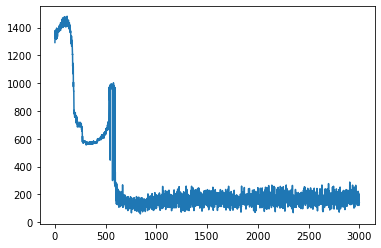

In [20]:
plt.plot(mec)

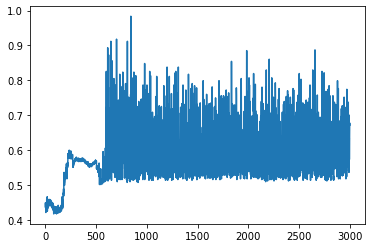

In [21]:
plt.plot(cpr)

[[ 1.         -0.56334141]
 [-0.56334141  1.        ]]
[(60, 0.9836065573770492), (68, 0.5225409836065573), (69, 0.6270491803278688)]


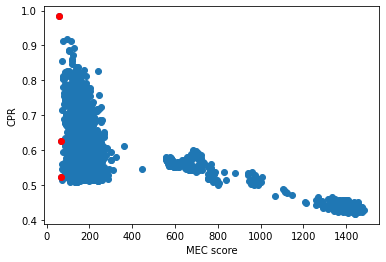

In [22]:
plt.scatter(mec, cpr)
plt.xlabel('MEC score')
plt.ylabel('CPR')

idx_best = np.argsort(mec)[:3]
plt.scatter(np.array(mec)[idx_best], np.array(cpr)[idx_best], color='red')

print(np.corrcoef(mec, cpr))
print(list(zip(np.array(mec)[idx_best], np.array(cpr)[idx_best])))

In [121]:
# np.savez('haptest_xformer_res', rec_hap=hap_matrix_best, rec_hap_origin=hap_origin_best, true_hap=true_haplo)
# np.savez('haptest_sdhap_res', rec_hap=hap_matrix_sdhap, rec_hap_origin=hap_origin_sdhap, true_hap=true_haplo)
# np.savez('haptest_SNV_matrix', SNV_matrix=SNV_matrix)

### Examining learned W

In [23]:
m = len(SNVdata)
dataloader_full = DataLoader(SNVdata, batch_size=m,
                            num_workers=0)
for i, (data, idx) in enumerate(dataloader_full):
    SNV_onehot = data
SNV_onehot.shape

torch.Size([1548, 1, 4, 244])

In [24]:
SNV_sim_tensor = torch.squeeze(torch.tensordot(SNV_onehot, SNV_onehot, dims=[[2,3], [2,3]]))

In [25]:
SNV_sim_tensor[1]

tensor([0., 2., 0.,  ..., 0., 0., 0.])

In [26]:
i = 1
overlap_idx = torch.nonzero(SNV_sim_tensor[i])
print('Overlapping reads: ', torch.squeeze(overlap_idx))
print('SNPs covered by read ', i, ' :', np.nonzero(SNV_matrix[i]))

for idx in torch.squeeze(overlap_idx):
    print('SNPs covered by read ', idx, ' :', np.nonzero(SNV_matrix[idx]), ' giving overlap of ', SNV_sim_tensor[i, idx])

print((W_sup[i]).numpy()[overlap_idx[:,0]])
print(W_sim[i][overlap_idx[:,0]])
print(W_dissim[i][overlap_idx[:,0]])

print(*zip(W_sim[i][overlap_idx[:,0]],
           W_dissim[i][overlap_idx[:,0]],
           W_sup[i].numpy()[overlap_idx[:,0]]))


Overlapping reads:  tensor([  1,   7,  66,  71,  77, 105, 141, 173, 174, 372, 384, 557, 655])
SNPs covered by read  1  : (array([69, 70]),)
SNPs covered by read  tensor(1)  : (array([69, 70]),)  giving overlap of  tensor(2.)
SNPs covered by read  tensor(7)  : (array([67, 69]),)  giving overlap of  tensor(1.)
SNPs covered by read  tensor(66)  : (array([67, 69]),)  giving overlap of  tensor(1.)
SNPs covered by read  tensor(71)  : (array([69, 71]),)  giving overlap of  tensor(1.)
SNPs covered by read  tensor(77)  : (array([68, 70]),)  giving overlap of  tensor(1.)
SNPs covered by read  tensor(105)  : (array([70, 72, 73]),)  giving overlap of  tensor(1.)
SNPs covered by read  tensor(141)  : (array([66, 67, 68, 69]),)  giving overlap of  tensor(1.)
SNPs covered by read  tensor(173)  : (array([70, 72, 73]),)  giving overlap of  tensor(1.)
SNPs covered by read  tensor(174)  : (array([70, 72]),)  giving overlap of  tensor(1.)
SNPs covered by read  tensor(372)  : (array([70, 72]),)  giving over

In [27]:
W_full = 1*W_best

print('Max diagonal value: ', np.amax(np.diag(W_full)))
# print('Diagonal values: ', np.diag(W_full))
print('Mean W: ', np.mean(W_full), 'SD of W: ', np.std(W_full))
print('Deviation from mean: ', W_full - np.mean(W_full))
print(W_full[1, overlap_idx[:,0]])

print(W_full[1])

Max diagonal value:  1.0000006
Mean W:  0.003753148 SD of W:  0.1990632
Deviation from mean:  [[ 0.9962469  -0.01503671 -0.02138223 ... -0.7470574  -0.03952575
  -0.03839656]
 [-0.01503671  0.996247   -0.02975731 ...  0.03971197  0.00391306
   0.01678713]
 [-0.02138223 -0.02975731  0.9962469  ...  0.0124531  -0.00573821
   0.00390947]
 ...
 [-0.7470574   0.03971197  0.0124531  ...  0.996247    0.01413966
   0.01913355]
 [-0.03952575  0.00391306 -0.00573821 ...  0.01413966  0.99624676
   0.01239361]
 [-0.03839656  0.01678713  0.00390947 ...  0.01913355  0.01239361
   0.99624676]]
[1.0000001  0.43231592 0.43231592 0.67474276 0.94740343 0.9472452
 0.40504697 0.9472452  0.9472452  0.9472452  0.94740343 0.43231592
 0.43231592]
[-0.01128356  1.0000001  -0.02600416 ...  0.04346512  0.00766621
  0.02054027]


In [28]:
print(torch.nonzero(W_mask[0]).numpy().flatten())
print((W_full - W_sup.numpy())[0])
print((W_full - W_sup.numpy())[0, torch.nonzero(W_mask[0]).numpy().flatten()])

[   0  216  337  407  424  448  456  459  485  603  636  660  766  872
  876 1141 1153 1178 1234 1251 1282 1294 1320]
[ 3.33333361e-11 -1.12835634e-02 -1.76290777e-02 ... -7.43304253e-01
 -3.57726030e-02 -3.46434079e-02]
[ 3.33333361e-11 -1.74835503e-01 -2.06758618e-01  5.00000041e-11
  5.00000041e-11  2.22790102e-01 -2.25565731e-01  3.33333361e-11
  3.33333361e-11 -7.66831039e-02 -3.42279553e-01 -2.25565731e-01
  3.07381391e-01  1.93822145e-01  2.19782770e-01  1.80684030e-01
  2.19782770e-01  2.19782770e-01  2.42273867e-01  2.19782770e-01
  2.42273867e-01  3.07381391e-01  3.07381391e-01]


Text(0, 0.5, 'W-Ws')

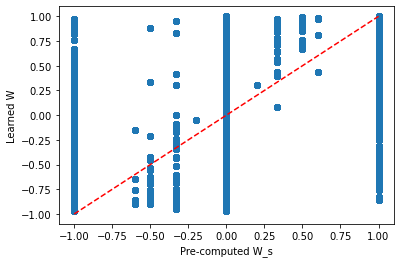

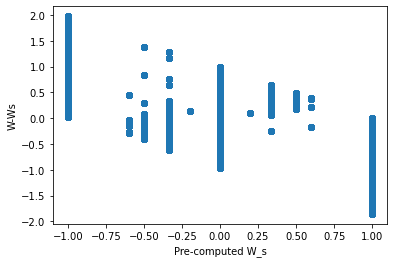

In [29]:
plt.scatter(W_sup.numpy()[torch.nonzero(W_mask)],
            W_full[torch.nonzero(W_mask)])
plt.xlabel('Pre-computed W_s')
plt.ylabel('Learned W')
plt.plot(np.linspace(-1, 1), np.linspace(-1, 1), '--r')

plt.figure()
plt.scatter(W_sup.numpy()[torch.nonzero(W_mask)],
            (W_full-W_sup.numpy())[torch.nonzero(W_mask)])
plt.xlabel('Pre-computed W_s')
plt.ylabel('W-Ws')

In [30]:
print('Fraction of reads assigned to hap1: ', np.sum(hap_origin_best == 1)/len(hap_origin_best))

Fraction of reads assigned to hap1:  0.46963824289405687


Demonstrating the imbalance in values when computing W incorrectly (| instead of &)

In [31]:
num_reads = np.shape(SNV_matrix)[0]
W_alt_sim = np.zeros((num_reads, num_reads))
W_alt_dissim = np.zeros((num_reads, num_reads))

for i, read_i in enumerate(tqdm(SNV_matrix)):
    for j, read_j in enumerate(SNV_matrix):
        if np.any((read_i != 0) & (read_j != 0)):  # Only if reads overlap
            W_alt_sim[i, j] = np.sum((read_i == read_j)[(read_i != 0) | (read_j != 0)])
            W_alt_dissim[i, j] = np.sum((read_i != read_j)[(read_i != 0) | (read_j != 0)])

W_alt = (W_alt_sim - W_alt_dissim)/(W_alt_sim + W_alt_dissim + 1e-10)

100%|███████████████████████████████████████████████████████████████████████████████| 1548/1548 [00:17<00:00, 87.90it/s]


Text(0.5, 0, 'Value')

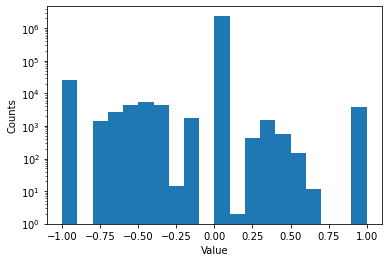

In [32]:
plt.hist(W_alt.flatten(), log=True, bins=20)
plt.ylabel('Counts')
plt.xlabel('Value')

Analyzing values of learned W in light of haplotype assignment

1202570 1193734 2396304


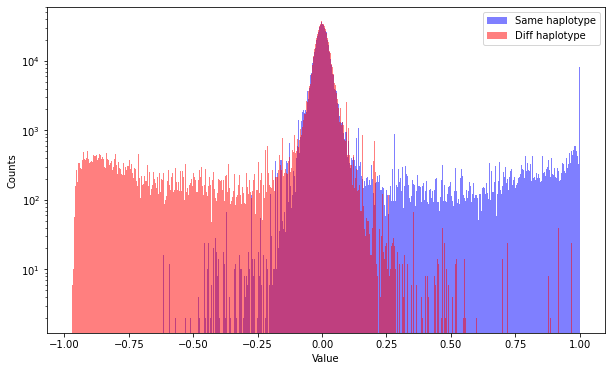

In [89]:
W_same_hap = W_best[hap_origin_best[:, None] == hap_origin_best]
W_diff_hap = W_best[hap_origin_best[:, None] != hap_origin_best]

print(len(W_same_hap), len(W_diff_hap), np.size(W_best))

plt.figure(figsize=(10,6))
plt.hist(W_same_hap, log=True, bins=1000, color='blue', alpha=0.5, label='Same haplotype')
plt.hist(W_diff_hap, log=True, bins=1000, color='red', alpha=0.5, label = 'Diff haplotype')
plt.ylabel('Counts')
plt.xlabel('Value')
plt.legend()

### CAECSeq

In [33]:
SNV_matrix = np.loadtxt(datapath, dtype=int)
caec_hap_file = 'generate_data/' + outhead + '/' + outhead + '_Reconstructed_Strains.txt'

caec_haplo = read_hap(caec_hap_file)
cpr_caec = compute_cpr(caec_haplo, true_haplo)

print('CPR for CAECSeq: ', cpr_caec)
print('MEC score for CAECSeq: ', MEC(SNV_matrix, caec_haplo))
print('MEC score for CAECSeq: ', MEC(SNV_matrix[np.sum(SNV_matrix!=0, axis=1) > 1], caec_haplo))

CPR for CAECSeq:  0.665983606557377
MEC score for CAECSeq:  204
MEC score for CAECSeq:  203


### SDHap

In [34]:
def hap_blocks(SNV_matrix: NDArray[(Any, Any), int]) -> List[List[int]]:
    """
    Parameters
    ----------
    SNV_matrix: NDAray[(Any, Any), int]:
        2D read-SNP matrix
    
    Returns
    -------
    List[List[int]]:
        List of haplotype blocks, where each block is represented by a list of SNP positions comprising
        that block
    """

from collections import deque
# FInding haplotype blocks
SNP_idx = np.zeros(np.shape(SNV_matrix)[1], dtype=bool)  # Tracking SNP positions visited in BFS
SNP_visited = np.zeros(np.shape(SNV_matrix)[1], dtype=bool)  # Tracking SNP positions in queue
print('Number of SNP positions: ', len(SNP_idx))
blocks = []
while not np.all(SNP_idx):
    idx_q = deque([np.flatnonzero(~SNP_idx)[0]])
    SNP_visited[np.flatnonzero(~SNP_idx)[0]] = True
    block_curr = []
    while idx_q:
        idx = idx_q.popleft()
        block_curr.append(idx)
        SNP_idx[idx] = True
#         print('Covered index: ', idx)
        connected_reads = np.flatnonzero(np.sum(SNV_matrix, axis=0))
        connected_reads = connected_reads[~SNP_visited]  # Only look at thus far unvisted SNPs
        idx_q.extend(connected_reads)
        SNP_visited[connected_reads] = True

    blocks.append(block_curr)
print(blocks)

Number of SNP positions:  244
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215

In [35]:
read_i = SNV_matrix[0]
read_j = SNV_matrix[0]

np.sum((read_i == read_i)[(read_i != 0) & (read_j != 0)])
print(SNV_matrix.shape)
print(np.unique(np.sum(SNV_matrix!=0, axis=1), return_counts=True))
SNV_matrix = SNV_matrix[np.sum(SNV_matrix!=0, axis=1) > 1]
SNV_matrix.shape

(1930, 244)
(array([1, 2, 3, 4, 5, 6]), array([382, 675, 531, 262,  74,   6]))


(1548, 244)

In [78]:
# W = squareform(pdist(SNV_matrix, hamming_distance))
# m = np.shape(W)[0]

num_reads = np.shape(SNV_matrix)[0]
W_sim = np.zeros((num_reads, num_reads))
W_dissim = np.zeros((num_reads, num_reads))

for i, read_i in enumerate(tqdm(SNV_matrix)):
    for j, read_j in enumerate(SNV_matrix):
        if np.any((read_i != 0) & (read_j != 0)):  # Only if reads overlap
            W_sim[i, j] = np.sum((read_i == read_j)[(read_i != 0) & (read_j != 0)])
            W_dissim[i, j] = np.sum((read_i != read_j)[(read_i != 0) & (read_j != 0)])

100%|███████████████████████████████████████████████████████████████████████████████| 1548/1548 [00:17<00:00, 88.27it/s]


In [79]:
W_sdhap = (W_sim - W_dissim)/(W_sim + W_dissim + 1e-10)
print('Fraction of W that is zero: ', np.sum(W_sdhap == 0)/np.size(W_sdhap))

Fraction of W that is zero:  0.9770763642676388


In [84]:
def sdhap(W_sdhap: NDArray[(Any, Any), float]) -> Tuple[NDArray[int],
                                                        NDArray[(Any, Any), int]]:
    sval_thr = 1e-1  # eps_th in SDHap
    change_thr = 1e-5  # eps_tol in SDHap
    m = np.shape(W_sdhap)[0]
    V = np.random.randn(m, 2)
    V = V/np.linalg.norm(V, axis=1).reshape(m,1)  # Row normalization

    col_V = np.shape(V)[1]
    rank_V = 1
    upd = True  # Set to false when convergence is achieved
    obj_curr = np.inf

    while upd:
        for i in range(m):
            V[i] = W_sdhap[i] @ V
            V[i] = V[i]/np.linalg.norm(V[i])

        rank_V = np.sum(np.linalg.svd(V, compute_uv=False) >= sval_thr)
        if(rank_V == col_V):  # V is full column rank
            col_V = col_V + 1
            rand_col = np.random.rand(m) - 0.5
            V = np.append(V, 0.01*rand_col[:,np.newaxis],
                          axis=1)
            V = V/np.linalg.norm(V, axis=1).reshape(m,1)  # Row normalization

        obj_prev = obj_curr
        obj_curr = np.trace(W_sdhap @ V @ V.T)

        upd = (rank_V != col_V) and (np.abs(1.-obj_curr/obj_prev) >= change_thr)

    # Randomized projection
    num_rounds = 10*int(np.ceil(np.log2(m)))  # number of rounds
    round_x = np.zeros((m, num_rounds), dtype=np.float32)  # x for each round
    round_obj = np.zeros(num_rounds)  # ojective for each round
    for i in range(num_rounds):
        unit_vec = np.random.randn(col_V)
    #         unit_vec = unit_vec/np.linalg.norm(unit_vec)
    #     print(i, unit_vec, np.sum(V @ unit_vec > 0))
        x = -1*np.ones(m, dtype=np.float32)
        x[np.where(V @ unit_vec > 0)] = 1

        round_x[:, i] = x
        round_obj[i] = np.dot(x, W_sdhap @ x)

    hap_origin_sdhap = round_x[:, np.argmax(round_obj)]
    hap_matrix_sdhap = origin2hap(SNV_matrix, (hap_origin_sdhap.astype(int) + 1)/2) 
    
    return hap_origin_sdhap, hap_matrix_sdhap

In [85]:
num_runs_sdhap = 100
cpr_arr_sdhap = np.zeros(num_runs_sdhap)
mec_arr_sdhap = np.zeros(num_runs_sdhap)

for i in tqdm(range(num_runs_sdhap)):
    hap_origin_sdhap, hap_matrix_sdhap = sdhap(W_sdhap)
    mec_arr_sdhap[i] = MEC(SNV_matrix, hap_matrix_sdhap)
    cpr_arr_sdhap[i] = compute_cpr(hap_matrix_sdhap, true_haplo)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [04:12<00:00,  2.53s/it]


[(50.0, 0.9938524590163934), (50.0, 0.5491803278688525), (50.0, 0.8975409836065573)]


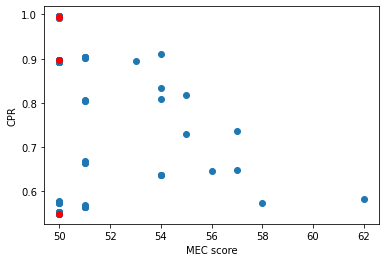

In [86]:
plt.scatter(mec_arr_sdhap, cpr_arr_sdhap)
plt.xlabel('MEC score')
plt.ylabel('CPR')

idx_sdhap = np.argsort(mec_arr_sdhap)[:3]
plt.scatter(np.array(mec_arr_sdhap)[idx_sdhap], np.array(cpr_arr_sdhap)[idx_sdhap], color='red')

print(list(zip(np.array(mec_arr_sdhap)[idx_sdhap], np.array(cpr_arr_sdhap)[idx_sdhap])))

1198246 1198058 2396304


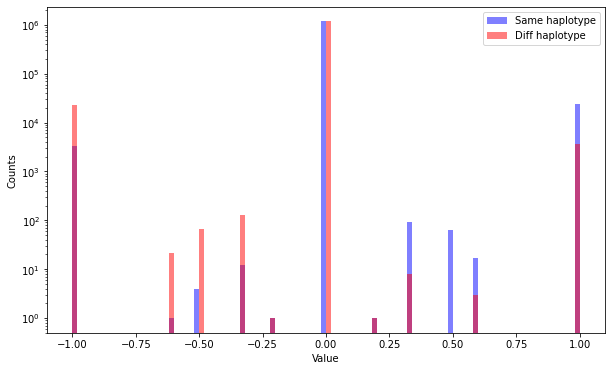

In [88]:
W_same_hap = W_sdhap[hap_origin_best[:, None] == hap_origin_sdhap]
W_diff_hap = W_sdhap[hap_origin_best[:, None] != hap_origin_sdhap]

print(len(W_same_hap), len(W_diff_hap), np.size(W_best))

plt.figure(figsize=(10,6))
plt.hist(W_same_hap, log=True, bins=100, color='blue', alpha=0.5, label='Same haplotype')
plt.hist(W_diff_hap, log=True, bins=100, color='red', alpha=0.5, label = 'Diff haplotype')
plt.ylabel('Counts')
plt.xlabel('Value')
plt.legend()

In [123]:
sval_thr = 1e-1  # eps_th in SDHap
change_thr = 1e-5  # eps_tol in SDHap
m = np.shape(SNV_matrix)[0]
V = np.random.randn(m, 2)
V = V/np.linalg.norm(V, axis=1).reshape(m,1)  # Row normalization

col_V = np.shape(V)[1]
rank_V = 1
upd = True  # Set to false when convergence is achieved
obj_curr = np.inf

print('Weight matrix: ', W_sdhap)
print("Initial V: ", V[:10])
while upd:
    for i in range(m):
        V[i] = W_sdhap[i] @ V
#         print("After multiplication ", i, V[i])
        V[i] = V[i]/np.linalg.norm(V[i])
#     print(V[:10])
#         print('Singular values: ', np.linalg.svd(V, compute_uv=False))
    rank_V = np.sum(np.linalg.svd(V, compute_uv=False) >= sval_thr)
    if(rank_V == col_V):  # V is full column rank
        col_V = col_V + 1
        rand_col = np.random.rand(m) - 0.5
        V = np.append(V, 0.01*rand_col[:,np.newaxis],
                      axis=1)
        V = V/np.linalg.norm(V, axis=1).reshape(m,1)  # Row normalization

    obj_prev = obj_curr
    obj_curr = np.trace(W_sdhap @ V @ V.T)
    print("k = ", rank_V, ", r = ", col_V)
#     print("Prev obj = ", obj_prev, ", new obj = ", obj_curr)
#     print("Percentage drop in objective value = ", 1 - obj_curr/obj_prev)
    upd = (rank_V != col_V) and (np.abs(1.-obj_curr/obj_prev) >= change_thr)

# Randomized projection
print("Final V = ", V)
num_rounds = 10*int(np.ceil(np.log2(m)))  # number of rounds
round_x = np.zeros((m, num_rounds), dtype=np.float32)  # x for each round
round_obj = np.zeros(num_rounds)  # ojective for each round
for i in range(num_rounds):
    unit_vec = np.random.randn(col_V)
#         unit_vec = unit_vec/np.linalg.norm(unit_vec)
#     print(i, unit_vec, np.sum(V @ unit_vec > 0))
    x = -1*np.ones(m, dtype=np.float32)
    x[np.where(V @ unit_vec > 0)] = 1

    round_x[:, i] = x
    round_obj[i] = np.dot(x, W_sdhap @ x)
print(round_obj)

hap_origin_sdhap = round_x[:, np.argmax(round_obj)]
hap_matrix_sdhap = origin2hap(SNV_matrix, (hap_origin_sdhap.astype(int) + 1)/2) 
cpr_sdhap = compute_cpr(hap_matrix_sdhap, true_haplo)
print(hap_origin_sdhap) 
print('CPR for SDHap: ', cpr_sdhap)
print('MEC score for SDHap: ', MEC(SNV_matrix, hap_matrix_sdhap))
print('Fraction of reads assigned to 1st haplotype: ', np.sum(hap_origin_sdhap == 1)/len(hap_origin_sdhap))

Weight matrix:  [[ 1.  0.  0. ...  0.  0. -1.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ... -1.  0.  0.]
 ...
 [ 0.  0. -1. ...  1.  1.  0.]
 [ 0.  0.  0. ...  1.  1.  0.]
 [-1.  0.  0. ...  0.  0.  1.]]
Initial V:  [[ 0.24265858  0.97011175]
 [ 0.30797635 -0.95139401]
 [ 0.22799131 -0.97366317]
 [ 0.73037979  0.68304126]
 [-0.13690919 -0.9905836 ]
 [-0.67334911  0.73932468]
 [ 0.11822861 -0.9929864 ]
 [-0.48057955  0.87695114]
 [ 0.97632164  0.21632397]
 [ 0.88980047  0.45634978]]
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r =  3
k =  2 , r = 

MEC score for SDHap:  41
Fraction of reads assigned to 1st haplotype:  0.5


In [124]:
mec_arr_sdhap = np.zeros(np.shape(round_x)[1])
cpr_arr_sdhap = np.zeros(np.shape(round_x)[1])

for i, x in enumerate(round_x.T):
    hap_matrix_i = origin2hap(SNV_matrix, (round_x[:, i].astype(int) + 1)/2)
    cpr_arr_sdhap[i] = compute_cpr(hap_matrix_i, true_haplo)
    mec_arr_sdhap[i] = MEC(SNV_matrix, hap_matrix_i)
    
print('CPR for all solutions: ', cpr_arr_sdhap)
print('MEC for all solutions: ', mec_arr_sdhap)
print('CPR for best solutions: ', cpr_arr_sdhap[mec_arr_sdhap == MEC(SNV_matrix, hap_matrix_sdhap)])

CPR for all solutions:  [0.9887218  0.9887218  0.9887218  0.9887218  0.9887218  0.9887218
 0.9887218  0.9887218  0.9887218  0.9887218  0.9887218  0.9887218
 0.9887218  0.9887218  0.9887218  0.9887218  0.9887218  0.9887218
 0.9887218  0.9887218  0.9887218  0.9887218  0.9887218  0.9887218
 0.9887218  0.9887218  0.9887218  0.9887218  0.9887218  0.9887218
 0.9887218  0.9887218  0.9887218  0.9887218  0.9887218  0.61090226
 0.9887218  0.9887218  0.9887218  0.9887218  0.83082707 0.67105263
 0.9887218  0.9887218  0.9887218  0.9887218  0.9887218  0.9887218
 0.9887218  0.9887218  0.9887218  0.9887218  0.9887218  0.9887218
 0.9887218  0.9887218  0.9887218  0.9887218  0.9887218  0.9887218
 0.9887218  0.9887218  0.9887218  0.53195489 0.9887218  0.9887218
 0.9887218  0.9887218  0.63345865 0.9887218  0.9887218  0.9887218
 0.9887218  0.9887218  0.9887218  0.9887218  0.9887218  0.9887218
 0.9887218  0.9887218  0.9887218  0.9887218  0.9887218  0.9887218
 0.9887218  0.9887218  0.9887218  0.9887218  0.988

In [ ]:
hap_matrix_i = origin2hap(SNV_matrix, (round_x[:, -3].astype(int) + 1)/2)

hap_matrix_j = origin2hap(SNV_matrix, (round_x[:, -3].astype(int) + 1)/2)

print(hap_matrix_i - hap_matrix_j)

In [ ]:
from itertools import permutations
recovered_haplo = hap_matrix_sdhap

distance_table = np.zeros((len(recovered_haplo), len(true_haplo)))
for i, rec_hap in enumerate(recovered_haplo):
        for j, true_hap in enumerate(true_haplo):
                distance_table[i, j] = hamming_distance(rec_hap, true_hap)

index = permutations(range(true_haplo.shape[0]))
min_distance = np.inf
distance = []
for matching in index:
        count = 0
        for i, match_idx in enumerate(matching):
                count += distance_table[i, match_idx]
        distance.append(count)
        if count < min_distance:
                best_matching = matching
                min_distance = count
# index = (list(index))[np.argmin(np.array(distance))]  # Best one-to-one mapping
# print(best_matching)
print('CPR: ', 1 - min(distance) / np.size(true_haplo))
print(distance_table)
print(recovered_haplo)
print(true_haplo)
print()
for hap_origin_i in round_x.T:
    hap_matrix_i = origin2hap(SNV_matrix, (hap_origin_i.astype(int) + 1)/2) 
    print('CPR for approximation: ',  compute_cpr(hap_matrix_i, true_haplo))
    print('Haplotypes: \n', hap_matrix_i)
    print()

In [ ]:
from itertools import permutations
recovered_haplo = hap_matrix

distance_table = np.zeros((len(recovered_haplo), len(true_haplo)))
for i, rec_hap in enumerate(recovered_haplo):
        for j, true_hap in enumerate(true_haplo):
                distance_table[i, j] = hamming_distance(rec_hap, true_hap)

index = permutations(range(true_haplo.shape[0]))
min_distance = np.inf
distance = []
for matching in index:
        count = 0
        for i, match_idx in enumerate(matching):
                count += distance_table[i, match_idx]
        distance.append(count)
        if count < min_distance:
                best_matching = matching
                min_distance = count
# index = (list(index))[np.argmin(np.array(distance))]  # Best one-to-one mapping
# print(best_matching)
print('CPR: ', 1 - min(distance) / np.size(true_haplo))
print(hap_matrix[0]-true_haplo[0])
print(hap_matrix[0]-true_haplo[1])

In [ ]:
X = cp.Variable((m,m), symmetric=True)
constraints = [X >> 0]
constraints += [
    X[i, i] == 1 for i in range(m)
]
prob = cp.Problem(cp.Minimize(cp.trace(W  @ X)),
              constraints)  # Solve SDP relaxation
prob.solve(verbose=True)
X_opt = X.value

In [ ]:
# Goemans-Williamson algorithm
X = cp.Variable((m,m), symmetric=True)
constraints = [X >> 0]
constraints += [
    X[i, i] == 1 for i in range(m)
]
prob = cp.Problem(cp.Minimize(cp.trace(W  @ X)),
              constraints)  # Solve SDP relaxation
prob.solve()
X_opt = X.value

num_rounds = 10*int(np.ceil(np.log2(m)))  # number of rounds
round_x = np.zeros((m, num_rounds), dtype=np.float32)  # x for each round
round_obj = np.zeros(num_rounds)  # ojective for each round
for i in range(num_rounds):
    unit_vec = np.random.randn(m)
    unit_vec = unit_vec/np.linalg.norm(unit_vec)
    x = -1*np.ones(m, dtype=np.float32)
    eigval, eigvec = np.linalg.eigh(X_opt)
    eigval[eigval<0] = 0  # Zeroing out negative eigenvalues
    L = eigvec @ np.diag(np.sqrt(eigval))
#         L = np.linalg.cholesky(X_opt+ 1e-4*np.eye(m))  # Tikhonov regularization
    x[np.where(L.T @ unit_vec > 0)] = 1

    round_x[:, i] = x
    round_obj[i] = np.dot(x, W @ x)

hap_origin = round_x[:, np.argmin(round_obj)]
hap_matrix = origin2hap(SNV_matrix, (hap_origin.astype(int) + 1)/2) 
cpr_sdhap = compute_cpr(hap_matrix, true_haplo)
print(hap_origin) 
print(cpr_sdhap)
print(round_obj)

#### Greedy refinement

In [ ]:
hap_matrix[:,0][::-1]

In [ ]:
hap_matrix_greedy = deepcopy(hap_matrix)  # Refined solution
mec_curr = MEC(SNV_matrix, hap_matrix)  # Current MEC

hap_matrix_new = deepcopy(hap_matrix)
while True:
    mec_startiter = mec_curr
    for j in range(np.shape(hap_matrix)[1]):
        hap_matrix_new[:,j] = hap_matrix[:,j][::-1]  # Flip base
        mec_new = MEC(SNV_matrix, hap_matrix_new)
        if mec_new < mec_curr:  # Update refined solution
            mec_curr = mec_new
            hap_matrix_greedy[:,j] = hap_matrix[:,j][::-1]
        else:  # Reverse base flip
            hap_matrix_new[:,j] = hap_matrix[:,j]
    if mec_curr == mec_startiter:  # Greedy refinement not improving MEC
        break
    else:
        print(mec_startiter, mec_curr)
cpr_sdhap_greedy = compute_cpr(hap_matrix_greedy, true_haplo)
print(cpr_sdhap_greedy)

### Testing out helper functions

In [ ]:
refine(hap_matrix, SNV_matrix, verbose=True)

In [ ]:
det_memhap(SNVdata, embedAE, corr_xformer)

In [ ]:
hap_matrix = origin2hap(SNVdata, np.concatenate((np.ones(50), -1*np.ones(50))))

In [ ]:
MEC(SNV_matrix, hap_matrix)

#### Code snippet to recover full SNV matrix from 

In [ ]:
dataloader_full = DataLoader(SNVdataset,
                             batch_size=len(SNVdataset),
                             num_workers=0)
for i, data in enumerate(dataloader_full):
    SNV_tensor = np.squeeze(data.detach().numpy())

SNV_matrix = np.zeros((SNV_tensor.shape[0], SNV_tensor.shape[2]))
SNV_cov = np.nonzero(np.sum(SNV_tensor, axis=1))
SNV_matrix[SNV_cov] = np.argmax(SNV_tensor, axis=1)[SNV_cov] + 1

### Testing out transformer

In [28]:
x = torch.randn((1, 500, 128))
CorrTransform = CorrTransformer(d_model=128)
CorrTransform(x)

torch.Size([1, 500, 32])
torch.Size([1, 500])


tensor([[[ 1.0000,  0.1954, -0.0705,  ..., -0.0338,  0.4121,  0.4287],
         [ 0.1954,  1.0000,  0.0018,  ...,  0.1492,  0.2856,  0.4612],
         [-0.0705,  0.0018,  1.0000,  ...,  0.3570,  0.0546,  0.1313],
         ...,
         [-0.0338,  0.1492,  0.3570,  ...,  1.0000,  0.2478,  0.2724],
         [ 0.4121,  0.2856,  0.0546,  ...,  0.2478,  1.0000,  0.4250],
         [ 0.4287,  0.4612,  0.1313,  ...,  0.2724,  0.4250,  1.0000]]],
       grad_fn=<UnsafeViewBackward0>)